In [1]:
from __future__ import absolute_import
import os
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
torch.multiprocessing.set_sharing_strategy('file_system')
import torch.nn.functional as F
import utils.utility as utility
from utils.logger import Logger
from torchvision.models import resnet18
from data.Camelyon import Camelyon
import argparse
from importlib import import_module
from utils.utility import adjust_learning_rate
import ssl
%tb
ssl._create_default_https_context = ssl._create_unverified_context

from torch.utils.data import DataLoader
import numpy as np

No traceback available to show.


In [8]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
##epoch #############################ratio
### log_dir and data_root
def parse_args():
    parser = argparse.ArgumentParser(description='317 MIL Framework')
    parser.add_argument("--task", type=str, default="CausalDigest",
                        help="Which task to perform",
                        choices=["Digest", "Camelyon", "Nctcrc", "CausalDigest"])
    parser.add_argument('--config', type=str, default='DigestSegFull',
                        help="Config file to use.",
                        choices=["DigestSegEMCAV2", "DigestSeg", 'DigestSegPB',
                                 'DigestSegTOPK', 'DigestSegFull', 'DigestSegRCE'])
    parser.add_argument("--log_dir", type=str,
                        default="/remote-home/ltc/HisMIL/experiments/Causal/test",
                        help="The experiment log directory")
    parser.add_argument("--data_root", "-d", type=str,
                        default="/remote-home/share/DATA/HISMIL/5_folder/0",
                        help="root directory of data used")
#####
    parser.add_argument("--resume", type=int, default=-1, help="Resume epoch")
    parser.add_argument("--bs", type=int, default=32, help="Resume epoch")
    parser.add_argument("--backbone", type=str, default='res18',
                        help="which backbone to use.")
    parser.add_argument("--pretrained", action="store_true", default=False,
                        help="Whether to use weighted BCE loss")
    parser.add_argument('-lr', type=float, default=1e-3, help="Learning rate")
    parser.add_argument("--epochs", "-e", type=int, default=50,
                        help="How many epochs to train")
    parser.add_argument('--cos', action='store_true', default=True,
                        help='use cosine lr schedule')
    parser.add_argument('--schedule', default=[120, 160], nargs='*', type=int,
                        help='learning rate schedule (when to drop lr by 10x)')
    # choose loss
    # parser.add_argument("--rce", action="store_true", default=False, help="Whether to use weighted BCE loss")
    # Calibration loss
    parser.add_argument("--stop_epoch", type=int, default=-1, help="stop")
    parser.add_argument("--ignore_thres", type=float, default=0.95, help="ignore")
    # one-stage or two stage training
    parser.add_argument("--database", action="store_true", default=True, help="Using database")
    parser.add_argument('--workers', default=8, type=int, metavar='N',
                        help='number of data loading workers (default: 32)')
 ###########
    parser.add_argument("--load", type=int, default=50, help="the epoch to be loaded")
    parser.add_argument("--load_path", type=str,
                        default="/remote-home/ltc/HisMIL/experiments/PB_BCE/2020_2_12/f0",
                        help="For confounder")
    parser.add_argument("--save_path", type=str,
                        default="/home/ltc/1T/HisMIL/experiments/Full/2020_12_26/f4",
                        help="The load directory")
    # EM
    parser.add_argument("--mmt", type=float, default=0.9, help="mmt")
    parser.add_argument("--noisy", action="store_true", default=False, help="Noisy bag pos ratio")

    # ssl
    parser.add_argument("--ssl", action="store_true", default=False, help="Self supervised learning")
    parser.add_argument("--camelyon", action="store_true", default=False, help="Training on camelyon")
    parser.add_argument("--pickle", action="store_true", default=False, help="Using pickle")
#     args = parser.parse_args()
    args = parser.parse_args(['-lr', '1e-3'])
    return args

In [9]:
##epoch #############################ratio
### log_dir and data_root

def eval_(self, gs, trainset):
    # self.backbone = self.logger.load_backbone_fromold(self.backbone, global_step=gs)
    # self.clsnet = self.logger.load_clsnet_fromold(self.clsnet, global_step=gs)
    if gs != -1:
        print('Loading')
        self.backbone = self.logger.load_backbone(self.backbone, global_step=gs)
        self.clsnet = self.logger.load_clsnet(self.clsnet, global_step=gs)
    self.backbone.eval()
    #     self.clsnet.eval()
    val_loader = DataLoader(trainset, args.bs, shuffle=True, num_workers=4)
    #     confoundSet = torch.randn([trainset.__len__(), 514])
    bag_idx_list = []
    inner_idx_list = []
    feature_list = []
    with torch.no_grad():
        for batch_idx, (imgs, instance_labels, bag_index, inner_index, nodule_ratios, real_ins_labels) in enumerate(
                tqdm(val_loader, ascii=True, ncols=60)):
            instance_preds = torch.sigmoid(self.clsnet(self.backbone(imgs.to(self.device))))
            print(bag_index)
#             feature_list.append(instance_preds)
#             bag_idx_list.append(bag_index)
#             inner_idx_list.append(inner_index)

#     return feature_list, bag_idx_list, inner_idx_list

In [10]:
#############################ratio
### log_dir ## data_root ##epoch
args = parse_args()
if args.task == 'Digest':
    configs = getattr(import_module('configs.' + 'DigestSeg'), 'Config')(args)
elif args.task == 'Camelyon':
    configs = getattr(import_module('configs.' + 'Camelyon'), 'Config')(args)
elif args.task == 'CausalDigest':
    print('Here??????????')
    configs = getattr(import_module('configs.'+'CausalDigest'), 'Config')(args)  
else:
    raise NotImplementedError
# configs.logger.init_backup(configs)
trainer = configs.trainer
tester = configs.tester
trainer.eval = eval_
epoch = configs.load

Here??????????
torch.Size([528, 512]) tensor([0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
  

In [11]:
feature_list, bag_idx_list, inner_idx_list = trainer.eval(trainer, epoch, configs.valset)
features = torch.cat(feature_list)
bag_indexs = torch.cat(bag_idx_list).unsqueeze(-1).float().cuda()
inner_indexs = torch.cat(inner_idx_list).unsqueeze(-1).float().cuda()
confounderSet = torch.cat((features, bag_indexs, inner_indexs),dim=1)

# import numpy as np
# confounder = np.array(confounderSet.cpu())
# if not os.path.exists(args.save_path):
#     os.makedirs(args.save_path)
# np.save(args.log_dir+'/conf.npy', confounder)

Loading
==> Resuming net of epoch /remote-home/ltc/HisMIL/experiments/Causal/PB/2021_4_26/f0/ckp/net.ckpt50.pth


  0%|                              | 0/1159 [00:00<?, ?it/s]

set()
==> Resuming net of epoch /remote-home/ltc/HisMIL/experiments/Causal/PB/2021_4_26/f0/ckp/net.ckpt50.pth
set()


  0%|                      | 3/1159 [00:01<13:59,  1.38it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5870, 0.6574, 0.5479, 0.3480, 0.4288, 0.7607, 0.7893, 0.8098, 0.5553,
        0.6372, 0.5656, 0.5183, 0.6053, 0.3630, 0.7131, 0.4970, 0.3873, 0.5108,
        0.3949, 0.5000, 0.5807, 0.4161, 0.5914, 0.5419, 0.4856, 0.3881, 0.5661,
        0.5536, 0.4915, 0.4752, 0.6161, 0.3444], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([136, 199, 382, 153, 266, 451,  54, 139, 161, 394, 204, 350,  48, 359,
        167, 144,  57, 466, 381, 394, 140,  54, 270, 249, 206,  18, 221, 514,
        382, 194, 477, 382])
Attention_weight: torch.return_types.max(
values=tensor([0.7813, 0.3350, 0.7911, 0.5499, 0.5793, 0.1894, 0.6070, 0.4637, 0.4331,
        0.4463, 0.3344, 0.4316, 0.5829, 0.4018, 0.1497, 0.2796, 0.4259, 0.3036,
        0.7214, 0.4604, 0.4167, 0.1616,

  0%|                      | 4/1159 [00:01<10:49,  1.78it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1666, 0.4055, 0.5940, 0.6677, 0.3791, 0.2733, 0.2551, 0.7418, 0.7355,
        0.6447, 0.2233, 0.7380, 0.6760, 0.5671, 0.4100, 0.4505, 0.1693, 0.3794,
        0.7147, 0.5172, 0.2469, 0.5390, 0.3544, 0.4763, 0.5086, 0.6474, 0.3922,
        0.3159, 0.6843, 0.6787, 0.4541, 0.4337], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([180, 354, 508, 524, 204, 345, 261, 329, 136,  57, 167, 405, 341, 266,
        200, 264,  45,  57, 354, 194,  11, 363,  25, 480,  72, 139, 152, 431,
        411,  54, 167, 171])


  1%|1                     | 6/1159 [00:01<06:59,  2.75it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6671, 0.5583, 0.2675, 0.6964, 0.6119, 0.7905, 0.4985, 0.4532, 0.4373,
        0.1486, 0.4596, 0.5660, 0.6803, 0.6301, 0.6834, 0.2905, 0.4935, 0.4406,
        0.6968, 0.3768, 0.2252, 0.7261, 0.5102, 0.6950, 0.3403, 0.5835, 0.3067,
        0.4159, 0.6613, 0.7527, 0.1503, 0.4384], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194, 164,  57, 231, 146, 320, 284, 285,   1, 430,  12,  42, 411, 194,
        461, 479, 123, 465,  84,  72,  11,  54, 330, 451,  48, 266, 204,  43,
        331, 194,  62,  63])
Attention_weight: torch.return_types.max(
values=tensor([0.5254, 0.4210, 0.2568, 0.4397, 0.3777, 0.3853, 0.6014, 0.4497, 0.5635,
        0.6233, 0.4784, 0.2895, 0.5881, 0.3471, 0.5198, 0.7674, 0.6748, 0.3747,
        0.3539, 0.3040, 0.8300, 0.1770,

  1%|1                     | 7/1159 [00:01<05:55,  3.24it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4044, 0.5048, 0.4417, 0.6641, 0.8108, 0.6480, 0.6588, 0.7200, 0.5260,
        0.6453, 0.4288, 0.3496, 0.3767, 0.5927, 0.4533, 0.5292, 0.7195, 0.2141,
        0.6105, 0.3654, 0.4762, 0.2413, 0.3569, 0.5643, 0.5391, 0.2993, 0.6739,
        0.8314, 0.3263, 0.4296, 0.6076, 0.4106], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([136, 346, 123, 446,  17, 194, 492, 393, 136,  54, 152, 345, 492, 306,
        140,  43, 263, 158, 351,  11, 160, 119,  62,  69, 212,   2, 269, 139,
         48, 174, 194, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.6101, 0.3519, 0.4719, 0.5696, 0.7866, 0.4049, 0.8021, 0.7745, 0.4505,
        0.3354, 0.4192, 0.6854, 0.8777, 0.3198, 0.5900, 0.6372, 0.4131, 0.4284,
        0.4167, 0.2888, 0.5543, 0.3883,

  1%|1                     | 9/1159 [00:02<04:35,  4.18it/s]

tensor([ 63, 425, 402, 226,  76, 346, 406,  54,  57, 332, 265, 266, 139,  64,
         76, 472,   6, 213, 269, 467, 204,  24,  11, 439, 285, 482, 158, 167,
        395, 284, 332, 164])
Attention_weight: torch.return_types.max(
values=tensor([0.4586, 0.4871, 0.6258, 0.3220, 0.3193, 0.3614, 0.6842, 0.6862, 0.3754,
        0.3836, 0.5199, 0.4993, 0.6280, 0.5284, 0.7418, 0.2782, 0.6262, 0.3598,
        0.6182, 0.5972, 0.5617, 0.8239, 0.6354, 0.3282, 0.4326, 0.4666, 0.5146,
        0.3173, 0.6436, 0.2971, 0.3358, 0.3725], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 66, 359,  11,  99, 123,  57,  57, 139,  69, 264,  63,  86,  93,  97,
         55, 199, 524, 171,  22,  54, 255,  54, 461,  18, 123, 435, 123, 265,
        523, 333, 395, 139])


  1%|1                    | 11/1159 [00:02<03:43,  5.13it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5041, 0.5924, 0.6716, 0.3755, 0.4382, 0.8990, 0.5423, 0.5261, 0.4171,
        0.2526, 0.3060, 0.3142, 0.6120, 0.5562, 0.6457, 0.3055, 0.5243, 0.5534,
        0.3925, 0.5033, 0.1955, 0.3710, 0.4631, 0.4706, 0.7126, 0.4107, 0.5420,
        0.2824, 0.6678, 0.6038, 0.5241, 0.3606], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([284,  23, 194,  57, 393,  54, 441, 194, 317, 192, 164,  42, 434, 520,
        310, 167, 402, 201, 500, 165, 111, 435, 358, 135, 381, 299, 381, 199,
         54, 164, 467, 428])
Attention_weight: torch.return_types.max(
values=tensor([0.3507, 0.7603, 0.7871, 0.6852, 0.7632, 0.7274, 0.9052, 0.4777, 0.1938,
        0.2842, 0.4144, 0.4001, 0.3356, 0.4118, 0.2924, 0.3820, 0.5858, 0.7272,
        0.5045, 0.2111, 0.2111, 0.4432,

  1%|2                    | 14/1159 [00:02<02:47,  6.83it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4337, 0.3183, 0.2464, 0.7534, 0.2958, 0.5617, 0.3502, 0.7785, 0.3808,
        0.2540, 0.5978, 0.7837, 0.3241, 0.6226, 0.7232, 0.2606, 0.5881, 0.7322,
        0.4512, 0.4381, 0.4486, 0.4517, 0.2819, 0.3675, 0.2012, 0.3655, 0.3708,
        0.7506, 0.6795, 0.7822, 0.6708, 0.6503], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([183, 471,   1,  54,   1, 164, 152, 506,   1, 256, 139, 139, 114,  54,
        215, 231,  92,  48, 233, 136, 150, 234, 324,  57, 362, 320, 368,  84,
        352, 214, 472, 435])
Attention_weight: torch.return_types.max(
values=tensor([0.6452, 0.5522, 0.1880, 0.3114, 0.6123, 0.4508, 0.5942, 0.2007, 0.3191,
        0.5360, 0.2834, 0.3723, 0.1907, 0.5333, 0.2190, 0.3319, 0.3869, 0.2435,
        0.2629, 0.2114, 0.5879, 0.7819,

  1%|2                    | 16/1159 [00:02<02:27,  7.74it/s]

tensor([ 64, 194, 348,  11, 442, 194, 168, 282, 360, 139, 447,  16,  57, 423,
        266,  11, 363, 136, 332, 447,  47, 410, 194,  22, 402, 412, 144, 383,
         38, 240,  74,  18])
Attention_weight: torch.return_types.max(
values=tensor([0.5256, 0.3857, 0.3655, 0.3693, 0.4527, 0.8857, 0.4839, 0.4327, 0.2785,
        0.6813, 0.5488, 0.2502, 0.8223, 0.1752, 0.2912, 0.2323, 0.6425, 0.5510,
        0.6417, 0.2179, 0.5388, 0.3791, 0.5676, 0.3213, 0.3985, 0.2531, 0.6322,
        0.1785, 0.3398, 0.1515, 0.7180, 0.5684], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139, 306, 198, 387, 139, 139, 107, 300, 326, 447, 393,  51, 139,  61,
        221, 152, 381, 272, 249,  54,  37, 235, 154, 217, 273,  34, 164, 398,
        316,  60,  67, 249])


  2%|3                    | 19/1159 [00:03<02:43,  6.97it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2064, 0.6144, 0.2194, 0.7797, 0.6864, 0.5034, 0.4199, 0.2247, 0.4798,
        0.5640, 0.6035, 0.6286, 0.2842, 0.4562, 0.1742, 0.1825, 0.4524, 0.2299,
        0.3639, 0.6042, 0.5167, 0.4738, 0.6240, 0.7886, 0.2078, 0.5858, 0.5428,
        0.1824, 0.7368, 0.5929, 0.4446, 0.4431], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([  1,  11,  96, 214, 213, 282, 139,  57, 435, 234,  11, 506,  57, 506,
         48, 382,  11,  57, 524, 194,  48, 194, 152, 518, 189, 238, 523, 191,
         23, 139, 433, 464])
Attention_weight: torch.return_types.max(
values=tensor([0.7273, 0.5948, 0.4309, 0.6518, 0.2185, 0.5555, 0.2698, 0.4741, 0.2190,
        0.5891, 0.3471, 0.3086, 0.4154, 0.8031, 0.5727, 0.3909, 0.4853, 0.6253,
        0.2475, 0.3749, 0.8665, 0.2843,

  2%|4                    | 23/1159 [00:03<02:35,  7.30it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6744, 0.6732, 0.3032, 0.4955, 0.6386, 0.7153, 0.4916, 0.3297, 0.3353,
        0.6956, 0.5837, 0.3839, 0.5086, 0.2621, 0.9113, 0.5532, 0.3588, 0.1780,
        0.7065, 0.2074, 0.2646, 0.5118, 0.4970, 0.6594, 0.5043, 0.4393, 0.7061,
        0.2983, 0.4677, 0.6026, 0.3981, 0.2760], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194, 246, 177, 276, 303, 139, 112,  51,   1, 246, 221,  54, 139, 194,
         63,  78, 156,  74, 394, 123,  57, 200,  11, 214, 325,  48, 150, 266,
         54, 303,   9, 119])
Attention_weight: torch.return_types.max(
values=tensor([0.7022, 0.4792, 0.3998, 0.6197, 0.5415, 0.5481, 0.6924, 0.7036, 0.6382,
        0.5011, 0.3501, 0.6370, 0.4188, 0.4989, 0.3776, 0.1909, 0.5210, 0.4734,
        0.8177, 0.4460, 0.3614, 0.6856,

  2%|4                    | 24/1159 [00:04<02:40,  7.08it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3288, 0.8016, 0.5454, 0.3500, 0.4111, 0.3666, 0.6976, 0.4067, 0.3520,
        0.5930, 0.6795, 0.6165, 0.2018, 0.4691, 0.7472, 0.5671, 0.3692, 0.6432,
        0.5036, 0.6072, 0.3613, 0.5104, 0.4073, 0.3818, 0.4029, 0.5737, 0.5566,
        0.6632, 0.3157, 0.6144, 0.4093, 0.3668], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([  1,  54, 480,  53,  96, 316, 136, 123, 133, 139,  48, 253,  23, 152,
         54, 208, 299, 274,   9, 309, 284, 221, 230,   8, 267,  11,  57, 164,
          7, 399, 118, 293])


  2%|4                    | 27/1159 [00:04<02:37,  7.18it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5236, 0.5774, 0.6672, 0.2236, 0.8655, 0.7619, 0.6474, 0.3293, 0.6220,
        0.4841, 0.4042, 0.6263, 0.6694, 0.4612, 0.2916, 0.6931, 0.3429, 0.3576,
        0.4577, 0.8067, 0.2959, 0.7156, 0.4063, 0.6989, 0.4104, 0.6982, 0.5014,
        0.2259, 0.4244, 0.6550, 0.3088, 0.7352], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([357, 242, 278, 289, 102, 513, 402, 337, 392, 368, 136, 293,   7,  35,
        326, 384, 201,  87, 457,  54,  87,  31, 337, 217, 292, 456,   1, 285,
         64,  42,  11,  90])
Attention_weight: torch.return_types.max(
values=tensor([0.2498, 0.1856, 0.4316, 0.2658, 0.2085, 0.2689, 0.4832, 0.4312, 0.3534,
        0.3839, 0.8246, 0.1695, 0.3785, 0.5006, 0.7896, 0.3588, 0.5463, 0.3373,
        0.5659, 0.6423, 0.4850, 0.3410,

  3%|5                    | 31/1159 [00:04<02:23,  7.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2971, 0.8401, 0.4676, 0.6106, 0.4813, 0.5810, 0.3959, 0.6805, 0.5236,
        0.3986, 0.3976, 0.1820, 0.3299, 0.6930, 0.7395, 0.5015, 0.6717, 0.5089,
        0.5563, 0.6376, 0.3052, 0.5232, 0.5503, 0.4555, 0.6170, 0.2610, 0.6799,
        0.7684, 0.4523, 0.2494, 0.2228, 0.3491], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([270, 152, 485, 471,  48, 382,  57, 194,  11, 151,  11, 136, 455, 303,
         54,  48,  63, 119, 194, 388,   1, 145, 348, 524, 471,  94, 252,  54,
        419, 285, 171, 200])
Attention_weight: torch.return_types.max(
values=tensor([0.6626, 0.6136, 0.5141, 0.7765, 0.5031, 0.5762, 0.2467, 0.4499, 0.6629,
        0.6627, 0.1708, 0.3037, 0.2937, 0.8200, 0.2821, 0.4275, 0.3430, 0.3170,
        0.7552, 0.5858, 0.6447, 0.2995,

  3%|5                    | 32/1159 [00:05<02:18,  8.16it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6050, 0.5327, 0.5624, 0.7560, 0.5342, 0.2918, 0.6980, 0.6233, 0.4175,
        0.3562, 0.3281, 0.5331, 0.3079, 0.6235, 0.5662, 0.7772, 0.7561, 0.7721,
        0.5887, 0.5775, 0.6125, 0.3574, 0.7468, 0.1922, 0.3918, 0.3557, 0.7806,
        0.3322, 0.6766, 0.3129, 0.4767, 0.4928], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([187, 194, 194,  54, 191, 119,  11,  57, 157, 158,  11,  11, 408, 419,
        485,   7,  25, 267, 379, 194,  76, 345, 140, 188, 523,  11, 145, 140,
        282, 303, 127, 490])


  3%|6                    | 35/1159 [00:05<02:59,  6.27it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3279, 0.6992, 0.1718, 0.5479, 0.6720, 0.2800, 0.2160, 0.7569, 0.7101,
        0.3596, 0.5629, 0.4634, 0.2680, 0.6412, 0.4469, 0.4358, 0.6261, 0.4256,
        0.2851, 0.7200, 0.3635, 0.8073, 0.5359, 0.3966, 0.5748, 0.7603, 0.4364,
        0.7765, 0.6813, 0.6439, 0.2959, 0.3122], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([273, 320, 139,  11, 276,   6,  29, 411,  54, 311, 315, 329,  11, 338,
        325,  54, 320, 315, 320, 406, 194,  57, 229, 339,  66,  17, 464, 231,
        513,  54,  92,  14])
Attention_weight: torch.return_types.max(
values=tensor([0.6512, 0.7392, 0.6478, 0.2993, 0.2860, 0.5321, 0.5156, 0.7248, 0.6208,
        0.5708, 0.5101, 0.2519, 0.7259, 0.3769, 0.4325, 0.5901, 0.5324, 0.4640,
        0.1499, 0.7577, 0.2805, 0.4186,

  3%|7                    | 39/1159 [00:06<02:40,  7.00it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5650, 0.4912, 0.6771, 0.4726, 0.4618, 0.3619, 0.1696, 0.6892, 0.5759,
        0.6653, 0.6443, 0.4465, 0.4652, 0.6846, 0.4748, 0.6453, 0.5420, 0.6412,
        0.4964, 0.3391, 0.5631, 0.2246, 0.5810, 0.4985, 0.2915, 0.5333, 0.3855,
        0.5760, 0.4612, 0.5709, 0.4560, 0.2251], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 78, 164,   2, 293, 136, 151, 384, 303, 406, 411, 338, 378, 509,  57,
        350, 330, 232, 194, 475, 270,  11, 101,  57, 428, 164,  12,  11, 456,
        295, 213, 112, 334])
Attention_weight: torch.return_types.max(
values=tensor([0.4238, 0.8387, 0.6434, 0.5937, 0.7246, 0.4128, 0.5133, 0.7659, 0.6882,
        0.3772, 0.5714, 0.2586, 0.5952, 0.7682, 0.2266, 0.6720, 0.5603, 0.1551,
        0.5534, 0.6121, 0.7827, 0.4691,

  4%|7                    | 42/1159 [00:06<02:34,  7.23it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.8094, 0.7549, 0.5750, 0.2621, 0.4453, 0.6675, 0.4610, 0.2260, 0.5085,
        0.5929, 0.3670, 0.4426, 0.6697, 0.4203, 0.2528, 0.6469, 0.2218, 0.7482,
        0.3323, 0.2897, 0.7917, 0.3230, 0.5582, 0.2655, 0.3122, 0.4354, 0.4604,
        0.4339, 0.6541, 0.2256, 0.6617, 0.3257], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([173,  29, 505,  57,  48, 167, 516, 418, 194,  92,  39, 161, 295, 292,
        518,  85, 425, 448,  48, 485, 123,  57, 367, 430,  72, 210, 320, 120,
        194, 196, 139,  69])
Attention_weight: torch.return_types.max(
values=tensor([0.5065, 0.3446, 0.3608, 0.5486, 0.2579, 0.6359, 0.6544, 0.5343, 0.3720,
        0.6474, 0.5631, 0.7047, 0.2604, 0.3527, 0.5422, 0.6651, 0.7401, 0.3861,
        0.4957, 0.3781, 0.2478, 0.6931,

  4%|7                    | 44/1159 [00:06<02:34,  7.22it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4176, 0.7859, 0.4320, 0.6801, 0.6289, 0.4180, 0.5668, 0.3582, 0.5276,
        0.4149, 0.6840, 0.7205, 0.6604, 0.5594, 0.4907, 0.3885, 0.2480, 0.6698,
        0.5005, 0.4888, 0.7020, 0.6492, 0.2206, 0.6845, 0.3322, 0.5261, 0.4706,
        0.6439, 0.5873, 0.7253, 0.8271, 0.7097], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194,  54, 157, 457, 266, 136, 374, 139, 204, 387, 300, 319, 185,   1,
        333, 123, 337,  77, 190,  54, 375, 250, 503,  42,  57,  99,   1, 472,
        274, 188, 123, 488])
Attention_weight: torch.return_types.max(
values=tensor([0.2433, 0.4281, 0.5835, 0.6909, 0.3656, 0.3758, 0.5272, 0.4250, 0.3242,
        0.4347, 0.3882, 0.6904, 0.6752, 0.5415, 0.5482, 0.4527, 0.5892, 0.4112,
        0.6532, 0.4234, 0.2986, 0.5632,

  4%|8                    | 47/1159 [00:07<02:57,  6.25it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2318, 0.7301, 0.4179, 0.3084, 0.6562, 0.2786, 0.2154, 0.4498, 0.3636,
        0.1523, 0.7371, 0.4685, 0.4097, 0.8546, 0.4375, 0.7678, 0.6038, 0.4032,
        0.5411, 0.5640, 0.2675, 0.6730, 0.2345, 0.5688, 0.7967, 0.4525, 0.4249,
        0.5148, 0.4792, 0.4500, 0.7119, 0.3407], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 54, 201, 292, 289, 352, 199, 359, 139,  25, 199, 346, 265, 505, 107,
        153,  54, 257,  78, 139, 402,  19, 372, 179, 494,  42, 139, 395,  57,
        423, 500, 372,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.3860, 0.7100, 0.3856, 0.3242, 0.3166, 0.3028, 0.6527, 0.4188, 0.2957,
        0.4897, 0.6184, 0.5868, 0.6111, 0.5082, 0.4603, 0.7122, 0.4990, 0.6154,
        0.4420, 0.5449, 0.5688, 0.2579,

  4%|8                    | 49/1159 [00:07<02:49,  6.54it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5678, 0.5291, 0.5633, 0.2255, 0.1556, 0.5717, 0.5197, 0.2823, 0.1903,
        0.7870, 0.1300, 0.5650, 0.5962, 0.3832, 0.5050, 0.4354, 0.4298, 0.5411,
        0.3644, 0.7047, 0.4148, 0.7642, 0.4637, 0.5705, 0.3401, 0.3443, 0.7235,
        0.2411, 0.7755, 0.6594, 0.3568, 0.5061], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139, 433, 139,  32,  97, 194, 466,  14, 203,  54,  61, 429, 135, 394,
        411, 164,  97, 375, 139,  54,   1,  59,   6, 273, 321, 288, 311,  14,
        146, 493, 243, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.4435, 0.6732, 0.1593, 0.1591, 0.3151, 0.3417, 0.2294, 0.6488, 0.4821,
        0.3353, 0.5412, 0.5356, 0.6958, 0.4782, 0.6686, 0.3788, 0.2159, 0.5805,
        0.8353, 0.6796, 0.6261, 0.2709,

  4%|9                    | 51/1159 [00:07<02:30,  7.39it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.8594, 0.1362, 0.8595, 0.3833, 0.7701, 0.4891, 0.6251, 0.4771, 0.2703,
        0.4066, 0.3021, 0.5339, 0.6611, 0.4117, 0.6479, 0.3023, 0.4491, 0.7607,
        0.4634, 0.5393, 0.3203, 0.3439, 0.7073, 0.7574, 0.2115, 0.3014, 0.7552,
        0.5510, 0.4671, 0.2110, 0.3376, 0.4754], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 69, 199, 160, 270, 500, 368, 352, 139, 416, 349, 522, 311,  48, 294,
        512, 152,  94,  54,  48,  90, 229,  28, 505, 358,  64,  78, 154, 405,
        110, 421, 164, 322])
Attention_weight: torch.return_types.max(
values=tensor([0.5285, 0.3877, 0.7137, 0.1437, 0.3731, 0.5330, 0.7437, 0.4489, 0.7354,
        0.4629, 0.3816, 0.2887, 0.7972, 0.7002, 0.6212, 0.3509, 0.7729, 0.4819,
        0.3066, 0.8825, 0.3066, 0.4012,

  5%|9                    | 54/1159 [00:08<02:41,  6.86it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7747, 0.4087, 0.6000, 0.5007, 0.3861, 0.3837, 0.2079, 0.4010, 0.3764,
        0.6600, 0.5817, 0.5871, 0.3884, 0.5330, 0.4963, 0.3704, 0.1983, 0.5458,
        0.3763, 0.2656, 0.8380, 0.2530, 0.4467, 0.3399, 0.6612, 0.4781, 0.3704,
        0.5548, 0.7310, 0.5553, 0.6414, 0.6315], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([398, 425, 450, 379, 484, 136,  32,   9, 323, 399,   1,  57, 106,  78,
        164,  57, 177, 470, 366, 171,  49, 139,  90, 296, 411, 183, 316, 232,
        456, 162,  23, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.5562, 0.6136, 0.3026, 0.5036, 0.7382, 0.3755, 0.3697, 0.3798, 0.7587,
        0.5952, 0.4416, 0.6947, 0.4108, 0.6515, 0.4025, 0.4617, 0.4493, 0.4641,
        0.6870, 0.5349, 0.4902, 0.5770,

  5%|#                    | 56/1159 [00:08<02:27,  7.50it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3605, 0.1868, 0.3422, 0.5301, 0.5140, 0.4647, 0.2633, 0.3306, 0.5234,
        0.2715, 0.4553, 0.7682, 0.4519, 0.5231, 0.5606, 0.5467, 0.4584, 0.4180,
        0.4125, 0.4070, 0.5059, 0.7147, 0.1506, 0.4761, 0.5622, 0.7657, 0.5229,
        0.6769, 0.3337, 0.7935, 0.3789, 0.4609], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([266,  23, 492,   1, 213, 481, 408, 301, 164, 275, 421,  25, 375, 324,
        357, 136, 483,  23, 161,  86,  11, 123, 189, 469, 383, 152, 215, 368,
        293, 160, 497, 269])
Attention_weight: torch.return_types.max(
values=tensor([0.3931, 0.3973, 0.2259, 0.3420, 0.4335, 0.4504, 0.3198, 0.7453, 0.6068,
        0.3296, 0.6969, 0.3369, 0.7187, 0.5934, 0.8813, 0.8331, 0.5797, 0.6260,
        0.7600, 0.2268, 0.3101, 0.6908,

  5%|#                    | 59/1159 [00:08<02:14,  8.19it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6385, 0.3771, 0.5436, 0.1918, 0.4504, 0.4029, 0.2723, 0.5120, 0.2954,
        0.1413, 0.7601, 0.6123, 0.3198, 0.3294, 0.4216, 0.3582, 0.5039, 0.4436,
        0.3960, 0.3799, 0.8647, 0.5660, 0.3254, 0.7285, 0.3588, 0.6346, 0.5987,
        0.6671, 0.2601, 0.5559, 0.4791, 0.2993], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([380, 255, 244, 176,   8, 382, 388, 194,   1, 140,  54, 194,   2, 366,
        136,  20, 152, 359, 213, 254, 102, 170, 405, 194, 296,  57, 219, 139,
         56, 266, 195,  66])
Attention_weight: torch.return_types.max(
values=tensor([0.2798, 0.6513, 0.5237, 0.3176, 0.5066, 0.3964, 0.5242, 0.7133, 0.8577,
        0.1677, 0.7328, 0.2145, 0.6981, 0.5901, 0.6072, 0.2513, 0.7803, 0.4616,
        0.3396, 0.4819, 0.3344, 0.7823,

  5%|#1                   | 63/1159 [00:09<02:09,  8.45it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5863, 0.6875, 0.5875, 0.1850, 0.4700, 0.3725, 0.5009, 0.2703, 0.1512,
        0.5609, 0.5854, 0.4797, 0.2203, 0.5236, 0.5536, 0.4249, 0.3966, 0.5357,
        0.3440, 0.7805, 0.3992, 0.4807, 0.8034, 0.4148, 0.2090, 0.5632, 0.6116,
        0.6242, 0.1713, 0.3248, 0.4338, 0.4886], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([356, 399, 234, 119, 155, 204, 428, 374, 371,  11, 303, 155, 382, 194,
        194, 347,  74, 143, 526,  25, 335, 190, 107, 187, 492,  53,  55, 266,
        261,  57, 120, 332])
Attention_weight: torch.return_types.max(
values=tensor([0.7923, 0.6012, 0.4478, 0.4958, 0.6264, 0.4579, 0.2432, 0.3739, 0.7678,
        0.4991, 0.4587, 0.2955, 0.6231, 0.2470, 0.2790, 0.6976, 0.2823, 0.3026,
        0.2825, 0.5865, 0.3482, 0.8216,

  6%|#2                   | 67/1159 [00:09<02:16,  7.99it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7405, 0.5982, 0.4720, 0.5142, 0.5743, 0.3511, 0.3741, 0.5313, 0.3366,
        0.6258, 0.4859, 0.5163, 0.7376, 0.5465, 0.5824, 0.6730, 0.7180, 0.6142,
        0.4554, 0.6051, 0.3988, 0.4837, 0.2029, 0.7033, 0.6083, 0.6405, 0.2285,
        0.3760, 0.2849, 0.4554, 0.6914, 0.2077], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([343, 204,   0, 436, 351,  85, 419, 492, 100,  57,  68,  54, 164, 330,
        194, 451, 505, 263, 445, 369, 503, 312,  20, 211, 521, 194, 192,  54,
         29, 399, 352,   4])
Attention_weight: torch.return_types.max(
values=tensor([0.4883, 0.5260, 0.2878, 0.3402, 0.5192, 0.5872, 0.4069, 0.6387, 0.4299,
        0.7464, 0.3488, 0.3557, 0.3938, 0.4237, 0.3767, 0.4834, 0.5348, 0.7441,
        0.3915, 0.3244, 0.7194, 0.5129,

  6%|#2                   | 71/1159 [00:10<02:21,  7.70it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5202, 0.6278, 0.3107, 0.4551, 0.7718, 0.4005, 0.5842, 0.7516, 0.6842,
        0.6298, 0.4135, 0.5269, 0.6035, 0.6300, 0.7196, 0.6868, 0.3931, 0.2738,
        0.7591, 0.8577, 0.6576, 0.5190, 0.5470, 0.4156, 0.3766, 0.7470, 0.2937,
        0.5113, 0.7254, 0.3191, 0.4512, 0.3948], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 11, 467,  82, 494,  11, 156, 174, 466, 472, 494, 211, 194, 164, 221,
        493, 514, 293, 491,  54,  25, 218, 406, 313, 277,   1, 263, 120,   1,
        492, 179,  11,  35])
Attention_weight: torch.return_types.max(
values=tensor([0.4071, 0.4230, 0.6379, 0.5111, 0.2066, 0.5387, 0.5033, 0.2966, 0.7558,
        0.6682, 0.2790, 0.2479, 0.4797, 0.4311, 0.8389, 0.6675, 0.6406, 0.6670,
        0.4764, 0.5024, 0.2881, 0.5219,

  6%|#3                   | 73/1159 [00:10<02:24,  7.53it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5237, 0.5915, 0.6666, 0.1594, 0.3656, 0.4797, 0.2790, 0.3982, 0.7435,
        0.3200, 0.2618, 0.5510, 0.3509, 0.5153, 0.5042, 0.3593, 0.4826, 0.5304,
        0.5327, 0.2853, 0.7032, 0.8363, 0.8493, 0.2724, 0.6703, 0.6115, 0.3277,
        0.4777, 0.7268, 0.4774, 0.5851, 0.8704], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([  1, 139,  63,  99, 139, 320,  21, 508, 420, 279, 506, 140, 196,  57,
        406, 430, 136, 124,  22, 476,  20, 135,  11, 301,  17, 288,  57,   1,
        518, 108, 164, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.4169, 0.2825, 0.6975, 0.4025, 0.4874, 0.3172, 0.6484, 0.4217, 0.6426,
        0.5644, 0.1936, 0.5999, 0.5587, 0.7022, 0.7691, 0.7717, 0.2827, 0.5804,
        0.5577, 0.6408, 0.7129, 0.6425,

  6%|#3                   | 75/1159 [00:10<02:11,  8.24it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3687, 0.3445, 0.6741, 0.3255, 0.6507, 0.5774, 0.3910, 0.3095, 0.4523,
        0.3157, 0.3901, 0.5315, 0.4104, 0.3686, 0.3312, 0.5538, 0.2418, 0.6286,
        0.6645, 0.3268, 0.5801, 0.5428, 0.7773, 0.7289, 0.4347, 0.6598, 0.3450,
        0.4331, 0.6477, 0.7017, 0.3887, 0.7453], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([525,   1, 368, 187,  42, 194, 194, 310,  94, 139, 473, 196, 164, 451,
        371, 480,  48, 483, 140, 235, 499,  54, 276,  64,  48, 162, 347, 188,
         48,   2, 453, 421])
Attention_weight: torch.return_types.max(
values=tensor([0.7085, 0.5342, 0.5341, 0.1999, 0.5094, 0.3966, 0.5030, 0.4062, 0.2436,
        0.6305, 0.5091, 0.6887, 0.3632, 0.4588, 0.2751, 0.6370, 0.3648, 0.1849,
        0.7838, 0.4635, 0.6295, 0.3014,

  7%|#3                   | 77/1159 [00:11<02:26,  7.39it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7957, 0.5497, 0.1745, 0.2905, 0.4698, 0.4927, 0.6090, 0.3272, 0.5558,
        0.3758, 0.3949, 0.6134, 0.1975, 0.7498, 0.2414, 0.4396, 0.3392, 0.5273,
        0.5629, 0.8523, 0.5141, 0.7792, 0.5967, 0.2791, 0.5859, 0.5834, 0.3507,
        0.6653, 0.5410, 0.6972, 0.2039, 0.4187], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([358,  54, 114,  11, 301,  11, 226, 396, 218, 483,  53, 246,  48, 421,
        220, 237,  11, 321, 454, 107,  19, 207,   6,  98, 246, 255, 483, 288,
        221, 174, 279, 510])
Attention_weight: torch.return_types.max(
values=tensor([0.5688, 0.6561, 0.6294, 0.5803, 0.5274, 0.6036, 0.2473, 0.3954, 0.3986,
        0.5011, 0.5494, 0.4996, 0.4195, 0.1943, 0.4884, 0.4992, 0.7562, 0.6118,
        0.5277, 0.5851, 0.2843, 0.4164,

  7%|#4                   | 79/1159 [00:11<02:14,  8.01it/s]

torch.return_types.max(
values=tensor([0.6305, 0.3545, 0.7742, 0.2706, 0.7218, 0.3374, 0.4168, 0.4934, 0.5148,
        0.4090, 0.5372, 0.3184, 0.1939, 0.4878, 0.6650, 0.4342, 0.3502, 0.2166,
        0.5052, 0.4802, 0.4523, 0.2821, 0.5865, 0.8269, 0.6426, 0.3780, 0.7348,
        0.3637, 0.5856, 0.5107, 0.3066, 0.5854], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139, 451, 331,  16, 151, 395, 411, 235, 305, 194, 379,  90,  85, 425,
        298,  11,  90, 265, 257, 104, 193, 181, 443,  40,  12,  11, 439, 165,
        410, 223, 491, 475])
Attention_weight: torch.return_types.max(
values=tensor([0.4988, 0.7027, 0.4141, 0.6900, 0.4549, 0.4023, 0.4700, 0.3969, 0.7001,
        0.6151, 0.5550, 0.5024, 0.4172, 0.4555, 0.3843, 0.4781, 0.5143, 0.5472,
        0.2899, 0.4541, 0.3211, 0.7107, 0.3825, 0.2887, 0

  7%|#4                   | 81/1159 [00:11<02:20,  7.65it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5962, 0.7115, 0.2787, 0.6278, 0.3523, 0.2481, 0.6734, 0.6780, 0.6444,
        0.3278, 0.8796, 0.5995, 0.4858, 0.5119, 0.3978, 0.4222, 0.2468, 0.2448,
        0.4893, 0.4784, 0.4596, 0.7010, 0.3531, 0.4168, 0.5581, 0.6261, 0.3271,
        0.7044, 0.6771, 0.7557, 0.3812, 0.2493], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([504, 329,  48, 139,  57, 266, 462,   7, 120, 144,  17, 298, 404, 136,
         94, 158, 164,  60, 406, 203, 147,  25,  90, 327,   0, 390, 164, 199,
        435,  31,  79,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.7306, 0.3351, 0.2929, 0.3536, 0.3995, 0.4322, 0.6709, 0.3757, 0.4819,
        0.2463, 0.1968, 0.3471, 0.5936, 0.3095, 0.5410, 0.3763, 0.2933, 0.5424,
        0.5898, 0.7087, 0.5981, 0.3737,

  7%|#5                   | 83/1159 [00:11<02:19,  7.69it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4003, 0.3532, 0.4693, 0.4255, 0.4580, 0.3300, 0.3718, 0.3861, 0.4409,
        0.8855, 0.4572, 0.6230, 0.5128, 0.2590, 0.3404, 0.5792, 0.5083, 0.4754,
        0.5933, 0.5765, 0.7302, 0.5330, 0.2357, 0.6763, 0.5792, 0.6239, 0.2642,
        0.7332, 0.1877, 0.2805, 0.5468, 0.4830], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 20, 425,  54, 139, 186, 192, 325,  57, 421, 139,  57, 263, 268, 396,
         47, 320, 152, 346, 411, 405, 174,  42,  75,  57,  78, 467, 419,  11,
         62, 152, 247, 152])
Attention_weight: torch.return_types.max(
values=tensor([0.4045, 0.6211, 0.2789, 0.5749, 0.7150, 0.3895, 0.3732, 0.3255, 0.2791,
        0.5381, 0.3080, 0.4688, 0.7551, 0.4480, 0.3523, 0.3998, 0.3661, 0.4554,
        0.3896, 0.6035, 0.2787, 0.6000,

  7%|#5                   | 85/1159 [00:12<02:19,  7.71it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6323, 0.5598, 0.6249, 0.4749, 0.3885, 0.6608, 0.4862, 0.5078, 0.4924,
        0.5928, 0.4263, 0.6302, 0.3856, 0.2879, 0.5842, 0.8605, 0.5075, 0.4646,
        0.4148, 0.3338, 0.5087, 0.4433, 0.6268, 0.2533, 0.6289, 0.4557, 0.8455,
        0.5702, 0.5929, 0.5991, 0.7782, 0.6962], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([463,  54, 516, 484,  57,  54, 235,  57,  11, 394, 494, 311, 194, 194,
        249,  67, 323, 381, 479,  57,  40,  54, 269, 148, 441, 215,  54, 475,
        339, 518, 139, 123])
Attention_weight: torch.return_types.max(
values=tensor([0.5800, 0.5494, 0.7510, 0.6351, 0.5350, 0.2437, 0.5909, 0.5831, 0.5194,
        0.5711, 0.2686, 0.3033, 0.7082, 0.7253, 0.5057, 0.4176, 0.4512, 0.5037,
        0.8195, 0.3965, 0.7548, 0.8761,

  8%|#5                   | 87/1159 [00:12<02:27,  7.29it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7716, 0.3860, 0.3454, 0.3707, 0.2101, 0.5320, 0.5748, 0.3213, 0.5547,
        0.4235, 0.6739, 0.4642, 0.5320, 0.5357, 0.7298, 0.4985, 0.6637, 0.4884,
        0.5623, 0.1609, 0.5854, 0.1475, 0.1490, 0.6681, 0.2834, 0.3750, 0.2619,
        0.5197, 0.4567, 0.6256, 0.3384, 0.2150], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([358, 486,  88, 128, 294, 225, 338, 325,  93, 421, 235, 440, 472, 484,
        471, 164,  57, 109,  49, 418, 510,  14, 177,  42, 445,  14, 526,  40,
        325, 523,  11, 189])
Attention_weight: torch.return_types.max(
values=tensor([0.4269, 0.4253, 0.8020, 0.6830, 0.7090, 0.5149, 0.6375, 0.3914, 0.4431,
        0.4527, 0.6795, 0.7322, 0.4730, 0.7448, 0.4789, 0.6952, 0.6226, 0.8065,
        0.6148, 0.2592, 0.4515, 0.5939,

  8%|#6                   | 89/1159 [00:12<02:16,  7.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4271, 0.5616, 0.5305, 0.6447, 0.4267, 0.5342, 0.7699, 0.2242, 0.5326,
        0.5941, 0.3336, 0.4914, 0.6431, 0.5256, 0.5504, 0.7280, 0.4828, 0.1780,
        0.7120, 0.4260, 0.7168, 0.4844, 0.3545, 0.3703, 0.6175, 0.4641, 0.4443,
        0.5804, 0.7086, 0.7398, 0.5014, 0.4767], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([335, 221, 411, 214, 246, 152,  11,  12, 472,  54, 266, 433,  48, 106,
        255, 372,  11, 140, 139, 381, 215, 494, 461, 455,  58, 213, 393, 192,
        207,   6, 194, 370])
Attention_weight: torch.return_types.max(
values=tensor([0.4527, 0.6576, 0.3428, 0.2893, 0.7327, 0.5994, 0.4381, 0.7806, 0.6578,
        0.6018, 0.2545, 0.5371, 0.4844, 0.3460, 0.6237, 0.2964, 0.7009, 0.5843,
        0.5915, 0.5430, 0.7261, 0.7653,

  8%|#6                   | 91/1159 [00:13<02:22,  7.52it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2056, 0.5207, 0.6326, 0.4346, 0.4114, 0.4051, 0.2562, 0.7972, 0.3061,
        0.2064, 0.5682, 0.5483, 0.3797, 0.7364, 0.4366, 0.6230, 0.6310, 0.4139,
        0.6623, 0.5228, 0.3589, 0.6442, 0.7385, 0.3409, 0.5662, 0.5495, 0.1890,
        0.4661, 0.3545, 0.3707, 0.1661, 0.5368], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([277, 265, 167,  53,  80, 385,  62,  54,  94, 136,  72, 194, 221, 282,
        267, 194, 194,  12, 435, 194, 109, 440, 194, 428, 411,   0,  47, 135,
        333,  48,   0,  11])
Attention_weight: torch.return_types.max(
values=tensor([0.5109, 0.5563, 0.6342, 0.5257, 0.4919, 0.2055, 0.5540, 0.4214, 0.4941,
        0.6791, 0.7153, 0.3899, 0.6517, 0.6689, 0.1697, 0.4246, 0.5644, 0.6907,
        0.5872, 0.6367, 0.7599, 0.6309,

  8%|#6                   | 93/1159 [00:13<02:16,  7.80it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3749, 0.4930, 0.3266, 0.7392, 0.4237, 0.1887, 0.5019, 0.4909, 0.5639,
        0.2786, 0.3758, 0.3658, 0.2862, 0.6436, 0.4192, 0.5737, 0.4088, 0.3886,
        0.7305, 0.4124, 0.2067, 0.6027, 0.6795, 0.4038, 0.2578, 0.3698, 0.3568,
        0.2392, 0.6046, 0.6133, 0.2811, 0.2890], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 94, 407, 266, 194, 228, 104, 303, 501, 123,  57,  40, 425,  57,  98,
        385, 365, 309, 157, 297,  75, 104, 135, 186, 382, 430, 276, 340, 229,
         48, 411,   1,  51])
Attention_weight: torch.return_types.max(
values=tensor([0.1872, 0.2970, 0.1887, 0.3954, 0.3385, 0.5066, 0.2958, 0.5206, 0.2937,
        0.6410, 0.3987, 0.3881, 0.6382, 0.2946, 0.6269, 0.2857, 0.1737, 0.3103,
        0.6149, 0.4938, 0.6447, 0.2205,

  8%|#7                   | 96/1159 [00:13<02:17,  7.71it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6142, 0.4098, 0.1880, 0.8048, 0.3284, 0.7027, 0.4042, 0.3414, 0.5863,
        0.3654, 0.2160, 0.3489, 0.5441, 0.6478, 0.5751, 0.7741, 0.2941, 0.5839,
        0.7361, 0.5965, 0.4398, 0.6341, 0.5333, 0.3917, 0.5195, 0.4745, 0.4158,
        0.4506, 0.7006, 0.1174, 0.5695, 0.6594], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([278, 382, 194, 168,  48, 332, 360, 334, 382, 116,  87, 139, 459, 164,
        340,  54,  89,  57, 490, 162, 123, 255, 266, 269,  48, 371,  11, 428,
        500, 174, 451, 341])
Attention_weight: torch.return_types.max(
values=tensor([0.4050, 0.2865, 0.6009, 0.7166, 0.2393, 0.4734, 0.6454, 0.4560, 0.3890,
        0.3775, 0.4249, 0.7347, 0.5390, 0.6262, 0.8447, 0.4681, 0.3593, 0.2005,
        0.3094, 0.5474, 0.5337, 0.5137,

  8%|#7                   | 97/1159 [00:13<02:35,  6.82it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4229, 0.4788, 0.5920, 0.3106, 0.4572, 0.4461, 0.5144, 0.7527, 0.2783,
        0.4095, 0.4543, 0.4687, 0.6629, 0.6952, 0.5367, 0.5310, 0.4251, 0.4877,
        0.3211, 0.4020, 0.4977, 0.4062, 0.5200, 0.2383, 0.5015, 0.5071, 0.7933,
        0.3260, 0.5003, 0.4410, 0.5308, 0.2176], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([514, 164,  54, 322, 394, 136, 229, 454,  97, 194, 218,  11, 472, 467,
        136, 376,  65, 445, 146, 148,  31, 408,   1, 379, 501, 164, 201, 359,
        454, 469,  12, 139])
Attention_weight: 

  9%|#7                   | 99/1159 [00:14<02:44,  6.46it/s]

torch.return_types.max(
values=tensor([0.3121, 0.4391, 0.6259, 0.2124, 0.6446, 0.4827, 0.3421, 0.2512, 0.3869,
        0.5320, 0.7813, 0.2628, 0.7071, 0.2712, 0.3764, 0.4285, 0.5262, 0.4747,
        0.3640, 0.5198, 0.7079, 0.4219, 0.2850, 0.7322, 0.4696, 0.2737, 0.5146,
        0.3924, 0.7328, 0.5767, 0.4661, 0.5206], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([210,  40, 158, 113, 263,  11, 387, 296, 274, 492, 136,   1,  72, 213,
        249, 136,  48,  48,  57, 139, 214,  11, 147, 164, 307,  52, 274, 428,
        405, 518, 136, 235])
Attention_weight: torch.return_types.max(
values=tensor([0.2077, 0.6081, 0.4144, 0.5082, 0.3885, 0.2771, 0.5049, 0.4434, 0.7288,
        0.6967, 0.6710, 0.3837, 0.5820, 0.3552, 0.7922, 0.2155, 0.4101, 0.2620,
        0.4204, 0.6204, 0.3709, 0.2886, 0.6003, 0.5347, 0

  9%|#7                  | 102/1159 [00:14<02:14,  7.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2956, 0.3060, 0.7669, 0.5127, 0.3274, 0.5288, 0.7464, 0.4012, 0.3836,
        0.7840, 0.5525, 0.2168, 0.6711, 0.4344, 0.3887, 0.2746, 0.6584, 0.4841,
        0.3375, 0.5174, 0.4094, 0.3892, 0.6750, 0.4971, 0.4264, 0.2478, 0.4749,
        0.8111, 0.4028, 0.3502, 0.4843, 0.6197], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([141, 249, 163, 281, 153, 455,  11,  48, 189, 139, 421, 270, 130,  11,
        112,  54, 518, 241,   1,   1, 221, 347, 461, 235, 118,  19, 484, 194,
        429,  86, 318, 393])
Attention_weight: torch.return_types.max(
values=tensor([0.3123, 0.4186, 0.5992, 0.6185, 0.6798, 0.5522, 0.5788, 0.2959, 0.6985,
        0.7748, 0.7542, 0.3859, 0.5445, 0.3796, 0.4900, 0.4478, 0.7912, 0.4232,
        0.6339, 0.8773, 0.1515, 0.5272,

  9%|#7                  | 103/1159 [00:14<02:43,  6.46it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.8730, 0.2265, 0.4949, 0.2664, 0.3257, 0.5349, 0.6149, 0.5190, 0.2326,
        0.4917, 0.7118, 0.4190, 0.5828, 0.4837, 0.5676, 0.7283, 0.5366, 0.5133,
        0.4925, 0.5663, 0.5982, 0.4843, 0.4179, 0.4215, 0.5130, 0.7160, 0.8031,
        0.2185, 0.5127, 0.7133, 0.3099, 0.6693], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 25,  57, 152,  59, 430, 123, 139,   1,  96, 230, 144, 139, 402, 476,
        419, 194, 140,  34,  63, 411, 150, 455, 445, 484,  11, 220, 139,   7,
         47, 357, 106, 353])
Attention_weight: torch.return_types.max(
values=tensor([0.3998, 0.7101, 0.4734, 0.6575, 0.4924, 0.6466, 0.6586, 0.6376, 0.5722,
        0.2403, 0.2600, 0.7767, 0.3428, 0.4169, 0.2788, 0.4288, 0.4530, 0.4394,
        0.7322, 0.5491, 0.4207, 0.4641,

  9%|#8                  | 105/1159 [00:15<02:34,  6.84it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7031, 0.3429, 0.6284, 0.6046, 0.3604, 0.3481, 0.5010, 0.5894, 0.5805,
        0.6334, 0.5243, 0.4948, 0.7853, 0.2883, 0.5998, 0.6263, 0.3212, 0.4542,
        0.5496, 0.7601, 0.8193, 0.2267, 0.6301, 0.2800, 0.5131, 0.4813, 0.6190,
        0.6055, 0.6510, 0.6848, 0.4289, 0.7246], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([107, 140, 363, 472, 194,  98,  42,  99, 266, 164, 255, 196, 488,  45,
        351, 462, 139, 387, 343, 139,   0, 480, 524, 286, 164, 494, 490, 276,
        178, 169, 109, 152])
Attention_weight: torch.return_types.max(
values=tensor([0.3589, 0.5788, 0.4714, 0.8211, 0.6667, 0.4856, 0.7137, 0.2960, 0.2191,
        0.5423, 0.4080, 0.3226, 0.7203, 0.5576, 0.3753, 0.4740, 0.6649, 0.3958,
        0.2775, 0.1899, 0.2141, 0.2855,

  9%|#8                  | 108/1159 [00:15<02:25,  7.24it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2432, 0.4913, 0.5099, 0.3411, 0.6881, 0.5968, 0.6813, 0.2726, 0.5651,
        0.5092, 0.6122, 0.3038, 0.6439, 0.6100, 0.5086, 0.3369, 0.3083, 0.3807,
        0.4880, 0.4914, 0.5777, 0.4428, 0.4761, 0.6220, 0.6197, 0.4631, 0.3397,
        0.2955, 0.7165, 0.7559, 0.5989, 0.5535], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([382,  98, 413,  72, 266, 194,  11, 140, 123, 379,  57,  54, 244, 218,
         22,  57, 524, 164, 362, 458,  53, 196,   9,  75,  54, 479,  57, 333,
        194, 194,  57, 221])
Attention_weight: torch.return_types.max(
values=tensor([0.2169, 0.7981, 0.6528, 0.4785, 0.6361, 0.6925, 0.3571, 0.3656, 0.4987,
        0.6926, 0.5605, 0.2947, 0.3588, 0.8406, 0.7209, 0.4751, 0.6428, 0.4586,
        0.4863, 0.2256, 0.8659, 0.8407,

  9%|#8                  | 109/1159 [00:15<02:24,  7.26it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6006, 0.5655, 0.4312, 0.3448, 0.2449, 0.7816, 0.6360, 0.8633, 0.3565,
        0.7491, 0.6996, 0.6810, 0.6889, 0.3239, 0.5741, 0.5991, 0.3474, 0.2812,
        0.7454, 0.4976, 0.3898, 0.3749, 0.3485, 0.4450, 0.4607, 0.6166, 0.2953,
        0.4131, 0.6246, 0.3889, 0.7567, 0.4602], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([443, 123, 221,  57,  11, 358, 481,  48, 243, 352, 472, 123, 310,  62,
         11, 152, 323, 453, 343,  48, 382, 523, 456,  77,  11,  57, 209,   1,
        443, 204, 256, 152])
Attention_weight: torch.return_types.max(
values=tensor([0.3924, 0.2875, 0.3188, 0.5390, 0.5580, 0.4899, 0.2444, 0.6119, 0.2155,
        0.6794, 0.4483, 0.5378, 0.4238, 0.4652, 0.3410, 0.3371, 0.6166, 0.3505,
        0.5233, 0.6901, 0.6389, 0.3493,

 10%|#9                  | 113/1159 [00:16<02:16,  7.65it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2404, 0.5621, 0.3486, 0.5466, 0.5207, 0.2259, 0.6997, 0.3815, 0.6988,
        0.5938, 0.8213, 0.5023, 0.7122, 0.3322, 0.3579, 0.5128, 0.3288, 0.4031,
        0.7972, 0.8264, 0.4119, 0.4743, 0.2284, 0.6788, 0.5694, 0.8690, 0.3867,
        0.5925, 0.7193, 0.3435, 0.6881, 0.5537], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57,  54, 377, 123,   6, 162, 487, 100, 249, 433, 406, 388,  19, 442,
        190, 294, 333, 521, 206, 194,  18, 284, 196, 221, 284,  91, 213, 396,
        162,  83, 139, 315])
Attention_weight: torch.return_types.max(
values=tensor([0.6234, 0.4363, 0.4923, 0.6075, 0.6251, 0.2169, 0.3654, 0.5226, 0.4988,
        0.7875, 0.4810, 0.5696, 0.4865, 0.2380, 0.3861, 0.3523, 0.6985, 0.4201,
        0.7694, 0.1894, 0.6333, 0.3670,

 10%|##                  | 117/1159 [00:16<02:14,  7.72it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2798, 0.2847, 0.2060, 0.3649, 0.2493, 0.4479, 0.6666, 0.5511, 0.6407,
        0.4478, 0.1988, 0.7685, 0.5996, 0.2162, 0.6615, 0.4110, 0.6041, 0.4364,
        0.5843, 0.3753, 0.4380, 0.6488, 0.3454, 0.3079, 0.4859, 0.5252, 0.5065,
        0.8463, 0.3031, 0.5531, 0.5667, 0.4488], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194, 326, 127,  11, 139, 178,  54,  90, 202,  11, 139, 201, 194, 273,
        399,  56, 354,  26, 243, 442,  80, 126, 425, 179, 136, 300, 216, 107,
        382, 380,  95, 144])
Attention_weight: torch.return_types.max(
values=tensor([0.4844, 0.5854, 0.3166, 0.6586, 0.7262, 0.3445, 0.7271, 0.5209, 0.6316,
        0.4385, 0.3032, 0.5865, 0.4060, 0.3768, 0.4629, 0.3100, 0.5638, 0.6523,
        0.6671, 0.5555, 0.3349, 0.5896,

 10%|##                  | 118/1159 [00:16<02:06,  8.24it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2595, 0.5895, 0.4484, 0.7566, 0.6009, 0.7062, 0.3920, 0.3634, 0.4825,
        0.6308, 0.6248, 0.5205, 0.3215, 0.5971, 0.4935, 0.6167, 0.6312, 0.4130,
        0.7265, 0.5096, 0.5686, 0.2754, 0.3922, 0.6524, 0.5384, 0.2782, 0.7880,
        0.7050, 0.4161, 0.4764, 0.5460, 0.2983], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([164,  11, 231, 466, 522,  57,   8, 213, 220, 457, 136,  48,  57, 369,
        218, 276,  54,  48, 139, 368,  77, 478,  48, 164, 417, 242,  54, 150,
        139,  23, 139, 481])


 10%|##                  | 121/1159 [00:17<02:19,  7.47it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5261, 0.5504, 0.6300, 0.2088, 0.6400, 0.5124, 0.3642, 0.6651, 0.6718,
        0.4374, 0.3536, 0.3249, 0.2823, 0.4924, 0.7729, 0.4044, 0.8387, 0.5000,
        0.3342, 0.7255, 0.4151, 0.8129, 0.2884, 0.5560, 0.2634, 0.6374, 0.5340,
        0.5710, 0.3825, 0.7452, 0.5959, 0.1886], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([340, 266, 419, 139, 472, 468, 164, 164,  42, 421, 361, 523,   1,  57,
        164,  94, 139, 448, 265,  42,   1,  11,  62, 303,  70, 441, 393, 276,
        140, 490, 321, 119])
Attention_weight: torch.return_types.max(
values=tensor([0.5419, 0.2386, 0.6987, 0.2867, 0.3685, 0.6537, 0.5687, 0.5462, 0.5739,
        0.5401, 0.4906, 0.6036, 0.5369, 0.6357, 0.4445, 0.5286, 0.6234, 0.7688,
        0.3566, 0.3386, 0.6800, 0.2003,

 11%|##1                 | 124/1159 [00:17<02:22,  7.28it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5492, 0.8376, 0.3203, 0.4926, 0.6915, 0.5214, 0.4235, 0.5545, 0.4662,
        0.6344, 0.4579, 0.4354, 0.4726, 0.4778, 0.5462, 0.4875, 0.3901, 0.5031,
        0.4229, 0.3103, 0.3398, 0.6098, 0.2630, 0.5221, 0.3380, 0.7959, 0.2341,
        0.5413, 0.6189, 0.4070, 0.4599, 0.1629], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([494,  48, 230, 408, 202, 451, 139, 411, 288, 305, 492, 164, 230, 132,
        262, 123, 516,  57, 225, 213, 284, 298, 215, 136,  54,  54, 186, 221,
         18, 380,  86, 418])
Attention_weight: torch.return_types.max(
values=tensor([0.2669, 0.7777, 0.7888, 0.3317, 0.6092, 0.8517, 0.3160, 0.7156, 0.4897,
        0.7975, 0.5760, 0.6698, 0.4697, 0.3527, 0.6647, 0.6863, 0.2012, 0.7702,
        0.3984, 0.1807, 0.4927, 0.6277,

 11%|##1                 | 126/1159 [00:17<02:18,  7.46it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4027, 0.4873, 0.2712, 0.7795, 0.2965, 0.5358, 0.7662, 0.5930, 0.5503,
        0.8839, 0.4824, 0.4342, 0.6304, 0.7582, 0.7758, 0.5461, 0.6550, 0.3792,
        0.3085, 0.5129, 0.4154, 0.4984, 0.6285, 0.4332, 0.7265, 0.4898, 0.5454,
        0.3738, 0.5549, 0.6531, 0.7169, 0.3649], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([408, 523, 425,  54,  57,  68, 451,  34,  23,  83,  11,  11, 123, 194,
        345, 223,  11, 295, 237, 164,   1, 130, 352, 411, 194,  73, 306, 270,
        182, 451, 390, 242])
Attention_weight: torch.return_types.max(
values=tensor([0.4497, 0.6740, 0.2212, 0.7758, 0.5504, 0.3857, 0.3228, 0.6747, 0.1915,
        0.6073, 0.2239, 0.5935, 0.4293, 0.5641, 0.8112, 0.7522, 0.6980, 0.7680,
        0.2123, 0.5198, 0.4936, 0.4837,

 11%|##2                 | 128/1159 [00:18<03:01,  5.68it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2715, 0.1785, 0.4633, 0.3243, 0.3789, 0.3751, 0.3078, 0.3080, 0.8778,
        0.2895, 0.5046, 0.7768, 0.3155, 0.6037, 0.6116, 0.3331, 0.4515, 0.1980,
        0.4313, 0.2774, 0.7335, 0.5006, 0.2302, 0.4336, 0.5512, 0.3754, 0.7700,
        0.4766, 0.2563, 0.7550, 0.4756, 0.4310], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([  1,  88, 164, 495,   1,  97,   1, 194, 139, 139, 194, 136,   1, 306,
         23, 178,  57,   9, 432, 210, 139,  11,  96, 136,  25, 171, 152, 287,
        164, 405, 399, 428])
Attention_weight: torch.return_types.max(
values=tensor([0.3966, 0.4023, 0.4297, 0.6003, 0.4334, 0.8132, 0.3792, 0.6468, 0.4896,
        0.3428, 0.6759, 0.6044, 0.6758, 0.6237, 0.6010, 0.1486, 0.4964, 0.5157,
        0.6651, 0.3203, 0.5703, 0.4378,

 11%|##2                 | 130/1159 [00:18<02:47,  6.15it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7077, 0.5644, 0.1695, 0.7421, 0.7884, 0.5183, 0.6292, 0.6663, 0.4241,
        0.4523, 0.6118, 0.4836, 0.3750, 0.4849, 0.8569, 0.6398, 0.4228, 0.2517,
        0.4845, 0.2072, 0.3240, 0.4448, 0.8314, 0.6533, 0.3667, 0.7537, 0.5724,
        0.5883, 0.4779, 0.5819, 0.4519, 0.3734], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 49, 441,  85, 513, 146, 399, 265, 383,   1, 368, 101, 466, 464, 458,
        146, 446, 243, 179, 352, 426, 297,  87, 149, 350, 516, 162, 213, 387,
        446, 322, 285,  87])
Attention_weight: torch.return_types.max(
values=tensor([0.4748, 0.3552, 0.3490, 0.6563, 0.3744, 0.5952, 0.4227, 0.4168, 0.6882,
        0.5851, 0.4230, 0.3546, 0.4740, 0.3043, 0.5902, 0.2280, 0.8124, 0.5403,
        0.8512, 0.6836, 0.6240, 0.4379,

 11%|##2                 | 132/1159 [00:18<02:22,  7.19it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7843, 0.6193, 0.5649, 0.5340, 0.6665, 0.6172, 0.2573, 0.3195, 0.4232,
        0.4423, 0.5376, 0.2623, 0.5184, 0.3534, 0.2790, 0.5599, 0.4614, 0.4526,
        0.5938, 0.4812, 0.5396, 0.2776, 0.5490, 0.4685, 0.2736, 0.4065, 0.2679,
        0.5612, 0.2509, 0.7454, 0.3840, 0.5243], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([380, 469, 363, 255,  57,  80, 493, 150, 194, 194, 525, 164, 164,  57,
        429, 465, 301, 525, 265,  57,   1, 301, 148, 445,  88, 305,  11, 435,
         48,  33, 204,  90])
Attention_weight: torch.return_types.max(
values=tensor([0.2976, 0.3637, 0.7117, 0.8178, 0.4069, 0.3312, 0.3790, 0.2066, 0.6730,
        0.7306, 0.5452, 0.7480, 0.7969, 0.5298, 0.6153, 0.6125, 0.3635, 0.4652,
        0.3749, 0.6970, 0.1934, 0.1406,

 12%|##3                 | 134/1159 [00:19<02:08,  7.97it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3867, 0.6601, 0.4847, 0.8765, 0.4888, 0.5290, 0.4447, 0.4443, 0.4028,
        0.4331, 0.5510, 0.7099, 0.4852, 0.4639, 0.6385, 0.5599, 0.7073, 0.3385,
        0.5775, 0.7018, 0.6060, 0.8014, 0.3326, 0.4854, 0.2525, 0.5826, 0.7268,
        0.2653, 0.5827, 0.5866, 0.2846, 0.2504], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([347, 518, 136, 156, 441, 352, 485, 311,  11, 233, 403, 252, 371, 428,
        136, 128, 514,  95,  10, 192, 211, 391,  78, 135,  96, 194, 237, 104,
         11,  72, 164,  89])


 12%|##3                 | 137/1159 [00:19<02:24,  7.10it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5796, 0.7362, 0.7621, 0.5007, 0.4422, 0.6388, 0.3500, 0.3469, 0.5637,
        0.7317, 0.3784, 0.2838, 0.4098, 0.3846, 0.4372, 0.4924, 0.4618, 0.7911,
        0.6857, 0.2844, 0.6420, 0.5698, 0.3267, 0.8288, 0.4559, 0.5796, 0.8057,
        0.4150, 0.2617, 0.8862, 0.5824, 0.3030], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([325, 263, 353, 322, 295, 240, 280, 371, 109, 282, 474, 155,   1, 223,
        364,   6,  53, 358,  54, 139,  11, 352, 442, 162, 500,  84,  31,  48,
        165, 170, 346, 157])
Attention_weight: torch.return_types.max(
values=tensor([0.3253, 0.4518, 0.2968, 0.4602, 0.2678, 0.6036, 0.3222, 0.2258, 0.2456,
        0.8449, 0.6070, 0.2991, 0.7223, 0.2915, 0.7587, 0.7663, 0.2349, 0.5925,
        0.6218, 0.4117, 0.6729, 0.5389,

 12%|##4                 | 140/1159 [00:20<02:53,  5.88it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3681, 0.4172, 0.2738, 0.3486, 0.6083, 0.4832, 0.1878, 0.4501, 0.7797,
        0.6269, 0.2639, 0.1460, 0.2815, 0.4362, 0.3693, 0.7778, 0.4437, 0.5238,
        0.7377, 0.5517, 0.2538, 0.4640, 0.4352, 0.6687, 0.3367, 0.2900, 0.3992,
        0.4074, 0.2967, 0.5456, 0.4526, 0.3827], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 54, 335, 502, 289,  23,  54,  14,  54,  40, 209,  11,  98, 298, 227,
        315, 214, 513, 357, 457, 255, 104,  54, 187, 422, 220, 359,  98,   3,
        402, 382, 465, 235])
Attention_weight: torch.return_types.max(
values=tensor([0.7667, 0.3244, 0.4099, 0.5193, 0.3810, 0.4180, 0.3387, 0.6339, 0.3978,
        0.5822, 0.5824, 0.2960, 0.3360, 0.3707, 0.3318, 0.2829, 0.4029, 0.1692,
        0.6138, 0.4008, 0.4247, 0.5605,

 12%|##4                 | 142/1159 [00:20<02:31,  6.72it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5266, 0.3742, 0.5231, 0.6862, 0.4633, 0.7677, 0.7352, 0.4679, 0.5940,
        0.6102, 0.4286, 0.5358, 0.5716, 0.5427, 0.5669, 0.1744, 0.5274, 0.3676,
        0.7106, 0.3385, 0.3527, 0.2177, 0.3516, 0.7006, 0.6396, 0.4709, 0.5912,
        0.5054, 0.8588, 0.5573, 0.3650, 0.3351], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([208,  57, 492, 194, 123, 172, 360,  11,  57, 309, 171,  11, 382,  23,
        162, 164,  57,  48, 374, 175, 139, 185, 387, 115, 346, 253, 465, 194,
        139,  54, 240, 164])
Attention_weight: torch.return_types.max(
values=tensor([0.7303, 0.2585, 0.6291, 0.5632, 0.5753, 0.2869, 0.2734, 0.2384, 0.4365,
        0.2404, 0.6382, 0.3318, 0.5154, 0.5883, 0.3855, 0.4488, 0.7559, 0.4350,
        0.3550, 0.3887, 0.7641, 0.5040,

 12%|##4                 | 144/1159 [00:20<02:17,  7.38it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1726, 0.5095, 0.5853, 0.4526, 0.6946, 0.7516, 0.6266, 0.8745, 0.2396,
        0.4850, 0.5870, 0.6363, 0.5537, 0.6038, 0.3980, 0.6405, 0.5819, 0.3746,
        0.3957, 0.6630, 0.6458, 0.4447, 0.6917, 0.4539, 0.4723, 0.2319, 0.3083,
        0.7222, 0.8457, 0.6070, 0.3604, 0.6228], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 402, 301,  23, 459,  54,  12, 123,  85, 155, 139, 368, 252, 194,
        327, 188, 303, 213, 204, 139, 109, 348,  42, 255, 516, 176, 139, 139,
        135, 351, 270, 136])
Attention_weight: torch.return_types.max(
values=tensor([0.5819, 0.5289, 0.3955, 0.3406, 0.2073, 0.1812, 0.5079, 0.6565, 0.6465,
        0.6576, 0.8010, 0.3907, 0.3025, 0.5901, 0.2141, 0.6863, 0.6452, 0.5739,
        0.5630, 0.6231, 0.3197, 0.3902,

 13%|##5                 | 145/1159 [00:20<02:08,  7.91it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3562, 0.4782, 0.3799, 0.5015, 0.7726, 0.4035, 0.5372, 0.5457, 0.6431,
        0.3848, 0.2286, 0.3663, 0.4778, 0.3012, 0.4065, 0.6794, 0.1495, 0.7032,
        0.8149, 0.4760, 0.5088, 0.6878, 0.6327, 0.4976, 0.4214, 0.4500, 0.4823,
        0.8007, 0.6323, 0.8798, 0.3766, 0.3786], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([128,   8, 503, 314, 160,  51, 237, 510, 126, 382,  14, 141,  11, 175,
        343, 218, 266, 439, 332, 194, 493, 520,  54, 155, 136, 469, 297, 162,
        480,   6, 194,  79])
Attention_weight: torch.return_types.max(
values=tensor([0.1294, 0.2782, 0.4379, 0.5989, 0.3299, 0.4412, 0.5320, 0.2392, 0.3776,
        0.4835, 0.1745, 0.2466, 0.4009, 0.3427, 0.2886, 0.2368, 0.3508, 0.6865,
        0.2891, 0.5313, 0.4331, 0.4519,

 13%|##5                 | 149/1159 [00:21<02:03,  8.15it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7506, 0.3362, 0.3251, 0.4819, 0.6812, 0.4851, 0.3594, 0.4901, 0.5905,
        0.2633, 0.5447, 0.3959, 0.6771, 0.5144, 0.1980, 0.6946, 0.6436, 0.5357,
        0.4752, 0.4027, 0.3656, 0.6909, 0.3715, 0.7381, 0.7868, 0.6864, 0.6716,
        0.3892, 0.4394, 0.5312, 0.2244, 0.3244], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([253, 266, 510, 448, 472,  94,   1, 233,   2,  63, 194, 297, 378, 143,
        418, 194, 451, 162,  57, 225, 204,  11, 126,  54, 343, 231, 518,  57,
        473, 330, 431,  23])
Attention_weight: torch.return_types.max(
values=tensor([0.6446, 0.2625, 0.5854, 0.4818, 0.2709, 0.6305, 0.4605, 0.6142, 0.2535,
        0.3177, 0.6899, 0.5696, 0.3784, 0.6417, 0.1824, 0.5554, 0.6182, 0.5570,
        0.3480, 0.2480, 0.4740, 0.7150,

 13%|##6                 | 151/1159 [00:21<02:13,  7.53it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4514, 0.6949, 0.5234, 0.5476, 0.6756, 0.3599, 0.4679, 0.4229, 0.3655,
        0.2586, 0.2439, 0.5703, 0.5602, 0.6039, 0.5182, 0.3498, 0.3227, 0.7600,
        0.3998, 0.3252, 0.6765, 0.2382, 0.2317, 0.5478, 0.3868, 0.4100, 0.6465,
        0.3748, 0.7094, 0.5052, 0.3808, 0.2895], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([154,  77,  48, 475,  83, 170, 210, 164, 471, 152, 194, 457,  25, 235,
         11,  57, 347,  95,  90, 225, 278, 144,  48, 419,  54,  32, 162,  19,
        233, 194, 372, 135])
Attention_weight: torch.return_types.max(
values=tensor([0.3971, 0.6442, 0.6841, 0.5255, 0.6511, 0.8576, 0.5295, 0.4034, 0.6199,
        0.7566, 0.3948, 0.5248, 0.4493, 0.3220, 0.5177, 0.5428, 0.3177, 0.4769,
        0.4218, 0.3409, 0.7462, 0.4847,

 13%|##6                 | 153/1159 [00:21<02:01,  8.26it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2387, 0.7293, 0.4192, 0.4077, 0.6044, 0.3564, 0.2219, 0.4495, 0.4887,
        0.5690, 0.3187, 0.3244, 0.6278, 0.5211, 0.6306, 0.5748, 0.6910, 0.6745,
        0.6047, 0.4016, 0.5782, 0.2548, 0.2998, 0.2830, 0.4799, 0.5492, 0.7136,
        0.3183, 0.3972, 0.8045, 0.5818, 0.7895], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([251, 377,  72, 243,  54, 120, 119,  86, 139, 347, 194, 139, 226,  48,
        457, 228,   0, 252,  75, 213, 492, 270, 407, 194, 402, 218, 176, 139,
        263, 406, 164, 174])
Attention_weight: torch.return_types.max(
values=tensor([0.3766, 0.3434, 0.5209, 0.7244, 0.1978, 0.4858, 0.2916, 0.5325, 0.6885,
        0.8030, 0.6422, 0.3478, 0.6050, 0.3313, 0.3276, 0.4522, 0.2016, 0.3347,
        0.3682, 0.4650, 0.4070, 0.7438,

 13%|##6                 | 156/1159 [00:22<02:05,  7.99it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4229, 0.7408, 0.6665, 0.3781, 0.2440, 0.4240, 0.6962, 0.2185, 0.3225,
        0.4400, 0.5621, 0.4376, 0.2604, 0.7338, 0.4172, 0.5133, 0.6491, 0.5745,
        0.4753, 0.6637, 0.6340, 0.7384, 0.8595, 0.6036, 0.5049, 0.4122, 0.2808,
        0.7329, 0.5787, 0.1841, 0.6805, 0.6727], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([204, 214,  84, 123, 417, 313,  37,  54, 270, 101, 475, 402, 171,  54,
        340, 298, 194, 136,  23, 353, 266, 218, 139, 164, 135, 518,  57, 411,
        346,  48,  54, 224])
Attention_weight: torch.return_types.max(
values=tensor([0.5808, 0.4060, 0.3927, 0.6158, 0.3821, 0.6135, 0.5076, 0.4022, 0.6988,
        0.4388, 0.5627, 0.7912, 0.5522, 0.6865, 0.5700, 0.2226, 0.5716, 0.5440,
        0.4707, 0.4512, 0.6123, 0.5745,

 14%|##7                 | 158/1159 [00:22<01:54,  8.71it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3922, 0.2023, 0.5875, 0.3730, 0.4531, 0.7247, 0.6171, 0.3909, 0.3713,
        0.4200, 0.5203, 0.8002, 0.3857, 0.3472, 0.5917, 0.4372, 0.5862, 0.3753,
        0.4408, 0.4414, 0.5187, 0.4976, 0.6314, 0.3658, 0.5277, 0.3449, 0.5910,
        0.7261, 0.3138, 0.2936, 0.2331, 0.4569], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 23,   1, 194, 153,  48, 152, 152,  48, 164, 204,  12, 343, 139,  23,
        481, 220, 166, 525, 204, 123, 123, 457, 476,  80,  63, 473, 243, 226,
        329, 164, 187, 170])


 14%|##7                 | 161/1159 [00:22<02:12,  7.54it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7945, 0.2685, 0.5837, 0.6282, 0.4156, 0.6474, 0.2773, 0.4480, 0.3539,
        0.3877, 0.5512, 0.7513, 0.4593, 0.5764, 0.3747, 0.4947, 0.2915, 0.7340,
        0.2702, 0.6019, 0.3116, 0.4117, 0.4200, 0.2466, 0.5078, 0.1581, 0.5881,
        0.3025, 0.3921, 0.4709, 0.4309, 0.1415], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139,   1, 316,  92, 425, 257,  42, 475,  57, 183, 467, 152,  92, 245,
         71, 136,  32,  11, 299, 353, 306,   1,  48,  23, 310, 418, 140, 139,
        164, 446, 139, 114])
Attention_weight: torch.return_types.max(
values=tensor([0.4308, 0.2971, 0.4832, 0.4650, 0.2855, 0.3480, 0.8231, 0.2983, 0.5602,
        0.2133, 0.6505, 0.4847, 0.5674, 0.4153, 0.4263, 0.3382, 0.3662, 0.7991,
        0.5802, 0.2162, 0.2209, 0.2431,

 14%|##8                 | 165/1159 [00:23<02:02,  8.09it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5282, 0.4839, 0.6559, 0.3681, 0.3149, 0.4646, 0.6533, 0.1944, 0.2898,
        0.3462, 0.3690, 0.6557, 0.3655, 0.7523, 0.6879, 0.6729, 0.5268, 0.3474,
        0.7767, 0.3401, 0.7283, 0.6638, 0.1560, 0.4033, 0.7600, 0.6218, 0.7096,
        0.7307, 0.5321, 0.5288, 0.4724, 0.7472], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([385, 135, 252, 245, 140,   7, 330,  33, 485,  54, 146, 372, 470, 202,
        505, 466, 139, 298,  69, 139, 360, 518, 114, 461,  54,  57, 308, 439,
         91,  54, 378,  11])
Attention_weight: torch.return_types.max(
values=tensor([0.1627, 0.3188, 0.7482, 0.6586, 0.8766, 0.5468, 0.3573, 0.4488, 0.6331,
        0.2297, 0.5595, 0.4251, 0.0798, 0.4031, 0.1499, 0.3861, 0.6208, 0.5337,
        0.6217, 0.5124, 0.3078, 0.2208,

 15%|##9                 | 169/1159 [00:23<01:59,  8.28it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5496, 0.3865, 0.2082, 0.4165, 0.4207, 0.7033, 0.3870, 0.4052, 0.6820,
        0.5828, 0.4011, 0.6120, 0.3294, 0.3901, 0.7795, 0.4491, 0.5319, 0.1859,
        0.3204, 0.6108, 0.3938, 0.3529, 0.5765, 0.3789, 0.3603, 0.6258, 0.4201,
        0.3692, 0.2962, 0.1947, 0.2723, 0.1803], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([366, 299,  33, 476, 294, 332, 252,  95, 451, 463, 171,   0, 402, 164,
         54,  54,  47,   2, 405, 255, 171, 139, 363, 273, 176,  11, 340, 434,
         57, 309, 526, 111])
Attention_weight: torch.return_types.max(
values=tensor([0.2679, 0.3385, 0.4250, 0.6027, 0.5226, 0.7601, 0.6465, 0.2599, 0.2809,
        0.2418, 0.6021, 0.3026, 0.3368, 0.4859, 0.6613, 0.6064, 0.5058, 0.4694,
        0.6530, 0.6738, 0.3269, 0.2766,

 15%|##9                 | 173/1159 [00:24<01:56,  8.49it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4781, 0.1884, 0.7337, 0.4836, 0.6546, 0.5098, 0.7181, 0.2758, 0.6311,
        0.7288, 0.5087, 0.5330, 0.4080, 0.3662, 0.4444, 0.7467, 0.3896, 0.3691,
        0.4956, 0.4174, 0.5307, 0.5650, 0.3600, 0.5564, 0.7159, 0.3814, 0.4446,
        0.3796, 0.3399, 0.4996, 0.4970, 0.6188], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 78, 362, 187, 333, 322,   7,  48, 176,  11, 136, 285,  48,   8,  40,
         11, 388, 500, 444, 164, 221, 105, 266,  79, 240, 206, 266, 308, 385,
        503, 123,  54, 394])
Attention_weight: torch.return_types.max(
values=tensor([0.6162, 0.5742, 0.6110, 0.8270, 0.4151, 0.5585, 0.3161, 0.2499, 0.3235,
        0.4660, 0.6205, 0.6735, 0.3006, 0.3604, 0.6933, 0.5600, 0.5084, 0.4663,
        0.5426, 0.7322, 0.5563, 0.3819,

 15%|###                 | 177/1159 [00:24<01:51,  8.77it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5463, 0.4378, 0.3766, 0.4040, 0.5471, 0.6324, 0.1887, 0.5440, 0.4040,
        0.5953, 0.4491, 0.5122, 0.6325, 0.2116, 0.3546, 0.4981, 0.7048, 0.5430,
        0.5959, 0.5049, 0.4200, 0.8321, 0.2619, 0.2912, 0.6891, 0.4080, 0.2478,
        0.5198, 0.7429, 0.5055, 0.6546, 0.6612], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([465, 108, 106, 379, 345, 136,  54, 487, 393,  63, 136, 520, 164,   8,
        162,  14, 343,  72, 218, 468,  72, 440,   9,  30,  76, 123, 481,   1,
         11, 123, 319,  54])
Attention_weight: torch.return_types.max(
values=tensor([0.5478, 0.5791, 0.3620, 0.3454, 0.5210, 0.4262, 0.3667, 0.5716, 0.7930,
        0.2481, 0.5479, 0.2889, 0.6636, 0.5799, 0.3827, 0.3181, 0.6274, 0.6604,
        0.2778, 0.4719, 0.7747, 0.3414,

 16%|###1                | 181/1159 [00:25<01:47,  9.13it/s]

tensor([395, 265,   8, 335, 194, 136, 139, 139,  23, 340,  57,  57, 305, 393,
        382,  93,  90,  40, 393, 506,   1, 194, 139, 451,  54, 191, 300, 347,
        353, 274, 387, 123])
Attention_weight: torch.return_types.max(
values=tensor([0.2162, 0.2555, 0.3867, 0.3859, 0.5817, 0.3483, 0.3637, 0.3112, 0.4963,
        0.4188, 0.7782, 0.5463, 0.5151, 0.7075, 0.2921, 0.4433, 0.7880, 0.7283,
        0.5052, 0.4849, 0.4881, 0.5730, 0.2452, 0.3721, 0.6876, 0.3101, 0.4563,
        0.4706, 0.2486, 0.3961, 0.3039, 0.1702], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 60, 400,  54, 277, 411,  87,   9,   1, 123, 148, 422,  74,  54, 194,
         57, 139,  91, 368, 387, 254, 163,  48,  57, 284, 268,  53, 449, 194,
        166,  57, 139,  74])
Attention_weight: torch.return_types.max(
values=tensor([0.5926

 16%|###1                | 183/1159 [00:25<01:50,  8.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5756, 0.2882, 0.6636, 0.4346, 0.4520, 0.5040, 0.3383, 0.4349, 0.2012,
        0.3065, 0.3877, 0.3514, 0.5144, 0.5073, 0.4841, 0.3095, 0.3380, 0.2699,
        0.4484, 0.3200, 0.2690, 0.6546, 0.6276, 0.2512, 0.4759, 0.2631, 0.8873,
        0.4984, 0.5488, 0.2772, 0.3687, 0.2873], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([396, 243, 309, 201,  10,  48,  33, 174, 139, 221, 389, 368, 472,  26,
        382, 333, 408, 396, 164,  57, 492, 230, 194, 119, 451, 296,  54, 360,
        471, 279,  24, 325])
Attention_weight: torch.return_types.max(
values=tensor([0.3636, 0.0354, 0.8317, 0.8293, 0.4398, 0.1726, 0.5371, 0.5929, 0.5533,
        0.7440, 0.7865, 0.3914, 0.2983, 0.2477, 0.5644, 0.4409, 0.6124, 0.2709,
        0.5180, 0.4774, 0.8145, 0.5774,

 16%|###1                | 185/1159 [00:25<01:49,  8.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5897, 0.5679, 0.2550, 0.1965, 0.4940, 0.5941, 0.3748, 0.7128, 0.8071,
        0.5456, 0.6468, 0.5483, 0.4920, 0.5691, 0.5407, 0.6027, 0.5291, 0.6052,
        0.4753, 0.6968, 0.3941, 0.4900, 0.7310, 0.4467, 0.4065, 0.6940, 0.4303,
        0.8727, 0.6130, 0.4597, 0.6333, 0.3935], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([116, 194, 393, 161, 208, 408,   1, 506, 142,  29, 493, 485, 221, 164,
        265, 194, 129,  48, 292, 139, 443, 429, 440, 132, 317,  48, 425,  11,
        255, 183, 344, 442])
Attention_weight: torch.return_types.max(
values=tensor([0.2474, 0.3937, 0.6916, 0.5052, 0.5642, 0.3676, 0.6798, 0.2436, 0.7292,
        0.6183, 0.3444, 0.7599, 0.5647, 0.3041, 0.2716, 0.7811, 0.6112, 0.3913,
        0.5903, 0.4382, 0.3843, 0.6561,

 16%|###2                | 187/1159 [00:25<02:05,  7.73it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5878, 0.7656, 0.4335, 0.6203, 0.4107, 0.2107, 0.4497, 0.4882, 0.6048,
        0.4641, 0.6268, 0.7106, 0.4328, 0.2772, 0.7313, 0.6149, 0.6542, 0.3058,
        0.4717, 0.7016, 0.4446, 0.1563, 0.3074, 0.4656, 0.4132, 0.2351, 0.4012,
        0.4120, 0.6657, 0.2106, 0.4018, 0.2708], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([211, 194, 408, 182, 196, 148,  77,  19, 100, 135, 451,  67,  40, 526,
        402,  54,  54, 199, 147, 227, 265, 148, 384, 502, 204, 334,  19, 502,
         18, 164, 152, 192])
Attention_weight: torch.return_types.max(
values=tensor([0.3615, 0.6666, 0.5584, 0.4820, 0.7944, 0.5328, 0.5684, 0.7537, 0.4233,
        0.1831, 0.7815, 0.8623, 0.4543, 0.7086, 0.3094, 0.7475, 0.7893, 0.2850,
        0.6276, 0.7046, 0.6759, 0.2205,

 16%|###2                | 189/1159 [00:26<02:26,  6.63it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.8791, 0.4296, 0.4246, 0.5655, 0.8992, 0.6744, 0.2701, 0.6335, 0.2468,
        0.5622, 0.1832, 0.3424, 0.6948, 0.5701, 0.4513, 0.3986, 0.5193, 0.8298,
        0.7357, 0.4876, 0.2964, 0.7184, 0.3260, 0.2363, 0.2985, 0.5843, 0.4267,
        0.3250, 0.3262, 0.4065, 0.4831, 0.5941], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 42,  14, 500,  44, 123, 469, 520,  48, 483, 199, 266, 425,  93, 441,
        187,  14, 120, 358, 194, 455, 317, 214,  11,  33, 341, 194,  32,  86,
        119, 425, 325, 213])
Attention_weight: torch.return_types.max(
values=tensor([0.7209, 0.4882, 0.2128, 0.4918, 0.2558, 0.7594, 0.2983, 0.3792, 0.4119,
        0.5263, 0.5421, 0.3627, 0.6839, 0.2398, 0.2810, 0.3168, 0.6560, 0.4795,
        0.5480, 0.3599, 0.6207, 0.5613,

 16%|###2                | 191/1159 [00:26<02:14,  7.18it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4551, 0.2949, 0.4246, 0.6209, 0.7428, 0.4547, 0.4613, 0.2717, 0.3762,
        0.6369, 0.4819, 0.6381, 0.4792, 0.3224, 0.7078, 0.7982, 0.2978, 0.5602,
        0.5674, 0.3165, 0.2545, 0.4338, 0.3608, 0.1507, 0.3549, 0.7013, 0.2961,
        0.3709, 0.7028, 0.6068, 0.6836, 0.5089], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 75, 326, 176, 338, 162, 234, 281,   1, 473,   1,  47, 447, 194, 136,
         23, 194,  11,  12,  23, 333,  21, 152,  13,  33, 215, 472, 328, 359,
        461,  48, 144, 247])
Attention_weight: torch.return_types.max(
values=tensor([0.7135, 0.3757, 0.3642, 0.3694, 0.5291, 0.5824, 0.6095, 0.2827, 0.7001,
        0.5056, 0.4226, 0.3438, 0.4241, 0.5339, 0.6652, 0.3119, 0.5808, 0.3142,
        0.4650, 0.3023, 0.4085, 0.3687,

 17%|###3                | 193/1159 [00:26<01:58,  8.16it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4289, 0.6209, 0.7469, 0.4023, 0.2730, 0.4325, 0.5715, 0.7840, 0.5834,
        0.6614, 0.2470, 0.3604, 0.4087, 0.7653, 0.4504, 0.3291, 0.5069, 0.1958,
        0.6684, 0.3064, 0.6245, 0.3654, 0.4096, 0.4057, 0.4519, 0.3026, 0.4773,
        0.8159, 0.5317, 0.8339, 0.2042, 0.5193], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([467, 402, 139, 294, 147, 293, 367, 469, 253, 194, 191,  56, 322, 358,
        404, 266,  53, 139, 259, 445, 461,  54, 164, 379, 139, 139, 221, 139,
        266,  54, 139, 240])
Attention_weight: torch.return_types.max(
values=tensor([0.6025, 0.4050, 0.6579, 0.4758, 0.4704, 0.3154, 0.6412, 0.3860, 0.4900,
        0.3629, 0.4187, 0.7261, 0.6320, 0.6202, 0.2545, 0.5724, 0.7646, 0.5066,
        0.7840, 0.4805, 0.5482, 0.6610,

 17%|###3                | 197/1159 [00:26<01:37,  9.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6288, 0.2467, 0.5722, 0.4507, 0.3347, 0.1862, 0.5246, 0.3331, 0.4005,
        0.3448, 0.6488, 0.6938, 0.7966, 0.3073, 0.2509, 0.5868, 0.3521, 0.1718,
        0.2879, 0.4409, 0.7346, 0.3753, 0.5609, 0.3602, 0.2681, 0.3170, 0.6117,
        0.1830, 0.4691, 0.6219, 0.4695, 0.6613], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([136,   1,  42, 378, 207,  52, 310, 129, 526,   7, 393, 144, 500,  48,
        266, 360, 273, 430,   4,  95, 187, 301, 123, 329, 230,  57, 405,  96,
        246, 422,   2, 269])
Attention_weight: torch.return_types.max(
values=tensor([0.3743, 0.5166, 0.7096, 0.6960, 0.3389, 0.2653, 0.1603, 0.1872, 0.2344,
        0.2464, 0.7246, 0.4371, 0.5110, 0.3488, 0.6048, 0.4928, 0.5709, 0.4854,
        0.4948, 0.3474, 0.2474, 0.2702,

 17%|###4                | 199/1159 [00:27<01:31, 10.44it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4389, 0.4417, 0.3227, 0.2863, 0.4198, 0.1186, 0.3897, 0.6773, 0.1430,
        0.6205, 0.0943, 0.5563, 0.2561, 0.2588, 0.3760, 0.3347, 0.5220, 0.5637,
        0.7190, 0.5584, 0.5578, 0.4712, 0.5763, 0.7128, 0.7472, 0.7698, 0.2550,
        0.4290, 0.4903, 0.7398, 0.3713, 0.5484], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([140,  48, 284, 495, 332, 192,  23, 144, 192, 341, 114,  40, 127, 290,
        497,   8, 404, 492, 506, 194, 402, 123, 459, 120,  42, 459,   2, 108,
        457,  31, 297,  11])
Attention_weight: torch.return_types.max(
values=tensor([0.4309, 0.6780, 0.4239, 0.2030, 0.4761, 0.4410, 0.8444, 0.6810, 0.2655,
        0.4644, 0.4267, 0.6354, 0.5690, 0.4938, 0.2994, 0.3139, 0.6310, 0.5338,
        0.2276, 0.2292, 0.2480, 0.6877,

 17%|###4                | 201/1159 [00:27<01:31, 10.52it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4862, 0.6910, 0.3804, 0.7463, 0.8028, 0.7360, 0.4269, 0.5112, 0.4067,
        0.4793, 0.3540, 0.3167, 0.3460, 0.5809, 0.7803, 0.6666, 0.3501, 0.4056,
        0.7539, 0.7089, 0.3276, 0.6114, 0.4518, 0.6100, 0.4840, 0.5455, 0.6450,
        0.7108, 0.4596, 0.2695, 0.1539, 0.4346], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([235, 362, 279, 187,  41,  54, 139, 237, 408, 241,  14,  89, 174, 255,
        232,  57, 191,   8, 469,  72, 104, 316, 476, 249,  42, 515, 472, 139,
        504, 162, 210, 301])
Attention_weight: torch.return_types.max(
values=tensor([0.5045, 0.6956, 0.7018, 0.5623, 0.2354, 0.5047, 0.3314, 0.2420, 0.6089,
        0.3877, 0.5312, 0.6498, 0.5295, 0.6015, 0.3314, 0.5556, 0.4563, 0.6558,
        0.6932, 0.3668, 0.4733, 0.4822,

 18%|###5                | 205/1159 [00:27<01:36,  9.94it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7695, 0.7801, 0.2381, 0.3840, 0.4499, 0.3693, 0.5252, 0.3643, 0.4022,
        0.4032, 0.7843, 0.6599, 0.3224, 0.4303, 0.3857, 0.3469, 0.3830, 0.3440,
        0.5905, 0.1993, 0.5908, 0.5737, 0.3334, 0.5452, 0.5014, 0.4328, 0.5449,
        0.3397, 0.6235, 0.7591, 0.4243, 0.6916], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([459, 508,  50, 187, 164, 183, 492, 198, 368,   1, 358, 110, 179, 130,
         11,  12, 178,  14, 190, 439, 262, 394, 203,  48,  11, 264,  54, 525,
        151,  76, 445,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.5503, 0.6688, 0.6255, 0.7184, 0.4068, 0.3035, 0.2847, 0.2898, 0.2743,
        0.7867, 0.4206, 0.7681, 0.3145, 0.6524, 0.7087, 0.7869, 0.5508, 0.6672,
        0.6218, 0.3065, 0.5595, 0.6572,

 18%|###5                | 208/1159 [00:28<02:00,  7.91it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2001, 0.3665, 0.5465, 0.4185, 0.6308, 0.1724, 0.2231, 0.4549, 0.6707,
        0.2278, 0.5016, 0.5708, 0.3550, 0.5654, 0.2254, 0.5403, 0.6827, 0.3117,
        0.7337, 0.5955, 0.5341, 0.6147, 0.5876, 0.4018, 0.5252, 0.7453, 0.5696,
        0.5043, 0.6693, 0.5821, 0.2174, 0.2885], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([414, 297,  92, 259, 123, 318, 139, 255, 473, 526, 306, 214, 494, 363,
        162, 527,  75, 437, 139, 327, 139, 352, 136, 516, 382, 164, 349, 207,
        263, 487, 210, 159])
Attention_weight: torch.return_types.max(
values=tensor([0.8604, 0.7304, 0.2996, 0.6641, 0.1289, 0.7355, 0.3359, 0.2978, 0.7349,
        0.8081, 0.4514, 0.2914, 0.5361, 0.7538, 0.2105, 0.5329, 0.6059, 0.2374,
        0.4982, 0.7450, 0.3827, 0.6614,

 18%|###6                | 209/1159 [00:28<01:54,  8.32it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5604, 0.6726, 0.3721, 0.2769, 0.2952, 0.7065, 0.5670, 0.4324, 0.4475,
        0.7441, 0.5386, 0.4644, 0.1862, 0.7384, 0.5238, 0.3261, 0.2040, 0.1374,
        0.1614, 0.4324, 0.1681, 0.3213, 0.7264, 0.7177, 0.5347, 0.6555, 0.6135,
        0.5073, 0.5655, 0.4879, 0.2795, 0.8280], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([266, 168, 485, 121, 411, 230, 275, 368, 432, 164, 253,  48, 131, 448,
        262,  35, 114,  59, 139, 164,  48, 379, 353,  54, 275, 346, 412, 407,
        278, 199, 482, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.3738, 0.6758, 0.2263, 0.4461, 0.7090, 0.4788, 0.3787, 0.3716, 0.5893,
        0.5441, 0.4646, 0.2734, 0.5212, 0.5414, 0.3858, 0.5245, 0.7789, 0.2046,
        0.5094, 0.3133, 0.2619, 0.5998,

 18%|###6                | 213/1159 [00:28<01:39,  9.50it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5118, 0.3732, 0.6012, 0.1967, 0.5110, 0.4136, 0.6066, 0.5516, 0.5807,
        0.5269, 0.4628, 0.5341, 0.7658, 0.7384, 0.5277, 0.1767, 0.8738, 0.5936,
        0.4281, 0.6288, 0.6391, 0.7766, 0.4991, 0.3077, 0.1839, 0.6072, 0.7079,
        0.6487, 0.6428, 0.6035, 0.5606, 0.3110], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([363,   2, 363, 371, 465, 350, 472, 442, 186,  48, 148, 369,  83, 282,
         11, 266, 149,  56, 255, 475, 390,  54,  32, 299, 449, 136, 164, 282,
        496,  54, 249,  11])
Attention_weight: torch.return_types.max(
values=tensor([0.2448, 0.5237, 0.4334, 0.3157, 0.5064, 0.4547, 0.5949, 0.8356, 0.6044,
        0.2948, 0.3404, 0.3101, 0.1763, 0.7447, 0.6766, 0.2945, 0.6420, 0.4200,
        0.3831, 0.6455, 0.4851, 0.6756,

 19%|###7                | 217/1159 [00:29<01:55,  8.14it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2150, 0.1734, 0.8294, 0.4931, 0.6432, 0.7091, 0.2277, 0.2926, 0.5987,
        0.6243, 0.4309, 0.5406, 0.3106, 0.7457, 0.4319, 0.5227, 0.4948, 0.6927,
        0.7362, 0.4400, 0.2606, 0.3618, 0.7158, 0.7382, 0.4823, 0.5711, 0.6754,
        0.3718, 0.3830, 0.4110, 0.7237, 0.5906], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 11,  86, 152,  11,  83, 276, 147, 140, 364, 343,  57,  90, 239, 136,
        359, 457, 264, 278, 268, 139, 335, 187, 178, 117,   2, 500,  12,  20,
         86,  13, 315, 162])
Attention_weight: torch.return_types.max(
values=tensor([0.3419, 0.7160, 0.3709, 0.5796, 0.2098, 0.7635, 0.7162, 0.3509, 0.2628,
        0.6085, 0.4949, 0.1454, 0.4315, 0.4334, 0.5161, 0.4066, 0.2723, 0.3899,
        0.6831, 0.3210, 0.6347, 0.5811,

 19%|###7                | 220/1159 [00:29<01:55,  8.11it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5569, 0.4423, 0.1806, 0.4899, 0.5255, 0.3944, 0.8662, 0.3420, 0.4725,
        0.4904, 0.5441, 0.6184, 0.2786, 0.2125, 0.3707, 0.4867, 0.3167, 0.4350,
        0.6096, 0.2158, 0.5778, 0.5213, 0.6202, 0.2670, 0.6135, 0.7697, 0.2886,
        0.3914, 0.5183, 0.4579, 0.2303, 0.4888], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([136,  11, 418,  11, 136, 187,  25, 119,  63, 394, 124,  78, 442, 395,
        416, 127,  95, 325, 176, 164, 443,  72, 436,  33, 136, 346, 124, 139,
          2,  40, 323, 501])
Attention_weight: torch.return_types.max(
values=tensor([0.6975, 0.4931, 0.6586, 0.5323, 0.3179, 0.2316, 0.6047, 0.3320, 0.9154,
        0.4507, 0.1981, 0.6598, 0.5698, 0.2999, 0.4562, 0.6667, 0.4003, 0.1638,
        0.1245, 0.4878, 0.2548, 0.6752,

 19%|###8                | 223/1159 [00:30<02:04,  7.54it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6083, 0.1766, 0.1901, 0.5290, 0.9094, 0.6454, 0.4953, 0.3381, 0.3891,
        0.2329, 0.5355, 0.2088, 0.1444, 0.2620, 0.6571, 0.2843, 0.5443, 0.4742,
        0.3749, 0.5093, 0.3624, 0.5642, 0.4530, 0.2061, 0.6257, 0.7880, 0.3830,
        0.4208, 0.6548, 0.3242, 0.7481, 0.1812], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([242,  62, 210, 382,  48, 194, 481,  11, 374, 162, 263,  48,  88, 177,
         49, 197, 288, 317, 136, 437, 395,  22, 445, 162, 439, 107,   8,  18,
        224, 144,  73,  54])
Attention_weight: torch.return_types.max(
values=tensor([0.1360, 0.5023, 0.3973, 0.3898, 0.4796, 0.6671, 0.6082, 0.6258, 0.4000,
        0.7815, 0.3404, 0.5814, 0.2560, 0.5241, 0.4034, 0.3858, 0.2760, 0.2085,
        0.3693, 0.5619, 0.5923, 0.7040,

 19%|###8                | 224/1159 [00:30<02:15,  6.90it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5147, 0.6823, 0.4912, 0.4451, 0.5354, 0.3118, 0.6721, 0.1835, 0.3998,
        0.5177, 0.6305, 0.2600, 0.3841, 0.6562, 0.5329, 0.4823, 0.2522, 0.5176,
        0.6068, 0.3939, 0.2301, 0.5529, 0.4119, 0.6245, 0.4395, 0.6484, 0.7637,
        0.6622, 0.6580, 0.7367, 0.3957, 0.5823], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([347, 238, 472, 139, 136,  21,  75, 148, 402, 324,  34,  39,  80, 315,
        461, 274, 485, 163,  57,  41,  12,  54, 296, 194, 343, 406, 461, 255,
          1, 178, 136, 438])
Attention_weight: torch.return_types.max(
values=tensor([0.8179, 0.5667, 0.1979, 0.3759, 0.6088, 0.3568, 0.6349, 0.3364, 0.3059,
        0.3364, 0.3818, 0.5366, 0.6553, 0.4817, 0.4882, 0.3491, 0.5174, 0.3745,
        0.4269, 0.5028, 0.6187, 0.3588,

 20%|###9                | 227/1159 [00:30<01:56,  8.02it/s]

torch.return_types.max(
values=tensor([0.3761, 0.3301, 0.3424, 0.4741, 0.6124, 0.4570, 0.5418, 0.3687, 0.2769,
        0.4958, 0.7665, 0.5438, 0.2484, 0.4862, 0.3560, 0.7287, 0.5341, 0.4210,
        0.5862, 0.7374, 0.3018, 0.5083, 0.7108, 0.2047, 0.1916, 0.5116, 0.5055,
        0.3214, 0.5862, 0.7347, 0.6743, 0.6866], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([299, 164, 111, 334, 194, 139,  13, 114, 289, 136, 372, 288, 194, 140,
         22, 194,  54, 123,  83, 179, 151, 136,  54, 114, 257,   7, 448, 100,
        249,  54, 164, 330])
Attention_weight: torch.return_types.max(
values=tensor([0.5909, 0.6350, 0.5105, 0.2706, 0.4568, 0.3828, 0.6258, 0.6815, 0.4994,
        0.5703, 0.8539, 0.5146, 0.5359, 0.2075, 0.4393, 0.5124, 0.3113, 0.3511,
        0.5252, 0.4429, 0.3516, 0.5367, 0.2272, 0.7474, 0

 20%|###9                | 229/1159 [00:30<01:47,  8.67it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4694, 0.5629, 0.5147, 0.5140, 0.1915, 0.6933, 0.3123, 0.5566, 0.5414,
        0.3912, 0.6144, 0.4736, 0.4303, 0.6802, 0.5894, 0.2131, 0.3266, 0.5923,
        0.6162, 0.2935, 0.2427, 0.5286, 0.5998, 0.3887, 0.6035, 0.2032, 0.4390,
        0.3667, 0.3736, 0.4138, 0.5014, 0.5657], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([136,  15, 194,  54, 376, 342, 164, 237, 187,  57, 297, 164,   1, 343,
        422,   4,   4, 303, 476, 139, 210, 368, 327,  40, 303,   9, 276, 441,
        171, 406, 164,  17])
Attention_weight: torch.return_types.max(
values=tensor([0.6315, 0.6053, 0.3320, 0.7458, 0.3336, 0.6544, 0.8271, 0.2076, 0.3016,
        0.7587, 0.5711, 0.3755, 0.3559, 0.8522, 0.4128, 0.7599, 0.7686, 0.5562,
        0.5782, 0.3701, 0.6758, 0.3576,

 20%|####                | 233/1159 [00:31<01:44,  8.88it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6093, 0.4744, 0.5793, 0.4637, 0.4892, 0.3172, 0.3493, 0.6128, 0.5547,
        0.5372, 0.8238, 0.7695, 0.6586, 0.6427, 0.6945, 0.2224, 0.7904, 0.7338,
        0.3436, 0.5437, 0.3652, 0.2305, 0.1519, 0.4341, 0.5179, 0.5053, 0.4264,
        0.5269, 0.5931, 0.2800, 0.4531, 0.5713], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([382, 282,   1, 108, 201, 233, 220, 232, 380, 378,  54, 163, 265, 423,
        139, 164, 139,  54, 419, 164,  57,  14, 507,  98, 215,  98, 467,  99,
        483, 323, 139,  54])
Attention_weight: torch.return_types.max(
values=tensor([0.5857, 0.6933, 0.1871, 0.2988, 0.5365, 0.6290, 0.1644, 0.2660, 0.3293,
        0.5958, 0.7380, 0.2996, 0.3460, 0.3414, 0.7266, 0.5417, 0.4443, 0.5661,
        0.4698, 0.4805, 0.8758, 0.8240,

 20%|####                | 237/1159 [00:31<01:49,  8.39it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5082, 0.2307, 0.5932, 0.5920, 0.2882, 0.2667, 0.6496, 0.2543, 0.3227,
        0.2753, 0.4719, 0.5505, 0.1699, 0.5600, 0.5130, 0.5445, 0.7606, 0.4793,
        0.1848, 0.4615, 0.2931, 0.8160, 0.6755, 0.2568, 0.5580, 0.3033, 0.5030,
        0.4238, 0.6544, 0.6656, 0.2939, 0.7844], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 48, 414, 139, 274, 194, 123,  57, 526, 389,  11, 135, 282,  48,  86,
        476,  57, 194,  57, 140, 385,  19, 102, 190,  23, 233,  12, 266, 432,
        190,  11, 192, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.8101, 0.2890, 0.2914, 0.2738, 0.2225, 0.6892, 0.3977, 0.7557, 0.4194,
        0.3677, 0.2534, 0.4511, 0.7984, 0.5430, 0.4445, 0.3199, 0.2814, 0.4615,
        0.4516, 0.7344, 0.4566, 0.4080,

 21%|####1               | 239/1159 [00:31<01:52,  8.21it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3068, 0.5961, 0.5175, 0.4063, 0.7410, 0.1439, 0.8352, 0.5165, 0.3749,
        0.4014, 0.5011, 0.7347, 0.2910, 0.5287, 0.4831, 0.4979, 0.5581, 0.4927,
        0.7786, 0.3970, 0.5701, 0.4136, 0.6567, 0.4312, 0.3910, 0.4268, 0.6885,
        0.4158, 0.3468, 0.4197, 0.5766, 0.3797], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([293,   1, 343, 123, 395, 140,  31, 255, 488, 114,   2, 282,  57, 183,
          2,   1,  57,  14, 135, 194, 165, 106, 322, 464, 300,  11, 421,  19,
        471,  11,  54, 495])
Attention_weight: torch.return_types.max(
values=tensor([0.5335, 0.4387, 0.7238, 0.3372, 0.3267, 0.2857, 0.5103, 0.2732, 0.2255,
        0.1612, 0.5459, 0.5833, 0.4941, 0.3619, 0.4814, 0.6530, 0.2092, 0.4538,
        0.3335, 0.3980, 0.6803, 0.6443,

 21%|####1               | 241/1159 [00:32<01:43,  8.89it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6553, 0.8372, 0.8180, 0.5463, 0.7079, 0.6755, 0.3016, 0.6695, 0.5537,
        0.5096, 0.5490, 0.3473, 0.4800, 0.6284, 0.5476, 0.5775, 0.5742, 0.3653,
        0.4775, 0.2690, 0.7795, 0.5672, 0.4637, 0.4794, 0.4263, 0.4220, 0.3638,
        0.4902, 0.3113, 0.3870, 0.4349, 0.8416], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([282, 102,  57, 237,   1, 123, 335, 459, 204, 212,  54,  32, 139, 262,
        513, 139, 497, 524, 495, 114,  11, 363, 467,  11, 521, 466, 382,   8,
        139, 326, 136, 150])
Attention_weight: torch.return_types.max(
values=tensor([0.3434, 0.5053, 0.4496, 0.6766, 0.5243, 0.4329, 0.6377, 0.4320, 0.6559,
        0.6497, 0.5191, 0.2397, 0.2987, 0.6877, 0.1755, 0.3409, 0.1843, 0.6352,
        0.4262, 0.2351, 0.7755, 0.6903,

 21%|####2               | 244/1159 [00:32<01:47,  8.55it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6440, 0.2185, 0.4742, 0.3859, 0.3394, 0.7767, 0.1689, 0.3871, 0.6469,
        0.5225, 0.4597, 0.5338, 0.5824, 0.6027, 0.7177, 0.2956, 0.3715, 0.7036,
        0.4398, 0.5409, 0.5264, 0.4634, 0.5296, 0.4539, 0.4768, 0.3377, 0.6912,
        0.2916, 0.5714, 0.5592, 0.6788, 0.5727], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([512, 492, 470, 385, 376,  54, 274,  57,  54, 265, 425, 108, 369, 162,
        172,  11, 394, 187, 492, 285, 125, 371, 228,  48,  54, 194, 139, 415,
        123,  11, 315, 468])
Attention_weight: torch.return_types.max(
values=tensor([0.4854, 0.3699, 0.5648, 0.3392, 0.5064, 0.8053, 0.4481, 0.4180, 0.3208,
        0.4961, 0.3032, 0.3703, 0.5329, 0.5044, 0.3537, 0.4763, 0.6654, 0.4055,
        0.7175, 0.5875, 0.5766, 0.5116,

 21%|####2               | 247/1159 [00:32<01:48,  8.42it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5724, 0.7272, 0.6091, 0.4332, 0.7014, 0.2358, 0.2144, 0.5381, 0.6374,
        0.4979, 0.2032, 0.2073, 0.3411, 0.7194, 0.4130, 0.7117, 0.5372, 0.6804,
        0.1645, 0.2868, 0.5244, 0.2148, 0.5077, 0.2618, 0.5290, 0.3171, 0.6463,
        0.3773, 0.2700, 0.3003, 0.3915, 0.6654], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([240, 463,  28, 492, 411, 386, 162, 410,  11, 194, 492, 164, 481, 461,
         97,  72, 234, 363,  56,  71, 162, 139, 265, 293, 139, 187, 194,  12,
        221, 371, 402, 146])
Attention_weight: torch.return_types.max(
values=tensor([0.8304, 0.8069, 0.2697, 0.4026, 0.2287, 0.4184, 0.4434, 0.7459, 0.5712,
        0.6230, 0.3567, 0.6015, 0.4906, 0.8000, 0.4407, 0.8102, 0.2522, 0.6026,
        0.4307, 0.3211, 0.3023, 0.3216,

 21%|####2               | 249/1159 [00:33<01:44,  8.67it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6127, 0.2321, 0.6597, 0.6274, 0.4523, 0.2785, 0.2514, 0.6850, 0.3283,
        0.2766, 0.8453, 0.8659, 0.5006, 0.3684, 0.3247, 0.4959, 0.2625, 0.6033,
        0.5545, 0.6170, 0.3320, 0.5648, 0.6765, 0.4168, 0.3852, 0.4920, 0.4969,
        0.6519, 0.4351, 0.5999, 0.4996, 0.7366], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194, 200,  12, 472,  78, 297, 101, 349, 123, 187, 440, 146, 442,  54,
        241, 314, 139, 123, 382, 108, 192, 307, 508, 476, 332, 359,   1, 448,
        164, 374,  57, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.5197, 0.2959, 0.5695, 0.7220, 0.3305, 0.6960, 0.6840, 0.4827, 0.6829,
        0.2922, 0.6537, 0.5305, 0.5086, 0.5916, 0.5596, 0.7848, 0.5656, 0.5634,
        0.4478, 0.4724, 0.7077, 0.8298,

 22%|####3               | 251/1159 [00:33<01:51,  8.17it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3365, 0.4268, 0.3826, 0.5060, 0.6370, 0.4389, 0.2504, 0.2951, 0.7505,
        0.2302, 0.3965, 0.4221, 0.8116, 0.7572, 0.3480, 0.2332, 0.3945, 0.5081,
        0.2842, 0.6094, 0.4636, 0.5480, 0.6720, 0.7247, 0.2964, 0.3987, 0.4496,
        0.4642, 0.5126, 0.1617, 0.6391, 0.2253], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([510, 470, 152, 487, 165, 471,  42, 429, 269, 334, 226, 270, 231, 194,
        168, 261, 188, 472,  88, 150, 485, 497, 172, 461, 379, 467, 163, 431,
          2, 511, 194, 176])
Attention_weight: torch.return_types.max(
values=tensor([0.2524, 0.4590, 0.4177, 0.2610, 0.6385, 0.6026, 0.5592, 0.7806, 0.6758,
        0.3718, 0.3786, 0.6315, 0.7241, 0.4688, 0.8326, 0.6292, 0.5139, 0.2528,
        0.4684, 0.3940, 0.6625, 0.5129,

 22%|####3               | 253/1159 [00:33<01:47,  8.43it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5271, 0.2195, 0.4886, 0.4579, 0.2530, 0.6335, 0.8581, 0.6262, 0.5144,
        0.7460, 0.8852, 0.4988, 0.4402, 0.9088, 0.6445, 0.3015, 0.7162, 0.5453,
        0.6638, 0.3272, 0.6843, 0.6550, 0.4177, 0.3847, 0.6188, 0.7069, 0.2592,
        0.4789, 0.4188, 0.2527, 0.3594, 0.2554], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([162,  64, 327, 350,  88,  72,  54, 468, 162, 142, 152, 424, 187, 152,
         54, 227, 411, 235, 458, 455,  54, 139, 139, 472, 274, 109, 320, 509,
         18, 136,  23, 102])
Attention_weight: torch.return_types.max(
values=tensor([0.2211, 0.7215, 0.3408, 0.7795, 0.1521, 0.4612, 0.3842, 0.6551, 0.2064,
        0.2917, 0.5972, 0.2805, 0.4475, 0.6356, 0.6004, 0.5200, 0.3015, 0.5134,
        0.7346, 0.5060, 0.4149, 0.6449,

 22%|####4               | 255/1159 [00:33<01:41,  8.88it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4547, 0.5511, 0.2161, 0.5784, 0.5352, 0.5437, 0.4180, 0.3393, 0.6011,
        0.5034, 0.6629, 0.4073, 0.7492, 0.4616, 0.5412, 0.5990, 0.4883, 0.4106,
        0.3617, 0.5458, 0.5253, 0.2976, 0.5544, 0.5899, 0.5569, 0.5877, 0.6968,
        0.4562, 0.2238, 0.5471, 0.1890, 0.5496], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([215,  11,  48,  72, 277, 210, 494,  11, 211, 136, 102, 469, 230,  57,
         15,  11,  57, 241, 267, 139,  48, 485, 363, 249,  48, 440, 164, 451,
        152,  42, 139,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.4926, 0.5426, 0.5825, 0.6181, 0.5058, 0.3609, 0.5611, 0.3810, 0.3523,
        0.7322, 0.5718, 0.8338, 0.6671, 0.5171, 0.4355, 0.3140, 0.4935, 0.8644,
        0.3033, 0.6388, 0.5166, 0.7144,

 22%|####4               | 257/1159 [00:33<01:38,  9.12it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5255, 0.8122, 0.5804, 0.4794, 0.4392, 0.4455, 0.7956, 0.6686, 0.6757,
        0.7664, 0.5765, 0.4083, 0.4360, 0.4564, 0.6521, 0.2018, 0.2775, 0.2582,
        0.3479, 0.6214, 0.2938, 0.5067, 0.5214, 0.5536, 0.4716, 0.2938, 0.6087,
        0.5378, 0.3911, 0.2652, 0.4901, 0.7083], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([345,  11, 523, 159, 108, 470,  69,  11,  10, 363, 516, 123, 335, 472,
        405,  23,  26,  57, 492, 340, 139, 139, 356, 519, 294,  50, 395, 402,
        464,  23, 235, 152])
Attention_weight: torch.return_types.max(
values=tensor([0.6284, 0.3901, 0.4975, 0.3637, 0.3083, 0.6139, 0.5529, 0.1873, 0.3661,
        0.4305, 0.4725, 0.5183, 0.3792, 0.3752, 0.4543, 0.7743, 0.8036, 0.3911,
        0.7107, 0.5229, 0.7608, 0.6042,

 23%|####5               | 261/1159 [00:34<01:39,  9.02it/s]

torch.return_types.max(
values=tensor([0.2144, 0.2874, 0.7042, 0.6054, 0.5166, 0.5498, 0.4650, 0.4729, 0.2905,
        0.3642, 0.2841, 0.3109, 0.3305, 0.2632, 0.4804, 0.7323, 0.6151, 0.5563,
        0.6251, 0.2899, 0.5923, 0.4947, 0.3922, 0.4530, 0.1639, 0.3787, 0.4892,
        0.1748, 0.7052, 0.5005, 0.2714, 0.2258], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 82, 329,  83, 493, 105,  48,  23, 457, 451,  54, 179,  38, 136, 121,
        182, 276, 225, 433,  34,  11, 249, 462, 136, 324,  85, 379, 228,  54,
        142, 164, 136,  28])
Attention_weight: torch.return_types.max(
values=tensor([0.4721, 0.6428, 0.2324, 0.3885, 0.5841, 0.3225, 0.2784, 0.6689, 0.7613,
        0.5102, 0.7693, 0.5037, 0.3180, 0.5837, 0.2736, 0.7256, 0.5147, 0.4504,
        0.4793, 0.1716, 0.4766, 0.3874, 0.7057, 0.3185, 0

 23%|####5               | 263/1159 [00:34<02:05,  7.14it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3707, 0.4751, 0.2835, 0.6035, 0.3793, 0.2514, 0.5414, 0.5174, 0.2552,
        0.1844, 0.3181, 0.3013, 0.3542, 0.3000, 0.4553, 0.5891, 0.1897, 0.6426,
        0.6527, 0.2069, 0.3456, 0.3922, 0.6697, 0.5455, 0.5844, 0.2548, 0.7297,
        0.7723, 0.1847, 0.6211, 0.2818, 0.4278], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([120, 385, 410, 383, 218, 187, 128,  54, 340, 139, 242, 399, 213,  48,
        293, 267, 121, 160, 393, 438, 148,   1, 268, 202, 135,  57, 332, 137,
          4,  48, 335, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.5532, 0.3862, 0.2627, 0.5406, 0.6085, 0.3917, 0.5237, 0.5587, 0.7992,
        0.4321, 0.3152, 0.6441, 0.7040, 0.5357, 0.3264, 0.4188, 0.5673, 0.6251,
        0.5628, 0.4169, 0.4405, 0.5149,

 23%|####5               | 265/1159 [00:35<02:11,  6.82it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6050, 0.6187, 0.8323, 0.3983, 0.7295, 0.6282, 0.2491, 0.3050, 0.6195,
        0.6457, 0.2820, 0.5364, 0.2815, 0.6852, 0.5009, 0.3437, 0.5674, 0.4232,
        0.7170, 0.5515, 0.8205, 0.3938, 0.3726, 0.2222, 0.5213, 0.4725, 0.3007,
        0.3741, 0.2837, 0.3017, 0.3462, 0.5844], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 11, 152, 107, 218,  54, 237, 132, 196, 360, 194, 192, 139, 148, 330,
        162, 158, 371, 276, 171,  11, 135, 142,  11, 294, 205, 347,  70,  71,
        414,  46, 123, 240])
Attention_weight: torch.return_types.max(
values=tensor([0.3892, 0.4874, 0.8583, 0.4928, 0.5721, 0.3049, 0.8383, 0.6770, 0.3914,
        0.7930, 0.4121, 0.4644, 0.5700, 0.4737, 0.4353, 0.6125, 0.5245, 0.3481,
        0.5697, 0.5583, 0.4512, 0.6128,

 23%|####6               | 267/1159 [00:35<02:15,  6.58it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3551, 0.3244, 0.3159, 0.6807, 0.7723, 0.4621, 0.6396, 0.3407, 0.6492,
        0.8182, 0.5717, 0.2452, 0.4834, 0.4182, 0.3145, 0.2491, 0.5562, 0.4202,
        0.6495, 0.3492, 0.6441, 0.7002, 0.2777, 0.2471, 0.2885, 0.4431, 0.7316,
        0.4850, 0.4971, 0.6580, 0.5050, 0.4630], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([283, 181, 520,   1, 162,  27, 423, 152, 194, 353, 322,  23, 204, 139,
        429, 160, 218, 469, 278, 445, 411,  63,  23, 192, 212, 220, 144,   2,
          9, 439,  48, 221])
Attention_weight: torch.return_types.max(
values=tensor([0.5965, 0.7619, 0.7396, 0.4667, 0.8326, 0.5700, 0.6529, 0.5593, 0.4257,
        0.3637, 0.5999, 0.5047, 0.6390, 0.6763, 0.2038, 0.2495, 0.5112, 0.5099,
        0.4341, 0.3746, 0.5335, 0.4540,

 23%|####6               | 269/1159 [00:35<02:16,  6.50it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4556, 0.5876, 0.3629, 0.2667, 0.4654, 0.6851, 0.7023, 0.6764, 0.3547,
        0.6951, 0.8247, 0.5588, 0.6158, 0.8139, 0.7565, 0.1559, 0.4204, 0.3917,
        0.3761, 0.5807, 0.3518, 0.5131, 0.2772, 0.3120, 0.6269, 0.4483, 0.2293,
        0.3241, 0.6772, 0.6244, 0.8149, 0.6667], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([419, 305, 416, 380, 103, 194, 459, 237, 179, 362, 441, 402,  34, 462,
        451,   1, 384, 471, 484, 244,  11, 432, 526, 158, 434, 422, 418, 251,
         48, 352, 332,  54])
Attention_weight: torch.return_types.max(
values=tensor([0.4793, 0.4560, 0.8191, 0.5415, 0.3953, 0.4271, 0.5893, 0.5104, 0.6452,
        0.4030, 0.8113, 0.3544, 0.4739, 0.2890, 0.5596, 0.4973, 0.5764, 0.7045,
        0.5510, 0.3254, 0.4898, 0.6184,

 23%|####6               | 271/1159 [00:36<02:08,  6.92it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6036, 0.5777, 0.2643, 0.4165, 0.3699, 0.2736, 0.1153, 0.4523, 0.2132,
        0.5112, 0.4681, 0.5261, 0.7710, 0.2580, 0.2263, 0.4222, 0.5331, 0.6011,
        0.4932, 0.5850, 0.3513, 0.4819, 0.5202, 0.5083, 0.4690, 0.6155, 0.6520,
        0.4312, 0.5776, 0.1889, 0.5630, 0.5730], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([225, 366, 152,  14,  57,  57,  57,  83, 167, 136, 139, 343, 155,  38,
          1,  11, 303,  11, 167, 366, 445,   1, 472, 194, 395, 337, 164, 508,
        108, 311, 412, 396])
Attention_weight: torch.return_types.max(
values=tensor([0.5538, 0.5677, 0.6933, 0.2522, 0.5903, 0.3552, 0.4778, 0.4815, 0.4640,
        0.7077, 0.3343, 0.4784, 0.6903, 0.6396, 0.6920, 0.5035, 0.5045, 0.7668,
        0.6495, 0.3481, 0.6181, 0.2227,

 24%|####7               | 273/1159 [00:36<01:52,  7.88it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.8292, 0.4328, 0.5025, 0.2028, 0.3715, 0.2629, 0.3964, 0.6759, 0.5575,
        0.6269, 0.6314, 0.6782, 0.7581, 0.4755, 0.4612, 0.2721, 0.7080, 0.2415,
        0.3521, 0.7451, 0.4744, 0.6808, 0.2296, 0.4495, 0.7083, 0.5406, 0.3793,
        0.4589, 0.4400, 0.3261, 0.7635, 0.4153], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 48, 359,  54, 119,  39, 416, 107, 151, 194, 303,  34, 139, 164, 264,
         52, 194, 253, 166,  53, 488, 139, 466,  54, 218,  47,  35, 382, 333,
        266, 120, 457,  48])
Attention_weight: torch.return_types.max(
values=tensor([0.6956, 0.3354, 0.3576, 0.5434, 0.7275, 0.5676, 0.7190, 0.1973, 0.6273,
        0.5641, 0.4165, 0.3592, 0.5158, 0.4667, 0.5466, 0.5463, 0.2208, 0.2236,
        0.1499, 0.7746, 0.2263, 0.3839,

 24%|####7               | 277/1159 [00:36<01:32,  9.55it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6556, 0.1613, 0.2095, 0.3641, 0.5561, 0.2632, 0.3508, 0.8118, 0.5089,
        0.2477, 0.3492, 0.5317, 0.6618, 0.5848, 0.5068, 0.3896, 0.2799, 0.6019,
        0.5172, 0.2266, 0.6024, 0.6037, 0.6742, 0.5186, 0.6157, 0.3111, 0.4027,
        0.2123, 0.6820, 0.5560, 0.7773, 0.7972], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([368, 177,  75, 268,  11, 212, 111,  54,  57, 512,  95, 502,  92, 311,
        472,   1, 164, 463, 276,  69,  92,  78, 434,  11, 465, 520,   1, 177,
        470, 341, 164, 174])
Attention_weight: torch.return_types.max(
values=tensor([0.1378, 0.1435, 0.4860, 0.2706, 0.2662, 0.3593, 0.2747, 0.6396, 0.4348,
        0.6707, 0.5428, 0.5507, 0.4764, 0.3234, 0.4124, 0.5857, 0.2771, 0.5670,
        0.6563, 0.7204, 0.3114, 0.6149,

 24%|####8               | 279/1159 [00:36<01:28,  9.97it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6268, 0.4141, 0.2493, 0.5189, 0.4985, 0.7348, 0.2652, 0.6089, 0.7263,
        0.2229, 0.7205, 0.6365, 0.5504, 0.7289, 0.7527, 0.4819, 0.7265, 0.3910,
        0.5226, 0.3685, 0.6172, 0.4064, 0.6331, 0.2642, 0.6197, 0.4789, 0.3393,
        0.6583, 0.6215, 0.4263, 0.6449, 0.6555], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([309, 323, 285, 356, 440, 272, 325,  54, 522, 526,  54,  48, 199, 459,
         37, 333, 382,  91, 301, 185, 139, 425, 364,  47, 352, 510, 233, 450,
         38, 162, 337,   7])
Attention_weight: torch.return_types.max(
values=tensor([0.5470, 0.2497, 0.5215, 0.3387, 0.4696, 0.4994, 0.2427, 0.4829, 0.3314,
        0.4905, 0.5888, 0.3833, 0.8282, 0.2751, 0.5189, 0.6162, 0.5572, 0.2806,
        0.3836, 0.2127, 0.5511, 0.7973,

 24%|####8               | 281/1159 [00:36<01:25, 10.31it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5841, 0.4100, 0.2342, 0.5716, 0.3159, 0.3507, 0.6610, 0.2113, 0.7175,
        0.2413, 0.5694, 0.4569, 0.8377, 0.5589, 0.6628, 0.3181, 0.2187, 0.7733,
        0.3402, 0.6896, 0.4280, 0.5622, 0.2699, 0.4136, 0.5635, 0.2081, 0.6797,
        0.5650, 0.3944, 0.5156, 0.5951, 0.5923], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139, 265, 148, 471, 428, 197, 472, 104, 237, 139, 194, 162, 196, 445,
        422, 164, 251, 358, 467, 505, 296, 159, 389,  48, 140, 260, 194,  59,
        114, 139, 473,  48])
Attention_weight: torch.return_types.max(
values=tensor([0.6677, 0.5381, 0.8163, 0.4904, 0.1603, 0.5530, 0.7406, 0.6053, 0.2893,
        0.4173, 0.6542, 0.7308, 0.4296, 0.3613, 0.6033, 0.1437, 0.7948, 0.2067,
        0.4211, 0.4986, 0.2887, 0.6324,

 25%|####9               | 285/1159 [00:37<01:29,  9.76it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3001, 0.8080, 0.7567, 0.4444, 0.5237, 0.5914, 0.5396, 0.2549, 0.5320,
        0.2840, 0.4693, 0.3749, 0.6932, 0.4434, 0.6362, 0.4014, 0.7889, 0.2783,
        0.3759, 0.2693, 0.4495, 0.7540, 0.5483, 0.3976, 0.4124, 0.4338, 0.7900,
        0.7347, 0.2930, 0.5107, 0.3197, 0.7804], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([108, 139, 164, 266,  54,  48, 241, 194, 262, 340, 485, 504, 387,  23,
         57, 451,  57, 152, 198, 119, 401, 202, 306,  11, 123, 164, 250,  10,
        322, 437, 204, 207])
Attention_weight: torch.return_types.max(
values=tensor([0.2911, 0.4203, 0.5725, 0.3590, 0.3188, 0.4561, 0.7376, 0.3382, 0.3045,
        0.6708, 0.7230, 0.2716, 0.5277, 0.5160, 0.5577, 0.4435, 0.4841, 0.1867,
        0.3364, 0.6620, 0.2845, 0.3586,

 25%|####9               | 287/1159 [00:37<01:47,  8.14it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5707, 0.4781, 0.2958, 0.5580, 0.7527, 0.5129, 0.6405, 0.7529, 0.5215,
        0.7525, 0.6101, 0.2861, 0.4170, 0.6143, 0.2675, 0.7398, 0.6795, 0.3731,
        0.6277, 0.5147, 0.4258, 0.5333, 0.1801, 0.5392, 0.4097, 0.7001, 0.6303,
        0.4998, 0.4910, 0.6185, 0.4212, 0.6079], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([399, 471,   1, 139,  25,  17, 518, 166, 265, 139, 194, 482, 485, 466,
        484, 151, 357,  72, 139,  18, 142,  57, 359, 204, 491, 265,  78, 402,
          0, 194, 231, 492])
Attention_weight: torch.return_types.max(
values=tensor([0.3499, 0.4537, 0.4873, 0.4384, 0.4092, 0.2929, 0.5140, 0.5094, 0.6988,
        0.3786, 0.6976, 0.6588, 0.8434, 0.4927, 0.3289, 0.7218, 0.3219, 0.3213,
        0.5096, 0.6177, 0.6812, 0.3374,

 25%|####9               | 289/1159 [00:37<01:41,  8.61it/s]

torch.return_types.max(
values=tensor([0.4009, 0.1713, 0.8376, 0.3059, 0.6589, 0.5479, 0.3538, 0.3834, 0.5951,
        0.6152, 0.5031, 0.6288, 0.2900, 0.7461, 0.2183, 0.5088, 0.9054, 0.7150,
        0.4705, 0.5047, 0.5777, 0.4180, 0.4278, 0.8170, 0.7786, 0.3105, 0.3163,
        0.6221, 0.7166, 0.4265, 0.6222, 0.4686], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([402, 133,  54,  57, 340, 465,  90, 501, 231, 330,  54, 232, 289, 194,
        322, 164,  69, 139,  85, 164, 162, 506,  11, 138, 353,  56, 118, 473,
        393, 290, 252, 293])
Attention_weight: torch.return_types.max(
values=tensor([0.3122, 0.6576, 0.4863, 0.2944, 0.2495, 0.5384, 0.6257, 0.4626, 0.5281,
        0.5269, 0.5962, 0.6813, 0.3301, 0.4923, 0.7933, 0.3647, 0.3898, 0.6337,
        0.3954, 0.1834, 0.2037, 0.5483, 0.4970, 0.3864, 0

 25%|#####               | 293/1159 [00:38<01:41,  8.52it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5575, 0.5502, 0.5072, 0.0922, 0.4142, 0.4240, 0.2682, 0.4732, 0.8648,
        0.4615, 0.4370, 0.3630, 0.5354, 0.2802, 0.7777, 0.5594, 0.5876, 0.7493,
        0.6366, 0.4592, 0.4929, 0.6326, 0.6723, 0.2688, 0.7239, 0.2754, 0.6946,
        0.6083, 0.2625, 0.3741, 0.3315, 0.3794], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([513,  93,  49,  52, 371, 206,   2,  59, 150, 249,  25,  75, 162,  51,
        123, 435, 221,  54, 325, 266, 465, 136, 214,  96, 454,   1, 427, 291,
        152, 516, 136, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.6477, 0.5834, 0.5952, 0.5474, 0.5349, 0.2570, 0.3889, 0.5951, 0.1926,
        0.5340, 0.6084, 0.4371, 0.3947, 0.7093, 0.3743, 0.2634, 0.6375, 0.7015,
        0.4150, 0.7968, 0.5282, 0.2157,

 26%|#####1              | 296/1159 [00:38<01:48,  7.97it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3616, 0.4654, 0.5491, 0.5789, 0.7780, 0.5617, 0.5318, 0.3119, 0.5900,
        0.6069, 0.3809, 0.7612, 0.3598, 0.3829, 0.6600, 0.6644, 0.3638, 0.3996,
        0.4322, 0.7469, 0.4201, 0.3205, 0.2711, 0.5132, 0.4354, 0.3712, 0.3526,
        0.5325, 0.5399, 0.5312, 0.3329, 0.7893], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([416, 492, 500, 122, 173,  35, 197,  11, 316,  28, 417, 343, 316, 139,
         54,  54, 162, 334, 136,  23, 251, 481,   1, 136, 337, 195, 164, 179,
         37, 402, 382,  37])
Attention_weight: torch.return_types.max(
values=tensor([0.2660, 0.3632, 0.4023, 0.6300, 0.6806, 0.3425, 0.5100, 0.4483, 0.5135,
        0.2560, 0.5691, 0.3666, 0.5050, 0.4634, 0.4979, 0.6089, 0.6411, 0.3285,
        0.4926, 0.2950, 0.6147, 0.4717,

 26%|#####1              | 298/1159 [00:38<01:39,  8.69it/s]

torch.return_types.max(
values=tensor([0.3203, 0.2514, 0.8256, 0.5626, 0.3725, 0.2698, 0.3588, 0.6556, 0.2671,
        0.3344, 0.2991, 0.2760, 0.5820, 0.3931, 0.6431, 0.5962, 0.4224, 0.3636,
        0.2839, 0.2566, 0.5311, 0.7565, 0.4897, 0.3991, 0.5755, 0.6261, 0.7190,
        0.2673, 0.2543, 0.3625, 0.4026, 0.8004], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 33, 214, 139,  11, 136, 158, 270,  17, 164, 285, 425, 242, 468, 108,
        232, 382, 452, 389, 175,  62, 162,   0, 123, 108, 194, 359, 194, 430,
         47, 182, 509, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.1398, 0.2776, 0.5894, 0.6586, 0.6936, 0.3041, 0.4486, 0.1705, 0.3621,
        0.5706, 0.5508, 0.6104, 0.7269, 0.7410, 0.4376, 0.7468, 0.5532, 0.2960,
        0.4683, 0.4505, 0.3268, 0.4124, 0.4936, 0.2404, 0

 26%|#####1              | 301/1159 [00:39<02:05,  6.82it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5191, 0.6053, 0.5330, 0.6366, 0.3228, 0.3391, 0.2139, 0.2813, 0.8737,
        0.6628, 0.2516, 0.4377, 0.5359, 0.5148, 0.2675, 0.1446, 0.7110, 0.6327,
        0.6128, 0.2500, 0.6934, 0.6365, 0.7009, 0.3831, 0.8133, 0.3153, 0.7621,
        0.6526, 0.2435, 0.5503, 0.7701, 0.5643], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([376, 357, 320, 419, 162, 143, 431,  92, 109, 138,  11,  23, 330,  48,
        103, 418,  20,  20, 346, 198, 357, 139, 447, 316, 268,  57, 139,  40,
        246, 255, 488,  74])
Attention_weight: torch.return_types.max(
values=tensor([0.4363, 0.6642, 0.5917, 0.5053, 0.2052, 0.6317, 0.5614, 0.5964, 0.2653,
        0.3632, 0.3943, 0.4156, 0.5556, 0.4019, 0.2021, 0.5434, 0.6694, 0.5014,
        0.4431, 0.5156, 0.1782, 0.4794,

 26%|#####2              | 304/1159 [00:39<02:03,  6.92it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5820, 0.7095, 0.6510, 0.3758, 0.3881, 0.4619, 0.5957, 0.4391, 0.6232,
        0.3421, 0.6319, 0.5738, 0.2542, 0.4696, 0.3804, 0.5417, 0.2832, 0.2353,
        0.5649, 0.3837, 0.5225, 0.7145, 0.3299, 0.5525, 0.3217, 0.2390, 0.4811,
        0.8026, 0.4977, 0.3387, 0.5385, 0.4047], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([455, 194, 287, 144, 103, 163,  23, 450, 301,  57, 345, 379,  63,  48,
        494, 139, 194, 114, 422,  17, 136,  19, 425, 457, 322,  57, 118, 164,
        405,  11,  35,  27])
Attention_weight: torch.return_types.max(
values=tensor([0.4472, 0.6380, 0.3581, 0.6738, 0.4110, 0.6739, 0.5482, 0.3779, 0.3759,
        0.3403, 0.3251, 0.2935, 0.3580, 0.5906, 0.2898, 0.6710, 0.3570, 0.2812,
        0.6850, 0.4744, 0.4423, 0.6767,

 26%|#####2              | 306/1159 [00:40<01:48,  7.88it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6703, 0.2585, 0.4206, 0.7389, 0.5307, 0.7302, 0.6212, 0.5483, 0.2951,
        0.5440, 0.7939, 0.5093, 0.3379, 0.2303, 0.4498, 0.5881, 0.4938, 0.3642,
        0.3135, 0.4408, 0.7175, 0.8611, 0.2790, 0.8962, 0.6905, 0.4512, 0.5547,
        0.3216, 0.7167, 0.4723, 0.3949, 0.4615], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([472, 235, 155, 167, 120, 435, 194, 172, 320, 253,  86, 322,  24, 337,
        278, 127, 265, 152,   1, 255,  72,  54,  57, 139, 194, 186, 269, 402,
        427, 259,  84, 385])


 27%|#####3              | 309/1159 [00:40<02:16,  6.24it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4003, 0.7782, 0.6486, 0.6253, 0.6357, 0.7912, 0.4835, 0.4355, 0.7957,
        0.4446, 0.3961, 0.6321, 0.8374, 0.4259, 0.4220, 0.7196, 0.4222, 0.5878,
        0.4609, 0.3877, 0.1359, 0.6079, 0.2354, 0.6505, 0.2993, 0.7609, 0.5287,
        0.6757, 0.2373, 0.4882, 0.7802, 0.6214], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([353,  54, 231, 139, 164, 194, 438, 115, 190,  81, 263,   1, 170, 243,
        230, 423, 498, 403, 492, 480,  62, 204, 240, 473, 249, 139,  54, 303,
        269, 214, 519, 311])
Attention_weight: torch.return_types.max(
values=tensor([0.4742, 0.6012, 0.3479, 0.5359, 0.6191, 0.3271, 0.4769, 0.4456, 0.7847,
        0.5747, 0.4602, 0.7686, 0.3884, 0.6013, 0.5361, 0.3837, 0.1661, 0.4535,
        0.6112, 0.6370, 0.6251, 0.6975,

 27%|#####4              | 313/1159 [00:41<02:03,  6.84it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3789, 0.3804, 0.6742, 0.6763, 0.4272, 0.4901, 0.5133, 0.5682, 0.2052,
        0.7681, 0.4788, 0.8535, 0.4975, 0.3643, 0.3582, 0.5343, 0.4001, 0.4600,
        0.6158, 0.1601, 0.6139, 0.4122, 0.6770, 0.5005, 0.4192, 0.5870, 0.7418,
        0.5655, 0.8236, 0.7316, 0.6398, 0.7899], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([526,  48, 135, 311,  57, 315, 139, 367,  96, 214, 178, 190, 136,  57,
        492, 469, 164, 358, 393, 194, 505,  20, 139,  76, 285, 382,  92, 512,
        237, 332,  57, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.3898, 0.6976, 0.7142, 0.3176, 0.3929, 0.8427, 0.3360, 0.3546, 0.4691,
        0.4737, 0.4330, 0.7694, 0.2182, 0.4301, 0.7114, 0.3052, 0.7073, 0.6193,
        0.5387, 0.5938, 0.6630, 0.5144,

 27%|#####4              | 316/1159 [00:41<02:12,  6.34it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4806, 0.6394, 0.4960, 0.5381, 0.3245, 0.3189, 0.5261, 0.6701, 0.4081,
        0.6124, 0.6439, 0.4047, 0.5817, 0.6608, 0.5482, 0.5682, 0.6670, 0.3479,
        0.6666, 0.1912, 0.5063, 0.4305, 0.2692, 0.3717, 0.6485, 0.7495, 0.4592,
        0.6571, 0.4764, 0.9192, 0.2810, 0.7091], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([455, 510,  53, 306, 485, 226, 329,  63, 383,  11, 282, 148, 473, 164,
         72,  92, 459, 380, 297,  59, 221, 351,   1, 148, 451, 308, 483,  63,
         45, 102, 120, 142])
Attention_weight: torch.return_types.max(
values=tensor([0.4765, 0.7741, 0.3693, 0.4937, 0.2367, 0.3238, 0.5692, 0.6987, 0.7437,
        0.6699, 0.3618, 0.7313, 0.2708, 0.2436, 0.6226, 0.7174, 0.5529, 0.2626,
        0.6646, 0.4574, 0.4124, 0.5860,

 27%|#####4              | 318/1159 [00:42<02:19,  6.02it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6228, 0.5014, 0.4721, 0.4887, 0.5202, 0.2730, 0.7189, 0.5360, 0.8625,
        0.1914, 0.4863, 0.2390, 0.3298, 0.4890, 0.3778, 0.5193, 0.4492, 0.4489,
        0.5742, 0.5104, 0.3811, 0.5645, 0.7464, 0.7688, 0.7185, 0.3200, 0.6640,
        0.4468, 0.5443, 0.5880, 0.5138, 0.4630], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([399, 320, 110, 284, 437, 412, 123, 194,  64, 197, 523,  38, 242, 473,
        298, 298, 294,  27, 252, 139, 210, 255, 448, 332,  79, 322, 300,  46,
        408,  92,  83,  11])
Attention_weight: torch.return_types.max(
values=tensor([0.4182, 0.5893, 0.5064, 0.3626, 0.6715, 0.6976, 0.7301, 0.3122, 0.6431,
        0.3847, 0.6101, 0.8857, 0.3649, 0.4314, 0.3476, 0.2207, 0.5035, 0.5449,
        0.1675, 0.6913, 0.4193, 0.2912,

 28%|#####5              | 320/1159 [00:42<02:18,  6.06it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6984, 0.6551, 0.7432, 0.3393, 0.4259, 0.7399, 0.8767, 0.8044, 0.7428,
        0.6697, 0.5415, 0.6190, 0.6962, 0.1997, 0.6907, 0.4305, 0.5668, 0.6306,
        0.2733, 0.5095, 0.6548, 0.7139, 0.2951, 0.5998, 0.3761, 0.7043, 0.5562,
        0.7427, 0.3562, 0.3237, 0.7238, 0.4077], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([344, 471, 139, 313, 256, 194,  54, 160, 345, 221,  92,  30, 202, 299,
         54, 144, 394,  54, 136, 226, 206, 194, 484, 393, 425,  48, 341, 139,
        445, 344, 149,  95])
Attention_weight: torch.return_types.max(
values=tensor([0.3539, 0.7390, 0.4749, 0.7166, 0.7732, 0.3652, 0.7077, 0.8204, 0.3845,
        0.6038, 0.4931, 0.6084, 0.4302, 0.5294, 0.5606, 0.3514, 0.6452, 0.4833,
        0.5391, 0.6598, 0.3968, 0.3490,

 28%|#####5              | 322/1159 [00:42<02:07,  6.59it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4845, 0.6471, 0.4519, 0.4235, 0.6138, 0.6739, 0.5468, 0.5528, 0.1963,
        0.3374, 0.6340, 0.1262, 0.6239, 0.5749, 0.2134, 0.6771, 0.3463, 0.4430,
        0.3704, 0.1549, 0.4530, 0.4085, 0.7787, 0.4593, 0.8671, 0.4353, 0.5995,
        0.2797, 0.5357, 0.6536, 0.2108, 0.4044], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 75, 252, 213, 155, 466, 164,  11, 386,  95, 187, 269, 192, 152,  23,
        212, 227, 354, 283, 509, 130, 291, 322, 508, 179,  20, 339, 422,  87,
         11, 164, 164, 186])
Attention_weight: torch.return_types.max(
values=tensor([0.5760, 0.6147, 0.4458, 0.3798, 0.3454, 0.4111, 0.5130, 0.4270, 0.5646,
        0.4370, 0.3767, 0.5142, 0.6282, 0.5512, 0.4242, 0.1411, 0.5027, 0.8078,
        0.4603, 0.4105, 0.5623, 0.3558,

 28%|#####5              | 324/1159 [00:43<02:17,  6.09it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4532, 0.5856, 0.3987, 0.4228, 0.2922, 0.2364, 0.2686, 0.5640, 0.2430,
        0.5856, 0.2569, 0.7359, 0.5249, 0.1731, 0.3723, 0.5380, 0.4316, 0.7165,
        0.3781, 0.5118, 0.6308, 0.7094, 0.2812, 0.6572, 0.5154, 0.4375, 0.5600,
        0.3943, 0.2763, 0.8254, 0.6105, 0.4719], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([472, 257, 285, 389,  33,  11, 388, 218,  82,  63,  11, 194,  54, 319,
        359, 510, 164, 461, 148, 374, 332,  91, 279, 139, 393,   1, 506, 157,
         11, 139, 139,  11])
Attention_weight: torch.return_types.max(
values=tensor([0.3130, 0.4090, 0.5256, 0.6731, 0.4092, 0.2520, 0.4211, 0.2211, 0.5521,
        0.3770, 0.6242, 0.6211, 0.5867, 0.4710, 0.4056, 0.5504, 0.5889, 0.6241,
        0.6338, 0.2728, 0.5904, 0.5430,

 28%|#####6              | 326/1159 [00:43<01:57,  7.10it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5816, 0.6884, 0.5468, 0.5191, 0.6419, 0.5193, 0.7250, 0.7062, 0.1296,
        0.5774, 0.7617, 0.7515, 0.2740, 0.6360, 0.3402, 0.8511, 0.7405, 0.3941,
        0.4046, 0.4923, 0.3167, 0.4521, 0.7759, 0.4838, 0.5087, 0.5201, 0.3609,
        0.2852, 0.2866, 0.7111, 0.3039, 0.2696], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 11, 282, 357, 199,  92, 322, 442,  11,  61, 194, 164, 343, 426,  42,
        443,  54, 194, 171, 425, 234, 372, 204,   6, 363,  71, 368,  30,  57,
        209,   6, 289, 408])
Attention_weight: torch.return_types.max(
values=tensor([0.4136, 0.5181, 0.5910, 0.4255, 0.3105, 0.4421, 0.3243, 0.5244, 0.4947,
        0.4976, 0.7482, 0.6645, 0.6612, 0.4451, 0.7052, 0.6207, 0.4753, 0.3413,
        0.2731, 0.4912, 0.3367, 0.6219,

 28%|#####6              | 329/1159 [00:43<01:41,  8.15it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4473, 0.7534, 0.7330, 0.4213, 0.4790, 0.3732, 0.2207, 0.8285, 0.6573,
        0.3888, 0.6436, 0.2579, 0.6915, 0.3901, 0.4004, 0.3422, 0.5071, 0.6017,
        0.5005, 0.4558, 0.3440, 0.5211, 0.6847, 0.4165, 0.2857, 0.2883, 0.4977,
        0.7466, 0.3072, 0.6661, 0.5731, 0.1918], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 164, 519, 186,  95, 525, 326,  74,  54, 346, 308, 230, 287, 198,
         11, 229, 396, 246, 308, 421, 298, 516, 139, 139, 365, 135, 393, 360,
        330, 237, 472,  48])
Attention_weight: torch.return_types.max(
values=tensor([0.4144, 0.5899, 0.6600, 0.5982, 0.5335, 0.4717, 0.4459, 0.4410, 0.4337,
        0.6840, 0.4738, 0.2233, 0.3826, 0.6313, 0.7067, 0.6022, 0.3662, 0.4278,
        0.3816, 0.3866, 0.5112, 0.5577,

 29%|#####7              | 331/1159 [00:43<01:35,  8.70it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3459, 0.3937, 0.6509, 0.3299, 0.5049, 0.2192, 0.2361, 0.6179, 0.6342,
        0.3024, 0.6466, 0.5206, 0.2174, 0.6041, 0.2228, 0.3853, 0.5899, 0.4102,
        0.3458, 0.4086, 0.8309, 0.3258, 0.4592, 0.4501, 0.4253, 0.7136, 0.5740,
        0.5420, 0.4823, 0.7845, 0.4559, 0.1856], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194, 293, 472,  57,  42, 139, 334, 233,  54,  12, 473,   1, 307, 492,
         85, 266, 412, 225, 284, 167, 140,  68, 108, 322, 235, 162, 465, 518,
        270,  54,  48, 141])
Attention_weight: torch.return_types.max(
values=tensor([0.3599, 0.1305, 0.3847, 0.5249, 0.3606, 0.8401, 0.5486, 0.6000, 0.1739,
        0.5943, 0.5665, 0.6246, 0.7538, 0.7901, 0.7420, 0.3447, 0.1880, 0.7505,
        0.2429, 0.4966, 0.5524, 0.2705,

 29%|#####7              | 334/1159 [00:44<01:27,  9.48it/s]


tensor([104, 473, 123, 490, 366, 525, 420, 136, 508, 482, 241, 424, 194, 207,
        139, 506, 212, 525, 136, 276, 346,  12, 325, 139,  63, 119,  75, 510,
        457,  48,  48,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.7759, 0.5028, 0.2774, 0.3432, 0.8093, 0.6076, 0.3269, 0.7732, 0.1602,
        0.4710, 0.4288, 0.7095, 0.6527, 0.5655, 0.2139, 0.2267, 0.6801, 0.4307,
        0.4740, 0.4998, 0.5974, 0.6573, 0.3173, 0.5448, 0.7857, 0.6847, 0.4674,
        0.3828, 0.3450, 0.4967, 0.1139, 0.3099], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([367,  23,   4, 139,  18, 374, 327, 332, 261, 105, 220, 423,  11, 140,
        108,  58, 342,   1,  11, 265, 315,  54, 494, 123, 469, 194, 265,  11,
        194, 194,  60, 343])
Attention_weight: torch.return_types.max(
values=tensor([0.509

 29%|#####8              | 337/1159 [00:44<01:37,  8.45it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.8399, 0.8711, 0.5374, 0.4651, 0.6380, 0.5113, 0.7756, 0.7321, 0.6840,
        0.5511, 0.5942, 0.2168, 0.3765, 0.7078, 0.5915, 0.3823, 0.6554, 0.3913,
        0.7255, 0.6649, 0.1697, 0.5481, 0.6355, 0.8150, 0.5881, 0.7127, 0.5718,
        0.5694, 0.1919, 0.2995, 0.6001, 0.3700], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([358,  54, 133, 101,  72, 328, 152, 194, 207, 267, 442, 152, 289, 230,
        255,  29, 212, 500, 194, 139,   4, 174, 253, 139, 300, 340,  48,  57,
        139, 268,  54,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.5476, 0.3119, 0.7282, 0.3691, 0.5298, 0.3701, 0.6017, 0.4473, 0.3969,
        0.4257, 0.3714, 0.3159, 0.6747, 0.2547, 0.5174, 0.6853, 0.4368, 0.7740,
        0.4936, 0.5197, 0.7754, 0.6520,

 29%|#####8              | 338/1159 [00:44<01:32,  8.86it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5739, 0.4291, 0.5821, 0.4589, 0.4499, 0.7348, 0.4527, 0.7874, 0.2056,
        0.2534, 0.2893, 0.5417, 0.7067, 0.6911, 0.2701, 0.6226, 0.5907, 0.7197,
        0.6679, 0.3500, 0.4941, 0.6737, 0.4767, 0.5815, 0.3856, 0.7176, 0.5067,
        0.2947, 0.4304, 0.6386, 0.3385, 0.7701], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([393,  78, 194,   1, 166, 194, 390,  54, 250, 192, 268,  72, 150,  76,
        406, 301, 476,  40, 316, 385, 343, 297,  53, 267, 186, 139, 194, 240,
        164,   1, 380, 332])


 29%|#####8              | 339/1159 [00:44<01:59,  6.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2042, 0.4479, 0.4369, 0.3006, 0.7570, 0.5185, 0.3859, 0.3956, 0.4067,
        0.3917, 0.4633, 0.2334, 0.6103, 0.1807, 0.3875, 0.6791, 0.7244, 0.5114,
        0.4715, 0.6520, 0.4482, 0.7911, 0.3724, 0.5563, 0.5499, 0.6984, 0.2711,
        0.4215, 0.3170, 0.4748, 0.5675, 0.1657], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([511, 502, 226, 418, 282, 182, 297,   0, 183,  92, 139, 393, 508, 210,
        396, 303,  11, 266, 360, 411, 221, 172, 516, 174, 123,  54, 315,  54,
        414, 123,  54,  87])
Attention_weight: torch.return_types.max(
values=tensor([0.1405, 0.4667, 0.1939, 0.7417, 0.4203, 0.2317, 0.4718, 0.3016, 0.3685,
        0.2229, 0.2800, 0.6877, 0.5509, 0.6449, 0.4544, 0.6108, 0.7085, 0.6084,
        0.3264, 0.2387, 0.5951, 0.3061,

 29%|#####8              | 341/1159 [00:44<01:48,  7.52it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6488, 0.5374, 0.6053, 0.8051, 0.3685, 0.6061, 0.4213, 0.3291, 0.2618,
        0.7767, 0.3942, 0.3548, 0.6306, 0.5995, 0.4692, 0.6253, 0.6014, 0.2596,
        0.4769, 0.4759, 0.8398, 0.1675, 0.7217, 0.2582, 0.4662, 0.3277, 0.5189,
        0.3153, 0.6735, 0.5626, 0.5129, 0.4964], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([  1, 268,  77,  54, 485,  74, 372, 457, 153, 518, 368, 313, 183, 475,
        194, 379,  48, 524, 256, 417, 102, 485, 504, 368,   1,  57, 382, 289,
        262, 383, 194, 461])
Attention_weight: torch.return_types.max(
values=tensor([0.4132, 0.8118, 0.8228, 0.6837, 0.6454, 0.4442, 0.5481, 0.7093, 0.6410,
        0.8034, 0.2963, 0.3774, 0.7617, 0.8493, 0.6390, 0.3963, 0.4572, 0.7606,
        0.4770, 0.6848, 0.6279, 0.4388,

 30%|#####9              | 344/1159 [00:45<01:52,  7.22it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1837, 0.4955, 0.4187, 0.4847, 0.4409, 0.2835, 0.5926, 0.5277, 0.6230,
        0.5206, 0.7009, 0.6149, 0.7219, 0.3897, 0.5099, 0.5403, 0.7165, 0.5762,
        0.7607, 0.6882, 0.2604, 0.3918, 0.6005, 0.2904, 0.4418, 0.3919, 0.5334,
        0.6471, 0.5482, 0.5596, 0.4400, 0.5644], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([223, 211, 152,  69, 518, 199, 497, 401, 343, 136,  36, 246, 123, 425,
         95, 255, 316, 194, 231, 253,  62, 315, 155, 139, 425, 176, 265, 196,
         11,  75, 194, 349])
Attention_weight: torch.return_types.max(
values=tensor([0.6787, 0.8539, 0.3807, 0.2612, 0.6613, 0.7046, 0.4731, 0.7123, 0.5708,
        0.2739, 0.7018, 0.3961, 0.5379, 0.2897, 0.2527, 0.5082, 0.4112, 0.4201,
        0.3448, 0.2895, 0.6049, 0.3260,

 30%|#####9              | 346/1159 [00:45<01:57,  6.90it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4558, 0.5830, 0.4630, 0.6961, 0.3696, 0.5287, 0.4055, 0.4904, 0.2389,
        0.4954, 0.5781, 0.4856, 0.7861, 0.5229, 0.6529, 0.5227, 0.3572, 0.4471,
        0.5930, 0.2530, 0.1930, 0.5024, 0.6207, 0.2337, 0.4405, 0.6621, 0.2883,
        0.6407, 0.2086, 0.5771, 0.3690, 0.6617], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57,  11,  86, 358, 392, 139, 217, 305, 142, 302, 226, 186, 217, 235,
        472,  48, 276,  57, 250, 186, 177, 469, 518, 150, 330, 262,  56, 356,
        136,  11,  83, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.6409, 0.4088, 0.6117, 0.4341, 0.5488, 0.4797, 0.7315, 0.6317, 0.2396,
        0.5804, 0.4067, 0.4739, 0.8398, 0.3750, 0.4524, 0.2706, 0.6160, 0.6405,
        0.3864, 0.4254, 0.1335, 0.7212,

 30%|######              | 348/1159 [00:46<02:11,  6.18it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6503, 0.3410, 0.1765, 0.6911, 0.5318, 0.6302, 0.6051, 0.6373, 0.6867,
        0.6736, 0.6175, 0.2368, 0.3150, 0.5245, 0.4447, 0.6009, 0.3773, 0.3452,
        0.6469, 0.7245, 0.4878, 0.2912, 0.7025, 0.6766, 0.4813, 0.4705, 0.8738,
        0.6071, 0.6086, 0.6535, 0.5831, 0.5316], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([123,  57, 435, 363, 518, 329, 332, 426,  47, 276, 166, 123, 482, 139,
        353,  78, 382, 524,  57, 250, 486, 416, 461,  54, 464, 194, 152, 103,
         26, 462, 139,  86])
Attention_weight: torch.return_types.max(
values=tensor([0.5001, 0.5603, 0.3672, 0.3658, 0.8839, 0.4415, 0.6153, 0.3898, 0.3746,
        0.3724, 0.5078, 0.2396, 0.5505, 0.3964, 0.2887, 0.6867, 0.4896, 0.5587,
        0.3706, 0.6558, 0.3678, 0.6103,

 30%|######              | 349/1159 [00:46<02:14,  6.01it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3220, 0.6973, 0.4455, 0.4295, 0.6347, 0.3954, 0.6017, 0.7532, 0.7320,
        0.4514, 0.5413, 0.4452, 0.5179, 0.5153, 0.4152, 0.4982, 0.2585, 0.7601,
        0.6602, 0.4393, 0.6863, 0.3480, 0.6021, 0.4246, 0.7367, 0.4466, 0.6681,
        0.5624, 0.2142, 0.2421, 0.6063, 0.3495], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 29, 201, 438,  57, 252, 495, 257, 331, 199, 237, 504,  54,  42, 225,
        268, 144,  11,  20, 262,   1, 330,  11, 469,  23,  42, 509,  54, 407,
         48, 139, 305, 265])
Attention_weight: 

 30%|######              | 351/1159 [00:46<02:13,  6.04it/s]

torch.return_types.max(
values=tensor([0.3690, 0.7122, 0.3476, 0.3194, 0.8194, 0.4655, 0.3780, 0.6353, 0.5286,
        0.4483, 0.3727, 0.7878, 0.7624, 0.5118, 0.6115, 0.6618, 0.3391, 0.2168,
        0.5770, 0.4886, 0.3061, 0.4748, 0.2250, 0.3347, 0.5606, 0.4803, 0.5657,
        0.2121, 0.3003, 0.7779, 0.5518, 0.6505], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 48, 100, 389, 220, 309, 136, 430, 258,  57,  70, 111, 345, 164,  48,
          1, 122, 451,  48, 216, 139, 241, 204, 289, 299, 139, 314, 303,  28,
         30, 231, 454, 375])
Attention_weight: torch.return_types.max(
values=tensor([0.4468, 0.3817, 0.5465, 0.6507, 0.6998, 0.4894, 0.2954, 0.4811, 0.5916,
        0.2591, 0.7788, 0.2062, 0.5969, 0.7857, 0.6822, 0.1601, 0.4904, 0.3059,
        0.6156, 0.1861, 0.4087, 0.5694, 0.6260, 0.3578, 0

 30%|######              | 353/1159 [00:46<02:02,  6.56it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4972, 0.4788, 0.5200, 0.6456, 0.6087, 0.6356, 0.5310, 0.6325, 0.6362,
        0.6994, 0.7522, 0.7484, 0.8031, 0.2977, 0.4051, 0.4484, 0.3441, 0.3692,
        0.6097, 0.3468, 0.4773, 0.2494, 0.7277, 0.5824, 0.4211, 0.2552, 0.5230,
        0.8011, 0.7317, 0.4609, 0.3750, 0.4757], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 447, 488,  11, 390, 273, 166,  54,  23, 212, 139, 398, 140, 445,
        277, 408, 496,  59, 187, 443, 323, 145, 162, 255, 233,  59, 343, 441,
        183, 513, 136, 491])
Attention_weight: torch.return_types.max(
values=tensor([0.4539, 0.5739, 0.4215, 0.5088, 0.3604, 0.3980, 0.3565, 0.7264, 0.1762,
        0.3339, 0.6164, 0.6140, 0.4133, 0.4565, 0.5244, 0.5704, 0.6231, 0.6445,
        0.6103, 0.5192, 0.4536, 0.7872,

 31%|######1             | 356/1159 [00:47<01:39,  8.06it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3676, 0.6038, 0.7750, 0.7603, 0.2848, 0.4531, 0.1797, 0.6151, 0.5179,
        0.5199, 0.3137, 0.4147, 0.4213, 0.6834, 0.6046, 0.4236, 0.3173, 0.2634,
        0.6988, 0.6940, 0.3873, 0.5519, 0.4737, 0.3615, 0.6382, 0.2067, 0.4512,
        0.7831, 0.5424, 0.3245, 0.5092, 0.3253], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 136, 458, 228,  79, 268, 430,   0, 255,  40, 123, 114, 457, 417,
        353, 164,  47, 503, 303,   1, 190, 204, 364, 359, 399,  57, 475,  54,
        303, 286, 154, 333])
Attention_weight: torch.return_types.max(
values=tensor([0.6179, 0.4173, 0.5353, 0.3329, 0.5489, 0.3860, 0.2197, 0.3227, 0.5801,
        0.4762, 0.3193, 0.6002, 0.3643, 0.2183, 0.6253, 0.7411, 0.5611, 0.7201,
        0.7374, 0.5695, 0.6074, 0.6691,

 31%|######1             | 358/1159 [00:47<01:31,  8.80it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6148, 0.3698, 0.6161, 0.5857, 0.5567, 0.3180, 0.4711, 0.4893, 0.3061,
        0.3900, 0.4669, 0.3251, 0.5772, 0.7677, 0.5161, 0.8293, 0.4890, 0.4093,
        0.5112, 0.1933, 0.1915, 0.3305, 0.5323, 0.5664, 0.6608, 0.5291, 0.6483,
        0.5520, 0.2419, 0.6496, 0.4037, 0.8131], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([356,  48, 246,  77, 194, 164, 113, 382, 279, 246, 350, 526, 467, 194,
        335, 152,  48, 111,   0, 430,   1, 196,  63, 390, 112,  11, 487, 322,
         48,  54,  47,  73])
Attention_weight: torch.return_types.max(
values=tensor([0.2116, 0.2548, 0.2393, 0.1831, 0.7375, 0.4125, 0.3063, 0.5803, 0.5689,
        0.3993, 0.3154, 0.4221, 0.3333, 0.6206, 0.6718, 0.4588, 0.4723, 0.4773,
        0.5008, 0.6001, 0.4860, 0.3858,

 31%|######2             | 362/1159 [00:47<01:20,  9.90it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5493, 0.4163, 0.5765, 0.5143, 0.4749, 0.5035, 0.7660, 0.4750, 0.4196,
        0.6378, 0.7539, 0.5838, 0.7613, 0.3205, 0.8191, 0.4108, 0.3824, 0.5447,
        0.5697, 0.4530, 0.5242, 0.6287, 0.4504, 0.5162, 0.3223, 0.3128, 0.6674,
        0.6275, 0.3587, 0.3728, 0.3682, 0.6017], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([368,  57, 208, 399, 194, 339, 249, 270, 285,  54, 146, 204, 505,  74,
         25,  75,  86, 492,  10, 470,   6, 311,   1, 306,  11, 110, 152,   2,
        445,  14, 429, 368])
Attention_weight: torch.return_types.max(
values=tensor([0.4472, 0.7737, 0.6969, 0.7462, 0.4903, 0.5703, 0.4198, 0.6161, 0.6507,
        0.4218, 0.7327, 0.7301, 0.5423, 0.2117, 0.3246, 0.1775, 0.3940, 0.6428,
        0.4557, 0.5336, 0.6226, 0.3848,

 31%|######2             | 364/1159 [00:47<01:23,  9.57it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5695, 0.5448, 0.6873, 0.7906, 0.3402, 0.4870, 0.5963, 0.2695, 0.4503,
        0.3219, 0.3123, 0.5125, 0.2027, 0.4209, 0.7351, 0.2572, 0.5994, 0.5996,
        0.2644, 0.6537, 0.5412, 0.5818, 0.4178, 0.3117, 0.5351, 0.4075, 0.5478,
        0.5491, 0.6180, 0.4931, 0.6933, 0.2006], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 72, 235,  48,  54, 164, 116, 363, 140, 419, 492, 526,  11,  48, 368,
        354, 177, 472, 234,  79, 422, 412, 107,  48,  36, 472, 139, 147, 471,
        266, 475, 447, 318])
Attention_weight: torch.return_types.max(
values=tensor([0.1546, 0.5496, 0.7406, 0.5607, 0.5982, 0.4016, 0.5328, 0.4713, 0.3478,
        0.7379, 0.6771, 0.5782, 0.5063, 0.4999, 0.2492, 0.6713, 0.2462, 0.5662,
        0.3272, 0.5623, 0.3946, 0.3758,

 32%|######3             | 366/1159 [00:48<01:18, 10.15it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3435, 0.4780, 0.3544, 0.5049, 0.3038, 0.1270, 0.6854, 0.6305, 0.7211,
        0.5333, 0.4349, 0.5358, 0.3705, 0.4148, 0.7346, 0.6727, 0.3558, 0.5773,
        0.7290, 0.2870, 0.2989, 0.6695, 0.3449, 0.7939, 0.4951, 0.8176, 0.6608,
        0.7116, 0.3631, 0.4148, 0.1730, 0.5541], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([  2, 288,  57,  57, 185,  60, 136, 276, 448,   1, 136,  54,  94, 352,
         69, 363, 478, 352, 130,  18,  57, 194,  17,  42, 130,  57, 136, 238,
        429,   0, 511, 502])


 32%|######3             | 368/1159 [00:48<01:40,  7.84it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5602, 0.6453, 0.2897, 0.4237, 0.5792, 0.7039, 0.5372, 0.6732, 0.4379,
        0.2757, 0.6243, 0.7449, 0.6979, 0.2887, 0.5179, 0.3212, 0.2914, 0.6433,
        0.2878, 0.7826, 0.2179, 0.4520, 0.7402, 0.5568, 0.4342, 0.3891, 0.6065,
        0.7092, 0.3921, 0.3869, 0.7997, 0.5880], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194, 442,  60, 123, 435, 468, 148, 374, 139,  92,  25, 454, 139,  23,
         48, 239, 483, 194, 103, 194,  48, 207, 139,  54, 322, 368, 204, 500,
        488, 349,  54, 341])
Attention_weight: torch.return_types.max(
values=tensor([0.5447, 0.4903, 0.3014, 0.6073, 0.4447, 0.2308, 0.5734, 0.6755, 0.3082,
        0.4773, 0.6728, 0.7563, 0.4792, 0.6052, 0.2722, 0.3877, 0.6834, 0.1860,
        0.5479, 0.6024, 0.6821, 0.5634,

 32%|######3             | 370/1159 [00:48<01:52,  7.02it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6913, 0.3447, 0.2560, 0.5576, 0.6813, 0.7240, 0.5595, 0.3196, 0.3992,
        0.2709, 0.5187, 0.3960, 0.4391, 0.6363, 0.5605, 0.6038, 0.4890, 0.6902,
        0.5123, 0.3996, 0.5879, 0.2639, 0.4785, 0.2964, 0.4253, 0.7615, 0.5104,
        0.5200, 0.4019, 0.5128, 0.3455, 0.5428], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([391, 162, 220, 335, 102,  54, 220, 393, 368,  98, 179,  81, 139, 457,
        274, 252, 500, 360, 372, 301, 447, 503, 123,  44,  57, 123, 194, 323,
          0, 246, 461,  23])
Attention_weight: torch.return_types.max(
values=tensor([0.6456, 0.3478, 0.5350, 0.3377, 0.3214, 0.5769, 0.2187, 0.4953, 0.6695,
        0.5975, 0.3408, 0.2003, 0.4508, 0.4818, 0.6579, 0.2777, 0.3118, 0.4243,
        0.3190, 0.2155, 0.5468, 0.3076,

 32%|######4             | 372/1159 [00:49<01:51,  7.09it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6120, 0.3428, 0.3748, 0.5495, 0.5835, 0.2393, 0.5503, 0.3721, 0.5929,
        0.4200, 0.5918, 0.5038, 0.5652, 0.7082, 0.6813, 0.5251, 0.3141, 0.2571,
        0.5665, 0.6042, 0.4375, 0.3084, 0.2459, 0.5820, 0.4293, 0.3580, 0.3269,
        0.6298, 0.7014, 0.1639, 0.4609, 0.7530], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([265, 455, 368,  47, 265,  57, 148, 333, 293, 408, 352, 136, 408, 316,
        139, 402,   1,  90, 194, 213, 497, 241, 418, 179, 139,  32, 152, 332,
         57, 140, 315, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.4520, 0.3119, 0.3981, 0.2450, 0.4238, 0.5481, 0.5227, 0.2337, 0.7127,
        0.2091, 0.6216, 0.4845, 0.4277, 0.3606, 0.3258, 0.6731, 0.7555, 0.4079,
        0.4824, 0.7847, 0.7521, 0.2523,

 32%|######4             | 374/1159 [00:49<02:02,  6.41it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6182, 0.5216, 0.3675, 0.6694, 0.4482, 0.3588, 0.4910, 0.8523, 0.2098,
        0.1966, 0.5661, 0.5959, 0.4117, 0.5495, 0.3521, 0.3815, 0.6002, 0.3687,
        0.2470, 0.4623, 0.5988, 0.5295, 0.2045, 0.6879, 0.7069, 0.5426, 0.3431,
        0.4448, 0.3010, 0.5225, 0.8921, 0.5650], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([154, 485,  48, 265, 187, 408, 229,  54, 181,  54, 492, 390, 513, 408,
        242, 155, 360, 162, 152, 166, 136, 492, 184,  54,  11, 212, 164, 166,
        194,  11,  73, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.6008, 0.5855, 0.5857, 0.4888, 0.7006, 0.4050, 0.4801, 0.6079, 0.3765,
        0.3788, 0.4523, 0.4445, 0.4983, 0.6390, 0.7265, 0.6322, 0.2699, 0.5583,
        0.6490, 0.8243, 0.4470, 0.5978,

 32%|######4             | 376/1159 [00:49<01:59,  6.54it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3746, 0.7490, 0.6536, 0.5992, 0.4940, 0.5781, 0.3064, 0.4282, 0.7959,
        0.4622, 0.4840, 0.6835, 0.6529, 0.3055, 0.7299, 0.6247, 0.4003, 0.2209,
        0.6292, 0.4370, 0.3645, 0.2658, 0.6422, 0.5707, 0.5179, 0.2236, 0.5730,
        0.6862, 0.1866, 0.6596, 0.4219, 0.5379], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 23, 237, 458,  87, 102, 284, 430, 301, 331,  52, 106, 422, 226, 357,
        112, 387, 301, 190, 139, 376, 121, 296,  23, 424, 293, 334, 194, 161,
        201, 353, 293, 211])
Attention_weight: torch.return_types.max(
values=tensor([0.4867, 0.3715, 0.3574, 0.6635, 0.4005, 0.5310, 0.3197, 0.6546, 0.6907,
        0.6989, 0.4712, 0.5557, 0.2410, 0.3193, 0.8009, 0.3236, 0.2308, 0.3910,
        0.2975, 0.2274, 0.2595, 0.1669,

 33%|######5             | 378/1159 [00:50<01:57,  6.65it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3816, 0.3372, 0.4078, 0.4859, 0.5025, 0.3817, 0.2315, 0.5721, 0.6636,
        0.8102, 0.6023, 0.4630, 0.4279, 0.7872, 0.6440, 0.5942, 0.2091, 0.2652,
        0.6451, 0.4057, 0.5140, 0.4680, 0.3689, 0.5649, 0.6978, 0.5201, 0.6929,
        0.3932, 0.5573, 0.7013, 0.5472, 0.2854], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 35, 482, 421, 152,   1,  57, 192, 468,  12, 140,   1, 139, 322, 125,
         63,  54,  86,  94, 139, 108, 350,  44, 430, 473, 162,  71, 332,  32,
        492, 162, 229, 430])
Attention_weight: torch.return_types.max(
values=tensor([0.2912, 0.6410, 0.3782, 0.2949, 0.2488, 0.2819, 0.4699, 0.7065, 0.2980,
        0.4816, 0.5475, 0.7625, 0.4803, 0.5789, 0.6022, 0.6427, 0.7315, 0.5619,
        0.3707, 0.1895, 0.6902, 0.4603,

 33%|######5             | 380/1159 [00:50<01:44,  7.42it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4391, 0.6006, 0.4896, 0.4987, 0.3928, 0.5152, 0.5290, 0.6142, 0.6413,
        0.6268, 0.6107, 0.5158, 0.2820, 0.1943, 0.5621, 0.4987, 0.5707, 0.7188,
        0.7183, 0.3968, 0.6499, 0.2336, 0.7950, 0.3098, 0.7767, 0.3609, 0.2996,
        0.3232, 0.5489, 0.6570, 0.5991, 0.5002], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([455,   1, 192, 206,  36,  57, 435, 500, 268, 387, 188, 136, 188,  28,
         74, 109, 235,  57,  54,  95, 194, 279, 139, 504,  25,  57, 322, 274,
         82, 411, 214, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.6923, 0.5056, 0.5746, 0.5929, 0.5562, 0.4422, 0.1908, 0.6916, 0.2620,
        0.1947, 0.7448, 0.3994, 0.5596, 0.7167, 0.5944, 0.5203, 0.5258, 0.3266,
        0.4193, 0.6226, 0.3023, 0.3145,

 33%|######5             | 382/1159 [00:50<01:34,  8.18it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4672, 0.4399, 0.2606, 0.7993, 0.3778, 0.6464, 0.6500, 0.3718, 0.5291,
        0.4064, 0.4864, 0.5371, 0.5453, 0.5078, 0.3776, 0.6544, 0.6094, 0.3102,
        0.7330, 0.6099, 0.7512, 0.5932, 0.5618, 0.2213, 0.3510, 0.6296, 0.7408,
        0.3681, 0.3937, 0.8509, 0.1790, 0.6977], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([257, 107,  54, 513,  40,  57,  11, 353,  11, 235, 295, 226, 164, 401,
        462,  32, 211, 442, 411, 475, 214, 133, 433, 189,  80,  87, 315, 514,
        389,  54, 139, 152])
Attention_weight: torch.return_types.max(
values=tensor([0.1835, 0.5006, 0.1848, 0.2360, 0.5106, 0.8331, 0.4737, 0.2819, 0.4723,
        0.4047, 0.7484, 0.6048, 0.7138, 0.3884, 0.3626, 0.5938, 0.7687, 0.8130,
        0.4289, 0.5019, 0.4753, 0.3438,

 33%|######6             | 386/1159 [00:50<01:20,  9.57it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3561, 0.6608, 0.5579, 0.6120, 0.4145, 0.7143, 0.2754, 0.3722, 0.5633,
        0.4898, 0.3491, 0.5970, 0.6578, 0.7467, 0.3009, 0.6703, 0.5098, 0.8679,
        0.7373, 0.3712, 0.6611, 0.7550, 0.5947, 0.3636, 0.5370, 0.5075, 0.6008,
        0.4809, 0.2693, 0.3506, 0.5848, 0.7928], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139, 472, 143, 440, 139, 320, 483, 200, 429, 123, 525,   1,  42,  71,
        279,  57, 403,  25, 184,  11, 226, 148, 226,  29, 194, 255,  48,  57,
        148, 294, 228,  54])
Attention_weight: torch.return_types.max(
values=tensor([0.2062, 0.4939, 0.6026, 0.7719, 0.3265, 0.4861, 0.3874, 0.5588, 0.6281,
        0.3202, 0.5671, 0.7912, 0.5354, 0.4798, 0.3362, 0.5006, 0.3353, 0.3293,
        0.4006, 0.4003, 0.5314, 0.7088,

 33%|######6             | 388/1159 [00:50<01:15, 10.22it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3903, 0.3290, 0.7009, 0.5789, 0.2776, 0.4930, 0.5740, 0.4634, 0.2067,
        0.5371, 0.6487, 0.2371, 0.2746, 0.2592, 0.2369, 0.3277, 0.3987, 0.7894,
        0.7110, 0.5135, 0.4682, 0.2261, 0.5611, 0.5021, 0.5601, 0.2788, 0.2740,
        0.6398, 0.5991, 0.6528, 0.7583, 0.4999], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([359, 322, 194, 266, 484, 330,  54, 240, 430,  25, 459, 251,  11, 130,
         16, 194, 209, 398, 519, 213, 264, 164, 167, 316,  52, 492, 162, 368,
         11, 356, 463,  11])
Attention_weight: torch.return_types.max(
values=tensor([0.7469, 0.7213, 0.4135, 0.4996, 0.6593, 0.1706, 0.5515, 0.3516, 0.3598,
        0.2612, 0.4939, 0.6144, 0.2417, 0.7747, 0.4462, 0.6189, 0.3591, 0.4945,
        0.6633, 0.2540, 0.4629, 0.4275,

 34%|######7             | 392/1159 [00:51<01:09, 10.97it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7213, 0.5730, 0.3476, 0.7533, 0.2756, 0.4278, 0.6199, 0.5837, 0.3959,
        0.2581, 0.7492, 0.5233, 0.3951, 0.2319, 0.3203, 0.2785, 0.4340, 0.7978,
        0.3909, 0.5669, 0.6227, 0.5471, 0.4509, 0.1059, 0.2483, 0.6743, 0.6262,
        0.7624, 0.4814, 0.5931, 0.6768, 0.5923], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([360, 428,  97, 332, 393, 246, 120, 520, 416, 328,  72,  10, 445,  86,
        368,  85,  53,  54, 238, 394, 492,  57, 474, 114, 115, 308, 472,  54,
        445,  54, 152, 281])
Attention_weight: torch.return_types.max(
values=tensor([0.4157, 0.5595, 0.4544, 0.2601, 0.6450, 0.5131, 0.6620, 0.2819, 0.6013,
        0.3945, 0.5871, 0.6904, 0.3168, 0.2411, 0.2885, 0.2761, 0.2629, 0.3780,
        0.2366, 0.6632, 0.3636, 0.3916,

 34%|######7             | 394/1159 [00:51<01:08, 11.24it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2099, 0.1721, 0.5579, 0.4807, 0.7355, 0.2699, 0.3660, 0.6997, 0.4501,
        0.5275, 0.3065, 0.5759, 0.4898, 0.5105, 0.6737, 0.7025, 0.7901, 0.8273,
        0.5101, 0.5883, 0.2920, 0.6065, 0.7810, 0.4090, 0.4492, 0.6129, 0.6087,
        0.7007, 0.1596, 0.3791, 0.6375, 0.6263], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 14, 189,  87,  44,  54, 212, 268,  54,  18, 268, 130,   1, 235, 520,
        374, 459, 194, 194, 386, 227, 293,  23, 358, 425, 347, 204, 399, 146,
         48, 184, 265, 467])
Attention_weight: torch.return_types.max(
values=tensor([0.6885, 0.5680, 0.7717, 0.6212, 0.3140, 0.4708, 0.4764, 0.3370, 0.7156,
        0.5796, 0.3123, 0.6314, 0.5657, 0.6825, 0.4774, 0.4780, 0.4751, 0.5720,
        0.2169, 0.5101, 0.4390, 0.2560,

 34%|######8             | 396/1159 [00:51<01:07, 11.23it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6496, 0.6336, 0.3145, 0.5569, 0.2806, 0.3283, 0.5568, 0.4231, 0.7530,
        0.1824, 0.7843, 0.4887, 0.5349, 0.6475, 0.7724, 0.7745, 0.7128, 0.6933,
        0.6654, 0.5079, 0.3147, 0.7489, 0.4888, 0.4560, 0.5266, 0.5544, 0.7461,
        0.3857, 0.4675, 0.5276, 0.6082, 0.7924], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([471, 146, 155, 202, 164, 526,  98, 485, 360,  61,  73, 166, 476, 137,
        352, 405,  10, 368, 451, 287,  11,  80, 266, 138, 521,  64, 360, 148,
        362, 230,   7, 282])
Attention_weight: torch.return_types.max(
values=tensor([0.4452, 0.5736, 0.2721, 0.7264, 0.3167, 0.3851, 0.4005, 0.7029, 0.4722,
        0.4125, 0.3220, 0.5889, 0.3752, 0.1804, 0.2662, 0.3600, 0.6473, 0.3682,
        0.2584, 0.3520, 0.5058, 0.6522,

 35%|######9             | 400/1159 [00:51<01:10, 10.79it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5894, 0.3921, 0.3916, 0.1929, 0.3440, 0.4483, 0.2767, 0.5738, 0.4417,
        0.2509, 0.6538, 0.4729, 0.2873, 0.3311, 0.6003, 0.7005, 0.4548, 0.4144,
        0.6016, 0.4574, 0.4104, 0.6444, 0.4714, 0.5115, 0.3387, 0.2496, 0.3926,
        0.3554, 0.3797, 0.5419, 0.6438, 0.4085], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([211,  88, 492, 382, 282, 441, 148,  42, 306, 375,  97,  40, 144, 242,
        136, 374, 255, 152, 173, 322, 371, 194, 123, 337,  12, 442, 209, 510,
        115,  78, 174, 268])
Attention_weight: torch.return_types.max(
values=tensor([0.3968, 0.2544, 0.6357, 0.6029, 0.9109, 0.4236, 0.1776, 0.5974, 0.5885,
        0.5863, 0.8241, 0.1728, 0.6298, 0.3590, 0.8773, 0.4820, 0.8201, 0.5188,
        0.3474, 0.6441, 0.2742, 0.5372,

 35%|######9             | 402/1159 [00:52<01:19,  9.50it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5276, 0.5152, 0.3363, 0.5298, 0.2519, 0.3251, 0.2986, 0.4742, 0.4014,
        0.2599, 0.4744, 0.4958, 0.5961, 0.8128, 0.1991, 0.5885, 0.5160, 0.3860,
        0.3207, 0.3155, 0.5955, 0.3418, 0.7914, 0.3817, 0.4661, 0.6626, 0.4308,
        0.6437, 0.4442, 0.5878, 0.7465, 0.4329], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([303, 139, 139, 441, 213, 454, 198, 162,  48,  12, 457, 266,  11,  54,
        220, 333, 194,  23, 177, 299, 447, 164,  54, 110, 476,  34,  42, 162,
        130, 510, 214, 208])
Attention_weight: torch.return_types.max(
values=tensor([0.4815, 0.2601, 0.6190, 0.7557, 0.5433, 0.6816, 0.1883, 0.4829, 0.5746,
        0.4773, 0.3934, 0.7719, 0.5162, 0.3508, 0.4904, 0.4337, 0.4224, 0.2736,
        0.3008, 0.7624, 0.3797, 0.7874,

 35%|######9             | 404/1159 [00:52<01:16,  9.86it/s]

torch.return_types.max(
values=tensor([0.4974, 0.6431, 0.4470, 0.7358, 0.7605, 0.3503, 0.6259, 0.3288, 0.4368,
        0.3222, 0.6946, 0.3018, 0.5203, 0.2427, 0.3750, 0.5871, 0.3597, 0.6025,
        0.2829, 0.6843, 0.4373, 0.5450, 0.5048, 0.3190, 0.2737, 0.3097, 0.3215,
        0.4571, 0.6435, 0.3953, 0.5653, 0.3910], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([164, 419, 308, 253,  57, 296, 267,  57, 432, 114, 374,  11, 402,  75,
         54, 475, 122, 266,  57, 139,  53, 492, 235, 140, 379, 144,  30,   1,
        402, 402, 124, 346])
Attention_weight: torch.return_types.max(
values=tensor([0.2288, 0.5500, 0.5979, 0.6749, 0.6523, 0.4527, 0.2679, 0.5034, 0.4364,
        0.3908, 0.4592, 0.5304, 0.4256, 0.7096, 0.4064, 0.4922, 0.7370, 0.5100,
        0.2850, 0.7158, 0.6230, 0.5232, 0.5889, 0.7697, 0

 35%|#######             | 406/1159 [00:52<01:21,  9.24it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7583, 0.6362, 0.7017, 0.4786, 0.7424, 0.3237, 0.5095, 0.5178, 0.4101,
        0.3954, 0.5595, 0.7467, 0.5049, 0.8145, 0.4955, 0.7589, 0.4831, 0.4757,
        0.6110, 0.3635, 0.1909, 0.4750, 0.6666, 0.5071, 0.2608, 0.5665, 0.5630,
        0.6350, 0.7812, 0.5446, 0.5548, 0.4969], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139, 226, 456, 510, 152, 148, 266, 194, 475, 327,  23, 207, 410, 463,
        136, 331, 297, 139, 256, 464,  11, 164, 506, 232, 171,  11, 126,  57,
        123, 438, 213,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.6440, 0.4158, 0.3285, 0.5323, 0.2862, 0.7046, 0.5790, 0.4012, 0.2236,
        0.7161, 0.8667, 0.5890, 0.4131, 0.3321, 0.4054, 0.6246, 0.1657, 0.2097,
        0.4765, 0.3429, 0.7010, 0.6458,

 35%|#######             | 408/1159 [00:52<01:16,  9.80it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4045, 0.6410, 0.5383, 0.4479, 0.6585, 0.3226, 0.5701, 0.3887, 0.4448,
        0.7132, 0.5629, 0.3808, 0.5960, 0.3078, 0.7189, 0.7195, 0.4060, 0.5869,
        0.3114, 0.6466, 0.6035, 0.7939, 0.5200, 0.5421, 0.7780, 0.3082, 0.6152,
        0.5727, 0.2915, 0.2859, 0.3690, 0.4042], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([153,  11, 476, 393, 282, 510, 303, 430,  11, 300, 473, 210, 523,  54,
        435, 461, 284, 164, 210, 472, 168, 194,  82,  48, 314, 111, 516, 123,
        322,  92,   3, 368])
Attention_weight: torch.return_types.max(
values=tensor([0.6411, 0.5308, 0.4583, 0.6653, 0.5012, 0.3849, 0.5568, 0.6049, 0.4555,
        0.5356, 0.3367, 0.3953, 0.6913, 0.4236, 0.5010, 0.5493, 0.6098, 0.4445,
        0.4317, 0.2307, 0.2815, 0.8204,

 36%|#######1            | 412/1159 [00:53<01:16,  9.80it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3429, 0.6858, 0.7165, 0.2321, 0.2500, 0.2312, 0.5595, 0.5401, 0.6196,
        0.1930, 0.4982, 0.4352, 0.4176, 0.2141, 0.4973, 0.4430, 0.4148, 0.4362,
        0.4351, 0.5141, 0.3842, 0.7950, 0.4284, 0.6738, 0.8137, 0.5551, 0.4595,
        0.5352, 0.4891, 0.3435, 0.5268, 0.6496], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([315, 472, 237, 114, 194,  38, 162, 400, 187, 176,  48, 155, 215,  57,
         71, 255, 293, 445, 194, 483, 509, 139, 360, 387, 440, 159,  11,  11,
        500, 215, 225, 216])
Attention_weight: torch.return_types.max(
values=tensor([0.4659, 0.6409, 0.2663, 0.3592, 0.5317, 0.7235, 0.5581, 0.7724, 0.3366,
        0.3856, 0.3383, 0.5148, 0.3242, 0.6099, 0.9036, 0.3125, 0.2575, 0.3658,
        0.5244, 0.2636, 0.3053, 0.3716,

 36%|#######1            | 414/1159 [00:53<01:26,  8.62it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4610, 0.3006, 0.6057, 0.2497, 0.4546, 0.7535, 0.2373, 0.3275, 0.4470,
        0.7413, 0.6815, 0.6056, 0.5660, 0.7554, 0.6724, 0.3262, 0.7167, 0.8115,
        0.4477, 0.5977, 0.1751, 0.1746, 0.4745, 0.5912, 0.5871, 0.5081, 0.6715,
        0.5500, 0.4819, 0.7936, 0.3550, 0.3519], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 14, 261,   2,  23, 347, 406, 144, 359, 270, 368, 461,  57, 252, 422,
        282, 139, 253, 172,  48, 250,  47,  21,  48,  57, 136, 379, 207, 291,
        256, 332, 268,  63])
Attention_weight: torch.return_types.max(
values=tensor([0.6943, 0.8784, 0.7194, 0.5355, 0.7467, 0.6545, 0.8518, 0.7737, 0.4125,
        0.4631, 0.5801, 0.6472, 0.6915, 0.6279, 0.7754, 0.5783, 0.6924, 0.5926,
        0.6994, 0.6857, 0.4561, 0.7996,

 36%|#######1            | 417/1159 [00:53<01:30,  8.16it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6919, 0.5034, 0.3330, 0.5041, 0.7349, 0.2613, 0.3513, 0.1975, 0.3981,
        0.7464, 0.6115, 0.3141, 0.4270, 0.3791, 0.4474, 0.4413, 0.5155, 0.7818,
        0.4260, 0.5457, 0.6751, 0.6607, 0.4520, 0.6222, 0.4634, 0.6239, 0.2540,
        0.7100, 0.4337, 0.5548, 0.5572, 0.6842], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([411, 492,  88, 164,  54, 152,  64, 187, 274, 164, 136,  11,  56, 445,
        305, 322,  57, 113,  21, 331, 164, 139, 441,  27, 183, 282, 457, 262,
         11, 266, 256, 472])
Attention_weight: torch.return_types.max(
values=tensor([0.6967, 0.6167, 0.5344, 0.4412, 0.3401, 0.6203, 0.3560, 0.3771, 0.5319,
        0.4385, 0.3634, 0.4929, 0.3060, 0.6354, 0.6737, 0.3371, 0.4427, 0.7756,
        0.6860, 0.2349, 0.4215, 0.3159,

 36%|#######2            | 420/1159 [00:54<01:19,  9.30it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7301, 0.4455, 0.6891, 0.6875, 0.8820, 0.7357, 0.6106, 0.4516, 0.3369,
        0.1734, 0.4623, 0.6241, 0.5564, 0.6735, 0.5492, 0.2605, 0.5667, 0.6334,
        0.5565, 0.7487, 0.4609, 0.5338, 0.6919, 0.4391, 0.2238, 0.5558, 0.3205,
        0.3430, 0.3717, 0.4511, 0.5180, 0.2003], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([218, 136, 237, 263, 194, 194, 194,  57,  95, 174,  54, 473,  23, 472,
        104, 177, 148, 435, 102, 194, 122, 220, 343, 523, 130, 467,  23, 510,
        136,   1, 293,  48])
Attention_weight: torch.return_types.max(
values=tensor([0.3637, 0.6529, 0.5609, 0.6722, 0.6579, 0.4374, 0.7084, 0.4854, 0.5746,
        0.4474, 0.7373, 0.6335, 0.5601, 0.2415, 0.2905, 0.4796, 0.2373, 0.4169,
        0.3017, 0.4888, 0.5070, 0.2960,

 36%|#######2            | 423/1159 [00:54<01:27,  8.41it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2069, 0.6352, 0.7708, 0.3726, 0.4697, 0.5355, 0.4912, 0.5524, 0.5995,
        0.3172, 0.8254, 0.2632, 0.6077, 0.6414, 0.6215, 0.4891, 0.5344, 0.6567,
        0.6292, 0.6380, 0.6990, 0.5576, 0.5217, 0.5737, 0.6511, 0.3937, 0.3559,
        0.3613, 0.2736, 0.7047, 0.4728, 0.7802], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 75, 372, 150,  57, 488, 144, 508, 246, 422, 409,  54, 187, 216, 136,
         23, 493, 150, 442, 352, 308, 349, 123,  98, 288, 194, 196, 139,  82,
         71, 276, 265, 353])
Attention_weight: torch.return_types.max(
values=tensor([0.4196, 0.2151, 0.3753, 0.4174, 0.5537, 0.2711, 0.4589, 0.5391, 0.7855,
        0.8649, 0.7249, 0.7452, 0.6254, 0.7934, 0.4937, 0.2656, 0.6590, 0.6708,
        0.5068, 0.7426, 0.5476, 0.4526,

 37%|#######3            | 427/1159 [00:55<01:25,  8.53it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3344, 0.4963, 0.5781, 0.8009, 0.6559, 0.6003, 0.2868, 0.5440, 0.5335,
        0.6088, 0.4945, 0.2726, 0.5996, 0.6927, 0.2642, 0.5399, 0.6196, 0.5952,
        0.6554, 0.7333, 0.6939, 0.4490, 0.5378, 0.4092, 0.4624, 0.5458, 0.3790,
        0.5008, 0.6409, 0.4857, 0.2762, 0.3094], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([283, 472, 405, 199,  23, 486,  57, 315, 135, 411, 105,  47, 283, 204,
        156, 249, 194,  72, 507, 124, 159, 400, 225, 378, 126, 308,  79, 101,
        468, 179,  57,  81])
Attention_weight: torch.return_types.max(
values=tensor([0.3796, 0.2758, 0.5305, 0.4191, 0.6656, 0.5674, 0.8277, 0.1970, 0.6155,
        0.4680, 0.5672, 0.6115, 0.7080, 0.7988, 0.5581, 0.2534, 0.6091, 0.4344,
        0.5952, 0.2296, 0.4060, 0.3934,

 37%|#######4            | 429/1159 [00:55<01:30,  8.10it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3253, 0.5509, 0.3820, 0.4344, 0.8537, 0.4829, 0.6720, 0.7078, 0.6168,
        0.3891, 0.5725, 0.4175, 0.6429, 0.2251, 0.6565, 0.3291, 0.5923, 0.6730,
        0.3263, 0.6777, 0.2208, 0.5693, 0.3748, 0.6335, 0.3239, 0.4131, 0.5046,
        0.3638, 0.4516, 0.7646, 0.3322, 0.5104], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([164,  48, 186, 194,  63, 419, 277,  11, 269,  11,  54,  48,  54, 123,
         25,  18, 233, 451, 194, 250,  48, 141, 255, 123,  48,   1, 162, 279,
         36,  54,  66, 123])
Attention_weight: torch.return_types.max(
values=tensor([0.7621, 0.4451, 0.2876, 0.1727, 0.5376, 0.3956, 0.5857, 0.2485, 0.3274,
        0.4987, 0.6908, 0.6392, 0.3664, 0.5698, 0.4742, 0.7861, 0.3264, 0.4233,
        0.3649, 0.6756, 0.4046, 0.3479,

 37%|#######4            | 431/1159 [00:55<01:21,  8.90it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7829, 0.6403, 0.2636, 0.2572, 0.5790, 0.5914, 0.2309, 0.3387, 0.5459,
        0.8689, 0.5053, 0.1755, 0.5029, 0.5104, 0.4803, 0.6102, 0.2864, 0.8697,
        0.3368, 0.6319, 0.7561, 0.6644, 0.5365, 0.7852, 0.4440, 0.6371, 0.7063,
        0.4494, 0.3268, 0.8528, 0.5320, 0.6212], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([268,   2, 261, 373, 443, 164,   1, 306, 520, 102,  48, 154, 140, 382,
        524, 194, 164,  54, 108, 123, 182, 332, 249, 194, 445, 262,  11,   1,
        295,  25, 158, 269])
Attention_weight: torch.return_types.max(
values=tensor([0.6563, 0.5099, 0.6101, 0.5968, 0.5366, 0.4356, 0.5534, 0.5532, 0.3913,
        0.5134, 0.6482, 0.6846, 0.7641, 0.6089, 0.5148, 0.6028, 0.6352, 0.4886,
        0.4267, 0.6403, 0.3239, 0.7160,

 38%|#######5            | 435/1159 [00:55<01:24,  8.56it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5236, 0.5052, 0.2075, 0.4008, 0.3986, 0.8209, 0.3912, 0.4665, 0.6600,
        0.5704, 0.6696, 0.7322, 0.2661, 0.5435, 0.6295, 0.5916, 0.4494, 0.3015,
        0.8806, 0.2579, 0.7129, 0.3011, 0.7959, 0.6579, 0.5611, 0.3852, 0.5781,
        0.6058, 0.7349, 0.4539, 0.6263, 0.7155], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([152, 322,  71, 301, 377, 194, 111, 129,  42, 492, 237, 194, 132,  78,
        183, 459, 110,   1,  54,  54,  57,  23,  69, 472, 393, 392,  11, 472,
        139, 411,  92, 423])
Attention_weight: torch.return_types.max(
values=tensor([0.7037, 0.6462, 0.6520, 0.6755, 0.4103, 0.5542, 0.2001, 0.6249, 0.2949,
        0.3972, 0.4134, 0.3198, 0.2395, 0.6059, 0.3948, 0.5860, 0.2487, 0.3528,
        0.8201, 0.2415, 0.6066, 0.4352,

 38%|#######5            | 436/1159 [00:56<01:21,  8.87it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3594, 0.4012, 0.5352, 0.5110, 0.5619, 0.2868, 0.6234, 0.4886, 0.2968,
        0.5506, 0.4999, 0.6993, 0.3733, 0.6841, 0.5291, 0.3652, 0.3558, 0.2600,
        0.4930, 0.4848, 0.4029, 0.8300, 0.5302, 0.1955, 0.7066, 0.3836, 0.4146,
        0.2619, 0.3207, 0.5980, 0.6036, 0.5038], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([191, 408, 368,   1, 303, 315, 332, 126,  11,   3, 451, 309, 211,  54,
        331, 198, 503, 289, 153, 263, 252,  54, 212,  16, 253, 439, 359, 144,
        333, 176, 470, 220])


 38%|#######5            | 439/1159 [00:56<01:34,  7.66it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7390, 0.3847, 0.4178, 0.4951, 0.4416, 0.7565, 0.7006, 0.2149, 0.5139,
        0.8283, 0.5927, 0.7538, 0.5798, 0.8101, 0.2958, 0.7043, 0.4832, 0.3211,
        0.4683, 0.5332, 0.6878, 0.5855, 0.5187, 0.6627, 0.3812, 0.2484, 0.3378,
        0.5719, 0.3674, 0.4733, 0.3401, 0.7952], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 48,   1, 141, 129, 266, 472, 194, 289, 136, 123, 187,  33, 352, 353,
        382, 484, 512, 335,   1, 209, 218, 281, 240, 194, 139, 307, 132, 278,
        215, 137, 171, 287])
Attention_weight: torch.return_types.max(
values=tensor([0.7490, 0.4967, 0.4943, 0.3847, 0.5254, 0.5817, 0.3353, 0.4702, 0.5243,
        0.4929, 0.3397, 0.4823, 0.6278, 0.5746, 0.6464, 0.3490, 0.7376, 0.4731,
        0.4781, 0.4941, 0.4850, 0.4675,

 38%|#######6            | 441/1159 [00:56<01:39,  7.24it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7154, 0.4667, 0.2701, 0.2538, 0.4151, 0.7992, 0.2372, 0.2827, 0.4516,
        0.5813, 0.3836, 0.4114, 0.7313, 0.5684, 0.5773, 0.7654, 0.6985, 0.2508,
        0.4689, 0.3856, 0.5543, 0.3040, 0.3272, 0.3434, 0.4618, 0.4042, 0.5287,
        0.5650, 0.6244, 0.5807, 0.6583, 0.6269], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([300, 497,   2, 144,  57,  18,  16,  23, 322, 178,  11, 139,  54, 237,
         11, 231, 471,  51, 282, 254, 359, 379, 421, 308, 294, 190, 307, 209,
        475,   1, 162, 155])
Attention_weight: torch.return_types.max(
values=tensor([0.8363, 0.5996, 0.6137, 0.2599, 0.2923, 0.5985, 0.3864, 0.8280, 0.4695,
        0.3272, 0.2796, 0.3304, 0.5122, 0.8584, 0.4683, 0.4147, 0.5472, 0.4804,
        0.4468, 0.5113, 0.6501, 0.5896,

 38%|#######6            | 444/1159 [00:57<01:22,  8.63it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6932, 0.8000, 0.5498, 0.4174, 0.4149, 0.7011, 0.6072, 0.4751, 0.7800,
        0.2509, 0.1444, 0.3265, 0.3182, 0.4074, 0.6884, 0.3272, 0.4452, 0.4131,
        0.4713, 0.4842, 0.5681, 0.4316, 0.6847, 0.2040, 0.4536, 0.6830, 0.5114,
        0.5316, 0.5186, 0.4857, 0.2032, 0.4051], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 72, 139, 485,  14, 204, 411, 513,   1,  57, 104, 177,  48, 199,  36,
         31, 429, 332, 142, 110, 502, 432, 147, 329,  12, 123,  54, 420, 338,
        185, 407, 425, 334])
Attention_weight: torch.return_types.max(
values=tensor([0.5900, 0.5864, 0.1685, 0.6326, 0.3719, 0.4281, 0.2137, 0.3345, 0.2049,
        0.6172, 0.2301, 0.3481, 0.7281, 0.5392, 0.5561, 0.4592, 0.4811, 0.3238,
        0.4488, 0.4234, 0.5361, 0.6952,

 38%|#######6            | 446/1159 [00:57<01:30,  7.89it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2799, 0.2784, 0.2691, 0.3021, 0.2141, 0.3382, 0.7573, 0.6412, 0.2287,
        0.6363, 0.5325, 0.4070, 0.3499, 0.6827, 0.3549, 0.3525, 0.7316, 0.7356,
        0.6494, 0.6056, 0.5311, 0.5003, 0.5438, 0.5586, 0.5356, 0.4525, 0.3256,
        0.7641, 0.6405, 0.7659, 0.4111, 0.6988], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([455, 261, 416,  75, 326, 123, 309, 368,  47,   2, 441,  23,  11, 205,
        437, 241, 211, 391, 359, 462,  54, 168,  35, 470,  57, 315, 442, 123,
        164, 230, 361, 329])
Attention_weight: torch.return_types.max(
values=tensor([0.5399, 0.8422, 0.8172, 0.5655, 0.2801, 0.1794, 0.6102, 0.7071, 0.4303,
        0.2302, 0.3677, 0.7111, 0.3065, 0.1912, 0.4738, 0.3282, 0.4502, 0.5514,
        0.7402, 0.8309, 0.4175, 0.3050,

 39%|#######7            | 448/1159 [00:57<01:21,  8.68it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5858, 0.5620, 0.4769, 0.4551, 0.7065, 0.2593, 0.3294, 0.5847, 0.2438,
        0.1966, 0.4065, 0.2757, 0.4516, 0.7023, 0.2286, 0.2055, 0.8409, 0.2095,
        0.6255, 0.6747, 0.4407, 0.6252, 0.2737, 0.7980, 0.1789, 0.3025, 0.7347,
        0.2996, 0.5010, 0.7203, 0.2254, 0.2002], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([476, 402, 143, 298, 194, 491,  57, 249, 297, 479, 164,  47, 172, 459,
         12, 164, 152, 425,  30,  54, 183, 349,   9,  54, 221, 382, 346, 152,
        275, 139,  54, 106])
Attention_weight: torch.return_types.max(
values=tensor([0.5117, 0.2401, 0.4142, 0.6771, 0.6490, 0.7016, 0.5681, 0.2806, 0.5258,
        0.2871, 0.2720, 0.2989, 0.3898, 0.4017, 0.2615, 0.4766, 0.3456, 0.2737,
        0.5583, 0.7067, 0.3958, 0.6920,

 39%|#######7            | 450/1159 [00:57<01:18,  9.08it/s]

torch.return_types.max(
values=tensor([0.4535, 0.1845, 0.6792, 0.5594, 0.2594, 0.2929, 0.6372, 0.3186, 0.3794,
        0.5339, 0.4717, 0.2940, 0.6947, 0.2668, 0.5501, 0.6591, 0.4362, 0.5284,
        0.4612, 0.4263, 0.4800, 0.4090, 0.5947, 0.1691, 0.7895, 0.7306, 0.7011,
        0.4740, 0.8233, 0.2316, 0.2576, 0.3903], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([390, 192, 192,  54, 189,  48, 466, 136, 263,  47, 359, 187, 267, 220,
         11, 235, 255, 213, 196,  11, 285,  57, 403, 418, 462, 352, 346,  57,
         54, 431, 148,  13])
Attention_weight: torch.return_types.max(
values=tensor([0.4729, 0.1414, 0.5570, 0.6782, 0.3066, 0.3732, 0.5166, 0.5644, 0.6663,
        0.4008, 0.7201, 0.5013, 0.5886, 0.4058, 0.2996, 0.3912, 0.4914, 0.6212,
        0.8704, 0.4389, 0.5743, 0.6392, 0.4180, 0.7726, 0

 39%|#######8            | 453/1159 [00:58<01:17,  9.11it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5059, 0.4198, 0.5308, 0.5787, 0.4140, 0.3472, 0.3812, 0.5958, 0.2908,
        0.5750, 0.5002, 0.4781, 0.7904, 0.4719, 0.4372, 0.4951, 0.4039, 0.8728,
        0.7309, 0.6038, 0.8356, 0.5462, 0.5726, 0.5915, 0.5952, 0.7727, 0.5372,
        0.6835, 0.2906, 0.4605, 0.3483, 0.6286], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([347,  25,  54, 343, 330,  57, 171, 368,  75, 139,  57, 126, 315,  12,
        136, 279, 276,  20,  75, 265,  69, 305, 399, 265, 246,  22, 284,  11,
        136, 394,   0,  86])
Attention_weight: torch.return_types.max(
values=tensor([0.5466, 0.4068, 0.4222, 0.7618, 0.3460, 0.5272, 0.5723, 0.8206, 0.5296,
        0.6085, 0.4425, 0.6743, 0.7170, 0.2961, 0.5508, 0.6249, 0.3100, 0.3174,
        0.3691, 0.3631, 0.4254, 0.5753,

 39%|#######8            | 455/1159 [00:58<01:11,  9.82it/s]

torch.return_types.max(
values=tensor([0.4183, 0.6794, 0.3754, 0.7378, 0.2335, 0.4399, 0.3570, 0.5187, 0.7016,
        0.3403, 0.6830, 0.5321, 0.7290, 0.6366, 0.5082, 0.4643, 0.8146, 0.7570,
        0.5210, 0.3535, 0.2159, 0.1740, 0.7295, 0.4088, 0.5422, 0.1636, 0.8650,
        0.4631, 0.6812, 0.5917, 0.4609, 0.4125], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([502, 461, 266, 123, 119, 212,  79,  11,  11, 333, 393,  48, 345, 275,
         86,  47, 419, 194,  59, 139, 158, 133,   1, 230, 475, 130, 123, 225,
        345, 501,  75,  58])
Attention_weight: torch.return_types.max(
values=tensor([0.3605, 0.3354, 0.7235, 0.3607, 0.3344, 0.2989, 0.6961, 0.4295, 0.6291,
        0.2690, 0.1735, 0.5241, 0.3202, 0.3371, 0.6408, 0.8502, 0.1806, 0.6277,
        0.5163, 0.3512, 0.1535, 0.5351, 0.3422, 0.5779, 0

 39%|#######8            | 457/1159 [00:58<01:18,  8.99it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6341, 0.5802, 0.8103, 0.2154, 0.4326, 0.6882, 0.5341, 0.4054, 0.2771,
        0.4171, 0.2205, 0.6349, 0.6119, 0.4240, 0.6296, 0.3508, 0.6258, 0.7106,
        0.8467, 0.5879, 0.3328, 0.6143, 0.4789, 0.2449, 0.4662, 0.2190, 0.5965,
        0.4541, 0.6603, 0.7617, 0.3287, 0.3176], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([226,  23, 150, 137, 486, 472, 268, 385, 526, 164, 164, 505, 303,  11,
        194, 226, 194,  92, 139, 310,  48,  78, 234,  20, 379, 261, 434, 480,
        339, 451, 476, 123])
Attention_weight: torch.return_types.max(
values=tensor([0.6120, 0.4781, 0.3006, 0.5187, 0.5085, 0.5185, 0.5780, 0.2026, 0.7762,
        0.3575, 0.7087, 0.3634, 0.3354, 0.8131, 0.3056, 0.8720, 0.7116, 0.3807,
        0.3614, 0.3282, 0.3841, 0.5913,

 40%|#######9            | 458/1159 [00:58<01:19,  8.84it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5430, 0.4052, 0.5350, 0.5376, 0.2849, 0.4805, 0.3372, 0.3695, 0.4562,
        0.5396, 0.3174, 0.6832, 0.5829, 0.3048, 0.5863, 0.5921, 0.4610, 0.3898,
        0.8046, 0.1397, 0.3288, 0.4105, 0.3800, 0.2172, 0.4924, 0.6595, 0.4235,
        0.2080, 0.7567, 0.2993, 0.4373, 0.4265], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([510, 139, 494,   0, 393, 211, 358, 299, 192, 362, 395, 363,  53, 479,
        322, 276, 200, 253,  63, 139, 233, 420, 501, 141, 129, 463, 518,  85,
        194, 232, 164, 123])
Attention_weight: torch.return_types.max(
values=tensor([0.4109, 0.7003, 0.4627, 0.8187, 0.2731, 0.4470, 0.5064, 0.6998, 0.5999,
        0.5902, 0.1636, 0.8218, 0.2886, 0.4407, 0.6211, 0.4678, 0.7840, 0.3433,
        0.2558, 0.5920, 0.4560, 0.5091,

 40%|#######9            | 461/1159 [00:58<01:27,  7.99it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5897, 0.6093, 0.4585, 0.2770, 0.7659, 0.3266, 0.2408, 0.3471, 0.2900,
        0.4749, 0.5657, 0.8791, 0.6180, 0.5958, 0.4924, 0.3385, 0.3175, 0.4879,
        0.3872, 0.4957, 0.5394, 0.6042, 0.6709, 0.3837, 0.7018, 0.3411, 0.6296,
        0.5833, 0.5884, 0.3874, 0.7913, 0.1806], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([164, 492, 470,  12, 272,   8, 152, 204, 482,  75, 455, 194, 139, 143,
         12,  11,  59, 329, 254, 282, 123, 139, 183, 140, 140, 216, 139, 471,
        163, 408, 123, 179])
Attention_weight: torch.return_types.max(
values=tensor([0.1738, 0.5416, 0.4263, 0.4070, 0.2115, 0.4474, 0.4802, 0.4154, 0.4219,
        0.5392, 0.6674, 0.4893, 0.3005, 0.4374, 0.2748, 0.5890, 0.4164, 0.3666,
        0.4912, 0.6501, 0.4654, 0.5205,

 40%|########            | 464/1159 [00:59<01:16,  9.10it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6474, 0.2872, 0.5036, 0.3017, 0.6737, 0.4442, 0.6764, 0.6438, 0.7098,
        0.4497, 0.5864, 0.3990, 0.4498, 0.4407, 0.5902, 0.4830, 0.3319, 0.3850,
        0.8091, 0.5692, 0.3035, 0.8145, 0.4028, 0.7144, 0.3313, 0.4090, 0.7046,
        0.6807, 0.2554, 0.4807, 0.4772, 0.1597], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([351, 166, 139,  11, 461, 453, 382, 123, 278,  53, 382, 333, 350, 123,
        102,  57,  13, 134, 139,  23,   1, 231, 516, 461, 321, 465, 128, 295,
        164, 369,  11,  16])
Attention_weight: torch.return_types.max(
values=tensor([0.2471, 0.5902, 0.3706, 0.3526, 0.5342, 0.5705, 0.3099, 0.7637, 0.2537,
        0.2738, 0.3201, 0.5899, 0.4902, 0.5707, 0.4882, 0.7461, 0.7103, 0.4045,
        0.5185, 0.7519, 0.5689, 0.6329,

 40%|########            | 466/1159 [00:59<01:21,  8.47it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4070, 0.4521, 0.7979, 0.6219, 0.5762, 0.3566, 0.4232, 0.3603, 0.5215,
        0.2355, 0.5240, 0.3866, 0.4076, 0.6922, 0.1699, 0.6015, 0.3095, 0.5159,
        0.3662, 0.6196, 0.3069, 0.3643, 0.1984, 0.1434, 0.3513, 0.4084, 0.3193,
        0.2831, 0.3787, 0.5347, 0.8507, 0.1586], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139,  68,  54, 377, 139,  19, 139, 167, 314,  20, 110,   1, 510,  54,
        192, 359, 176, 322, 293, 383, 153, 524, 139, 104, 344, 136, 442, 199,
        210, 139, 160, 199])
Attention_weight: torch.return_types.max(
values=tensor([0.5116, 0.4523, 0.4839, 0.4640, 0.6809, 0.5601, 0.1685, 0.2836, 0.2150,
        0.6810, 0.3794, 0.3128, 0.7956, 0.6153, 0.1393, 0.4163, 0.4324, 0.3470,
        0.7799, 0.6793, 0.4673, 0.7645,

 40%|########            | 468/1159 [00:59<01:17,  8.97it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1793, 0.4185, 0.2370, 0.5696, 0.7370, 0.4586, 0.6738, 0.4903, 0.7403,
        0.2162, 0.5495, 0.4357, 0.3959, 0.3838, 0.3823, 0.6362, 0.6291, 0.5945,
        0.5649, 0.5347, 0.5548, 0.3918, 0.4251, 0.2752, 0.3892, 0.4432, 0.5301,
        0.3572, 0.3911, 0.4705, 0.5026, 0.4028], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 87,  83, 112, 301, 343, 522, 422,  69, 162,  47, 408, 121,   1, 429,
        484, 330, 472, 229, 164, 218, 155, 279, 509, 178,  57, 406,  92, 148,
        164, 303,  11, 251])
Attention_weight: torch.return_types.max(
values=tensor([0.3395, 0.4683, 0.6536, 0.2938, 0.2700, 0.7946, 0.6552, 0.2515, 0.6673,
        0.4509, 0.2681, 0.4617, 0.6452, 0.5727, 0.2602, 0.3013, 0.4180, 0.3682,
        0.6047, 0.5878, 0.2591, 0.4017,

 41%|########1           | 471/1159 [01:00<01:33,  7.39it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3168, 0.7433, 0.2809, 0.4946, 0.3848, 0.5059, 0.6470, 0.5420, 0.5437,
        0.3340, 0.6177, 0.2436, 0.5089, 0.6296, 0.7661, 0.3454, 0.7246, 0.7984,
        0.7642, 0.8093, 0.2131, 0.3298, 0.4807, 0.5808, 0.2367, 0.3650, 0.5109,
        0.5201, 0.4189, 0.5383, 0.5016, 0.5024], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([521,  31, 503, 194, 140,   1, 357, 266,   6, 108, 325, 290,  63, 134,
        471,  86, 339, 123,  20,  54,  45,   1, 165, 235, 238, 229, 192,  11,
         11, 394, 448, 455])
Attention_weight: torch.return_types.max(
values=tensor([0.4636, 0.4669, 0.5852, 0.4839, 0.8269, 0.2590, 0.7454, 0.4846, 0.5963,
        0.2997, 0.6326, 0.4208, 0.6151, 0.7963, 0.5885, 0.5983, 0.2345, 0.6137,
        0.4807, 0.2607, 0.1842, 0.4453,

 41%|########1           | 473/1159 [01:00<01:34,  7.27it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6468, 0.7167, 0.6900, 0.7245, 0.4497, 0.4542, 0.7362, 0.2221, 0.3186,
        0.5661, 0.3421, 0.7296, 0.5942, 0.5650, 0.4155, 0.4468, 0.5524, 0.4118,
        0.1286, 0.3230, 0.5177, 0.2534, 0.3677, 0.5454, 0.3957, 0.4368, 0.5845,
        0.3711, 0.7060, 0.4520, 0.4738, 0.4846], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([253, 466, 230,  11, 147, 136, 356, 191, 152, 451, 396, 237, 139,  57,
         11, 123, 520,  35,  60, 133, 400, 455, 164, 162,  12,  11, 437, 394,
        194,  53, 238, 293])
Attention_weight: torch.return_types.max(
values=tensor([0.3396, 0.3459, 0.4702, 0.4466, 0.3280, 0.5925, 0.3919, 0.2919, 0.3468,
        0.3440, 0.6812, 0.5422, 0.2284, 0.5192, 0.5398, 0.7732, 0.5211, 0.4941,
        0.3927, 0.5422, 0.5958, 0.5490,

 41%|########1           | 474/1159 [01:00<01:34,  7.27it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1387, 0.8193, 0.2712, 0.7203, 0.7261, 0.4014, 0.4929, 0.4334, 0.1735,
        0.3766, 0.2783, 0.5405, 0.5423, 0.7258, 0.3352, 0.5947, 0.6147, 0.5713,
        0.5442, 0.2413, 0.6714, 0.5148, 0.5758, 0.7309, 0.6113, 0.4395, 0.6792,
        0.5340, 0.3577, 0.5283, 0.6475, 0.5412], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 32, 332, 139, 112, 139,  32,  57, 510, 139,  24, 189,   2, 113, 353,
        264, 341, 340,  54, 183, 204, 341, 136,   3,  40, 476,  11,  54, 164,
         57, 204,  57, 230])
Attention_weight: torch.return_types.max(
values=tensor([0.5691, 0.8033, 0.6110, 0.4214, 0.6245, 0.5545, 0.6316, 0.2902, 0.6947,
        0.3789, 0.5652, 0.5770, 0.6574, 0.3613, 0.2921, 0.4373, 0.2271, 0.6970,
        0.4858, 0.3114, 0.2819, 0.6958,

 41%|########2           | 477/1159 [01:00<01:27,  7.76it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4061, 0.6356, 0.2017, 0.4007, 0.6014, 0.6828, 0.5578, 0.3395, 0.4064,
        0.4490, 0.6210, 0.6336, 0.7701, 0.7027, 0.6237, 0.6103, 0.4488, 0.2951,
        0.3696, 0.4515, 0.4219, 0.5506, 0.4852, 0.4153, 0.6533, 0.3975, 0.1642,
        0.6985, 0.7166, 0.8407, 0.4276, 0.4593], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194,  57,  85, 186, 240, 349,  40,  40,  64, 136, 469, 152,  54,  11,
        268, 256, 152,  75, 339, 432, 257,  45, 152,  70, 508,  57, 177, 349,
         76,  54, 139, 213])
Attention_weight: torch.return_types.max(
values=tensor([0.3608, 0.3980, 0.4822, 0.3089, 0.6223, 0.5917, 0.5442, 0.4217, 0.1418,
        0.4869, 0.5892, 0.5906, 0.3124, 0.2807, 0.5035, 0.6815, 0.2473, 0.5934,
        0.4120, 0.3480, 0.8629, 0.3718,

 41%|########2           | 479/1159 [01:01<01:38,  6.92it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6042, 0.2189, 0.6963, 0.6497, 0.3508, 0.5506, 0.2321, 0.3252, 0.3397,
        0.7905, 0.4667, 0.5301, 0.2589, 0.4988, 0.3866, 0.5933, 0.5808, 0.6024,
        0.2943, 0.3464, 0.2083, 0.3892, 0.5407, 0.5969, 0.4757, 0.4875, 0.6759,
        0.3409, 0.2083, 0.3702, 0.6558, 0.4159], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 23, 336, 505,   2, 204,  57, 139,  48, 246, 230, 524, 267,  51, 454,
        510, 454, 470, 457, 139, 283, 307,  57, 478, 521, 407,  11, 150, 171,
        326, 338, 367,  68])
Attention_weight: torch.return_types.max(
values=tensor([0.3755, 0.3882, 0.7381, 0.6402, 0.4011, 0.3303, 0.7571, 0.6051, 0.1332,
        0.7836, 0.5769, 0.8240, 0.5251, 0.4458, 0.3887, 0.2726, 0.4971, 0.3207,
        0.6732, 0.5403, 0.4717, 0.6491,

 42%|########3           | 481/1159 [01:01<01:31,  7.42it/s]

torch.return_types.max(
values=tensor([0.5429, 0.3777, 0.3892, 0.5098, 0.2638, 0.3386, 0.3235, 0.1488, 0.5570,
        0.3943, 0.6949, 0.3629, 0.4368, 0.5028, 0.5230, 0.2543, 0.2029, 0.3987,
        0.8068, 0.7142, 0.4124, 0.1461, 0.3119, 0.6229, 0.2906, 0.5435, 0.3515,
        0.3922, 0.6930, 0.2849, 0.6336, 0.3763], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([136, 225, 268, 523, 418, 194,  19,  57, 356, 520, 237, 194, 466, 233,
        195,  96, 203,  23, 150,  92, 404, 449, 144, 463, 194, 276, 289, 194,
        440, 492, 380, 419])
Attention_weight: torch.return_types.max(
values=tensor([0.3811, 0.7075, 0.7990, 0.6330, 0.7375, 0.4981, 0.4534, 0.3053, 0.3338,
        0.4094, 0.4204, 0.4912, 0.4112, 0.7131, 0.3857, 0.2571, 0.4563, 0.2859,
        0.6874, 0.4884, 0.4734, 0.2959, 0.2777, 0.6076, 0

 42%|########3           | 483/1159 [01:01<01:41,  6.68it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7984, 0.5308, 0.3000, 0.4166, 0.5971, 0.4472, 0.3287, 0.7606, 0.5107,
        0.5578, 0.4084, 0.5663, 0.6352, 0.3335, 0.5304, 0.2874, 0.7090, 0.2428,
        0.4735, 0.2657, 0.8089, 0.5202, 0.3123, 0.8446, 0.5871, 0.5476, 0.4916,
        0.5128, 0.7557, 0.7664, 0.5573, 0.2549], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139, 183, 164, 325,  79, 347,  77, 227,  53, 353,  11, 338,  57, 189,
        136, 509, 314, 425, 154, 154,  54, 500, 299,  54,  48, 100, 507,   8,
        141, 152, 374,   1])
Attention_weight: torch.return_types.max(
values=tensor([0.8046, 0.5028, 0.1480, 0.8068, 0.3582, 0.5402, 0.7254, 0.3480, 0.6053,
        0.8033, 0.3378, 0.3294, 0.4852, 0.4582, 0.8325, 0.2601, 0.4822, 0.4148,
        0.4208, 0.3874, 0.5906, 0.3494,

 42%|########3           | 485/1159 [01:02<01:32,  7.28it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3219, 0.7695, 0.6073, 0.4318, 0.8270, 0.1295, 0.3894, 0.3172, 0.6812,
        0.3325, 0.6062, 0.5903, 0.7083, 0.7602, 0.4646, 0.3667, 0.4260, 0.4680,
        0.4817, 0.5557, 0.6342, 0.5725, 0.3843, 0.3376, 0.7453, 0.6966, 0.4890,
        0.6862, 0.6797, 0.5945, 0.2175, 0.3542], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 433,  57,   1, 441,   4,  48,  56,  66, 430, 232, 188,  90, 332,
        196, 376, 123, 352, 402,  11, 139,  36, 171, 336, 393, 291, 471, 292,
        451, 410, 220, 162])
Attention_weight: torch.return_types.max(
values=tensor([0.4425, 0.4699, 0.2344, 0.3494, 0.6430, 0.2536, 0.6778, 0.3004, 0.2099,
        0.6787, 0.4830, 0.2821, 0.2881, 0.5212, 0.7894, 0.4794, 0.7213, 0.4453,
        0.1707, 0.4242, 0.3829, 0.7146,

 42%|########3           | 486/1159 [01:02<01:52,  5.98it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2123, 0.2408, 0.3154, 0.4146, 0.6024, 0.4956, 0.5416, 0.2917, 0.5125,
        0.3228, 0.8410, 0.3264, 0.3286, 0.5255, 0.2889, 0.5508, 0.4462, 0.5845,
        0.2427, 0.5522, 0.7352, 0.5126, 0.4257, 0.2047, 0.6254, 0.7131, 0.3770,
        0.3862, 0.7217, 0.3833, 0.4734, 0.3729], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([511, 165,  11,   8, 356, 341,  32, 370, 331, 335, 139, 318, 113, 253,
        315, 139, 276, 148,  52, 136, 493,  54, 349, 145, 472,  20, 140, 237,
        358, 225, 276, 139])
Attention_weight: 

 42%|########4           | 488/1159 [01:02<01:56,  5.75it/s]

torch.return_types.max(
values=tensor([0.5668, 0.3252, 0.2580, 0.6672, 0.2717, 0.6956, 0.6242, 0.6183, 0.4781,
        0.5866, 0.1720, 0.5574, 0.6872, 0.5135, 0.6670, 0.5411, 0.2977, 0.7606,
        0.4081, 0.5719, 0.5644, 0.8147, 0.2142, 0.3515, 0.5161, 0.3953, 0.7497,
        0.4000, 0.6405, 0.3841, 0.4286, 0.5678], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([504, 127, 194, 194,  78,  54, 407, 470,  11, 393, 307, 456, 469, 213,
        123, 231, 139, 459, 147, 459, 393, 139,  28,  62, 225, 139, 139,  57,
         23, 455, 136, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.4576, 0.7459, 0.2554, 0.6356, 0.5030, 0.2763, 0.3229, 0.5849, 0.4672,
        0.6904, 0.3318, 0.5293, 0.8354, 0.7894, 0.3227, 0.3360, 0.3846, 0.4621,
        0.5784, 0.4066, 0.3154, 0.6619, 0.3691, 0.4774, 0

 42%|########4           | 490/1159 [01:02<01:32,  7.26it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4817, 0.6287, 0.5601, 0.3207, 0.5421, 0.3993, 0.5533, 0.5123, 0.5840,
        0.5150, 0.4806, 0.4385, 0.4098, 0.7139, 0.4300, 0.5850, 0.2793, 0.2454,
        0.5991, 0.2857, 0.6205, 0.5022, 0.5093, 0.3581, 0.5759, 0.2110, 0.5227,
        0.2079, 0.5410, 0.5744, 0.3567, 0.1098], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([192, 194, 357, 187, 139, 139, 230, 371,  48, 288,  48, 439,  74, 367,
        162, 298,  12, 164,  12, 183, 411, 139, 162,   2,  75,  48,  11, 307,
        162,  64, 262, 168])
Attention_weight: torch.return_types.max(
values=tensor([0.1650, 0.4316, 0.4926, 0.6474, 0.7883, 0.2184, 0.2499, 0.1846, 0.5475,
        0.3921, 0.3612, 0.4407, 0.2470, 0.6149, 0.3149, 0.4629, 0.8495, 0.6438,
        0.6808, 0.5725, 0.3877, 0.5955,

 42%|########4           | 492/1159 [01:03<01:41,  6.57it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6038, 0.3393, 0.6226, 0.3788, 0.3235, 0.2658, 0.3836, 0.7261, 0.5339,
        0.6597, 0.4242, 0.5312, 0.3965, 0.3216, 0.4662, 0.5908, 0.3048, 0.3768,
        0.5590, 0.5162, 0.2217, 0.2395, 0.3544, 0.2672, 0.2492, 0.3030, 0.4464,
        0.3528, 0.6496, 0.5486, 0.6520, 0.1930], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([162, 289, 410, 343,  57, 116, 188, 357, 139, 201, 470,  72, 363, 430,
        386, 314, 507, 100, 136,  48,  14, 334, 382, 398,  57,  21, 493, 265,
        447,  84,  23, 171])
Attention_weight: torch.return_types.max(
values=tensor([0.7086, 0.3799, 0.2085, 0.6581, 0.6585, 0.5373, 0.2437, 0.7759, 0.6708,
        0.3852, 0.4460, 0.7169, 0.6674, 0.2148, 0.3025, 0.4182, 0.6585, 0.5674,
        0.5154, 0.7385, 0.5021, 0.4603,

 43%|########5           | 494/1159 [01:03<01:44,  6.39it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5358, 0.1827, 0.5842, 0.3337, 0.5859, 0.5768, 0.5496, 0.6144, 0.6797,
        0.2052, 0.7275, 0.7957, 0.6721, 0.3670, 0.3370, 0.4861, 0.3445, 0.5034,
        0.6870, 0.3306, 0.6365, 0.7038, 0.2077, 0.5223, 0.4785, 0.6308, 0.4474,
        0.1883, 0.6737, 0.5731, 0.4716, 0.5488], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([278,  48, 398,  57, 204, 350, 413, 240, 332, 192,  95,  54, 516, 110,
         86, 445, 430,  57, 139,   9,  90, 152,   3, 139, 241, 266, 265,  38,
        139, 434, 284,  54])
Attention_weight: torch.return_types.max(
values=tensor([0.4860, 0.6228, 0.3690, 0.3408, 0.7002, 0.3998, 0.1878, 0.6100, 0.7354,
        0.4763, 0.5154, 0.7793, 0.2598, 0.4678, 0.6947, 0.5057, 0.4813, 0.3324,
        0.7050, 0.5190, 0.2703, 0.4383,

 43%|########5           | 496/1159 [01:03<01:37,  6.77it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.8121, 0.4151, 0.6385, 0.7058, 0.4547, 0.6551, 0.2915, 0.4675, 0.6091,
        0.5392, 0.2051, 0.6472, 0.4696, 0.5258, 0.3796, 0.5863, 0.5429, 0.6325,
        0.6428, 0.3695, 0.6153, 0.6466, 0.3908, 0.4679, 0.1832, 0.7597, 0.6517,
        0.2755, 0.3848, 0.4952, 0.5531, 0.1218], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 54,  57, 207, 123,  48, 162, 283, 197, 252,  23,  56, 136, 357, 368,
        214,  77,  78, 266,  91,  85, 162, 262, 135, 152, 511, 194, 325,  71,
         38, 249, 194, 180])
Attention_weight: torch.return_types.max(
values=tensor([0.3868, 0.7962, 0.3343, 0.4744, 0.5882, 0.4329, 0.4619, 0.5784, 0.4837,
        0.5458, 0.7501, 0.6764, 0.4534, 0.4204, 0.3804, 0.4217, 0.2143, 0.3478,
        0.3884, 0.5089, 0.4267, 0.5110,

 43%|########5           | 498/1159 [01:04<01:43,  6.36it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5469, 0.3839, 0.3838, 0.4851, 0.7560, 0.8240, 0.1897, 0.5664, 0.4562,
        0.3262, 0.5717, 0.5457, 0.4188, 0.5454, 0.2856, 0.2973, 0.2386, 0.5944,
        0.4237, 0.6980, 0.4212, 0.5574, 0.7496, 0.3591, 0.7353, 0.3426, 0.5009,
        0.6517, 0.5678, 0.2845, 0.4868, 0.4185], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([225, 146,  75, 381,  57,  54,  50, 492, 147, 393, 187, 391, 487, 214,
         95, 147, 301, 475,   1,  54, 461, 350, 152, 408, 456, 382, 202, 265,
        443,  57, 305,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.5887, 0.5542, 0.6843, 0.8106, 0.4441, 0.5125, 0.3231, 0.4830, 0.5232,
        0.3344, 0.7143, 0.7072, 0.4749, 0.4831, 0.4575, 0.4095, 0.6534, 0.2900,
        0.4657, 0.3761, 0.6195, 0.4113,

 43%|########6           | 500/1159 [01:04<01:34,  7.00it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6159, 0.6787, 0.1474, 0.5854, 0.5430, 0.6146, 0.2327, 0.4752, 0.3307,
        0.4430, 0.4034, 0.6509, 0.6566, 0.3134, 0.2310, 0.3639, 0.8114, 0.4080,
        0.7719, 0.2843, 0.5393, 0.4112, 0.6459, 0.1786, 0.3976, 0.4610, 0.5959,
        0.7035, 0.3521, 0.6869, 0.6746, 0.3386], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194, 135,  98, 194,  54, 505,  57, 263,  57, 256, 297, 139, 233, 330,
        483,  57, 123, 527, 353, 187, 109,  11, 411, 114, 281,  57, 303,  17,
         57, 160, 433,  77])
Attention_weight: torch.return_types.max(
values=tensor([0.4751, 0.4885, 0.3682, 0.7622, 0.5383, 0.1901, 0.3292, 0.6425, 0.4506,
        0.7519, 0.5030, 0.5289, 0.3438, 0.6453, 0.2481, 0.6344, 0.1897, 0.3623,
        0.5384, 0.4594, 0.7069, 0.4901,

 43%|########6           | 502/1159 [01:04<01:28,  7.42it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6852, 0.5793, 0.6208, 0.6904, 0.7049, 0.4574, 0.5278, 0.5935, 0.4750,
        0.5241, 0.6273, 0.4605, 0.4183, 0.5754, 0.4082, 0.4777, 0.3821, 0.3785,
        0.3207, 0.8215, 0.5968, 0.7288, 0.7211, 0.6567, 0.7282, 0.4638, 0.4799,
        0.7283, 0.2705, 0.4497, 0.6182, 0.6958], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([510,  20, 411,  42, 282, 445,  54, 194,  29,  15, 461,  53,  11,  96,
         30, 438, 322, 108,  11, 315, 162, 433, 102, 352, 368, 164, 403,  57,
         96, 508, 352, 440])
Attention_weight: torch.return_types.max(
values=tensor([0.6204, 0.8879, 0.5475, 0.8053, 0.5882, 0.4018, 0.5305, 0.4371, 0.4334,
        0.6321, 0.2875, 0.8022, 0.3570, 0.2787, 0.4993, 0.2583, 0.5330, 0.7196,
        0.5091, 0.3598, 0.2784, 0.7248,

 43%|########6           | 504/1159 [01:04<01:30,  7.23it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3206, 0.5066, 0.4355, 0.6708, 0.5272, 0.6083, 0.4500, 0.3678, 0.7882,
        0.2987, 0.6511, 0.5932, 0.7303, 0.3014, 0.1914, 0.4789, 0.7971, 0.5544,
        0.5063, 0.2533, 0.1772, 0.6073, 0.4136, 0.4149, 0.5406, 0.4997, 0.8012,
        0.3363, 0.6939, 0.6262, 0.4635, 0.5073], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 330, 183,  25, 154, 402, 266, 255, 139,  12,  54, 253,  54, 102,
        139, 284, 469, 139, 491,  51, 261,  23, 503, 411, 158, 493, 139, 213,
        447,  23, 178,  42])
Attention_weight: torch.return_types.max(
values=tensor([0.4424, 0.5603, 0.4578, 0.4517, 0.3406, 0.5376, 0.6166, 0.4080, 0.5283,
        0.3415, 0.4684, 0.5852, 0.3381, 0.3962, 0.5034, 0.4657, 0.3458, 0.2765,
        0.5274, 0.4226, 0.6436, 0.3145,

 44%|########7           | 505/1159 [01:05<01:32,  7.08it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3099, 0.3971, 0.2638, 0.5606, 0.5967, 0.3317, 0.5358, 0.4384, 0.6658,
        0.3450, 0.4019, 0.5078, 0.3883, 0.5260, 0.6198, 0.2032, 0.3491, 0.4375,
        0.4720, 0.6899, 0.1854, 0.4914, 0.6220, 0.3400, 0.5517, 0.5509, 0.4854,
        0.3823, 0.7228, 0.6837, 0.6383, 0.7414], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([179,  32, 140, 402, 412, 334, 214, 385, 297,  48, 483, 484, 327, 469,
        249, 430, 330, 173,  57, 194, 181,  11, 148, 192, 383,  11, 301, 139,
        196, 231, 490,  54])
Attention_weight: torch.return_types.max(
values=tensor([0.3999, 0.5482, 0.4336, 0.6026, 0.2462, 0.4258, 0.3661, 0.4044, 0.3711,
        0.3462, 0.2898, 0.4145, 0.3199, 0.5328, 0.3632, 0.3774, 0.5988, 0.2727,
        0.2508, 0.8210, 0.6062, 0.6414,

 44%|########7           | 507/1159 [01:05<01:23,  7.77it/s]

torch.return_types.max(
values=tensor([0.6892, 0.2813, 0.7944, 0.4311, 0.6149, 0.5237, 0.6041, 0.2881, 0.6754,
        0.4659, 0.3949, 0.3842, 0.7232, 0.6631, 0.4620, 0.7474, 0.7296, 0.3134,
        0.6475, 0.3566, 0.3156, 0.3984, 0.6371, 0.4875, 0.3184, 0.4623, 0.3881,
        0.3405, 0.2193, 0.5490, 0.7122, 0.5980], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 11, 393, 309,   8, 303, 465, 363,  12, 405, 384,  57, 472, 451, 320,
        124, 194, 314, 411, 315, 145, 187, 150,   7,  41, 191, 221,   6, 425,
         15, 220,  52, 125])
Attention_weight: torch.return_types.max(
values=tensor([0.5490, 0.2403, 0.5753, 0.5200, 0.2449, 0.4340, 0.4972, 0.7001, 0.2831,
        0.1849, 0.7581, 0.4591, 0.8579, 0.3948, 0.5207, 0.4358, 0.2573, 0.5070,
        0.5142, 0.3278, 0.3130, 0.7550, 0.7251, 0.4218, 0

 44%|########8           | 510/1159 [01:05<01:31,  7.09it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4219, 0.7272, 0.3063, 0.3301, 0.2707, 0.2220, 0.6731, 0.5545, 0.5642,
        0.6259, 0.5079, 0.5419, 0.4100, 0.4964, 0.1972, 0.2907, 0.2780, 0.4132,
        0.2752, 0.7723, 0.4428, 0.7227, 0.5950, 0.1665, 0.8620, 0.4056, 0.5071,
        0.6327, 0.4006, 0.6658, 0.6257, 0.6658], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([368, 253, 393,  54, 468,  23, 268, 136, 381, 395, 123, 422, 445, 144,
        492, 139,   1, 350,  48, 297, 136, 406, 514, 152, 139, 381, 136,  54,
        411,  48, 349, 472])
Attention_weight: torch.return_types.max(
values=tensor([0.1566, 0.8116, 0.7617, 0.3622, 0.7189, 0.2411, 0.4498, 0.2738, 0.4636,
        0.2880, 0.2761, 0.2499, 0.7308, 0.8284, 0.3506, 0.3878, 0.5284, 0.3960,
        0.6021, 0.4963, 0.3991, 0.3625,

 44%|########8           | 513/1159 [01:06<01:23,  7.70it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3815, 0.3534, 0.3295, 0.5633, 0.6358, 0.7235, 0.4037, 0.2232, 0.4180,
        0.5896, 0.4263, 0.2973, 0.3341, 0.2487, 0.4656, 0.7261, 0.5720, 0.1677,
        0.4469, 0.7179, 0.2608, 0.5337, 0.2141, 0.5829, 0.3707, 0.2475, 0.6908,
        0.4246, 0.6560, 0.6337, 0.2339, 0.5327], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([509, 524,  14, 307,  48,  47, 139,  32, 285, 410, 484, 192,  77, 439,
         72,  54, 317, 384, 112, 160, 300, 278,  61,  11, 471, 429, 311,  48,
        174, 139, 279, 378])
Attention_weight: torch.return_types.max(
values=tensor([0.4931, 0.7218, 0.5068, 0.7554, 0.5815, 0.5866, 0.5201, 0.3696, 0.5549,
        0.5290, 0.4657, 0.6251, 0.6794, 0.4660, 0.7135, 0.5726, 0.3862, 0.5378,
        0.3011, 0.3194, 0.6654, 0.1855,

 44%|########8           | 515/1159 [01:06<01:28,  7.25it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3407, 0.4128, 0.3975, 0.6246, 0.6496, 0.5441, 0.5946, 0.2484, 0.6655,
        0.3995, 0.3738, 0.3955, 0.5011, 0.7527, 0.5131, 0.3679, 0.7447, 0.4375,
        0.4866, 0.1397, 0.6687, 0.2808, 0.6798, 0.1885, 0.3024, 0.8935, 0.6531,
        0.5265, 0.3810, 0.4004, 0.4952, 0.7497], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([408, 270, 484, 291, 136, 275, 194, 171, 160,   8, 358,  69, 243, 206,
         96, 510, 214, 447, 114, 210,  59, 442,  42, 384, 370, 160, 308, 243,
        108, 443, 493,  18])
Attention_weight: torch.return_types.max(
values=tensor([0.4728, 0.7303, 0.5642, 0.6545, 0.6364, 0.5833, 0.3955, 0.6071, 0.4419,
        0.4283, 0.6160, 0.6300, 0.7617, 0.4572, 0.5322, 0.3314, 0.8651, 0.2730,
        0.2179, 0.5261, 0.5112, 0.6564,

 45%|########9           | 518/1159 [01:06<01:22,  7.77it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4087, 0.3521, 0.5712, 0.3365, 0.6311, 0.2082, 0.2160, 0.4983, 0.3993,
        0.6147, 0.6345, 0.5047, 0.6324, 0.5740, 0.5184, 0.3791, 0.5551, 0.2585,
        0.5107, 0.4171, 0.6938, 0.3755, 0.5929, 0.2779, 0.5406, 0.4186, 0.2104,
        0.3481, 0.1748, 0.2020, 0.2277, 0.5834], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57,  40, 499,  34, 252, 179, 301, 266, 511, 308, 246, 283, 252, 457,
         97, 241, 136,  20, 391, 194, 186,  36, 351, 194,  32,  11, 119, 445,
        130, 492, 147,  56])
Attention_weight: torch.return_types.max(
values=tensor([0.4415, 0.4038, 0.1129, 0.8578, 0.4588, 0.2186, 0.3190, 0.3555, 0.4685,
        0.6404, 0.1312, 0.3454, 0.2999, 0.5659, 0.7574, 0.7560, 0.3610, 0.7050,
        0.2971, 0.3434, 0.2996, 0.6890,

 45%|########9           | 520/1159 [01:06<01:14,  8.60it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5127, 0.2553, 0.5726, 0.4350, 0.2059, 0.7022, 0.3485, 0.6979, 0.4886,
        0.7943, 0.5827, 0.5618, 0.7327, 0.3534, 0.4351, 0.7807, 0.8225, 0.2492,
        0.6446, 0.6139, 0.3557, 0.5505, 0.4860, 0.3780, 0.3889, 0.6518, 0.7035,
        0.4469, 0.3524, 0.4603, 0.6618, 0.4646], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 48, 526, 472, 524,   4, 190, 307, 411, 139, 282, 229, 139, 391, 159,
        162, 462,  67, 108, 194, 469, 371,  49, 130, 150, 372, 123, 230,  23,
          1,   1, 320,  11])
Attention_weight: torch.return_types.max(
values=tensor([0.6366, 0.4992, 0.1547, 0.4646, 0.4175, 0.1643, 0.6523, 0.3740, 0.6729,
        0.4938, 0.5224, 0.3481, 0.4228, 0.6512, 0.6268, 0.4606, 0.5175, 0.6071,
        0.6892, 0.3541, 0.2589, 0.7254,

 45%|#########           | 524/1159 [01:07<01:04,  9.87it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3447, 0.4401, 0.2415, 0.5671, 0.8482, 0.5428, 0.6820, 0.5536, 0.5421,
        0.1864, 0.4901, 0.3421, 0.6415, 0.4710, 0.6401, 0.3840, 0.5380, 0.6740,
        0.4309, 0.4607, 0.4636, 0.2347, 0.8396, 0.7475, 0.3511, 0.7967, 0.2277,
        0.8590, 0.4818, 0.5524, 0.7637, 0.2885], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([104, 141, 476, 340, 152, 226, 157, 194,  11,  24,  26, 418, 472, 368,
        112, 438, 500, 206, 474, 450, 194,  59, 469, 500, 481,  25,  98, 116,
        507,  23, 123,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.4037, 0.6271, 0.8901, 0.4465, 0.8809, 0.5831, 0.6452, 0.5294, 0.6696,
        0.4186, 0.2742, 0.7779, 0.3375, 0.4472, 0.4149, 0.6329, 0.2614, 0.3484,
        0.5107, 0.7183, 0.6896, 0.3197,

 45%|#########           | 526/1159 [01:07<01:02, 10.17it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3462, 0.2248, 0.3178, 0.2176, 0.2911, 0.5793, 0.5734, 0.5089, 0.2847,
        0.4418, 0.6228, 0.7535, 0.5735, 0.3737, 0.4834, 0.7283, 0.4450, 0.3889,
        0.3184, 0.8331, 0.6272, 0.8160, 0.3465, 0.4910, 0.2037, 0.7312, 0.4974,
        0.4496, 0.2294, 0.6645, 0.5759, 0.3549], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([510,   1, 526, 425,  39,  57, 139,  90, 524,  54, 434, 183, 371, 148,
        235,  40,  57, 219,  12, 102, 475,  25, 382, 278,  66,  54,  48, 215,
          2, 387, 226, 495])
Attention_weight: torch.return_types.max(
values=tensor([0.8966, 0.7574, 0.5764, 0.6810, 0.5430, 0.2327, 0.4278, 0.5046, 0.7004,
        0.4291, 0.6069, 0.5302, 0.3687, 0.3670, 0.4110, 0.3922, 0.6587, 0.5316,
        0.5334, 0.3337, 0.7366, 0.3912,

 46%|#########1          | 530/1159 [01:07<00:58, 10.80it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3177, 0.5107, 0.3260, 0.5533, 0.5106, 0.3413, 0.3423, 0.6308, 0.5551,
        0.4953, 0.8356, 0.6207, 0.4883, 0.6421, 0.4880, 0.6629, 0.2927, 0.2351,
        0.5254, 0.2664, 0.5241, 0.2309, 0.2707, 0.6192, 0.6820, 0.6114, 0.2451,
        0.5882, 0.4569, 0.2589, 0.3615, 0.6324], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 139, 293,  54, 281, 162, 140, 472, 514, 155, 139, 343,  53, 472,
        332, 256, 322,  11, 359, 240, 344, 402, 176, 288, 314, 139, 148, 446,
         20,  48, 421, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.4458, 0.5052, 0.6780, 0.5208, 0.4926, 0.4317, 0.2789, 0.4739, 0.3328,
        0.5668, 0.4866, 0.3974, 0.6440, 0.3844, 0.5683, 0.2427, 0.4601, 0.6957,
        0.5793, 0.5553, 0.5880, 0.5029,

 46%|#########1          | 532/1159 [01:07<01:01, 10.15it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7047, 0.3555, 0.3607, 0.3740, 0.2003, 0.6746, 0.3514, 0.4139, 0.4327,
        0.2335, 0.5998, 0.5362, 0.6597, 0.4274, 0.1985, 0.4976, 0.5873, 0.6850,
        0.8525, 0.2064, 0.2928, 0.4653, 0.6619, 0.5603, 0.4207, 0.5546, 0.7902,
        0.3270, 0.7019, 0.5217, 0.4439, 0.4879], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([504, 229,  57,  90,  98, 246, 399,  90, 122,  57, 500, 164, 139, 174,
         60,  75, 308, 492,  48, 210, 192, 158, 309, 492,   8, 194, 139, 139,
        194, 123, 329, 362])
Attention_weight: torch.return_types.max(
values=tensor([0.5171, 0.5543, 0.6144, 0.2734, 0.5013, 0.4079, 0.5820, 0.3483, 0.3055,
        0.3930, 0.7020, 0.5788, 0.5254, 0.5528, 0.7112, 0.2634, 0.4083, 0.2808,
        0.6898, 0.3409, 0.2861, 0.7128,

 46%|#########2          | 534/1159 [01:08<00:58, 10.65it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2761, 0.6618, 0.5469, 0.5913, 0.6346, 0.6473, 0.5214, 0.7127, 0.7219,
        0.8015, 0.5589, 0.3248, 0.4023, 0.4372, 0.7757, 0.1823, 0.4789, 0.3612,
        0.2499, 0.6304, 0.2281, 0.5960, 0.5212, 0.7568, 0.5161, 0.3817, 0.7356,
        0.5218, 0.2420, 0.5570, 0.7405, 0.3595], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([412, 306, 382, 493,  54, 457, 471, 356,  40,  57,  48, 381, 252, 140,
        463, 274, 492,  11, 192,  54, 199, 209,  54, 309,  11, 363, 268, 485,
         23,  69, 139, 123])
Attention_weight: torch.return_types.max(
values=tensor([0.8459, 0.8124, 0.6164, 0.6329, 0.4345, 0.6742, 0.2181, 0.6948, 0.3379,
        0.3312, 0.5698, 0.6339, 0.6089, 0.7695, 0.5448, 0.6166, 0.5315, 0.3182,
        0.5044, 0.4756, 0.8140, 0.5515,

 46%|#########2          | 538/1159 [01:08<01:05,  9.50it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4751, 0.6326, 0.5847, 0.2552, 0.1515, 0.4239, 0.6970, 0.5825, 0.3930,
        0.4537, 0.5277, 0.5213, 0.1856, 0.3489, 0.5725, 0.5276, 0.3872, 0.6159,
        0.4799, 0.3784, 0.4503, 0.5308, 0.3621, 0.7114, 0.6707, 0.7231, 0.5780,
        0.7142, 0.2582, 0.7152, 0.2272, 0.5400], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 194, 266, 136, 261, 213,  54, 230, 408, 492, 452,  40, 162,  14,
         54, 322, 266, 447, 192, 368, 236,  98,  48, 433, 459, 490, 235, 123,
        123, 267,  23, 284])
Attention_weight: torch.return_types.max(
values=tensor([0.7410, 0.2835, 0.5304, 0.8263, 0.5960, 0.8310, 0.4516, 0.2974, 0.2135,
        0.7159, 0.4233, 0.5615, 0.2573, 0.3919, 0.8698, 0.5276, 0.4849, 0.7626,
        0.4002, 0.4308, 0.5547, 0.6794,

 47%|#########3          | 540/1159 [01:08<01:14,  8.26it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.8601, 0.5698, 0.6316, 0.2092, 0.5924, 0.1911, 0.4459, 0.7817, 0.5911,
        0.4474, 0.1794, 0.7110, 0.3733, 0.5812, 0.6782, 0.5855, 0.7090, 0.8936,
        0.3192, 0.5971, 0.3588, 0.4994, 0.4969, 0.6090, 0.5466, 0.2672, 0.3577,
        0.3777, 0.5134, 0.2595, 0.3477, 0.4173], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([123, 180, 411, 139, 352,  85, 123, 139, 504, 178, 444, 348, 501, 162,
        508, 194, 456, 139, 194, 410, 382, 411,  24, 329, 288,  38, 372, 324,
        347, 307,  55, 255])
Attention_weight: torch.return_types.max(
values=tensor([0.7115, 0.4450, 0.2004, 0.7001, 0.5300, 0.2168, 0.6885, 0.2905, 0.2888,
        0.4402, 0.5421, 0.8795, 0.3943, 0.5935, 0.4420, 0.6801, 0.6762, 0.4021,
        0.2053, 0.7510, 0.6667, 0.3278,

 47%|#########3          | 542/1159 [01:09<01:11,  8.63it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3979, 0.5791, 0.7302, 0.7572, 0.6296, 0.6834, 0.2966, 0.5793, 0.4361,
        0.4960, 0.8341, 0.4849, 0.5973, 0.4061, 0.6272, 0.3984, 0.3916, 0.4646,
        0.4819, 0.6234, 0.5139, 0.4329, 0.4871, 0.3863, 0.3331, 0.3348, 0.5851,
        0.3302, 0.2002, 0.4826, 0.2552, 0.3767], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 274, 468, 174, 332, 282, 181, 194, 154, 142,  54, 493, 352,  23,
        446,  47, 194, 152, 164, 262, 183, 237, 389, 273, 123, 489, 194, 183,
        171, 445, 260, 411])
Attention_weight: torch.return_types.max(
values=tensor([0.5559, 0.7683, 0.6372, 0.8331, 0.2792, 0.7483, 0.4015, 0.3845, 0.7276,
        0.5609, 0.2657, 0.6169, 0.3176, 0.2390, 0.4570, 0.5127, 0.4779, 0.4073,
        0.7014, 0.5309, 0.7461, 0.6194,

 47%|#########3          | 543/1159 [01:09<01:11,  8.67it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3420, 0.3685, 0.5691, 0.4264, 0.2237, 0.5520, 0.5811, 0.5160, 0.3227,
        0.7425, 0.3208, 0.6043, 0.3721, 0.5185, 0.6700, 0.7174, 0.2387, 0.5890,
        0.4341, 0.3531, 0.4288, 0.6205, 0.3952, 0.5033, 0.5599, 0.6416, 0.5149,
        0.7424, 0.2079, 0.3264, 0.3764, 0.4848], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([123, 116,  48, 139,  57, 229,  77, 128,  32, 162, 416, 110,  40,  89,
        252, 398, 194, 136, 225, 294, 510, 472, 164, 494, 266,  99, 267, 490,
        198, 402, 164,  54])


 47%|#########3          | 544/1159 [01:09<01:36,  6.36it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4807, 0.3326, 0.3169, 0.5939, 0.7922, 0.3213, 0.2604, 0.3502, 0.3981,
        0.5399, 0.2431, 0.4814, 0.1942, 0.2518, 0.3035, 0.6348, 0.4917, 0.3116,
        0.3938, 0.5275, 0.6737, 0.5742, 0.2592, 0.3872, 0.4195, 0.1315, 0.5165,
        0.4695, 0.5200, 0.4384, 0.6528, 0.7258], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([465, 403, 251, 242,  54,  11, 301, 282, 113, 305, 388, 164, 477, 318,
        118, 140,  93, 103, 194, 497,  48, 314,   1, 164, 164, 114, 230, 194,
        386, 511, 475, 358])
Attention_weight: torch.return_types.max(
values=tensor([0.4084, 0.4981, 0.2565, 0.2067, 0.4547, 0.5969, 0.1670, 0.5327, 0.1591,
        0.4481, 0.4531, 0.5125, 0.5400, 0.6133, 0.2252, 0.2497, 0.6012, 0.6788,
        0.2867, 0.3696, 0.8166, 0.5312,

 47%|#########4          | 546/1159 [01:09<01:27,  7.02it/s]

torch.return_types.max(
values=tensor([0.4411, 0.4757, 0.3952, 0.6731, 0.7055, 0.7392, 0.5646, 0.6367, 0.8039,
        0.4531, 0.6974, 0.5788, 0.3596, 0.4544, 0.3388, 0.6719, 0.3362, 0.3915,
        0.6103, 0.3834, 0.5933, 0.4974, 0.5934, 0.4944, 0.2607, 0.7022, 0.4612,
        0.5361, 0.2985, 0.2677, 0.4889, 0.5291], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([335, 268, 453, 152, 123, 463, 139,   2, 206,   1,  57, 240,  57, 143,
         77, 485, 510, 379,  40,   7,  40, 322, 382, 282, 310, 368,  23, 451,
         85, 164, 472, 256])
Attention_weight: torch.return_types.max(
values=tensor([0.7671, 0.4204, 0.6074, 0.6731, 0.7193, 0.2499, 0.2803, 0.3549, 0.2719,
        0.3520, 0.4623, 0.6681, 0.3495, 0.3818, 0.2699, 0.5406, 0.6619, 0.3743,
        0.4961, 0.3623, 0.2751, 0.5108, 0.5693, 0.4104, 0

 47%|#########4          | 549/1159 [01:10<01:32,  6.61it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4503, 0.5198, 0.6315, 0.7677, 0.3111, 0.1589, 0.6504, 0.3606, 0.5073,
        0.5911, 0.4482, 0.2357, 0.5055, 0.7930, 0.5426, 0.5304, 0.3743, 0.3674,
        0.4916, 0.6426, 0.3024, 0.3342, 0.5527, 0.5751, 0.7507, 0.8196, 0.4733,
        0.6640, 0.5147, 0.6344, 0.6671, 0.4815], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([231,  24,   1,  54, 345, 192,  54, 197,  93, 211, 139,  56,  11, 353,
        492, 504, 139, 284, 144,  19, 333, 214,  32, 232, 123,  54, 194, 194,
        140, 466, 359, 123])
Attention_weight: torch.return_types.max(
values=tensor([0.1767, 0.3998, 0.5953, 0.5302, 0.2241, 0.3413, 0.2777, 0.4748, 0.5382,
        0.7752, 0.4368, 0.2940, 0.7802, 0.4191, 0.2156, 0.7084, 0.7324, 0.3211,
        0.4513, 0.4682, 0.2307, 0.7572,

 48%|#########5          | 552/1159 [01:10<01:21,  7.42it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3245, 0.4375, 0.4225, 0.7126, 0.8110, 0.2125, 0.5282, 0.6317, 0.7378,
        0.1939, 0.5312, 0.4878, 0.2917, 0.3766, 0.4264, 0.1612, 0.5495, 0.2538,
        0.3723, 0.6096, 0.3952, 0.2299, 0.6864, 0.3222, 0.8153, 0.6099, 0.7842,
        0.6163, 0.4556, 0.5528, 0.1794, 0.2628], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 442, 301, 164, 462,  57, 135, 382, 393, 323, 481, 192, 425, 492,
         40, 139, 204, 119, 261, 303, 371, 139, 206, 139, 518, 322,  57, 329,
        406, 219,  48, 197])
Attention_weight: torch.return_types.max(
values=tensor([0.7718, 0.3485, 0.3949, 0.5327, 0.5695, 0.3032, 0.3018, 0.2878, 0.2957,
        0.4901, 0.2808, 0.3496, 0.5486, 0.3835, 0.2823, 0.3704, 0.2978, 0.5979,
        0.4025, 0.6349, 0.5442, 0.3350,

 48%|#########5          | 554/1159 [01:10<01:19,  7.63it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6871, 0.2013, 0.6048, 0.6751, 0.5642, 0.3820, 0.8162, 0.5351, 0.5255,
        0.2907, 0.4476, 0.7209, 0.5501, 0.7563, 0.3215, 0.7951, 0.7536, 0.1772,
        0.4951, 0.3927, 0.7839, 0.3972, 0.4592, 0.3024, 0.6358, 0.6201, 0.7492,
        0.6694, 0.3740, 0.2998, 0.3627, 0.7447], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([472, 412, 275, 227, 308, 322, 400,  83, 262, 299, 251, 448, 235,  24,
        139, 139,  54, 414, 337, 120, 201, 206,   0,  68, 505, 284, 398, 163,
        509,  33, 382, 164])
Attention_weight: torch.return_types.max(
values=tensor([0.7852, 0.1907, 0.2523, 0.3685, 0.6722, 0.2119, 0.7513, 0.5691, 0.6304,
        0.2797, 0.4889, 0.3936, 0.3076, 0.5186, 0.5788, 0.4280, 0.4034, 0.5903,
        0.3048, 0.2203, 0.3888, 0.4929,

 48%|#########5          | 556/1159 [01:10<01:12,  8.34it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2708, 0.2983, 0.7559, 0.7242, 0.5017, 0.2841, 0.7480, 0.3804, 0.6052,
        0.6174, 0.2128, 0.6192, 0.4516, 0.2535, 0.5703, 0.6787, 0.4204, 0.2194,
        0.6387, 0.3744, 0.6080, 0.4179, 0.4076, 0.2907, 0.2055, 0.2356, 0.8505,
        0.3858, 0.4917, 0.8688, 0.3099, 0.5119], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 11,   1, 139, 451,  11, 114,  78, 117, 451, 187,   2, 174, 217, 139,
        352, 220,  63,  16, 130, 136, 123, 515,  48,  50,  52, 135,  54, 266,
         11,  54, 141,  26])
Attention_weight: torch.return_types.max(
values=tensor([0.5556, 0.5124, 0.3158, 0.4480, 0.7211, 0.5839, 0.7140, 0.5531, 0.4106,
        0.7397, 0.2901, 0.7538, 0.5382, 0.6041, 0.1800, 0.1864, 0.7527, 0.4794,
        0.5735, 0.2474, 0.6506, 0.3351,

 48%|#########6          | 558/1159 [01:11<01:23,  7.18it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.8253, 0.4527, 0.1496, 0.2974, 0.7051, 0.4344, 0.4745, 0.6093, 0.8093,
        0.3868, 0.4071, 0.7280, 0.5747, 0.3264, 0.2647, 0.6731, 0.6178, 0.3593,
        0.2417, 0.4990, 0.3923, 0.4211, 0.5810, 0.5498, 0.4836, 0.6835, 0.7748,
        0.4214, 0.6667, 0.6972, 0.2529, 0.6008], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 54, 472, 418, 526, 466,  90, 343, 439,  54,  11, 365, 360, 194, 279,
         29,  54,  18,  57,   1, 163, 294,  29, 214, 340,  57,  34, 214, 407,
          1, 172,  18, 281])
Attention_weight: torch.return_types.max(
values=tensor([0.5811, 0.7501, 0.3573, 0.4431, 0.5701, 0.4623, 0.5042, 0.3155, 0.5071,
        0.6461, 0.7573, 0.3095, 0.4620, 0.6708, 0.2323, 0.2985, 0.3786, 0.3419,
        0.3255, 0.5830, 0.5108, 0.3669,

 48%|#########6          | 559/1159 [01:11<01:24,  7.07it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3121, 0.6739, 0.2668, 0.7235, 0.3205, 0.5496, 0.4846, 0.1882, 0.5498,
        0.3251, 0.5340, 0.4703, 0.3598, 0.5096, 0.4623, 0.2952, 0.6514, 0.4270,
        0.3051, 0.4638, 0.4299, 0.3906, 0.5386, 0.7567, 0.5623, 0.5473, 0.4911,
        0.6728, 0.2607, 0.5399, 0.3271, 0.5490], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([123, 256,  61,  54,  48,  87, 456,  40, 360, 157, 363, 421, 492, 370,
        243, 265, 269, 221, 231,  48, 377, 437, 265, 282, 139, 472, 394,  48,
        123, 204, 161, 362])
Attention_weight: torch.return_types.max(
values=tensor([0.3855, 0.2762, 0.4716, 0.3630, 0.4708, 0.2034, 0.2588, 0.4250, 0.3096,
        0.4388, 0.7831, 0.6002, 0.3145, 0.6457, 0.6322, 0.6736, 0.7165, 0.6865,
        0.2839, 0.6612, 0.5163, 0.4796,

 48%|#########6          | 562/1159 [01:11<01:11,  8.37it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3122, 0.5182, 0.4415, 0.6716, 0.5087, 0.5426, 0.8121, 0.6295, 0.5676,
        0.6458, 0.5161, 0.7380, 0.2626, 0.3351, 0.3092, 0.6472, 0.4612, 0.6373,
        0.5082, 0.5446, 0.4483, 0.2526, 0.3470, 0.4130, 0.3958, 0.4208, 0.4837,
        0.7364, 0.7003, 0.4708, 0.6812, 0.3029], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([434,  48, 395, 154, 465,  29, 192, 454, 457,  11,  57, 374,  56,   1,
        258, 466, 330,  54, 327, 382, 270,  48,  92, 395,  87, 164, 192, 232,
        357, 139, 387, 325])
Attention_weight: torch.return_types.max(
values=tensor([0.6521, 0.6555, 0.2482, 0.3934, 0.6923, 0.7806, 0.5680, 0.7439, 0.5911,
        0.4284, 0.6778, 0.2688, 0.6498, 0.4476, 0.4510, 0.7325, 0.2510, 0.4428,
        0.2658, 0.4339, 0.2291, 0.6138,

 49%|#########7          | 564/1159 [01:12<01:24,  7.02it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6136, 0.5339, 0.6399, 0.1366, 0.4700, 0.2597, 0.2329, 0.5522, 0.4335,
        0.6373, 0.4403, 0.4696, 0.2228, 0.6747, 0.5686, 0.2023, 0.1207, 0.4688,
        0.4354, 0.3535, 0.6441, 0.3745, 0.4723, 0.6762, 0.3350, 0.7751, 0.4499,
        0.4511, 0.5147, 0.2335, 0.1301, 0.2704], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([231,  63, 123,  61, 204, 258,  20, 319, 210, 447, 285, 162, 485, 398,
        455,  33, 130, 360, 402, 162,  66, 164, 266, 463, 225, 344, 205, 382,
         48,  87, 192, 164])
Attention_weight: torch.return_types.max(
values=tensor([0.7764, 0.4118, 0.7963, 0.6197, 0.5011, 0.4348, 0.3993, 0.7963, 0.3659,
        0.3466, 0.6503, 0.5501, 0.5455, 0.5858, 0.6204, 0.3705, 0.3828, 0.3735,
        0.4154, 0.5266, 0.6154, 0.3400,

 49%|#########7          | 566/1159 [01:12<01:19,  7.48it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3302, 0.6361, 0.5651, 0.3681, 0.2689, 0.3348, 0.3281, 0.3085, 0.5829,
        0.3741, 0.8173, 0.2387, 0.6178, 0.2428, 0.7596, 0.5025, 0.5201, 0.3095,
        0.8081, 0.3135, 0.4999, 0.6068, 0.5544, 0.2755, 0.8092, 0.3638, 0.7755,
        0.4837, 0.7061, 0.4160, 0.2774, 0.3244], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([349, 276, 402,  95, 470, 179, 322, 335, 376, 136, 139,  32, 194,  57,
        162, 224, 475, 184, 139, 299, 498,  12, 231, 416,  54, 408, 309, 267,
         92,  71, 482,  77])
Attention_weight: torch.return_types.max(
values=tensor([0.3173, 0.3841, 0.6309, 0.4102, 0.4720, 0.5220, 0.5533, 0.4275, 0.3643,
        0.1790, 0.4092, 0.3813, 0.4368, 0.2447, 0.6257, 0.4012, 0.3299, 0.5585,
        0.6037, 0.7203, 0.4052, 0.4888,

 49%|#########8          | 568/1159 [01:12<01:17,  7.67it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5359, 0.7851, 0.8361, 0.2117, 0.5743, 0.6102, 0.5053, 0.6986, 0.2664,
        0.2268, 0.5208, 0.4523, 0.7464, 0.4559, 0.4156, 0.6057, 0.4257, 0.2005,
        0.2862, 0.5751, 0.2763, 0.2801, 0.7240, 0.5874, 0.7459, 0.4236, 0.5962,
        0.5206, 0.8233, 0.4790, 0.4909, 0.2964], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([235, 249,  74, 430, 139, 285,  96, 123, 425, 265, 469, 408, 139, 164,
         57,  23, 183, 177, 274, 137,  96, 282,  57, 401, 237, 513, 472, 368,
        150, 501, 109, 215])
Attention_weight: torch.return_types.max(
values=tensor([0.2832, 0.3956, 0.2924, 0.2623, 0.4746, 0.7017, 0.3976, 0.6638, 0.6252,
        0.4836, 0.2463, 0.4341, 0.5949, 0.4301, 0.4245, 0.3172, 0.3437, 0.3621,
        0.3280, 0.3053, 0.2360, 0.3331,

 49%|#########8          | 570/1159 [01:12<01:22,  7.13it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5977, 0.3728, 0.2642, 0.7837, 0.6165, 0.5483, 0.4058, 0.4188, 0.7041,
        0.2880, 0.5021, 0.7583, 0.6287, 0.4627, 0.6646, 0.5908, 0.7392, 0.1421,
        0.5785, 0.7512, 0.2403, 0.3207, 0.6322, 0.2518, 0.3453, 0.3484, 0.6404,
        0.7745, 0.6131, 0.3662, 0.1517, 0.2345], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([396, 445, 299, 250, 225, 255, 186, 164, 206,   3, 315, 417, 381, 493,
        461, 240, 454, 123, 201, 346, 279, 190, 253, 242, 346, 139, 447, 468,
        476, 297,  45,  75])
Attention_weight: torch.return_types.max(
values=tensor([0.6547, 0.2621, 0.5260, 0.2802, 0.5595, 0.4587, 0.8204, 0.5090, 0.4649,
        0.4086, 0.2440, 0.7405, 0.5297, 0.5726, 0.2714, 0.2715, 0.1900, 0.4204,
        0.4773, 0.4578, 0.7045, 0.2762,

 49%|#########8          | 572/1159 [01:13<01:18,  7.51it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7389, 0.5085, 0.3968, 0.6589, 0.1477, 0.4679, 0.6829, 0.4612, 0.4726,
        0.7991, 0.6054, 0.4359, 0.5222, 0.6715, 0.5770, 0.3913, 0.5144, 0.4761,
        0.4407, 0.2130, 0.6169, 0.2543, 0.2878, 0.8641, 0.4680, 0.5277, 0.1233,
        0.6176, 0.2589, 0.4977, 0.2498, 0.6199], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([102, 123, 382, 162, 199, 136, 295, 139, 340,  73, 359, 250, 194, 456,
        443, 152, 492, 187, 368, 307, 146, 408,  59,  54,  83, 283, 189, 523,
         32, 123, 357, 394])
Attention_weight: torch.return_types.max(
values=tensor([0.8563, 0.6933, 0.3508, 0.3654, 0.4334, 0.3468, 0.5501, 0.5899, 0.6015,
        0.4598, 0.4248, 0.5837, 0.3442, 0.4074, 0.2727, 0.4988, 0.8105, 0.6250,
        0.5028, 0.7008, 0.4668, 0.6607,

 50%|#########9          | 574/1159 [01:13<01:25,  6.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5978, 0.5831, 0.2085, 0.5674, 0.3273, 0.7761, 0.3700, 0.7907, 0.6068,
        0.7519, 0.6271, 0.5185, 0.4178, 0.1939, 0.1559, 0.5325, 0.6980, 0.6262,
        0.6436, 0.5464, 0.4773, 0.6582, 0.7605, 0.4619, 0.5475, 0.3574, 0.8569,
        0.8359, 0.4444, 0.2585, 0.1832, 0.4978], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139, 383, 307, 164, 213, 139, 524, 379, 447,  54, 231, 518,  99,  48,
         60, 411, 139, 450, 356,  92, 210, 461, 398, 217, 473,   3, 135, 194,
        123, 524, 159, 359])
Attention_weight: torch.return_types.max(
values=tensor([0.5206, 0.2945, 0.2782, 0.5723, 0.7867, 0.3922, 0.4533, 0.2853, 0.5903,
        0.2832, 0.7381, 0.5677, 0.7133, 0.1821, 0.5352, 0.6214, 0.5209, 0.6377,
        0.4503, 0.5295, 0.1757, 0.4484,

 50%|#########9          | 576/1159 [01:13<01:20,  7.20it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4613, 0.1766, 0.4493, 0.7703, 0.2086, 0.3304, 0.5918, 0.4940, 0.5446,
        0.6614, 0.6662, 0.1736, 0.5357, 0.6296, 0.1491, 0.7523, 0.8802, 0.2818,
        0.1800, 0.3974, 0.5778, 0.4889, 0.6805, 0.3631, 0.4614, 0.6256, 0.5846,
        0.1805, 0.3799, 0.5325, 0.3960, 0.4424], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([168, 168,  57, 508, 164, 346, 311, 358, 201, 411,  91, 418, 194, 139,
        192, 228, 139, 136,  54,   8, 194, 270, 204, 124, 470, 360,  40, 177,
          7, 194,  48,  75])
Attention_weight: torch.return_types.max(
values=tensor([0.4341, 0.3591, 0.3723, 0.3961, 0.7783, 0.2297, 0.6622, 0.2849, 0.4199,
        0.4946, 0.3007, 0.3388, 0.7385, 0.3143, 0.5700, 0.7496, 0.3939, 0.2707,
        0.2955, 0.3712, 0.6771, 0.4974,

 50%|#########9          | 578/1159 [01:13<01:23,  6.96it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3624, 0.2728, 0.2127, 0.5218, 0.5431, 0.2608, 0.6802, 0.4442, 0.1849,
        0.2934, 0.3416, 0.2950, 0.2978, 0.3321, 0.3736, 0.4299, 0.7219, 0.2731,
        0.5483, 0.5543, 0.3729, 0.5720, 0.3496, 0.4195, 0.6536, 0.4282, 0.6263,
        0.3543, 0.5365, 0.5018, 0.5116, 0.6521], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 10,  57,  45, 215,  92,  59,  23, 182,  14,  50, 389, 429, 158, 180,
        502, 382,  54, 265, 490, 139, 334, 162, 197, 164, 388, 292, 475, 371,
        135, 315, 162, 278])
Attention_weight: torch.return_types.max(
values=tensor([0.4033, 0.5231, 0.4895, 0.4482, 0.5446, 0.5840, 0.6605, 0.1890, 0.3752,
        0.4755, 0.3718, 0.3272, 0.4928, 0.4838, 0.5436, 0.6365, 0.2714, 0.4690,
        0.3800, 0.8374, 0.3209, 0.5719,

 50%|##########          | 581/1159 [01:14<01:14,  7.80it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4463, 0.5547, 0.6029, 0.4966, 0.6213, 0.6874, 0.6223, 0.4702, 0.1982,
        0.6308, 0.6710, 0.3760, 0.5433, 0.4838, 0.2146, 0.5975, 0.5766, 0.3274,
        0.2290, 0.5465, 0.4562, 0.7435, 0.3307, 0.3588, 0.7103, 0.3339, 0.3156,
        0.6507, 0.4470, 0.4638, 0.5037, 0.7004], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([379, 469,  76,  11, 469,  77, 512, 484,  29,  57, 484, 488, 213, 402,
        251, 183,  54,  11,  45,  57, 253,  57, 100, 402,  57, 196, 225, 202,
        164,  36, 518, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.4291, 0.7195, 0.5920, 0.2484, 0.5119, 0.4908, 0.2148, 0.6134, 0.4414,
        0.2572, 0.6156, 0.3349, 0.7280, 0.7494, 0.5778, 0.5011, 0.7148, 0.2071,
        0.1417, 0.5251, 0.2877, 0.5228,

 50%|##########          | 583/1159 [01:14<01:06,  8.65it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6241, 0.2942, 0.2839, 0.5083, 0.6103, 0.6463, 0.3438, 0.5380, 0.6405,
        0.5715, 0.4631, 0.4946, 0.5602, 0.5756, 0.2006, 0.2286, 0.5656, 0.6359,
        0.6712, 0.4299, 0.4612, 0.2487, 0.5795, 0.7284, 0.5176, 0.6718, 0.4641,
        0.6859, 0.2729, 0.5725, 0.4474, 0.5653], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([500,  94, 117,  23,  78,  23, 353, 106, 468,  11,  20, 371, 194, 194,
        130, 139, 123,  32, 366, 197, 508,  65, 468, 245, 340, 433,  11, 173,
         11, 483, 255, 164])
Attention_weight: torch.return_types.max(
values=tensor([0.4133, 0.4727, 0.4861, 0.1732, 0.1624, 0.3893, 0.5244, 0.2433, 0.5427,
        0.4020, 0.4409, 0.5023, 0.1838, 0.8329, 0.6518, 0.5885, 0.4319, 0.4059,
        0.3638, 0.7006, 0.3724, 0.3823,

 51%|##########1         | 587/1159 [01:14<00:57,  9.94it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1945, 0.3238, 0.3809, 0.4999, 0.7279, 0.6106, 0.6157, 0.4605, 0.5028,
        0.6466, 0.8599, 0.4302, 0.2253, 0.5670, 0.5418, 0.5348, 0.3969, 0.3502,
        0.6252, 0.7171, 0.3480, 0.4859, 0.4811, 0.2882, 0.4140, 0.2602, 0.3451,
        0.3255, 0.3397, 0.3620, 0.5584, 0.6665], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 11,  57, 266, 485, 440, 123, 500, 136, 492, 472,  54,  57,  29, 405,
        194,  36, 463,  11, 466,  18, 123, 148, 221, 431, 187,  57, 140,  11,
        175, 136, 395,  20])
Attention_weight: torch.return_types.max(
values=tensor([0.5604, 0.5440, 0.5391, 0.3317, 0.3087, 0.7144, 0.8067, 0.6245, 0.3618,
        0.3050, 0.5144, 0.2799, 0.6991, 0.3816, 0.3507, 0.1926, 0.4718, 0.6564,
        0.6828, 0.1600, 0.4746, 0.4803,

 51%|##########1         | 589/1159 [01:14<00:55, 10.31it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4067, 0.7347, 0.3528, 0.4861, 0.6198, 0.3325, 0.6627, 0.9130, 0.2289,
        0.1691, 0.2680, 0.6685, 0.3210, 0.6048, 0.3372, 0.4834, 0.6318, 0.5817,
        0.8180, 0.4240, 0.5597, 0.7694, 0.4958, 0.3173, 0.2988, 0.3890, 0.6231,
        0.4893, 0.5141, 0.4994, 0.3529, 0.7660], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([339,  25, 492, 174, 466,  63, 139,  54, 341, 335,  12, 451, 408,  29,
        400,  11, 394, 214, 194, 386, 126,  57,  29, 164,  11,  11, 451, 126,
        394, 268,  29, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.7145, 0.4909, 0.7479, 0.2927, 0.4065, 0.4846, 0.5834, 0.3866, 0.4946,
        0.3065, 0.5532, 0.8032, 0.6258, 0.4977, 0.7320, 0.7220, 0.3825, 0.4530,
        0.3786, 0.2311, 0.5513, 0.1872,

 51%|##########2         | 593/1159 [01:15<00:52, 10.84it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5524, 0.3353, 0.3796, 0.5032, 0.2073, 0.4784, 0.4136, 0.4307, 0.2781,
        0.2469, 0.5861, 0.6862, 0.2755, 0.8118, 0.4372, 0.4061, 0.7917, 0.4482,
        0.5899, 0.2907, 0.2385, 0.4107, 0.4250, 0.1953, 0.8137, 0.6189, 0.3172,
        0.7197, 0.5559, 0.1712, 0.6175, 0.2642], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([118,  42, 322, 307,  45, 192, 116, 125, 261,  14, 450, 303,  24, 228,
         63, 442, 508,  54, 225, 164,  23, 194,   8, 147,  54, 303,  32, 246,
        451,  11,  54, 422])
Attention_weight: torch.return_types.max(
values=tensor([0.4085, 0.4428, 0.6897, 0.8209, 0.5206, 0.7483, 0.2437, 0.1470, 0.6152,
        0.5959, 0.7537, 0.7476, 0.7378, 0.5890, 0.4922, 0.5625, 0.2596, 0.5760,
        0.6823, 0.6594, 0.3062, 0.6700,

 51%|##########2         | 595/1159 [01:15<00:52, 10.81it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7757, 0.6228, 0.7106, 0.3536, 0.4267, 0.4151, 0.2910, 0.7183, 0.1800,
        0.5674, 0.2811, 0.3629, 0.7936, 0.4338, 0.3143, 0.3687, 0.7858, 0.6464,
        0.4780, 0.3228, 0.3960, 0.3327, 0.5358, 0.3588, 0.3086, 0.6619, 0.6915,
        0.7572, 0.6020, 0.2588, 0.5019, 0.7582], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194, 329, 504, 139, 507, 430, 451,  57, 310, 196, 526, 492, 268, 265,
        382, 164, 123, 520, 346,  15, 393, 404,  57, 429, 300, 216, 144,  54,
        454, 334, 139,  48])
Attention_weight: torch.return_types.max(
values=tensor([0.5361, 0.7441, 0.2204, 0.4250, 0.4587, 0.5461, 0.4133, 0.6768, 0.6089,
        0.7042, 0.5280, 0.7631, 0.7133, 0.5047, 0.6432, 0.5000, 0.4411, 0.5201,
        0.2638, 0.5496, 0.2753, 0.6103,

 52%|##########3         | 597/1159 [01:15<00:57,  9.72it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6847, 0.2902, 0.7548, 0.5669, 0.5114, 0.3242, 0.4816, 0.4828, 0.4874,
        0.2760, 0.3343, 0.2356, 0.5678, 0.4504, 0.5801, 0.5297, 0.4331, 0.3332,
        0.5298, 0.4370, 0.6981, 0.2999, 0.2077, 0.3367, 0.4966, 0.5990, 0.6677,
        0.6229, 0.7099, 0.3554, 0.8038, 0.3399], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([311,  45, 249, 139, 376, 212,  99,  72, 139, 190,  11,  20, 439, 419,
         10,   1, 139, 290, 513, 491, 214,  53, 168, 194, 136, 472, 194, 475,
        472,  48, 163, 106])
Attention_weight: torch.return_types.max(
values=tensor([0.1639, 0.4877, 0.5226, 0.3200, 0.6049, 0.6320, 0.7250, 0.2950, 0.2160,
        0.5000, 0.8072, 0.2127, 0.6913, 0.4658, 0.5922, 0.4979, 0.4997, 0.3027,
        0.9125, 0.6449, 0.6544, 0.3948,

 52%|##########3         | 599/1159 [01:16<01:00,  9.31it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6169, 0.5032, 0.3308, 0.3018, 0.2376, 0.3975, 0.5013, 0.7245, 0.2201,
        0.4709, 0.3011, 0.5508, 0.8420, 0.8666, 0.5182, 0.2842, 0.5752, 0.8299,
        0.1682, 0.4634, 0.4090, 0.6612, 0.5728, 0.6354, 0.3695, 0.7615, 0.3911,
        0.5680, 0.5048, 0.3381, 0.5900, 0.5059], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([451,  26, 494, 139, 412, 399, 187, 298,  40, 455, 318, 345,  57,  31,
        474, 194, 188, 102,  60, 363, 282, 237, 312, 327, 472, 345,   2,  36,
        301,  11, 162, 209])
Attention_weight: torch.return_types.max(
values=tensor([0.7741, 0.4806, 0.5862, 0.6330, 0.7127, 0.5008, 0.5062, 0.3467, 0.5682,
        0.3333, 0.2642, 0.5550, 0.5966, 0.4378, 0.4462, 0.5696, 0.5208, 0.4982,
        0.1849, 0.3950, 0.4335, 0.7475,

 52%|##########3         | 602/1159 [01:16<01:14,  7.50it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3963, 0.4025, 0.4969, 0.7556, 0.4561, 0.1688, 0.4009, 0.2563, 0.3118,
        0.3575, 0.3284, 0.3143, 0.2861, 0.2106, 0.3580, 0.6400, 0.4087, 0.7182,
        0.4034, 0.6835, 0.6464, 0.7466, 0.6711, 0.5839, 0.6536, 0.4655, 0.2994,
        0.2862, 0.3250, 0.5847, 0.6353, 0.3822], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 47,  11, 270, 139, 164, 444,  36,  93, 445,  30, 336,   1, 123,  85,
        526, 423, 378, 300, 475, 485, 194,  95, 199, 352, 225, 379, 139, 100,
        270,  51, 284, 510])
Attention_weight: torch.return_types.max(
values=tensor([0.6158, 0.4338, 0.4853, 0.7045, 0.8045, 0.3195, 0.6133, 0.4902, 0.8638,
        0.7454, 0.4498, 0.6960, 0.3053, 0.7075, 0.6400, 0.6335, 0.8765, 0.3831,
        0.5764, 0.4620, 0.2555, 0.4787,

 52%|##########4         | 605/1159 [01:16<01:03,  8.79it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7267, 0.7770, 0.3917, 0.3414, 0.3161, 0.6001, 0.5512, 0.2796, 0.3231,
        0.4942, 0.7645, 0.5539, 0.3515, 0.4285, 0.6089, 0.5993, 0.2144, 0.5642,
        0.2395, 0.8071, 0.2442, 0.3096, 0.6502, 0.5709, 0.2286, 0.3686, 0.5066,
        0.4656, 0.3081, 0.8092, 0.6682, 0.3146], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([150,  11, 122,  54,  57, 343, 268, 395, 139, 464, 194, 309, 362, 492,
         11, 368,  48, 332, 196, 358, 139, 154, 382, 265, 203,  40, 303, 403,
         51,  54,  42,  92])
Attention_weight: torch.return_types.max(
values=tensor([0.8241, 0.4358, 0.7352, 0.4081, 0.4260, 0.6789, 0.3529, 0.2547, 0.6137,
        0.5339, 0.2883, 0.5218, 0.4130, 0.4690, 0.4100, 0.5795, 0.4239, 0.4545,
        0.3908, 0.3688, 0.6048, 0.6872,

 52%|##########4         | 608/1159 [01:17<01:08,  8.04it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4230, 0.4010, 0.7233, 0.4022, 0.5377, 0.3702, 0.7345, 0.3442, 0.2183,
        0.4802, 0.3892, 0.5772, 0.6939, 0.6286, 0.2561, 0.4856, 0.3733, 0.6368,
        0.6076, 0.6089, 0.2696, 0.2011, 0.6149, 0.7021, 0.5337, 0.3524, 0.5208,
        0.6167, 0.3819, 0.6289, 0.5575, 0.3870], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([  6, 268,  72, 117, 483, 132, 343, 281, 183, 144,  23, 359, 187, 303,
        229, 266, 216,  73, 127, 439, 106, 344, 136, 358,  34,  83, 406, 345,
         23, 330, 520, 485])
Attention_weight: torch.return_types.max(
values=tensor([0.4387, 0.3768, 0.3381, 0.4321, 0.3938, 0.2407, 0.5151, 0.6772, 0.6221,
        0.2779, 0.8172, 0.5355, 0.5633, 0.2003, 0.3909, 0.4019, 0.2907, 0.4890,
        0.5700, 0.5858, 0.5297, 0.2393,

 53%|##########5         | 611/1159 [01:17<01:06,  8.26it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6698, 0.1458, 0.6651, 0.8655, 0.2897, 0.4167, 0.3352, 0.6468, 0.5863,
        0.6843, 0.6281, 0.6079, 0.4945, 0.4186, 0.6052, 0.4421, 0.5936, 0.4941,
        0.5460, 0.6600, 0.5436, 0.3813, 0.4696, 0.5137, 0.3980, 0.5351, 0.4248,
        0.5519, 0.6858, 0.4208, 0.2004, 0.3277], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139,  62, 330, 143,  26, 252, 171, 303,  10, 194,  28, 127, 180, 215,
        231,   1, 382, 257,  11, 204,  54, 471, 521, 341,  12, 163, 407, 234,
        194,  57,  59, 266])
Attention_weight: torch.return_types.max(
values=tensor([0.7185, 0.1738, 0.7509, 0.3002, 0.2633, 0.4993, 0.5509, 0.4828, 0.6504,
        0.6698, 0.1316, 0.5764, 0.7547, 0.5499, 0.5044, 0.4322, 0.4713, 0.3271,
        0.6975, 0.8068, 0.5410, 0.4621,

 53%|##########5         | 613/1159 [01:17<01:16,  7.10it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5847, 0.3156, 0.7204, 0.6496, 0.3596, 0.4450, 0.4177, 0.7158, 0.3256,
        0.5196, 0.3351, 0.6150, 0.5207, 0.5541, 0.3954, 0.4817, 0.6152, 0.2852,
        0.6662, 0.8057, 0.1581, 0.4144, 0.5665, 0.4121, 0.7528, 0.8469, 0.8164,
        0.3760, 0.3598, 0.4950, 0.2311, 0.2926], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([383, 199, 139,  54, 306, 333, 492, 469, 289, 265,  54, 194, 136, 255,
        340,  89, 136,  57, 391,  54, 119, 520, 273,  88, 237, 459, 462, 282,
         51,  54, 139, 510])
Attention_weight: torch.return_types.max(
values=tensor([0.2302, 0.4679, 0.7700, 0.4692, 0.1511, 0.4595, 0.4252, 0.4011, 0.7999,
        0.6144, 0.5247, 0.2764, 0.8845, 0.2337, 0.2569, 0.4384, 0.5921, 0.4657,
        0.2576, 0.2344, 0.4595, 0.4538,

 53%|##########5         | 614/1159 [01:17<01:19,  6.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6104, 0.5094, 0.2597, 0.5477, 0.3367, 0.2401, 0.4135, 0.4723, 0.4844,
        0.3407, 0.4217, 0.4034, 0.2556, 0.4665, 0.3203, 0.3526, 0.4542, 0.2089,
        0.4690, 0.2333, 0.1652, 0.7067, 0.5116, 0.3661, 0.4557, 0.5863, 0.6250,
        0.8588, 0.6558, 0.4179, 0.3057, 0.2232], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([266, 396, 382, 257, 429, 139, 164, 246, 225,  57,   1, 153, 503,   1,
        140,  63, 204,  79, 124,  54,  23,  57, 285, 445, 450, 213, 135, 139,
        400, 512, 425, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.5127, 0.4498, 0.3236, 0.5481, 0.6787, 0.3242, 0.5670, 0.6236, 0.5760,
        0.7379, 0.6689, 0.5592, 0.4269, 0.4698, 0.7871, 0.1951, 0.1767, 0.8605,
        0.3732, 0.7200, 0.6236, 0.4576,

 53%|##########6         | 617/1159 [01:18<01:09,  7.78it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4191, 0.2527, 0.5372, 0.4609, 0.3143, 0.2447, 0.5517, 0.4600, 0.8684,
        0.5705, 0.3757, 0.4177, 0.7677, 0.2129, 0.3152, 0.7016, 0.2411, 0.5357,
        0.6129, 0.4664, 0.7897, 0.2917, 0.5315, 0.3568, 0.5874, 0.5086, 0.4161,
        0.4880, 0.6515, 0.3048, 0.3944, 0.3175], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 48,  54, 357, 246, 164,  54, 154, 266,  48, 255, 196, 288, 440, 414,
         18,  72,   1, 252, 382,  90, 508, 321, 434, 155, 368,  35, 339, 279,
        136, 377, 123,  71])
Attention_weight: torch.return_types.max(
values=tensor([0.2796, 0.4827, 0.4028, 0.4268, 0.8270, 0.2550, 0.7943, 0.7333, 0.4509,
        0.3108, 0.5483, 0.3588, 0.2054, 0.8102, 0.4152, 0.8512, 0.7729, 0.2455,
        0.5328, 0.6324, 0.3422, 0.4030,

 53%|##########6         | 619/1159 [01:18<01:15,  7.12it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4819, 0.2103, 0.6978, 0.6254, 0.2461, 0.3467, 0.4598, 0.3115, 0.7451,
        0.3701, 0.7914, 0.3941, 0.3468, 0.4070, 0.3087, 0.8568, 0.7234, 0.3268,
        0.3824, 0.5013, 0.4569, 0.7204, 0.5301, 0.5720, 0.1264, 0.3799, 0.6698,
        0.4441, 0.4155, 0.5763, 0.6885, 0.7267], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([230,  57, 282, 144, 139, 164,  14, 526, 139,  12, 150,  90, 451, 469,
        118,  63, 466, 477, 472, 315,  48, 360, 383,  54,  18, 238, 201, 475,
          1,  69,  33,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.4706, 0.1599, 0.4216, 0.4490, 0.4763, 0.4520, 0.4386, 0.7477, 0.3832,
        0.3273, 0.7922, 0.8171, 0.6455, 0.1852, 0.5563, 0.5951, 0.4612, 0.5642,
        0.4491, 0.4049, 0.6952, 0.4403,

 54%|##########7         | 622/1159 [01:18<01:04,  8.37it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6145, 0.2125, 0.6788, 0.6350, 0.5750, 0.8415, 0.2557, 0.3185, 0.3931,
        0.7465, 0.5826, 0.2600, 0.6665, 0.8719, 0.3067, 0.2621, 0.6733, 0.6875,
        0.4396, 0.5556, 0.4368, 0.6814, 0.5140, 0.4721, 0.6704, 0.2279, 0.4848,
        0.4243, 0.4082, 0.3641, 0.4808, 0.4616], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([490, 192, 447, 411, 381,  54, 136, 359, 479, 231, 417, 164, 447,  25,
        526, 263, 342,  11,   5, 185, 445,  11, 140, 100, 393, 294, 226,  78,
         48, 483, 255, 432])
Attention_weight: torch.return_types.max(
values=tensor([0.3254, 0.6311, 0.3190, 0.5084, 0.5315, 0.2497, 0.5459, 0.6255, 0.7385,
        0.4491, 0.5947, 0.2770, 0.5083, 0.5697, 0.7595, 0.3291, 0.6766, 0.3965,
        0.6774, 0.3035, 0.4364, 0.2264,

 54%|##########7         | 624/1159 [01:19<01:12,  7.33it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4538, 0.4159, 0.4510, 0.4344, 0.2077, 0.4627, 0.7078, 0.2246, 0.2843,
        0.3926, 0.4362, 0.6935, 0.4270, 0.2762, 0.7570, 0.3022, 0.4518, 0.3785,
        0.3957, 0.2412, 0.6506, 0.5247, 0.4420, 0.5974, 0.6120, 0.3691, 0.4397,
        0.4057, 0.4704, 0.6721, 0.4904, 0.3483], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([  3, 201, 288, 185,  20, 396, 150, 325, 370, 123, 219,  76, 199,   1,
        392, 345, 341,  23, 176, 192, 136,  48, 382, 139, 136, 326, 192,  83,
        266, 194,  11,   1])
Attention_weight: torch.return_types.max(
values=tensor([0.2868, 0.2305, 0.7443, 0.4141, 0.5292, 0.5186, 0.6878, 0.4181, 0.6390,
        0.3763, 0.6868, 0.5791, 0.5350, 0.6935, 0.4838, 0.5486, 0.4743, 0.3955,
        0.4418, 0.6453, 0.6972, 0.6426,

 54%|##########8         | 626/1159 [01:19<01:09,  7.62it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5786, 0.4944, 0.4094, 0.4635, 0.6055, 0.5184, 0.3634, 0.4104, 0.2899,
        0.3785, 0.5486, 0.5611, 0.2542, 0.2150, 0.6166, 0.7574, 0.5216, 0.6598,
        0.7430, 0.3080, 0.2851, 0.3065, 0.5407, 0.6673, 0.3774, 0.8028, 0.2647,
        0.2635, 0.7107, 0.6619, 0.8074, 0.4663], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([221,  38, 139, 139,  48,  57, 502, 139,  11, 496, 235, 281, 394, 326,
        451, 276, 123, 441, 164,  11,   4, 379, 130, 399, 136, 185, 103,  11,
        493, 331, 350, 126])
Attention_weight: torch.return_types.max(
values=tensor([0.5781, 0.6638, 0.7006, 0.4541, 0.6755, 0.4717, 0.6766, 0.3631, 0.3429,
        0.2135, 0.5580, 0.3321, 0.1772, 0.5094, 0.4485, 0.4984, 0.3991, 0.3978,
        0.8140, 0.5234, 0.7506, 0.4652,

 54%|##########8         | 628/1159 [01:19<01:10,  7.52it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4493, 0.5560, 0.3449, 0.2189, 0.5799, 0.1858, 0.7054, 0.3115, 0.3704,
        0.5439, 0.3255, 0.5904, 0.5615, 0.4470, 0.2759, 0.7219, 0.3201, 0.6062,
        0.1638, 0.5461, 0.5784, 0.4821, 0.6744, 0.4759, 0.4846, 0.7008, 0.6530,
        0.7411, 0.3084, 0.5772, 0.2817, 0.6450], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([195, 257,  97,  57, 202, 395, 300, 297, 122,  11, 266, 442, 454, 274,
        237, 214, 408, 476, 414, 194, 472,   1, 403, 136, 214,  54, 352, 344,
         89, 504,  44, 256])
Attention_weight: torch.return_types.max(
values=tensor([0.3654, 0.5991, 0.3624, 0.3005, 0.6114, 0.4599, 0.2370, 0.5608, 0.3903,
        0.5679, 0.4354, 0.5119, 0.5225, 0.3574, 0.2908, 0.6912, 0.4548, 0.7300,
        0.4589, 0.5046, 0.4338, 0.8014,

 54%|##########8         | 630/1159 [01:20<01:21,  6.51it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5184, 0.5868, 0.1420, 0.1800, 0.4459, 0.5873, 0.5254, 0.6311, 0.2214,
        0.6795, 0.3137, 0.5752, 0.4208, 0.2193, 0.4037, 0.7580, 0.5432, 0.3372,
        0.3829, 0.2060, 0.3656, 0.6963, 0.6708, 0.6487, 0.5837, 0.6552, 0.4979,
        0.4333, 0.5299, 0.5796, 0.7392, 0.4462], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([106, 146,  50, 146, 315,  40, 139, 232, 237, 523, 482, 136, 136, 294,
        312,  84, 437, 419, 368,  23, 136,  57, 232, 402, 492, 214, 332,  83,
        123,  35, 320, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.3349, 0.6338, 0.4515, 0.2078, 0.2487, 0.4742, 0.6617, 0.2919, 0.6882,
        0.3148, 0.2185, 0.3921, 0.5376, 0.4445, 0.6518, 0.6226, 0.6263, 0.5137,
        0.2841, 0.2883, 0.5974, 0.6189,

 55%|##########9         | 632/1159 [01:20<01:11,  7.41it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.8522, 0.7987, 0.5985, 0.5603, 0.3640, 0.5491, 0.4831, 0.6117, 0.4571,
        0.3002, 0.5957, 0.5695, 0.2662, 0.3421, 0.3358, 0.6086, 0.3203, 0.4698,
        0.6611, 0.5481, 0.4121, 0.5073, 0.5807, 0.4865, 0.8058, 0.8529, 0.2593,
        0.4640, 0.4493, 0.3845, 0.6042, 0.5161], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 54, 345, 139, 278, 118, 395, 371, 194, 289, 171, 124, 305, 335,  57,
        144,  11, 223, 523, 461, 284, 150, 255, 194, 501,  54, 139,  93, 474,
        519, 267, 399, 288])
Attention_weight: torch.return_types.max(
values=tensor([0.4240, 0.4815, 0.5548, 0.4659, 0.4473, 0.5821, 0.8075, 0.4636, 0.6876,
        0.7979, 0.5877, 0.7803, 0.7372, 0.6829, 0.6120, 0.4848, 0.7177, 0.2404,
        0.7415, 0.1803, 0.4441, 0.2538,

 55%|##########9         | 633/1159 [01:20<01:18,  6.68it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7141, 0.5977, 0.3031, 0.5912, 0.6251, 0.2528, 0.6669, 0.3207, 0.5627,
        0.7147, 0.7949, 0.4266, 0.4977, 0.4044, 0.2478, 0.6253, 0.6302, 0.3396,
        0.6097, 0.5345, 0.3097, 0.4020, 0.7168, 0.5886, 0.3061, 0.4229, 0.8226,
        0.2888, 0.3541, 0.3202, 0.5880, 0.3874], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([451, 398, 525, 512,  11, 397, 136, 471, 234,  14, 113, 285,  57, 314,
        450, 411, 206, 271, 472,  34, 400,  95, 346, 492,  14, 225,  42, 416,
        408, 139, 412,   1])
Attention_weight: torch.return_types.max(
values=tensor([0.1703, 0.3094, 0.6401, 0.7285, 0.2540, 0.5536, 0.2937, 0.6398, 0.3272,
        0.6217, 0.3214, 0.5459, 0.4035, 0.5309, 0.5147, 0.4804, 0.6131, 0.6550,
        0.3830, 0.4136, 0.1651, 0.3378,

 55%|##########9         | 635/1159 [01:20<01:23,  6.27it/s]

tensor([133, 123, 123, 215, 130,  92,  57, 344,  11, 375, 502,  35, 238,  48,
         11, 194,  54, 195, 237, 139, 191, 326, 477, 411,  35, 466,  57,  54,
        322, 112,  87, 185])
Attention_weight: torch.return_types.max(
values=tensor([0.4235, 0.4649, 0.7101, 0.2556, 0.6085, 0.8904, 0.5970, 0.3235, 0.1973,
        0.7987, 0.8503, 0.4779, 0.2288, 0.4529, 0.2223, 0.6707, 0.8041, 0.8234,
        0.5515, 0.5056, 0.5816, 0.7411, 0.2573, 0.5694, 0.6068, 0.2763, 0.5616,
        0.4931, 0.4925, 0.3895, 0.5819, 0.1586], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([137, 266, 139,  88, 204, 139, 288, 284, 483, 190,  11, 519, 279,  48,
        151, 139,  54, 139,  23, 100, 194, 150, 194, 152, 492, 164, 225,  57,
         48, 221,   2, 430])


 55%|##########9         | 637/1159 [01:20<01:13,  7.14it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5844, 0.3140, 0.4633, 0.6678, 0.3500, 0.5302, 0.8488, 0.4999, 0.3485,
        0.1882, 0.6527, 0.3824, 0.4111, 0.4576, 0.4530, 0.5954, 0.5444, 0.3781,
        0.5016, 0.4717, 0.6339, 0.1254, 0.1909, 0.2579, 0.7005, 0.2693, 0.3311,
        0.3800, 0.5086, 0.5401, 0.7693, 0.4000], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 78, 301, 266, 218, 359,  47,  54,  48, 425, 307, 400, 492,  11, 514,
        393, 194, 424, 457, 150, 235, 329, 148, 177,  14, 382, 307,  70,  53,
         57, 419, 358,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.6106, 0.7078, 0.4424, 0.8229, 0.3834, 0.4113, 0.3490, 0.4123, 0.2868,
        0.4002, 0.6319, 0.3903, 0.7149, 0.3351, 0.1564, 0.5619, 0.7062, 0.4318,
        0.6364, 0.3943, 0.3256, 0.6303,

 55%|###########         | 639/1159 [01:21<01:19,  6.58it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3055, 0.7320, 0.6787, 0.2970, 0.3047, 0.3366, 0.7095, 0.2777, 0.3356,
        0.6429, 0.5100, 0.4339, 0.4508, 0.4625, 0.2971, 0.5438, 0.7379, 0.6385,
        0.4938, 0.3795, 0.4019, 0.5912, 0.3865, 0.6624, 0.5577, 0.4561, 0.4661,
        0.3072, 0.5100, 0.6217, 0.3987, 0.5221], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([434, 125,  57, 425, 368,   8, 249, 293, 289, 427,  54, 140, 376,  23,
          8,  11, 237,   6, 139, 486, 380, 188, 494, 194,  57, 123,  87,  29,
         54, 396,  59,   3])
Attention_weight: torch.return_types.max(
values=tensor([0.4047, 0.7827, 0.2330, 0.5224, 0.3393, 0.1969, 0.5865, 0.2598, 0.5955,
        0.2416, 0.6477, 0.3059, 0.3449, 0.6376, 0.5941, 0.3077, 0.6542, 0.4624,
        0.3475, 0.2723, 0.4877, 0.4026,

 55%|###########         | 642/1159 [01:21<01:03,  8.13it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7583, 0.5677, 0.4476, 0.5123, 0.4952, 0.3630, 0.5416, 0.5567, 0.3947,
        0.4837, 0.6733, 0.4707, 0.2727, 0.4387, 0.3470, 0.6349, 0.6520, 0.7094,
        0.3035, 0.3011, 0.5334, 0.2232, 0.3489, 0.4537, 0.6891, 0.4733, 0.2537,
        0.5734, 0.3863, 0.5133, 0.5232, 0.8600], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 29, 112,  57, 268,  92, 110, 358, 488, 382,   3,  17,  11, 120,  48,
        328, 269, 139, 207, 511, 459, 127, 299, 429, 268, 507, 194,   1,  11,
         84, 303, 394, 170])
Attention_weight: torch.return_types.max(
values=tensor([0.5805, 0.6711, 0.6623, 0.5342, 0.2524, 0.4074, 0.3163, 0.4765, 0.6343,
        0.4123, 0.5708, 0.5999, 0.4903, 0.3074, 0.3233, 0.6710, 0.6655, 0.4306,
        0.4867, 0.7727, 0.3501, 0.2325,

 56%|###########1        | 644/1159 [01:21<00:58,  8.80it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3710, 0.4427, 0.5795, 0.4775, 0.8267, 0.4123, 0.7557, 0.1577, 0.4442,
        0.5824, 0.6752, 0.3444, 0.5868, 0.4247, 0.4170, 0.6576, 0.2750, 0.7020,
        0.3371, 0.4864, 0.7224, 0.7430, 0.3203, 0.6069, 0.2190, 0.4385, 0.7421,
        0.5675, 0.3189, 0.4051, 0.5594, 0.2460], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 78, 524,  54, 256,  11, 268, 172,  62,  11, 364, 108,  11, 194, 330,
        429,  11, 379,  73, 429, 510, 136, 490,  75, 504,  23, 121, 282, 366,
         57, 393,  57, 485])
Attention_weight: torch.return_types.max(
values=tensor([0.1322, 0.6618, 0.5431, 0.4964, 0.1765, 0.6466, 0.3071, 0.2615, 0.5167,
        0.7391, 0.4073, 0.6930, 0.5177, 0.4837, 0.5338, 0.8379, 0.4496, 0.4795,
        0.3387, 0.2783, 0.7234, 0.5509,

 56%|###########1        | 647/1159 [01:22<00:54,  9.39it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4647, 0.2926, 0.4238, 0.7746, 0.4267, 0.2295, 0.2679, 0.1977, 0.2562,
        0.4976, 0.4658, 0.3369, 0.2658, 0.3456, 0.2600, 0.5057, 0.6453, 0.1737,
        0.2586, 0.2940, 0.7864, 0.3388, 0.7424, 0.4182, 0.5352, 0.2422, 0.2914,
        0.6496, 0.7705, 0.4507, 0.5885, 0.5270], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 11, 135, 194, 214, 380,  57, 164,  32,  11, 502, 139,  57, 164, 412,
        136, 187, 204, 382, 139, 290,  63, 251, 211, 139, 330,  52, 139, 139,
        164, 282, 402, 278])
Attention_weight: torch.return_types.max(
values=tensor([0.1937, 0.5313, 0.3671, 0.6955, 0.4749, 0.6902, 0.4970, 0.4744, 0.4498,
        0.4267, 0.6243, 0.2815, 0.7257, 0.6794, 0.7233, 0.7599, 0.3350, 0.4396,
        0.3993, 0.2873, 0.7036, 0.5592,

 56%|###########2        | 650/1159 [01:22<00:51,  9.94it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3685, 0.4662, 0.5184, 0.5631, 0.2203, 0.3939, 0.6873, 0.3286, 0.4109,
        0.5147, 0.3457, 0.6067, 0.5770, 0.3825, 0.4844, 0.7099, 0.2990, 0.6221,
        0.5085, 0.4259, 0.4011, 0.5810, 0.5456, 0.7236, 0.5009, 0.2387, 0.2553,
        0.2096, 0.6104, 0.6396, 0.4154, 0.3148], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([379, 379, 315, 428, 186,  75, 303, 123, 412, 287,  11, 467,  23,  57,
        297, 423,  53, 187, 395,  23, 361, 249, 235, 194, 455, 266, 171, 176,
        399, 163, 336, 479])
Attention_weight: torch.return_types.max(
values=tensor([0.3996, 0.7682, 0.2583, 0.6347, 0.3962, 0.6350, 0.5827, 0.2679, 0.8868,
        0.3044, 0.7550, 0.5071, 0.3109, 0.3426, 0.6853, 0.4932, 0.6962, 0.7617,
        0.7469, 0.6944, 0.2644, 0.6405,

 56%|###########2        | 652/1159 [01:22<00:51,  9.89it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4748, 0.5379, 0.2053, 0.2027, 0.2218, 0.2622, 0.5455, 0.1294, 0.2778,
        0.4350, 0.2838, 0.4325, 0.7204, 0.6106, 0.3661, 0.4687, 0.4208, 0.3540,
        0.2685, 0.4869, 0.5462, 0.3216, 0.6290, 0.7124, 0.2083, 0.4283, 0.6242,
        0.6728, 0.1873, 0.5757, 0.3379, 0.6243], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 92, 125,  16, 114, 417,  57, 471, 129, 382, 154,  30, 336, 441, 350,
         15, 139, 425, 229, 186, 183, 255,  48, 139, 388,  11, 166,  49, 194,
        229, 475,  19, 472])
Attention_weight: torch.return_types.max(
values=tensor([0.2345, 0.3894, 0.6041, 0.6129, 0.6025, 0.6384, 0.5489, 0.3725, 0.7853,
        0.6699, 0.1730, 0.2615, 0.7147, 0.5457, 0.7387, 0.6580, 0.7738, 0.6213,
        0.8050, 0.6714, 0.1748, 0.3888,

 56%|###########2        | 654/1159 [01:22<00:52,  9.63it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3777, 0.5611, 0.3838, 0.2795, 0.7917, 0.1919, 0.5039, 0.4253, 0.3651,
        0.6317, 0.4730, 0.1777, 0.1775, 0.2394, 0.4676, 0.4965, 0.4377, 0.6198,
        0.6729, 0.5159, 0.3062, 0.6192, 0.5656, 0.2975, 0.6608, 0.2077, 0.1916,
        0.4754, 0.4565, 0.4763, 0.3080, 0.6586], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([453, 265, 208, 162,  57, 388, 213, 123, 480,  57, 139, 335,  23, 139,
        395, 235, 514, 256, 207,  84, 434,  90, 266, 402, 194, 139, 371, 244,
         86, 139,  11, 288])
Attention_weight: torch.return_types.max(
values=tensor([0.4254, 0.6174, 0.3901, 0.3964, 0.2409, 0.6665, 0.7087, 0.4989, 0.3916,
        0.5083, 0.3180, 0.1363, 0.7359, 0.3733, 0.6798, 0.6617, 0.6262, 0.4752,
        0.2410, 0.7280, 0.3978, 0.3811,

 57%|###########3        | 655/1159 [01:22<00:52,  9.54it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7469, 0.6504, 0.3945, 0.6452, 0.5780, 0.2790, 0.3496, 0.6087, 0.6710,
        0.5581, 0.7474, 0.3127, 0.4575, 0.7994, 0.7426, 0.5868, 0.7967, 0.7002,
        0.6526, 0.2440, 0.3192, 0.2967, 0.4229, 0.5087, 0.3668, 0.8186, 0.4717,
        0.4942, 0.4423, 0.7126, 0.7765, 0.6594], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139, 180,   1,  48, 492, 279, 348, 123, 341,  54, 125, 231, 123, 440,
        237,  11, 139, 522, 139,   4, 179, 194, 136, 508, 495, 102, 210, 220,
         72, 263, 100, 493])
Attention_weight: torch.return_types.max(
values=tensor([0.5118, 0.3847, 0.3125, 0.7309, 0.5423, 0.3130, 0.2188, 0.3738, 0.4617,
        0.7949, 0.6542, 0.5237, 0.6704, 0.7752, 0.6600, 0.4880, 0.4340, 0.6751,
        0.2959, 0.2465, 0.4239, 0.3416,

 57%|###########3        | 656/1159 [01:23<01:06,  7.54it/s]

tensor([ 57,  18, 299, 263,  47, 204, 371, 492, 155, 353, 246,  74, 398, 201,
        421, 125,  48, 471,   2, 334, 136, 196,  68,   1, 266, 188, 135,  46,
        152,   1, 485, 492])
Attention_weight: torch.return_types.max(
values=tensor([0.4588, 0.3688, 0.4872, 0.4042, 0.6184, 0.5558, 0.3750, 0.4200, 0.6843,
        0.4221, 0.3810, 0.5094, 0.6283, 0.7236, 0.3209, 0.4961, 0.4729, 0.6397,
        0.6001, 0.4088, 0.5486, 0.4723, 0.4761, 0.5577, 0.4041, 0.7083, 0.4905,
        0.5498, 0.6203, 0.5578, 0.5188, 0.3071], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([446, 526,  87, 107, 496,   0, 139, 136, 206,  11, 127,  77, 363,  63,
         62, 235, 441, 343,   2, 380,  11, 283, 139, 282,  32,  25,  48, 421,
        139, 140, 123,  35])


 57%|###########3        | 659/1159 [01:23<01:05,  7.68it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1810, 0.5395, 0.7509, 0.5282, 0.2974, 0.4299, 0.3877, 0.4001, 0.6650,
        0.3414, 0.5564, 0.8436, 0.6320, 0.4689, 0.8123, 0.5690, 0.3570, 0.8342,
        0.4341, 0.5138, 0.5795, 0.7889, 0.3273, 0.2598, 0.4898, 0.6447, 0.8321,
        0.4196, 0.1973, 0.3075, 0.4290, 0.5264], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([199, 194,  54, 377, 164, 492, 341, 330, 194, 279,  54,  17, 386, 213,
        140,  40, 183,  42, 139, 164, 152, 496,  79, 405, 521, 366,  54, 123,
        261, 282,  92, 110])
Attention_weight: torch.return_types.max(
values=tensor([0.6458, 0.3214, 0.2378, 0.5952, 0.4354, 0.5659, 0.3550, 0.3854, 0.6834,
        0.5312, 0.7415, 0.6195, 0.1599, 0.7990, 0.5249, 0.4463, 0.3976, 0.2375,
        0.7998, 0.3872, 0.4025, 0.6583,

 57%|###########3        | 660/1159 [01:23<01:11,  7.03it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4080, 0.7050, 0.7066, 0.5084, 0.4162, 0.4485, 0.4235, 0.2069, 0.3940,
        0.7721, 0.4644, 0.2777, 0.7542, 0.5554, 0.6554, 0.3884, 0.4308, 0.8283,
        0.3953, 0.3630, 0.3185, 0.2250, 0.6855, 0.6000, 0.6082, 0.4338, 0.4258,
        0.3798, 0.5434, 0.6711, 0.6888, 0.6915], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([479, 300, 256, 468,   1, 417,  40,  92, 510, 194, 120, 361, 332, 485,
        190,  11, 389,  25, 123, 288, 382, 194, 218, 486, 262, 485, 471, 194,
        194, 417,  54, 320])
Attention_weight: torch.return_types.max(
values=tensor([0.3841, 0.6994, 0.8430, 0.4105, 0.6592, 0.5487, 0.2036, 0.5931, 0.1535,
        0.3803, 0.4545, 0.5329, 0.5609, 0.2050, 0.7143, 0.2757, 0.6253, 0.2131,
        0.6359, 0.4541, 0.3922, 0.4468,

 57%|###########4        | 663/1159 [01:23<01:07,  7.37it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7835, 0.8017, 0.6274, 0.5112, 0.6051, 0.4331, 0.4100, 0.4268, 0.6582,
        0.1667, 0.5208, 0.3712, 0.5085, 0.7851, 0.3025, 0.4026, 0.5080, 0.3732,
        0.6583, 0.1887, 0.6552, 0.2062, 0.4580, 0.2877, 0.3369, 0.6181, 0.6804,
        0.3836, 0.5961, 0.6602, 0.3862, 0.3564], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 10, 123, 194, 322, 411,  54, 341, 123, 362, 307, 473, 127,  26, 102,
        158, 281, 213,  24, 129, 106, 194, 283, 499, 289, 526,  23, 339, 325,
        255, 412,  42,  92])
Attention_weight: torch.return_types.max(
values=tensor([0.6378, 0.6323, 0.3917, 0.3361, 0.8362, 0.3567, 0.2996, 0.2532, 0.3266,
        0.6718, 0.7666, 0.6674, 0.5330, 0.6676, 0.3172, 0.6298, 0.2981, 0.3499,
        0.3696, 0.4774, 0.5159, 0.4579,

 57%|###########4        | 664/1159 [01:24<01:03,  7.79it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5319, 0.4448, 0.4192, 0.6797, 0.2609, 0.2228, 0.3212, 0.4760, 0.5775,
        0.3628, 0.4458, 0.2823, 0.2988, 0.6051, 0.7572, 0.5746, 0.4291, 0.6368,
        0.2012, 0.3912, 0.6114, 0.7816, 0.7145, 0.6622, 0.3097, 0.4914, 0.3975,
        0.3890, 0.2705, 0.3231, 0.7300, 0.2717], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([399,   1, 136, 194, 425, 326, 139, 492, 350,  48,  33, 231, 294, 350,
         54, 522, 431, 512, 425, 117, 226, 488, 325, 139, 507, 164, 485,  48,
        283, 341, 360,  30])
Attention_weight: torch.return_types.max(
values=tensor([0.6288, 0.6087, 0.5491, 0.4556, 0.4818, 0.5866, 0.3355, 0.4352, 0.5478,
        0.8193, 0.6885, 0.6316, 0.6220, 0.2775, 0.5049, 0.8330, 0.2799, 0.5465,
        0.4098, 0.5199, 0.8097, 0.5416,

 58%|###########5        | 667/1159 [01:24<01:10,  6.94it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7159, 0.4395, 0.2883, 0.2681, 0.3897, 0.8648, 0.4381, 0.1712, 0.5305,
        0.3061, 0.7477, 0.4823, 0.3595, 0.5736, 0.2467, 0.3268, 0.5701, 0.5889,
        0.5706, 0.5112, 0.7220, 0.2977, 0.6242, 0.7092, 0.2926, 0.2487, 0.4951,
        0.5719, 0.6352, 0.1066, 0.6408, 0.5007], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 11, 379, 526,  86, 233,  67, 469, 148, 390, 489, 329, 161, 171,  31,
        489, 526, 379, 136, 192, 323, 207, 152, 209, 139, 183,  16,  18, 164,
         78,  52, 472, 136])
Attention_weight: torch.return_types.max(
values=tensor([0.4859, 0.5003, 0.4645, 0.4986, 0.5778, 0.5731, 0.1845, 0.7070, 0.7631,
        0.2579, 0.5317, 0.3400, 0.6893, 0.6068, 0.4128, 0.7080, 0.3562, 0.3724,
        0.6230, 0.4625, 0.3774, 0.6532,

 58%|###########5        | 668/1159 [01:24<01:07,  7.22it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7221, 0.6322, 0.4976, 0.5704, 0.6851, 0.4783, 0.6477, 0.6202, 0.3718,
        0.8267, 0.6524, 0.6155, 0.4982, 0.7080, 0.4269, 0.3815, 0.7147, 0.6633,
        0.5186, 0.7677, 0.2426, 0.5657, 0.5682, 0.5877, 0.6490, 0.3776, 0.6411,
        0.5002, 0.4433, 0.4250, 0.3641, 0.3831], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([278, 349, 265,  23, 194, 445, 269, 107,  11,  54, 466, 466, 229, 276,
        399, 503, 194, 226, 194, 194, 526, 318, 364, 263,  73, 123, 454, 473,
        270, 392, 347, 140])
Attention_weight: torch.return_types.max(
values=tensor([0.6687, 0.1988, 0.3293, 0.7156, 0.3556, 0.2246, 0.6401, 0.2407, 0.3553,
        0.8944, 0.6815, 0.4128, 0.5559, 0.7565, 0.3956, 0.6855, 0.6634, 0.5010,
        0.4141, 0.3269, 0.3879, 0.5947,

 58%|###########5        | 671/1159 [01:25<01:11,  6.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6778, 0.2415, 0.6993, 0.3219, 0.5212, 0.4429, 0.2320, 0.4907, 0.3045,
        0.2504, 0.6850, 0.2714, 0.7395, 0.5703, 0.5873, 0.3369, 0.6569, 0.5579,
        0.4961, 0.3395, 0.5728, 0.2855, 0.7670, 0.4648, 0.7218, 0.6951, 0.4640,
        0.6286, 0.4305, 0.5443, 0.5353, 0.4782], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([172, 274, 470,  11,  54, 486,  57, 470,  57,  23, 513, 301, 139, 492,
        282,  32,  55,  54,  19,  16, 301, 310, 276, 470, 182, 267,   1, 447,
        139,  11, 249, 126])
Attention_weight: torch.return_types.max(
values=tensor([0.6048, 0.6927, 0.3585, 0.7376, 0.5155, 0.4508, 0.4616, 0.8311, 0.2039,
        0.3097, 0.4981, 0.5027, 0.7342, 0.4502, 0.6519, 0.8028, 0.4817, 0.7035,
        0.2589, 0.3478, 0.5298, 0.4925,

 58%|###########6        | 673/1159 [01:25<01:02,  7.78it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6001, 0.4823, 0.6220, 0.6508, 0.4387, 0.3420, 0.4081, 0.5833, 0.3485,
        0.6478, 0.8417, 0.6315, 0.4038, 0.6160, 0.3793, 0.4059, 0.6018, 0.2598,
        0.2774, 0.3508, 0.3411, 0.4425, 0.8368, 0.5724, 0.3476, 0.2597, 0.6357,
        0.6466, 0.3880, 0.6277, 0.3877, 0.5626], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 48, 527,  23, 187, 255, 274,   1, 333, 183,  54,  41, 152,  57, 382,
        214,  23, 297, 136, 152,  47,  11, 382, 102, 521, 200,   2, 281, 447,
        322, 221, 136, 220])
Attention_weight: torch.return_types.max(
values=tensor([0.3144, 0.2401, 0.4030, 0.4604, 0.2087, 0.7295, 0.7374, 0.3659, 0.4062,
        0.8194, 0.4988, 0.2168, 0.5400, 0.4642, 0.2494, 0.3425, 0.4515, 0.8187,
        0.2793, 0.4010, 0.6822, 0.6603,

 58%|###########6        | 674/1159 [01:25<01:01,  7.86it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3681, 0.4114, 0.5231, 0.6261, 0.3138, 0.3606, 0.5266, 0.3092, 0.4512,
        0.7496, 0.2825, 0.4572, 0.5474, 0.3387, 0.4121, 0.6737, 0.6215, 0.4185,
        0.2927, 0.6543, 0.2957, 0.7650, 0.2113, 0.3704, 0.7815, 0.3381, 0.6573,
        0.6475, 0.7113, 0.7078, 0.3317, 0.6664], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([237, 283, 204, 357, 408, 136, 504, 322, 484,  54, 174,  57, 235, 220,
        168, 314, 352, 207, 269, 213,  35, 231, 210, 293,  11, 395, 352, 194,
        162, 194, 139, 301])


 58%|###########6        | 676/1159 [01:25<01:22,  5.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3664, 0.1676, 0.5709, 0.7828, 0.6690, 0.3381, 0.4561, 0.3318, 0.3024,
        0.7458, 0.2833, 0.2706, 0.2165, 0.2032, 0.3912, 0.3942, 0.6296, 0.4707,
        0.7929, 0.4120, 0.7567, 0.1386, 0.2765, 0.3699, 0.3913, 0.1925, 0.4640,
        0.4483, 0.4290, 0.6085, 0.5878, 0.5580], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([157, 437, 368,  11, 388, 430, 474,  51, 279,  54,  48, 190, 261,  58,
        281, 164, 462, 345,  11, 508, 230,  23, 507, 462, 281,  99, 202, 162,
        315, 194, 391,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.2484, 0.3454, 0.3438, 0.5171, 0.3120, 0.4945, 0.2679, 0.3036, 0.3254,
        0.4651, 0.1645, 0.5827, 0.4438, 0.7762, 0.6185, 0.3198, 0.4282, 0.7458,
        0.4436, 0.5132, 0.1986, 0.2145,

 58%|###########6        | 677/1159 [01:25<01:19,  6.05it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2773, 0.7293, 0.5525, 0.3519, 0.3857, 0.6208, 0.5909, 0.4616, 0.4503,
        0.6744, 0.4854, 0.2637, 0.3263, 0.6943, 0.5197, 0.3279, 0.5371, 0.1796,
        0.3121, 0.3661, 0.2373, 0.6897, 0.5209, 0.3565, 0.3762, 0.6202, 0.6905,
        0.2562, 0.2370, 0.3410, 0.7880, 0.6877], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 94, 374, 433, 292, 520, 501, 204, 166,  72, 357, 518, 194, 368, 212,
         11, 362, 268, 148, 139, 353, 141, 206, 213, 483, 180, 303, 233,  39,
         57,  68,  54,  72])
Attention_weight: 

 59%|###########7        | 679/1159 [01:26<01:11,  6.67it/s]

torch.return_types.max(
values=tensor([0.3489, 0.3928, 0.5994, 0.5199, 0.5830, 0.6315, 0.4780, 0.8584, 0.2287,
        0.2939, 0.3489, 0.2218, 0.7649, 0.7471, 0.7893, 0.2369, 0.8605, 0.6817,
        0.4109, 0.1874, 0.2453, 0.4865, 0.7201, 0.4681, 0.5853, 0.3455, 0.6648,
        0.5880, 0.8022, 0.3427, 0.4319, 0.7149], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 41, 123, 144,  37, 481, 123, 322, 139,  14, 156, 322,  46,  54, 342,
        236,  88, 102, 136, 445,  98, 159, 441, 194,  23, 229, 104, 342, 217,
         54, 279, 144, 378])
Attention_weight: torch.return_types.max(
values=tensor([0.3040, 0.5809, 0.6444, 0.5990, 0.5925, 0.3951, 0.3390, 0.6393, 0.4510,
        0.7209, 0.2213, 0.6834, 0.4631, 0.5643, 0.5100, 0.1444, 0.2501, 0.7084,
        0.7270, 0.3689, 0.4420, 0.4838, 0.6898, 0.5498, 0

 59%|###########7        | 681/1159 [01:26<01:12,  6.55it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7878, 0.7621, 0.6004, 0.4625, 0.4420, 0.2576, 0.5894, 0.3783, 0.7126,
        0.4605, 0.2327, 0.4992, 0.4709, 0.7437, 0.6040, 0.3812, 0.6620, 0.2681,
        0.3718, 0.4302, 0.2885, 0.4927, 0.6612, 0.6173, 0.3615, 0.3379, 0.5437,
        0.6758, 0.4669, 0.6625, 0.7740, 0.3427], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 54, 381,  54,  88, 148, 196, 408, 123, 346, 344,  23, 514, 296,  54,
        263, 322, 498, 279,  36, 125, 483,  77, 194, 360, 356, 199,   1,  57,
        455, 476, 513, 429])
Attention_weight: torch.return_types.max(
values=tensor([0.4693, 0.3985, 0.4289, 0.7753, 0.3883, 0.5312, 0.2922, 0.3969, 0.3576,
        0.4932, 0.5505, 0.6683, 0.2929, 0.6553, 0.6011, 0.3997, 0.2919, 0.3802,
        0.7012, 0.6159, 0.8104, 0.6377,

 59%|###########7        | 683/1159 [01:26<01:11,  6.69it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3831, 0.6907, 0.3893, 0.7941, 0.5758, 0.2646, 0.5913, 0.5424, 0.5623,
        0.2604, 0.6088, 0.3980, 0.3139, 0.5249, 0.6008, 0.3204, 0.5592, 0.5043,
        0.4111, 0.2444, 0.3308, 0.1543, 0.4934, 0.5236, 0.6789, 0.1885, 0.5627,
        0.4008, 0.2542, 0.5066, 0.4359, 0.1164], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([482, 276, 167, 255, 338,  96, 149,  42, 204,  11, 273,  48,  96, 492,
        162, 164, 128, 196, 236,   1, 299, 192,   2, 136, 139,   1, 123, 370,
        289, 324, 194, 310])
Attention_weight: torch.return_types.max(
values=tensor([0.6037, 0.2128, 0.3562, 0.6207, 0.6406, 0.4068, 0.5185, 0.7471, 0.6400,
        0.5284, 0.4931, 0.8037, 0.2653, 0.6045, 0.7642, 0.7392, 0.4287, 0.6688,
        0.1970, 0.2759, 0.5028, 0.2315,

 59%|###########8        | 685/1159 [01:27<01:02,  7.56it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6611, 0.5484, 0.5821, 0.4689, 0.2832, 0.5669, 0.5922, 0.5463, 0.5202,
        0.5407, 0.5225, 0.7850, 0.5233, 0.5296, 0.1933, 0.3399, 0.6667, 0.4321,
        0.5033, 0.6249, 0.5581, 0.6445, 0.4007, 0.5501, 0.6866, 0.8245, 0.2403,
        0.3622, 0.6696, 0.7198, 0.7311, 0.5801], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([123, 488, 217, 246, 352, 136, 462, 164, 443, 457, 322, 170,  38, 123,
        101,  19, 309,  17, 123, 139, 522, 397, 194, 392, 117, 139,  57,  28,
         11, 462, 139, 382])
Attention_weight: torch.return_types.max(
values=tensor([0.2229, 0.5635, 0.2219, 0.7257, 0.6323, 0.2260, 0.4542, 0.5866, 0.4055,
        0.7032, 0.2983, 0.8537, 0.5515, 0.6460, 0.7724, 0.8314, 0.5171, 0.3264,
        0.4023, 0.3884, 0.3992, 0.5477,

 59%|###########8        | 688/1159 [01:27<01:03,  7.45it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4581, 0.4811, 0.4034, 0.4471, 0.5892, 0.3276, 0.7665, 0.4020, 0.6273,
        0.6275, 0.4325, 0.6605, 0.3646, 0.7142, 0.2633, 0.3735, 0.4489, 0.4265,
        0.6631, 0.6676, 0.3759, 0.4099, 0.3210, 0.6472, 0.7306, 0.2479, 0.2780,
        0.3818, 0.5308, 0.6294, 0.6728, 0.3102], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([164, 378, 136,   1, 399,  32, 353, 152, 194, 139, 382, 202, 482, 341,
        143,   1, 509,  54,  63, 350, 301, 210, 491,  54, 451, 101,  11, 294,
        368, 473,  74, 162])
Attention_weight: torch.return_types.max(
values=tensor([0.7566, 0.6197, 0.4578, 0.4619, 0.3471, 0.6688, 0.4870, 0.3207, 0.8176,
        0.8388, 0.6485, 0.4606, 0.3984, 0.6474, 0.1591, 0.2691, 0.5860, 0.4420,
        0.4025, 0.2967, 0.7937, 0.6989,

 60%|###########9        | 690/1159 [01:27<01:06,  7.05it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6020, 0.5960, 0.5681, 0.5613, 0.7594, 0.2919, 0.5417, 0.3403, 0.2626,
        0.6725, 0.4432, 0.7198, 0.5437, 0.6938, 0.5034, 0.2928, 0.6001, 0.3842,
        0.3646, 0.3290, 0.4689, 0.5333, 0.2753, 0.6103, 0.4891, 0.4038, 0.5157,
        0.5382, 0.2689, 0.8407, 0.4231, 0.7055], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 11, 243,  72,  10, 472, 136, 136, 431, 111, 149,  90, 375, 268, 253,
          5, 152, 287, 228, 106, 507,  47, 123, 258,  73,  48, 409, 445, 508,
         88,  54, 340, 499])
Attention_weight: torch.return_types.max(
values=tensor([0.4566, 0.6928, 0.6547, 0.1773, 0.5338, 0.2316, 0.4305, 0.8245, 0.4739,
        0.6389, 0.3450, 0.6316, 0.5268, 0.4089, 0.2929, 0.7434, 0.4515, 0.4838,
        0.1585, 0.5410, 0.4394, 0.5685,

 60%|###########9        | 693/1159 [01:27<00:55,  8.40it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4171, 0.6227, 0.3978, 0.5815, 0.3521, 0.8184, 0.3751, 0.2994, 0.5972,
        0.7857, 0.4636, 0.3953, 0.3491, 0.4442, 0.6945, 0.5269, 0.5986, 0.6101,
        0.2667, 0.5917, 0.5810, 0.4487, 0.5150, 0.3760, 0.8277, 0.7919, 0.5071,
        0.6075, 0.5768, 0.4502, 0.1757, 0.4093], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([268, 338,  54, 500, 305,  54,   0, 479,  57,  57, 275, 523, 270,  54,
        187, 232, 293, 269,  11, 162, 434, 330, 164, 139, 400, 152,   1, 350,
        123, 271, 139, 414])
Attention_weight: torch.return_types.max(
values=tensor([0.8160, 0.4320, 0.4902, 0.7814, 0.7941, 0.2849, 0.5119, 0.3954, 0.5624,
        0.4240, 0.3883, 0.5493, 0.7530, 0.3598, 0.5886, 0.5362, 0.6218, 0.3318,
        0.6249, 0.6468, 0.4904, 0.2829,

 60%|###########9        | 695/1159 [01:28<01:05,  7.09it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7625, 0.5389, 0.6730, 0.5140, 0.4631, 0.1692, 0.7516, 0.4497, 0.6652,
        0.2984, 0.2369, 0.4714, 0.6418, 0.5766, 0.4617, 0.2997, 0.4405, 0.1634,
        0.4829, 0.5211, 0.5777, 0.6302, 0.7492, 0.4266, 0.4008, 0.2603, 0.6499,
        0.3601, 0.5871, 0.5932, 0.2438, 0.5924], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([372, 450, 329,   0, 270, 139, 332, 379, 308,  78, 296, 267, 209,  10,
         54,  49, 162, 430,  90,  57,  78, 472, 417, 289, 344, 122, 214, 322,
        500, 137,  57, 441])
Attention_weight: torch.return_types.max(
values=tensor([0.8134, 0.4221, 0.2886, 0.7618, 0.3414, 0.4860, 0.3120, 0.2546, 0.4880,
        0.7636, 0.9046, 0.6545, 0.6453, 0.2999, 0.3558, 0.3676, 0.3288, 0.6413,
        0.2980, 0.6385, 0.8448, 0.6727,

 60%|############        | 698/1159 [01:28<00:59,  7.80it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3706, 0.4807, 0.6381, 0.7871, 0.5442, 0.4077, 0.4059, 0.5761, 0.3298,
        0.5716, 0.3552, 0.4267, 0.4912, 0.4763, 0.4367, 0.6928, 0.5760, 0.6099,
        0.1950, 0.2064, 0.4124, 0.6941, 0.6872, 0.4190, 0.5344, 0.5120, 0.2851,
        0.2163, 0.4236, 0.3011, 0.4251, 0.5532], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([235,  97, 488,  17, 303,  82, 339, 372, 285, 209, 318, 502,  43, 109,
        256, 473, 167, 396, 492, 114,  20, 169, 466, 199, 213, 176,   1, 402,
        187, 229, 108,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.7695, 0.4172, 0.3875, 0.5532, 0.4960, 0.1588, 0.5062, 0.2611, 0.1912,
        0.4647, 0.3814, 0.3998, 0.4163, 0.3780, 0.2900, 0.4659, 0.5197, 0.2715,
        0.3072, 0.3465, 0.2088, 0.2296,

 60%|############        | 700/1159 [01:28<01:01,  7.49it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7896, 0.6837, 0.7404, 0.2360, 0.2390, 0.2946, 0.7990, 0.5805, 0.4674,
        0.7858, 0.3785, 0.5830, 0.3945, 0.5359, 0.8816, 0.5600, 0.3481, 0.6838,
        0.3578, 0.5946, 0.5712, 0.5593, 0.3500, 0.5102, 0.6384, 0.5732, 0.4095,
        0.6205, 0.6960, 0.4741, 0.4913, 0.6267], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139, 123,  54, 269, 513,  57,  54, 194, 405, 282, 136,  54,  57, 136,
         54, 361,  11, 300, 526, 402, 194, 242, 385, 399, 199, 412,   1, 162,
        297, 152,  11, 413])
Attention_weight: torch.return_types.max(
values=tensor([0.5419, 0.5073, 0.5908, 0.7215, 0.5330, 0.4549, 0.6215, 0.4855, 0.3107,
        0.6220, 0.4204, 0.6192, 0.7182, 0.8453, 0.4597, 0.5763, 0.4959, 0.4514,
        0.1715, 0.4194, 0.2735, 0.2464,

 61%|############1       | 702/1159 [01:29<01:07,  6.76it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3159, 0.2733, 0.7742, 0.5481, 0.4026, 0.4263, 0.4146, 0.2202, 0.6327,
        0.5724, 0.6815, 0.4769, 0.5699, 0.4758, 0.3808, 0.2366, 0.4249, 0.3974,
        0.6814, 0.6283, 0.3050, 0.7022, 0.4720, 0.8404, 0.6727, 0.4616, 0.5770,
        0.3286, 0.3714, 0.2939, 0.5735, 0.4636], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([288,  12, 194,  11,  44, 192,  42,  48,  11, 309,  40,  56,  54, 276,
         11, 144, 204, 395,  33,   2, 183,  54,  11,  54, 225, 136, 252, 279,
        457,  56, 316, 335])
Attention_weight: torch.return_types.max(
values=tensor([0.3972, 0.6434, 0.7309, 0.5567, 0.1950, 0.2466, 0.4428, 0.4388, 0.7976,
        0.6729, 0.2727, 0.6903, 0.5800, 0.6185, 0.5431, 0.2130, 0.3731, 0.6333,
        0.3897, 0.1809, 0.5009, 0.6945,

 61%|############1       | 704/1159 [01:29<01:00,  7.54it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4874, 0.3480, 0.5350, 0.2513, 0.3313, 0.8046, 0.3956, 0.4948, 0.3403,
        0.6163, 0.4559, 0.2903, 0.6961, 0.4001, 0.3307, 0.2896, 0.8244, 0.2137,
        0.6105, 0.5701, 0.9175, 0.2059, 0.4187, 0.6354, 0.4225, 0.6427, 0.2894,
        0.5587, 0.2947, 0.6551, 0.5605, 0.4279], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57,  20, 139, 293, 514, 152,   0, 137, 266, 183, 139, 389, 341, 218,
        346, 116, 451, 481,   0, 382,   0, 307,  54, 475,  57, 490, 491, 494,
        365, 368, 368, 516])
Attention_weight: torch.return_types.max(
values=tensor([0.7053, 0.3341, 0.7158, 0.6713, 0.3987, 0.2496, 0.1671, 0.3248, 0.2235,
        0.2849, 0.6426, 0.3147, 0.4070, 0.6453, 0.4575, 0.6476, 0.4933, 0.7477,
        0.7155, 0.3897, 0.5572, 0.1751,

 61%|############1       | 706/1159 [01:29<00:59,  7.61it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5730, 0.6128, 0.4933, 0.1365, 0.3890, 0.6635, 0.6369, 0.3720, 0.6584,
        0.6512, 0.6624, 0.7623, 0.6601, 0.6015, 0.6130, 0.2320, 0.5495, 0.3056,
        0.3183, 0.4685, 0.5326, 0.2411, 0.3526, 0.7031, 0.4916, 0.6604, 0.6806,
        0.6187, 0.4079, 0.4799, 0.3980, 0.7893], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([391,  57, 150, 210, 168, 366, 247, 276, 253, 221,  43, 135, 332, 472,
        329, 179, 136, 122, 140, 139, 362,  21,  70, 162, 110, 470, 439, 382,
         46, 508, 215, 214])
Attention_weight: torch.return_types.max(
values=tensor([0.3694, 0.6362, 0.4574, 0.4092, 0.6828, 0.2411, 0.3268, 0.2941, 0.6696,
        0.4765, 0.3172, 0.6288, 0.4726, 0.4552, 0.7329, 0.3624, 0.4133, 0.5743,
        0.4541, 0.6419, 0.6640, 0.2802,

 61%|############2       | 707/1159 [01:29<01:03,  7.08it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5815, 0.4499, 0.3540, 0.7701, 0.7710, 0.6848, 0.2945, 0.6111, 0.5485,
        0.7276, 0.3439, 0.5138, 0.3484, 0.4322, 0.3464, 0.4449, 0.4805, 0.5519,
        0.2524, 0.2298, 0.5882, 0.6223, 0.6395, 0.6446, 0.2210, 0.4924, 0.3359,
        0.2704, 0.3591, 0.5117, 0.4265, 0.2670], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([370,  53, 307, 393, 461, 393, 299, 211,  23, 360, 324,  54,  89, 186,
        200,  12, 518,  78,  57, 266, 471, 411, 411, 247,  14, 166, 198, 279,
         60, 459, 135,  23])
Attention_weight: torch.return_types.max(
values=tensor([0.7130, 0.7055, 0.3140, 0.5183, 0.7841, 0.3040, 0.5462, 0.5636, 0.2515,
        0.3336, 0.3901, 0.2762, 0.3307, 0.2058, 0.3509, 0.5798, 0.6005, 0.7013,
        0.5027, 0.2472, 0.6549, 0.4653,

 61%|############2       | 711/1159 [01:30<00:51,  8.78it/s]

tensor([388, 139, 472, 177, 423, 404,  57, 360, 321, 389, 194, 266,  54, 508,
        149, 207, 265, 192,  57, 455, 177, 167, 139, 513,  18, 139, 136, 301,
        202, 383, 139,  54])
Attention_weight: torch.return_types.max(
values=tensor([0.5792, 0.6266, 0.5277, 0.7143, 0.6654, 0.5588, 0.4928, 0.6881, 0.4289,
        0.4048, 0.7094, 0.3305, 0.7038, 0.2215, 0.5938, 0.4336, 0.6262, 0.5408,
        0.5430, 0.1439, 0.2021, 0.5770, 0.4861, 0.5767, 0.6009, 0.4736, 0.7206,
        0.6822, 0.3484, 0.5995, 0.5608, 0.6908], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([388, 253, 402, 282, 393,  11,  11, 457,  57, 162, 390, 270, 246, 307,
        393, 240, 402,  11, 504, 139, 520,  86, 366, 256, 492, 123,  57, 126,
          1, 498,  11, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.6244

 62%|############3       | 713/1159 [01:30<00:48,  9.20it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2380, 0.6141, 0.4735, 0.4281, 0.4458, 0.4547, 0.8423, 0.5654, 0.2047,
        0.3710, 0.2234, 0.5431, 0.6846, 0.6332, 0.3715, 0.4212, 0.5951, 0.1606,
        0.6552, 0.3382, 0.1854, 0.5552, 0.5495, 0.8299, 0.3822, 0.6793, 0.5856,
        0.3958, 0.4531, 0.4989, 0.2994, 0.3657], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([503, 194,  47, 136, 382,  38,  54, 523, 123, 459, 167, 351, 234, 447,
         27, 139, 397, 188, 397, 430, 155, 362, 371,  69, 299,  54, 391,  86,
        474,  54, 122, 418])
Attention_weight: torch.return_types.max(
values=tensor([0.3381, 0.6453, 0.5648, 0.2693, 0.4832, 0.5047, 0.8228, 0.5910, 0.3851,
        0.4443, 0.5718, 0.6393, 0.4665, 0.6626, 0.3310, 0.5123, 0.6436, 0.5840,
        0.6847, 0.7742, 0.6762, 0.2992,

 62%|############3       | 717/1159 [01:30<00:44,  9.88it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.8396, 0.2966, 0.3390, 0.5409, 0.3219, 0.2589, 0.4136, 0.3429, 0.3031,
        0.6293, 0.1924, 0.4706, 0.5914, 0.4470, 0.5360, 0.6426, 0.6934, 0.2410,
        0.1533, 0.5510, 0.2611, 0.4739, 0.7265, 0.6338, 0.6203, 0.1266, 0.5338,
        0.2867, 0.3822, 0.3482, 0.6679, 0.4224], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([469, 139, 339, 520, 274, 289,  11, 191, 199, 139, 192, 429,  11, 139,
        469,  57, 220, 162,  32, 139,   2,  48, 139, 166, 284, 186, 293,  48,
        513, 151, 403, 282])
Attention_weight: torch.return_types.max(
values=tensor([0.5904, 0.3852, 0.5130, 0.8271, 0.2910, 0.6998, 0.4982, 0.3276, 0.4693,
        0.4606, 0.5784, 0.2322, 0.7518, 0.8746, 0.6925, 0.3493, 0.3313, 0.2390,
        0.3710, 0.6384, 0.5356, 0.6192,

 62%|############4       | 719/1159 [01:30<00:42, 10.29it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6135, 0.3252, 0.2873, 0.5966, 0.4170, 0.1511, 0.4236, 0.5908, 0.4153,
        0.4473, 0.2397, 0.5609, 0.5662, 0.7196, 0.2625, 0.6243, 0.7580, 0.1059,
        0.6212, 0.8428, 0.2878, 0.6248, 0.3872, 0.2743, 0.5361, 0.4768, 0.7926,
        0.4393, 0.2671, 0.5639, 0.3080, 0.3363], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 78, 164, 429, 123, 230, 444, 392, 143, 322, 426, 422, 194,  12, 406,
        181, 476, 194, 192, 176, 123, 349, 369, 425,   1, 164,  59,  41, 186,
        243, 434,  25,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.3610, 0.5952, 0.6853, 0.4379, 0.2377, 0.4564, 0.2185, 0.5799, 0.7769,
        0.6309, 0.4313, 0.2444, 0.5309, 0.1944, 0.3496, 0.4497, 0.3487, 0.5564,
        0.5902, 0.5955, 0.3167, 0.4270,

 62%|############4       | 721/1159 [01:31<00:41, 10.52it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3089, 0.4612, 0.7212, 0.2225, 0.3886, 0.2447, 0.3820, 0.3733, 0.5758,
        0.4269, 0.1945, 0.4137, 0.4268, 0.3664, 0.6346, 0.3965, 0.2340, 0.6094,
        0.7229, 0.3317, 0.3432, 0.3679, 0.4178, 0.3588, 0.1880, 0.3803, 0.4849,
        0.5268, 0.6185, 0.3259, 0.4095, 0.2754], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([  8, 243, 205, 287,  58, 139,  48, 341, 374,  57, 204,  95, 194, 183,
        136, 321, 161,   1, 139, 221, 183,  97, 125, 194, 177, 440,  18, 422,
        504,  89, 123,   1])
Attention_weight: torch.return_types.max(
values=tensor([0.3171, 0.4830, 0.4874, 0.7731, 0.3645, 0.7081, 0.4071, 0.4225, 0.3740,
        0.6740, 0.4256, 0.7287, 0.6807, 0.4163, 0.6708, 0.5836, 0.4356, 0.2987,
        0.3347, 0.4860, 0.3950, 0.8202,

 62%|############4       | 723/1159 [01:31<00:45,  9.60it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5260, 0.5565, 0.6164, 0.7441, 0.6182, 0.5086, 0.8558, 0.6081, 0.2231,
        0.3650, 0.5256, 0.5971, 0.3019, 0.1580, 0.6079, 0.4100, 0.4954, 0.5234,
        0.6216, 0.4097, 0.7354, 0.8306, 0.4004, 0.2935, 0.7551, 0.4901, 0.4443,
        0.5450, 0.6060, 0.5097, 0.3070, 0.3000], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 253, 523, 162,  57,  11,  54, 457,  42, 475, 352, 368, 139,  54,
        308, 389,   1, 136,  73, 375, 139, 139, 421, 344, 393, 308,  35, 524,
         23, 448,  83, 429])
Attention_weight: torch.return_types.max(
values=tensor([0.5724, 0.3148, 0.3616, 0.4611, 0.4123, 0.3178, 0.3000, 0.2445, 0.2536,
        0.7622, 0.7882, 0.3416, 0.8491, 0.5209, 0.5106, 0.7527, 0.5780, 0.3722,
        0.4770, 0.5565, 0.2244, 0.6544,

 63%|############5       | 725/1159 [01:31<00:49,  8.81it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4415, 0.4795, 0.1698, 0.3601, 0.6275, 0.4535, 0.8284, 0.1433, 0.5935,
        0.6775, 0.4878, 0.6249, 0.5127, 0.2517, 0.3539, 0.6260, 0.6505, 0.1535,
        0.7177, 0.4754, 0.3983, 0.2945, 0.5826, 0.2834, 0.2525, 0.4490, 0.5385,
        0.6718, 0.5983, 0.4883, 0.6620, 0.8221], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194, 136,  26, 127, 424, 136, 164, 139, 174, 238, 109, 490, 458, 345,
        341, 386, 353, 203, 466, 155, 108,  90, 133, 296, 297, 297, 471, 276,
        230,  11, 472, 402])
Attention_weight: torch.return_types.max(
values=tensor([0.6923, 0.3501, 0.4833, 0.5901, 0.5535, 0.4783, 0.2037, 0.3529, 0.7367,
        0.6641, 0.4403, 0.5424, 0.3070, 0.4803, 0.6159, 0.6793, 0.5357, 0.4164,
        0.3403, 0.3699, 0.4143, 0.4863,

 63%|############5       | 727/1159 [01:31<00:51,  8.40it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1943, 0.4947, 0.4350, 0.7427, 0.4814, 0.4815, 0.7328, 0.6380, 0.4810,
        0.2759, 0.7535, 0.7139, 0.2783, 0.6042, 0.1295, 0.7408, 0.5877, 0.3694,
        0.5190, 0.5760, 0.3014, 0.2859, 0.4075, 0.3793, 0.3676, 0.5078, 0.2585,
        0.7249, 0.6085, 0.6674, 0.8095, 0.6258], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([335, 363,  72, 391, 118,  55,  90, 194, 463, 157, 123, 451, 208,  57,
        418, 253,  11,  11,  86, 123, 203, 339, 194,   6, 322,  11, 210, 466,
        440, 140, 363, 435])
Attention_weight: torch.return_types.max(
values=tensor([0.5113, 0.4054, 0.1948, 0.4343, 0.4791, 0.3418, 0.2593, 0.6334, 0.3424,
        0.8241, 0.1931, 0.4407, 0.4318, 0.6780, 0.7217, 0.4706, 0.6192, 0.7719,
        0.3883, 0.6710, 0.5870, 0.7237,

 63%|############5       | 729/1159 [01:32<00:54,  7.94it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5816, 0.3992, 0.2101, 0.7817, 0.2962, 0.2183, 0.4200, 0.6244, 0.4477,
        0.2562, 0.3856, 0.3130, 0.6155, 0.2074, 0.6208, 0.7229, 0.4504, 0.7803,
        0.5027, 0.7811, 0.5721, 0.4197, 0.5857, 0.2960, 0.2542, 0.7599, 0.6094,
        0.4606, 0.6954, 0.5563, 0.6372, 0.1583], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 88, 392,   8, 146,   1,  94, 194, 123,   8,  20,  53, 218, 412,  15,
        268, 170, 123, 513,   6, 201, 380,  35, 252, 164, 223,  40, 184, 376,
        226, 492, 307, 246])
Attention_weight: torch.return_types.max(
values=tensor([0.2233, 0.7771, 0.8146, 0.2864, 0.1942, 0.6319, 0.6886, 0.3405, 0.7163,
        0.5594, 0.7120, 0.4117, 0.5106, 0.2753, 0.3959, 0.7243, 0.3773, 0.3940,
        0.6384, 0.2831, 0.2810, 0.2558,

 63%|############6       | 731/1159 [01:32<00:57,  7.49it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5452, 0.2526, 0.2117, 0.3128, 0.2022, 0.2890, 0.7390, 0.8085, 0.8216,
        0.5421, 0.3605, 0.2223, 0.4352, 0.5696, 0.7512, 0.5224, 0.4811, 0.2194,
        0.6278, 0.5241, 0.5773, 0.3163, 0.2869, 0.6973, 0.4616, 0.4669, 0.5048,
        0.8193, 0.8651, 0.4807, 0.4753, 0.5339], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([154,  15, 113, 154,  96, 296, 162, 358, 194, 194, 353,  62, 231, 387,
        139, 303,  11, 139, 237, 322, 217, 476, 121, 108, 226, 139, 483, 162,
        123, 234,  23, 297])
Attention_weight: torch.return_types.max(
values=tensor([0.7390, 0.4920, 0.4442, 0.8496, 0.4045, 0.2665, 0.5673, 0.4397, 0.5009,
        0.5847, 0.8551, 0.2217, 0.2405, 0.4332, 0.6168, 0.6604, 0.8635, 0.5444,
        0.5027, 0.1867, 0.4477, 0.7107,

 63%|############6       | 733/1159 [01:32<00:59,  7.19it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4206, 0.5453, 0.4534, 0.4014, 0.2315, 0.7911, 0.5788, 0.3995, 0.6337,
        0.2419, 0.6486, 0.3176, 0.4503, 0.5866, 0.6106, 0.4959, 0.7016, 0.6733,
        0.3188, 0.3718, 0.2909, 0.5860, 0.4743, 0.5976, 0.5919, 0.2975, 0.1977,
        0.1841, 0.7812, 0.5296, 0.7124, 0.7844], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([  1, 502, 240, 401,  15, 237, 382, 322, 472,  86, 309, 179, 246, 194,
        268, 513, 196, 139, 279, 139, 437, 348, 315, 306, 211, 192, 127, 371,
        231, 265, 190, 112])
Attention_weight: torch.return_types.max(
values=tensor([0.4689, 0.4233, 0.6052, 0.2521, 0.7519, 0.4084, 0.7727, 0.2452, 0.7728,
        0.3165, 0.6573, 0.6669, 0.2442, 0.5672, 0.7347, 0.2650, 0.4379, 0.7547,
        0.2483, 0.5138, 0.2992, 0.3047,

 63%|############6       | 735/1159 [01:33<00:57,  7.33it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3158, 0.6561, 0.1750, 0.2534, 0.4601, 0.7551, 0.2715, 0.3809, 0.5563,
        0.6701, 0.5689, 0.5830, 0.6271, 0.5577, 0.7207, 0.6666, 0.3807, 0.8657,
        0.5712, 0.3354, 0.6068, 0.2992, 0.5239, 0.6574, 0.3519, 0.7371, 0.4833,
        0.5930, 0.4169, 0.2214, 0.6917, 0.3812], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([221, 129, 139, 382, 143,  11,  14, 462, 192,  48,  22,  23, 349, 229,
         54, 516, 139, 135, 252, 483,  11, 483, 501,  11, 152,  69, 412, 308,
        315, 526, 152, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.4184, 0.2015, 0.3687, 0.3532, 0.4832, 0.6029, 0.6858, 0.8088, 0.9019,
        0.6892, 0.5857, 0.4443, 0.2926, 0.1207, 0.2186, 0.5567, 0.2883, 0.7161,
        0.5417, 0.5132, 0.7115, 0.6985,

 64%|############7       | 737/1159 [01:33<00:58,  7.16it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7914, 0.5679, 0.6040, 0.4797, 0.3941, 0.3480, 0.4061, 0.2896, 0.4703,
        0.5887, 0.6302, 0.4523, 0.4898, 0.4018, 0.8095, 0.3814, 0.4658, 0.6067,
        0.6498, 0.4725, 0.4721, 0.3976, 0.5543, 0.3552, 0.5252, 0.6097, 0.5474,
        0.2618, 0.7218, 0.4413, 0.6216, 0.5835], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([398, 435, 498, 191, 235, 283,  95, 418, 525, 267,  57, 288, 246, 442,
         54, 455,  11, 472, 308,  11, 318, 359, 187, 200, 163, 263, 402, 123,
        250, 429,  77,  11])
Attention_weight: torch.return_types.max(
values=tensor([0.5722, 0.5123, 0.8377, 0.7144, 0.4442, 0.6433, 0.5897, 0.6777, 0.2432,
        0.6005, 0.6661, 0.6439, 0.5950, 0.1925, 0.3592, 0.2346, 0.4446, 0.6545,
        0.5008, 0.6472, 0.4155, 0.7009,

 64%|############7       | 739/1159 [01:33<00:55,  7.58it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7037, 0.4408, 0.2887, 0.2460, 0.4760, 0.4546, 0.3100, 0.5780, 0.6338,
        0.4820, 0.4760, 0.4374, 0.6487, 0.2192, 0.4418, 0.3608, 0.3331, 0.7209,
        0.3620, 0.6883, 0.7365, 0.8421, 0.6214, 0.4204, 0.4228, 0.4568, 0.5626,
        0.4060, 0.4582, 0.6819, 0.7723, 0.5887], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([469, 213, 140, 194, 139, 168,  11,  63, 207, 257, 234, 331, 411,  42,
        268, 289, 362, 107,  24, 149,  91,  70, 380, 421, 445,  54, 265, 141,
        167, 214, 488, 262])
Attention_weight: torch.return_types.max(
values=tensor([0.6664, 0.6073, 0.4764, 0.5079, 0.3009, 0.5866, 0.6846, 0.5777, 0.5364,
        0.3869, 0.7865, 0.5220, 0.5080, 0.3449, 0.5423, 0.7408, 0.4998, 0.3738,
        0.4456, 0.5874, 0.4365, 0.4657,

 64%|############8       | 742/1159 [01:34<00:58,  7.14it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4676, 0.5076, 0.5027, 0.1851, 0.6829, 0.5857, 0.5061, 0.5653, 0.6385,
        0.3539, 0.2646, 0.3178, 0.8388, 0.3776, 0.4235, 0.3513, 0.6384, 0.3093,
        0.4926, 0.4073, 0.3671, 0.4960, 0.6059, 0.5614, 0.5563, 0.6547, 0.3031,
        0.6461, 0.8122, 0.5229, 0.6234, 0.6241], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([215, 235, 277, 164, 412, 255, 267, 301,   1,  83, 503,  57, 135, 406,
         23, 288, 451, 152, 139,  11, 430,  30, 152, 134, 492, 235,  64,   1,
         22, 139,  72, 486])
Attention_weight: torch.return_types.max(
values=tensor([0.3841, 0.5095, 0.3300, 0.4932, 0.7825, 0.5516, 0.3398, 0.2210, 0.7330,
        0.5845, 0.6639, 0.4703, 0.4641, 0.6059, 0.2967, 0.4641, 0.6528, 0.6314,
        0.6539, 0.5658, 0.2697, 0.3319,

 64%|############8       | 744/1159 [01:34<00:50,  8.22it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6153, 0.1430, 0.7411, 0.8704, 0.6366, 0.5125, 0.4602, 0.3126, 0.4026,
        0.3331, 0.4017, 0.6713, 0.3576, 0.4566, 0.3205, 0.5767, 0.7051, 0.4307,
        0.4956, 0.4600, 0.4858, 0.7182, 0.3161, 0.4786, 0.2689, 0.5535, 0.6721,
        0.8800, 0.7402, 0.4447, 0.3273, 0.6600], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139, 179, 112,  54, 246, 269, 139, 261, 153, 340,  11, 207,  48, 136,
        126, 284,  54,   1,  83, 335,  11, 512, 484, 378,  46, 213,  11,  54,
        199, 305,  86, 247])
Attention_weight: torch.return_types.max(
values=tensor([0.3516, 0.2777, 0.4073, 0.6320, 0.6407, 0.6319, 0.5092, 0.7361, 0.4155,
        0.2906, 0.8254, 0.5564, 0.6099, 0.7325, 0.4776, 0.2571, 0.5356, 0.7779,
        0.6467, 0.6860, 0.6443, 0.2416,

 64%|############8       | 746/1159 [01:34<01:06,  6.24it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6711, 0.7308, 0.1616, 0.6995, 0.3836, 0.3429, 0.3668, 0.4076, 0.6649,
        0.6803, 0.5075, 0.5032, 0.3504, 0.1402, 0.2702, 0.2677, 0.4362, 0.3954,
        0.2556, 0.5987, 0.6224, 0.4867, 0.6133, 0.2624, 0.5665, 0.6086, 0.3001,
        0.7624, 0.2315, 0.3869, 0.7543, 0.5430], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([488, 314, 371, 212, 476, 397, 494,  71, 395,  54, 164, 231, 382,   1,
        276, 500, 293, 279, 210, 481, 136,  30, 273, 231, 194, 374,  11, 150,
        347, 198, 276,  15])
Attention_weight: torch.return_types.max(
values=tensor([0.5097, 0.3164, 0.4834, 0.6922, 0.5584, 0.4918, 0.7174, 0.6045, 0.6618,
        0.1534, 0.1574, 0.4888, 0.7552, 0.5522, 0.6428, 0.4546, 0.6447, 0.8146,
        0.6384, 0.8620, 0.3380, 0.6687,

 65%|############9       | 748/1159 [01:34<00:55,  7.40it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7926, 0.2658, 0.4718, 0.4073, 0.7388, 0.5873, 0.4592, 0.4365, 0.7896,
        0.5705, 0.7996, 0.4289, 0.6511, 0.5929, 0.7903, 0.6076, 0.6293, 0.6378,
        0.5367, 0.3633, 0.3889, 0.5306, 0.5187, 0.2725, 0.2832, 0.2365, 0.7980,
        0.2488, 0.1976, 0.5317, 0.3410, 0.2872], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([287, 474, 322,   1, 194, 443, 123, 187,  57, 136, 217, 139,  89, 470,
        513, 470,   2,  86, 301, 422, 162,  12, 513,  92, 175, 140,  76, 371,
         79, 322, 139, 235])
Attention_weight: torch.return_types.max(
values=tensor([0.4580, 0.9082, 0.5384, 0.6272, 0.5601, 0.4124, 0.4271, 0.4004, 0.4119,
        0.6094, 0.4462, 0.2904, 0.7379, 0.6571, 0.4363, 0.2933, 0.6653, 0.4229,
        0.5775, 0.3023, 0.7357, 0.6354,

 65%|############9       | 750/1159 [01:35<00:58,  6.96it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3793, 0.4305, 0.3540, 0.6449, 0.5112, 0.5939, 0.7939, 0.4651, 0.4668,
        0.4595, 0.3421, 0.4508, 0.7295, 0.3135, 0.7849, 0.2494, 0.3912, 0.6359,
        0.6699, 0.5259, 0.3631, 0.7894, 0.5440, 0.8045, 0.2830, 0.3280, 0.3051,
        0.6182, 0.2289, 0.2881, 0.5608, 0.2780], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([479, 150,   1,  54, 374, 164,  54, 184, 266,  57, 294, 497,  14, 228,
        463, 139, 164, 298, 330, 232, 455,  54, 273,  91, 361, 297,  96, 139,
        307,  40,  48,  20])
Attention_weight: torch.return_types.max(
values=tensor([0.3723, 0.6544, 0.3131, 0.9313, 0.7079, 0.4449, 0.4484, 0.4283, 0.5732,
        0.4480, 0.7711, 0.2949, 0.2915, 0.3203, 0.5768, 0.6369, 0.2722, 0.5954,
        0.6059, 0.3223, 0.5278, 0.3012,

 65%|############9       | 752/1159 [01:35<01:04,  6.33it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7347, 0.3897, 0.5692, 0.3605, 0.3511, 0.8894, 0.4296, 0.6422, 0.5455,
        0.1832, 0.7071, 0.8725, 0.2691, 0.6965, 0.6540, 0.7307, 0.4547, 0.3615,
        0.5421, 0.3813, 0.6656, 0.3338, 0.3587, 0.6844, 0.6045, 0.6561, 0.2463,
        0.2426, 0.5378, 0.3130, 0.6117, 0.5544], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([123, 158, 407, 368, 402, 152,  57, 434,   1,  21, 194,  25, 194, 390,
        380, 381, 336, 395, 233, 194, 508, 236, 139, 446,  54, 487, 114, 164,
         54, 511, 104, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.3812, 0.4535, 0.7441, 0.5272, 0.5578, 0.4489, 0.5573, 0.6514, 0.6612,
        0.5034, 0.3105, 0.5503, 0.4648, 0.6895, 0.5569, 0.4832, 0.6510, 0.3197,
        0.6226, 0.3023, 0.3853, 0.5474,

 65%|############9       | 753/1159 [01:35<00:57,  7.05it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7107, 0.4251, 0.5970, 0.6832, 0.5292, 0.5471, 0.4131, 0.4389, 0.6879,
        0.7810, 0.4342, 0.5656, 0.3199, 0.2620, 0.6404, 0.1803, 0.8205, 0.2724,
        0.6759, 0.5023, 0.4233, 0.7016, 0.8187, 0.3608, 0.7425, 0.3308, 0.2577,
        0.5198, 0.4635, 0.4641, 0.3132, 0.4796], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([406,  76,  11, 194, 235,   6, 330, 284, 252, 152, 484, 182,  95, 491,
        265, 418, 139, 196, 123, 209,  54, 447, 469,  23, 250, 293,  96, 442,
        204, 266, 421, 522])
Attention_weight: torch.return_types.max(
values=tensor([0.3726, 0.6464, 0.7601, 0.8732, 0.5357, 0.5516, 0.5549, 0.6604, 0.6278,
        0.3310, 0.3362, 0.5447, 0.8860, 0.4813, 0.2188, 0.3748, 0.4182, 0.4381,
        0.8771, 0.2593, 0.2666, 0.6916,

 65%|#############       | 756/1159 [01:36<00:56,  7.15it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3708, 0.6913, 0.3498, 0.3703, 0.2495, 0.3330, 0.6201, 0.1990, 0.4089,
        0.3367, 0.4600, 0.5036, 0.3561, 0.4176, 0.5911, 0.2576, 0.4626, 0.6405,
        0.7331, 0.6346, 0.7374, 0.4089, 0.5720, 0.5726, 0.6015, 0.2302, 0.4188,
        0.6147, 0.6856, 0.3885, 0.5293, 0.2556], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([424, 346,  57,  57, 251, 486,  47, 314,  11, 445, 254,  25, 155, 159,
        492, 480, 139,  32, 263, 472, 423, 194, 218, 411, 265, 279, 347, 367,
        391, 520, 199,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.5308, 0.7391, 0.2530, 0.6655, 0.5686, 0.5758, 0.1753, 0.5589, 0.6430,
        0.7384, 0.7196, 0.3140, 0.4955, 0.5403, 0.3229, 0.5064, 0.5094, 0.6858,
        0.4933, 0.9024, 0.4574, 0.4774,

 65%|#############       | 757/1159 [01:36<00:56,  7.11it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3841, 0.5146, 0.3241, 0.6380, 0.6763, 0.2548, 0.6043, 0.2184, 0.5466,
        0.3099, 0.6841, 0.4652, 0.2616, 0.5510, 0.3353, 0.2001, 0.4720, 0.6529,
        0.6387, 0.5863, 0.4078, 0.5806, 0.4251, 0.3837, 0.4152, 0.6404, 0.1935,
        0.4535, 0.4097, 0.7372, 0.6086, 0.2707], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([301,  19,  98, 131, 480, 269, 139, 371, 162,  57, 382, 365,  62, 395,
        382, 123,  77, 493, 295,  77, 140, 194,  83,  23, 194,  75,   1, 347,
        408, 148, 329, 425])
Attention_weight: torch.return_types.max(
values=tensor([0.3078, 0.2258, 0.2421, 0.2321, 0.4460, 0.6144, 0.2051, 0.6143, 0.7184,
        0.3505, 0.3747, 0.4451, 0.6675, 0.6462, 0.2951, 0.2046, 0.7880, 0.4408,
        0.1704, 0.5460, 0.2894, 0.6585,

 65%|#############       | 759/1159 [01:36<00:50,  7.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.8720, 0.5405, 0.2197, 0.4926, 0.3389, 0.3000, 0.3805, 0.4013, 0.1608,
        0.7925, 0.4447, 0.7040, 0.4705, 0.8178, 0.4509, 0.8296, 0.4113, 0.5976,
        0.4151, 0.4010, 0.5432, 0.5679, 0.5647, 0.6688, 0.5330, 0.3901, 0.5236,
        0.3424, 0.3707, 0.6309, 0.6569, 0.3348], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 10, 265, 164, 253, 479, 166, 408,  86, 307, 388, 153, 447, 269,  54,
         90, 150, 341, 233, 382, 340,   1,  11,  44, 249,  48, 139,  72, 215,
         40,  11,  48, 429])
Attention_weight: torch.return_types.max(
values=tensor([0.2343, 0.8353, 0.2952, 0.7070, 0.3595, 0.2995, 0.3756, 0.5480, 0.2273,
        0.5844, 0.1862, 0.6147, 0.4233, 0.1934, 0.6125, 0.6444, 0.7074, 0.2487,
        0.5823, 0.4372, 0.5832, 0.6318,

 66%|#############1      | 762/1159 [01:36<00:56,  7.08it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2984, 0.3901, 0.3821, 0.3786, 0.4071, 0.3869, 0.5968, 0.5436, 0.6122,
        0.2870, 0.5650, 0.4256, 0.5522, 0.2821, 0.4815, 0.5173, 0.5841, 0.5708,
        0.4582, 0.2761, 0.6288, 0.1645, 0.3422, 0.7539, 0.7210, 0.5867, 0.7033,
        0.4081, 0.4209, 0.4817, 0.6439, 0.2976], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 12, 231, 502,  54,  11, 279, 506,  78, 428, 140,  42, 106, 278, 202,
        403, 242, 297, 329, 123, 306, 497, 177,  75, 230,  37, 139,  54, 252,
        211, 232,  99, 429])
Attention_weight: torch.return_types.max(
values=tensor([0.4106, 0.4647, 0.4118, 0.5386, 0.5058, 0.3193, 0.4358, 0.6171, 0.6528,
        0.5265, 0.4933, 0.6013, 0.5922, 0.2221, 0.2243, 0.1872, 0.5933, 0.2945,
        0.6814, 0.4960, 0.3663, 0.6418,

 66%|#############1      | 764/1159 [01:37<00:54,  7.29it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3984, 0.5177, 0.4361, 0.6030, 0.2564, 0.1550, 0.6453, 0.3365, 0.6700,
        0.5311, 0.6092, 0.3565, 0.7390, 0.3941, 0.5322, 0.3854, 0.3020, 0.6283,
        0.4836, 0.4785, 0.6344, 0.5737, 0.6593, 0.3553, 0.2090, 0.5515, 0.4696,
        0.5720, 0.6989, 0.4544, 0.5847, 0.4730], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 52,  73,  35,  32,  53, 492, 472, 394, 136, 500,  54, 188, 343, 318,
         11, 221, 391,  11,  57,  90, 266,  54,  87,  11, 122, 465,  72, 399,
         48, 140, 195, 156])
Attention_weight: torch.return_types.max(
values=tensor([0.1621, 0.5000, 0.6490, 0.8120, 0.3977, 0.2860, 0.5395, 0.2137, 0.3279,
        0.2754, 0.3382, 0.5039, 0.2413, 0.4087, 0.6814, 0.7066, 0.7053, 0.5561,
        0.3341, 0.4905, 0.2861, 0.5499,

 66%|#############2      | 766/1159 [01:37<00:54,  7.18it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2577, 0.6608, 0.5110, 0.5215, 0.6577, 0.7304, 0.4439, 0.5791, 0.5986,
        0.2955, 0.3874, 0.4331, 0.4656, 0.6640, 0.7765, 0.4260, 0.3587, 0.2782,
        0.4294, 0.3640, 0.6539, 0.4332, 0.4241, 0.7133, 0.4036, 0.4531, 0.8004,
        0.6266, 0.4757, 0.5706, 0.2971, 0.3532], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139, 486,  84, 123, 356,  57, 493, 497, 372,  65, 138,  63,  11, 523,
        150,  23, 318, 339, 202, 200, 263, 266, 136, 485, 139, 123,  11, 398,
        298,  35, 279, 192])
Attention_weight: torch.return_types.max(
values=tensor([0.7995, 0.4813, 0.2710, 0.7121, 0.4027, 0.4227, 0.5157, 0.5770, 0.4847,
        0.4546, 0.5646, 0.5466, 0.4898, 0.8087, 0.5732, 0.2465, 0.3587, 0.4403,
        0.3797, 0.6591, 0.4165, 0.4107,

 66%|#############2      | 768/1159 [01:37<00:57,  6.83it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5253, 0.7313, 0.3573, 0.5979, 0.3870, 0.2269, 0.4875, 0.4219, 0.7472,
        0.8252, 0.4459, 0.4533, 0.6097, 0.4100, 0.3357, 0.8708, 0.5656, 0.6135,
        0.5496, 0.5673, 0.3664, 0.7619, 0.4282, 0.6967, 0.3866, 0.6959, 0.5027,
        0.6596, 0.5363, 0.3197, 0.6425, 0.6838], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([127, 330, 378,  78, 198, 144, 211,  57, 109,  80, 240, 293, 472, 341,
         48,  54, 410,  48, 315, 110, 214, 360,  54,  57, 354, 477,  90, 411,
        185,  95, 412,  73])
Attention_weight: torch.return_types.max(
values=tensor([0.4855, 0.2794, 0.1979, 0.4609, 0.4260, 0.6872, 0.7424, 0.2192, 0.5387,
        0.3623, 0.2885, 0.4743, 0.4416, 0.7298, 0.6156, 0.5937, 0.1672, 0.5190,
        0.3261, 0.3643, 0.5433, 0.4628,

 66%|#############2      | 770/1159 [01:37<00:51,  7.59it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4938, 0.5038, 0.6367, 0.4310, 0.6087, 0.3352, 0.3933, 0.6442, 0.4978,
        0.2635, 0.5089, 0.6667, 0.5560, 0.8223, 0.5855, 0.4473, 0.4376, 0.5392,
        0.4129, 0.2332, 0.3111, 0.1809, 0.5684, 0.4166, 0.4305, 0.7259, 0.6506,
        0.4791, 0.7266, 0.4334, 0.7075, 0.6057], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([283,  42,  63, 493, 194,  23,  72,   8, 130, 192, 322, 136, 206, 139,
        372, 382, 382, 139,  48, 261, 279, 194, 472, 509,  14,  67, 353, 372,
        393,  28, 187,  17])
Attention_weight: torch.return_types.max(
values=tensor([0.5765, 0.3026, 0.5292, 0.8250, 0.4923, 0.6896, 0.6257, 0.3279, 0.4540,
        0.5499, 0.4621, 0.4190, 0.4499, 0.3827, 0.5919, 0.6575, 0.5285, 0.8739,
        0.6101, 0.6661, 0.7530, 0.4035,

 67%|#############3      | 772/1159 [01:38<00:51,  7.48it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4760, 0.2808, 0.5423, 0.3907, 0.7811, 0.6796, 0.3852, 0.6839, 0.1890,
        0.4145, 0.4786, 0.2648, 0.3298, 0.4707, 0.6992, 0.4594, 0.4021, 0.3490,
        0.5965, 0.6814, 0.3416, 0.3407, 0.5824, 0.6931, 0.3020, 0.6771, 0.5580,
        0.6022, 0.4282, 0.4099, 0.4291, 0.6597], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 11, 134, 510,  38, 123, 194,  80, 252,  29,   1, 365, 299,  11, 491,
        194, 182,  57, 175, 274, 139, 152,  75, 363, 194, 400, 205, 269, 451,
         92, 432, 400, 352])
Attention_weight: torch.return_types.max(
values=tensor([0.4611, 0.7774, 0.6153, 0.5313, 0.3393, 0.5303, 0.2003, 0.3205, 0.5894,
        0.4692, 0.3324, 0.5147, 0.6883, 0.6594, 0.6308, 0.8422, 0.8901, 0.3950,
        0.7432, 0.3646, 0.2895, 0.6858,

 67%|#############3      | 773/1159 [01:38<00:52,  7.29it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6881, 0.3728, 0.4575, 0.6763, 0.4950, 0.4854, 0.6196, 0.1804, 0.5927,
        0.4403, 0.5857, 0.5673, 0.6389, 0.5939, 0.5032, 0.8306, 0.6120, 0.5183,
        0.7412, 0.4992, 0.4377, 0.5419, 0.3640, 0.2740, 0.8270, 0.6333, 0.3827,
        0.3579, 0.8236, 0.8053, 0.6217, 0.3160], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([435, 152, 447, 459,  92, 162, 396, 114, 139, 467,  40,  55, 135, 266,
        476,  54, 139, 493, 314, 361, 393, 397, 383, 152,  54, 164, 500, 214,
         54,  37, 372,  92])
Attention_weight: torch.return_types.max(
values=tensor([0.6508, 0.5930, 0.4183, 0.5867, 0.3230, 0.3750, 0.5094, 0.5890, 0.6067,
        0.5951, 0.8442, 0.2612, 0.3367, 0.4741, 0.2703, 0.4670, 0.2581, 0.6698,
        0.2733, 0.6813, 0.6017, 0.4755,

 67%|#############4      | 777/1159 [01:38<00:42,  8.92it/s]

tensor([265,  11, 338, 308, 218,  25, 249,  78, 235, 128,  11, 139, 333, 209,
         25, 514, 402,  59, 214,   9, 402, 361, 136, 148,  75, 194, 178, 201,
         42, 386,  17, 374])
Attention_weight: torch.return_types.max(
values=tensor([0.8038, 0.3631, 0.6547, 0.5781, 0.8825, 0.3414, 0.2908, 0.8006, 0.6331,
        0.3188, 0.5524, 0.3794, 0.7385, 0.7974, 0.4749, 0.3669, 0.7341, 0.5462,
        0.5000, 0.5241, 0.4854, 0.1292, 0.7380, 0.6821, 0.8020, 0.5647, 0.4796,
        0.4792, 0.4529, 0.1754, 0.4477, 0.2783], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([214, 276, 358, 516, 102,  57, 333,  91, 194, 382, 354, 164, 194, 469,
        419,  48, 194, 454, 110, 174, 497, 148, 194, 263, 168, 429, 291, 163,
         46,   4,  11, 130])
Attention_weight: torch.return_types.max(
values=tensor([0.4537

 67%|#############4      | 779/1159 [01:38<00:40,  9.43it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6424, 0.6135, 0.4709, 0.4699, 0.5502, 0.3693, 0.4635, 0.4074, 0.5636,
        0.6189, 0.6441, 0.5274, 0.4196, 0.2343, 0.2922, 0.7976, 0.5205, 0.5570,
        0.4060, 0.4002, 0.6665, 0.7676, 0.6184, 0.3480, 0.7099, 0.2609, 0.6137,
        0.6806, 0.5050, 0.5175, 0.6699, 0.6657], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([297, 475, 347, 282, 473,  35, 382, 216, 510, 492, 352,  57,  48, 154,
        347, 150, 139, 152, 525, 250, 462,  54, 139,   1, 236, 520,  11, 346,
        415, 332, 352, 411])
Attention_weight: torch.return_types.max(
values=tensor([0.3006, 0.3852, 0.3802, 0.5378, 0.5920, 0.3091, 0.3273, 0.6906, 0.4672,
        0.2661, 0.5243, 0.3516, 0.3512, 0.6730, 0.6936, 0.2385, 0.6577, 0.8874,
        0.4746, 0.2741, 0.5269, 0.1881,

 67%|#############4      | 781/1159 [01:39<00:37,  9.97it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5812, 0.4558, 0.2092, 0.1967, 0.6354, 0.4116, 0.4551, 0.3512, 0.4235,
        0.6263, 0.5454, 0.5375, 0.6893, 0.4212, 0.6345, 0.3426, 0.5875, 0.3976,
        0.7728, 0.6705, 0.4343, 0.6145, 0.2935, 0.5996, 0.6612, 0.2301, 0.5508,
        0.2688, 0.1519, 0.1970, 0.5481, 0.2845], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([143, 289,  96, 189, 123,   1, 350, 519,  23, 223, 287, 351, 325, 148,
        269,  90,  42,  57,  57, 253, 268, 300, 411, 266,  11,   0,   2, 288,
        246,  79, 471, 246])
Attention_weight: torch.return_types.max(
values=tensor([0.6330, 0.4209, 0.5173, 0.7006, 0.5955, 0.7042, 0.6450, 0.5409, 0.7214,
        0.6641, 0.4062, 0.3552, 0.7007, 0.7361, 0.5387, 0.4347, 0.3097, 0.4548,
        0.6011, 0.5182, 0.3752, 0.5141,

 68%|#############5      | 785/1159 [01:39<00:39,  9.36it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1759, 0.6704, 0.2651, 0.2294, 0.6126, 0.3102, 0.2704, 0.4638, 0.5290,
        0.1920, 0.8142, 0.6633, 0.5420, 0.2430, 0.4837, 0.6723, 0.7577, 0.2905,
        0.3899, 0.7982, 0.4478, 0.4701, 0.4720, 0.4588, 0.4346, 0.8290, 0.3318,
        0.5309, 0.2006, 0.7218, 0.6819, 0.6072], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([148,   2, 260,  88, 194,  48, 425, 136, 124,   1, 268,  11, 375,  95,
        423, 246, 139,  14, 231, 139,  57, 200, 431, 398, 279, 194,  83, 344,
        103,  10,  95, 179])
Attention_weight: torch.return_types.max(
values=tensor([0.6922, 0.6608, 0.5808, 0.4394, 0.5725, 0.6318, 0.4933, 0.8073, 0.4282,
        0.3058, 0.2571, 0.1885, 0.6678, 0.4153, 0.6956, 0.3433, 0.3279, 0.1962,
        0.5970, 0.2905, 0.7486, 0.4667,

 68%|#############6      | 789/1159 [01:40<00:43,  8.43it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6058, 0.7384, 0.3800, 0.4874, 0.4328, 0.5914, 0.6468, 0.7960, 0.2675,
        0.5056, 0.3139, 0.2796, 0.3786, 0.5156, 0.2578, 0.5720, 0.3457, 0.4175,
        0.2531, 0.6946, 0.8179, 0.3423, 0.7490, 0.4280, 0.4969, 0.6842, 0.1725,
        0.8899, 0.2920, 0.2404, 0.3438, 0.3968], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([363, 207,  52, 520, 412, 128, 201, 139,  57, 176, 285, 153, 352, 411,
         62,  47, 192, 510, 114, 237, 441, 311, 358, 182,  57, 354, 148,  48,
        123, 340,  74,  17])
Attention_weight: torch.return_types.max(
values=tensor([0.7612, 0.6968, 0.3077, 0.3607, 0.4538, 0.6326, 0.4710, 0.4999, 0.4263,
        0.6817, 0.1866, 0.4344, 0.3728, 0.6505, 0.7796, 0.5432, 0.3017, 0.6840,
        0.4865, 0.4156, 0.3527, 0.2058,

 68%|#############6      | 793/1159 [01:40<00:43,  8.49it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5417, 0.5876, 0.4161, 0.3630, 0.3057, 0.3524, 0.5479, 0.3849, 0.6551,
        0.5650, 0.3674, 0.2178, 0.7222, 0.6918, 0.3999, 0.3437, 0.5514, 0.6367,
        0.2154, 0.4838, 0.6870, 0.2915, 0.6564, 0.4627, 0.4323, 0.3567, 0.4503,
        0.8270, 0.4496, 0.7479, 0.5728, 0.5590], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57,  23,  57, 315, 441, 125,  38, 322, 101, 492, 350,  54, 137, 440,
        339,  57, 428,  11, 192,  48,  23,  51, 249, 217, 402,  57,  96, 160,
        220, 420,  48, 256])
Attention_weight: torch.return_types.max(
values=tensor([0.4403, 0.1929, 0.1918, 0.4596, 0.3214, 0.2518, 0.5476, 0.4948, 0.4852,
        0.8093, 0.5606, 0.5138, 0.4271, 0.2207, 0.6262, 0.3794, 0.3107, 0.7036,
        0.5773, 0.5842, 0.4327, 0.5223,

 69%|#############7      | 797/1159 [01:41<00:41,  8.76it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6472, 0.7485, 0.3371, 0.4039, 0.5367, 0.6431, 0.2499, 0.3198, 0.5937,
        0.3821, 0.6649, 0.3290, 0.4195, 0.4863, 0.7924, 0.4715, 0.3526, 0.5413,
        0.5434, 0.6347, 0.6060, 0.4353, 0.3249, 0.6630, 0.5239, 0.4574, 0.6837,
        0.7212, 0.4890, 0.3085, 0.2990, 0.3653], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([  1, 368,   1, 213, 466, 257, 467, 396,  92, 194,  54, 212, 484,  63,
         54,  11,  40, 123, 123,  57, 447, 183, 492,   2, 433, 140,  92, 112,
        379, 325, 298, 388])
Attention_weight: torch.return_types.max(
values=tensor([0.3593, 0.7862, 0.3980, 0.3486, 0.7844, 0.5689, 0.7453, 0.6951, 0.6361,
        0.5246, 0.7047, 0.4753, 0.3042, 0.5878, 0.4661, 0.6114, 0.5288, 0.3605,
        0.4208, 0.2448, 0.2107, 0.6152,

 69%|#############8      | 800/1159 [01:41<00:46,  7.77it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6384, 0.6533, 0.7455, 0.3067, 0.7008, 0.4103, 0.4448, 0.5818, 0.4408,
        0.7073, 0.4523, 0.8377, 0.6136, 0.6795, 0.8220, 0.5053, 0.2340, 0.5171,
        0.4889, 0.5920, 0.5556, 0.5406, 0.3565, 0.3102, 0.2600, 0.7076, 0.4082,
        0.4665, 0.4203, 0.4479, 0.7333, 0.6587], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([463,  57, 276, 279,   2, 372, 218, 412, 266, 505, 152, 109,  57, 214,
         54, 321, 196, 220, 194, 218, 111,  83, 381, 515, 183, 136,  72, 123,
          1, 408, 139,  40])
Attention_weight: torch.return_types.max(
values=tensor([0.4751, 0.8377, 0.7025, 0.4216, 0.7574, 0.5186, 0.5592, 0.5412, 0.4623,
        0.4110, 0.4399, 0.5558, 0.6842, 0.3417, 0.4374, 0.6657, 0.5823, 0.3449,
        0.5540, 0.7263, 0.5107, 0.7104,

 69%|#############8      | 801/1159 [01:41<00:43,  8.21it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3303, 0.6560, 0.4207, 0.2429, 0.6560, 0.7488, 0.3450, 0.3192, 0.3142,
        0.5122, 0.6587, 0.1966, 0.7037, 0.7987, 0.6605, 0.4977, 0.3661, 0.4379,
        0.4961, 0.4935, 0.2921, 0.3225, 0.4088, 0.7201, 0.4996, 0.4018, 0.7187,
        0.4902, 0.7636, 0.6194, 0.5639, 0.5520], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([136,  40,  11,  14, 344, 448, 167, 483,  11, 194, 324, 515, 472, 100,
        400, 314,  36, 255, 194, 490, 164,  40,  54, 469,  96,  57, 194, 428,
        363, 194, 266, 402])
Attention_weight: torch.return_types.max(
values=tensor([0.6486, 0.2847, 0.5321, 0.4995, 0.6144, 0.6340, 0.4948, 0.6584, 0.3503,
        0.4678, 0.5981, 0.3096, 0.2306, 0.7992, 0.7624, 0.4462, 0.2527, 0.2507,
        0.3978, 0.8342, 0.6641, 0.3289,

 69%|#############8      | 804/1159 [01:41<00:46,  7.58it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5329, 0.5046, 0.7334, 0.3927, 0.7648, 0.6677, 0.4878, 0.3743, 0.7665,
        0.6920, 0.5816, 0.4088, 0.5981, 0.7390, 0.4574, 0.4139, 0.4118, 0.3371,
        0.4059, 0.3930, 0.4870, 0.2805, 0.2700, 0.5844, 0.4126, 0.5411, 0.6270,
        0.5216, 0.3772, 0.3915, 0.5048, 0.7392], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 54,  48, 392, 353, 506, 194,  54, 139, 194,  73, 284, 425,  83, 152,
        194, 136, 523, 408, 266, 278, 194, 520, 101, 110, 249,  14, 187, 136,
         48, 402, 161, 469])
Attention_weight: torch.return_types.max(
values=tensor([0.2287, 0.3101, 0.4086, 0.6358, 0.5525, 0.2871, 0.4156, 0.4084, 0.6559,
        0.5510, 0.2365, 0.7622, 0.5474, 0.6913, 0.3478, 0.3544, 0.6518, 0.6738,
        0.8212, 0.4031, 0.5374, 0.2945,

 70%|#############9      | 806/1159 [01:42<00:52,  6.79it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6242, 0.4627, 0.7341, 0.4644, 0.8351, 0.2226, 0.4289, 0.4108, 0.2110,
        0.3444, 0.4131, 0.4216, 0.6351, 0.4720, 0.6193, 0.2707, 0.7576, 0.3202,
        0.7380, 0.6681, 0.2881, 0.4362, 0.5942, 0.4056, 0.5768, 0.4865, 0.2061,
        0.5230, 0.7198, 0.5206, 0.5970, 0.2828], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([398, 141,  63,  11,   6,  94, 164, 213, 199,  32, 176, 472, 349, 164,
         72, 335, 194, 194,  54, 360, 442, 445, 266, 345, 221, 108, 293, 383,
         54, 195, 421, 484])
Attention_weight: torch.return_types.max(
values=tensor([0.7477, 0.1851, 0.4537, 0.5515, 0.3645, 0.3637, 0.7084, 0.6532, 0.2293,
        0.7944, 0.2987, 0.6486, 0.6978, 0.1745, 0.5725, 0.7087, 0.6419, 0.2973,
        0.3039, 0.4089, 0.5292, 0.7120,

 70%|#############9      | 808/1159 [01:42<00:45,  7.65it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6809, 0.5808, 0.4719, 0.5639, 0.6433, 0.3512, 0.3629, 0.5180, 0.4265,
        0.1883, 0.6142, 0.6380, 0.6548, 0.3337, 0.6716, 0.6810, 0.4231, 0.5573,
        0.7095, 0.5088, 0.7310, 0.5975, 0.8463, 0.3669, 0.5944, 0.3801, 0.5418,
        0.7081, 0.6464, 0.2361, 0.6054, 0.2993], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 377, 140, 242, 323, 192, 152, 434, 394, 491, 249, 194, 456, 326,
        352, 362, 389, 468, 485,  53, 467,  54,  54, 140, 127, 154, 139, 300,
         54, 362, 249, 110])
Attention_weight: torch.return_types.max(
values=tensor([0.6182, 0.4200, 0.6067, 0.5247, 0.5034, 0.6353, 0.5083, 0.6871, 0.6081,
        0.4571, 0.2357, 0.3185, 0.2208, 0.3740, 0.6072, 0.6763, 0.5458, 0.5239,
        0.6165, 0.5393, 0.6938, 0.6591,

 70%|#############9      | 810/1159 [01:42<00:50,  6.91it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4963, 0.6798, 0.3966, 0.6305, 0.3900, 0.6037, 0.3776, 0.7545, 0.5091,
        0.6011, 0.1678, 0.2569, 0.5416, 0.2134, 0.7225, 0.5164, 0.5272, 0.6694,
        0.6461, 0.5864, 0.5404, 0.4273, 0.4915, 0.4511, 0.2040, 0.6561, 0.2749,
        0.3153, 0.2787, 0.6019, 0.4206, 0.5103], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([123,  42, 283, 330, 136, 217,  23,  54, 392, 472, 213, 289, 410,  75,
        194, 225, 316, 183, 220,  57, 382, 344, 218, 139, 187, 411, 371, 150,
        139,   1, 136,  54])
Attention_weight: torch.return_types.max(
values=tensor([0.2218, 0.2092, 0.5629, 0.7519, 0.4970, 0.5790, 0.6063, 0.3116, 0.4656,
        0.5652, 0.5603, 0.5372, 0.6161, 0.2545, 0.6306, 0.4338, 0.4158, 0.5732,
        0.2180, 0.2595, 0.3580, 0.3078,

 70%|#############9      | 811/1159 [01:42<00:50,  6.86it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5821, 0.5060, 0.3759, 0.4577, 0.8445, 0.5391, 0.2904, 0.4779, 0.3926,
        0.3900, 0.4249, 0.7581, 0.3737, 0.5111, 0.3813, 0.6298, 0.6565, 0.2390,
        0.5859, 0.2012, 0.4902, 0.7015, 0.4589, 0.3994, 0.3834, 0.4968, 0.3648,
        0.4300, 0.4832, 0.5497, 0.6564, 0.4153], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([152, 224,   2, 187,  54, 472, 313, 281, 399,  74, 252, 358,  57, 374,
        484, 410, 149,  82,  42, 181, 123, 206,  12, 351, 283, 265,  47, 382,
        322, 327,   8, 303])
Attention_weight: torch.return_types.max(
values=tensor([0.6866, 0.4698, 0.3272, 0.3328, 0.2484, 0.4328, 0.3091, 0.2318, 0.4885,
        0.2824, 0.3514, 0.3554, 0.5674, 0.4178, 0.6821, 0.3669, 0.4711, 0.7034,
        0.1983, 0.7292, 0.4652, 0.3829,

 70%|##############      | 813/1159 [01:43<00:44,  7.75it/s]

torch.return_types.max(
values=tensor([0.5172, 0.7755, 0.4734, 0.3514, 0.6571, 0.3250, 0.2348, 0.6834, 0.3620,
        0.5977, 0.3571, 0.3909, 0.3213, 0.5592, 0.6625, 0.5494, 0.4928, 0.7232,
        0.5402, 0.1778, 0.5607, 0.2788, 0.2367, 0.5897, 0.7636, 0.3798, 0.3760,
        0.5636, 0.3450, 0.3725, 0.2558, 0.6287], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([117, 345, 204,  51,  49, 484, 164,  54,  57, 411,  94,  90, 347, 523,
        411, 164, 164, 194,  23, 188,  19,  28,  52, 139,  22, 402,  29, 190,
        290, 510,  53, 446])
Attention_weight: torch.return_types.max(
values=tensor([0.2225, 0.7398, 0.6382, 0.6448, 0.6855, 0.2665, 0.5457, 0.4415, 0.7103,
        0.2966, 0.4148, 0.7373, 0.5719, 0.2346, 0.5902, 0.7898, 0.3528, 0.3889,
        0.3636, 0.4376, 0.3797, 0.6322, 0.3801, 0.3787, 0

 70%|##############      | 816/1159 [01:43<00:46,  7.42it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3986, 0.5720, 0.2518, 0.6857, 0.7777, 0.2572, 0.4865, 0.4154, 0.4084,
        0.3416, 0.3848, 0.4642, 0.4571, 0.4661, 0.4784, 0.3284, 0.6440, 0.3352,
        0.6074, 0.6182, 0.6816, 0.1773, 0.2994, 0.3887, 0.4976, 0.6633, 0.2680,
        0.5548, 0.4588, 0.2237, 0.3725, 0.4243], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([470,   1,  58,  23, 194, 150, 162, 254, 201, 461, 299, 469, 262, 208,
         11, 139, 352, 408, 229, 486, 397, 177,   1,  63, 204,  54, 213, 291,
        164, 482, 289, 268])
Attention_weight: torch.return_types.max(
values=tensor([0.6744, 0.7068, 0.6168, 0.5016, 0.5272, 0.4455, 0.3957, 0.8120, 0.3174,
        0.2810, 0.3575, 0.4797, 0.4207, 0.5013, 0.7511, 0.7183, 0.7215, 0.5422,
        0.5294, 0.2650, 0.6992, 0.3912,

 70%|##############      | 817/1159 [01:43<00:47,  7.24it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.8274, 0.5021, 0.6854, 0.3841, 0.3255, 0.4250, 0.6871, 0.4302, 0.2422,
        0.2259, 0.4647, 0.4467, 0.6315, 0.3109, 0.2527, 0.5545, 0.2134, 0.3709,
        0.8018, 0.4339, 0.6629, 0.7414, 0.4643, 0.4649, 0.3484, 0.2192, 0.7579,
        0.4173, 0.6399, 0.3259, 0.4618, 0.7282], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([315, 411, 265, 111,  71, 174, 194, 127, 139, 334, 399, 213, 469, 120,
        142,  11, 296, 442, 173, 442, 253, 353, 282,  11, 192, 192,  54,  53,
        291, 158, 176,  78])
Attention_weight: torch.return_types.max(
values=tensor([0.5257, 0.4260, 0.2665, 0.3992, 0.4233, 0.7826, 0.3634, 0.2779, 0.5381,
        0.4699, 0.2177, 0.5200, 0.5414, 0.5755, 0.5784, 0.5394, 0.5885, 0.1990,
        0.5664, 0.6277, 0.4283, 0.4173,

 71%|##############1     | 820/1159 [01:43<00:40,  8.28it/s]

torch.return_types.max(
values=tensor([0.4021, 0.5310, 0.3183, 0.7295, 0.5650, 0.5509, 0.6020, 0.2705, 0.6094,
        0.5151, 0.4152, 0.3308, 0.2540, 0.6333, 0.3969, 0.7994, 0.4666, 0.3791,
        0.4577, 0.4342, 0.5737, 0.5253, 0.4288, 0.4106, 0.5579, 0.4105, 0.2038,
        0.2119, 0.5999, 0.6065, 0.4114, 0.5412], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([224, 238,  57, 249,  46, 374, 472, 220,  57,  57, 482, 315, 184, 255,
         57, 352,  63, 129, 322,   8, 485,  23,  57, 491, 152, 362, 116, 140,
        330, 142, 231,  72])
Attention_weight: torch.return_types.max(
values=tensor([0.6956, 0.1465, 0.5343, 0.6247, 0.6012, 0.6028, 0.7725, 0.3793, 0.3434,
        0.4233, 0.4853, 0.3457, 0.7235, 0.3945, 0.3125, 0.7632, 0.6919, 0.5206,
        0.3421, 0.6784, 0.3983, 0.3707, 0.7233, 0.4021, 0

 71%|##############1     | 822/1159 [01:44<00:47,  7.10it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7461, 0.6610, 0.5342, 0.2815, 0.6384, 0.6488, 0.4147, 0.2091, 0.6779,
        0.6234, 0.4555, 0.3981, 0.2828, 0.7274, 0.7453, 0.8096, 0.4352, 0.6433,
        0.7665, 0.3605, 0.5510, 0.4301, 0.4499, 0.1715, 0.7639, 0.5284, 0.6232,
        0.3464, 0.2890, 0.7374, 0.8236, 0.2523], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([353, 185, 163,  11, 472, 472, 152,  98, 139, 194, 269, 121, 388, 472,
        332, 419, 437,  69, 179,  57, 267, 123,  24, 340, 343,   0,  72,  40,
        201,  32, 331,   9])
Attention_weight: torch.return_types.max(
values=tensor([0.3310, 0.6826, 0.6355, 0.3461, 0.2295, 0.4996, 0.2797, 0.2840, 0.3158,
        0.3909, 0.3342, 0.5274, 0.5808, 0.5172, 0.3512, 0.6164, 0.2603, 0.4811,
        0.3703, 0.3686, 0.7344, 0.2686,

 71%|##############2     | 824/1159 [01:44<00:45,  7.35it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3060, 0.6137, 0.6921, 0.2801, 0.5140, 0.4977, 0.4928, 0.3143, 0.5809,
        0.4817, 0.5219, 0.3614, 0.6392, 0.4640, 0.4256, 0.5644, 0.4728, 0.5160,
        0.4022, 0.2776, 0.6800, 0.4189, 0.2900, 0.3009, 0.3357, 0.5843, 0.5349,
        0.7535, 0.4902, 0.4483, 0.4865, 0.5698], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([166, 265,  40, 467, 492, 466, 139,  51, 519, 393, 492, 159, 422, 288,
         11,  57,  53, 265, 274, 270, 174, 377, 139, 187, 347, 301,  57, 411,
        321, 419, 408,  71])
Attention_weight: torch.return_types.max(
values=tensor([0.8545, 0.6324, 0.5322, 0.5535, 0.6535, 0.4482, 0.5089, 0.4894, 0.6480,
        0.6557, 0.8573, 0.4101, 0.2325, 0.4159, 0.3926, 0.5862, 0.3245, 0.5739,
        0.3293, 0.3131, 0.4882, 0.6631,

 71%|##############2     | 826/1159 [01:44<00:44,  7.44it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6150, 0.5373, 0.6105, 0.7618, 0.6256, 0.2924, 0.4536, 0.5824, 0.4748,
        0.7092, 0.5999, 0.2804, 0.4312, 0.4536, 0.2977, 0.7640, 0.7480, 0.6760,
        0.6598, 0.7167, 0.6903, 0.2640, 0.3239, 0.5411, 0.5396, 0.5799, 0.6348,
        0.3653, 0.6900, 0.3984, 0.5601, 0.5329], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([297, 411,  11, 397,  10,  70, 294, 395, 110, 250, 150,   1,  23, 193,
         11, 451, 343, 226, 291, 122, 276, 183, 471, 513,  54, 141, 516, 235,
        411, 139, 473, 266])
Attention_weight: torch.return_types.max(
values=tensor([0.6168, 0.5686, 0.4716, 0.5587, 0.2604, 0.5439, 0.3461, 0.3167, 0.3782,
        0.1717, 0.5958, 0.5754, 0.4855, 0.5813, 0.4548, 0.3429, 0.8238, 0.4911,
        0.6076, 0.8307, 0.2076, 0.3027,

 71%|##############2     | 828/1159 [01:45<00:50,  6.58it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.8502, 0.5060, 0.4560, 0.7287, 0.7200, 0.7401, 0.7098, 0.5703, 0.5465,
        0.5781, 0.4257, 0.3970, 0.2865, 0.1772, 0.2827, 0.4547, 0.4793, 0.4037,
        0.1836, 0.3456, 0.4121, 0.5214, 0.5938, 0.4181, 0.2736, 0.2812, 0.7644,
        0.6099, 0.6565, 0.6913, 0.5635, 0.4095], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 17, 305, 164, 194, 448, 162, 520, 123, 494, 194,   0, 303,  38, 459,
        501,  71,  92, 196, 371,  57, 152, 255, 287,  78, 459, 439, 194, 481,
        275, 504,  78, 270])
Attention_weight: torch.return_types.max(
values=tensor([0.4992, 0.1891, 0.3289, 0.8505, 0.6611, 0.3746, 0.2657, 0.1852, 0.6156,
        0.5667, 0.5608, 0.3026, 0.6054, 0.5837, 0.6011, 0.2850, 0.2255, 0.5738,
        0.8121, 0.4559, 0.4565, 0.2688,

 72%|##############3     | 830/1159 [01:45<00:43,  7.55it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5290, 0.8560, 0.7287, 0.2880, 0.7553, 0.3969, 0.5850, 0.6005, 0.5325,
        0.8160, 0.4965, 0.4479, 0.6306, 0.5703, 0.4515, 0.7690, 0.2612, 0.4139,
        0.2745, 0.6230, 0.2101, 0.3506, 0.3806, 0.4878, 0.5776, 0.4196, 0.3947,
        0.6587, 0.4552, 0.4919, 0.5201, 0.8635], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([265,  69, 423, 510, 350,  11, 162, 194, 122,  67, 136, 144,  25, 258,
        194,  54, 251,  36, 460, 368, 115, 297, 509, 278, 329,  14, 140, 237,
        237, 166, 324,  11])
Attention_weight: torch.return_types.max(
values=tensor([0.7285, 0.5983, 0.3384, 0.2558, 0.3451, 0.5650, 0.4276, 0.6361, 0.3416,
        0.3744, 0.3392, 0.7747, 0.2748, 0.6408, 0.7327, 0.6322, 0.7133, 0.4153,
        0.5071, 0.5049, 0.7751, 0.3307,

 72%|##############3     | 831/1159 [01:45<00:47,  6.94it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3483, 0.5142, 0.6147, 0.4138, 0.4853, 0.3113, 0.3925, 0.4875, 0.2456,
        0.5867, 0.6170, 0.3774, 0.6666, 0.4053, 0.1595, 0.2373, 0.2758, 0.5662,
        0.2305, 0.1674, 0.5160, 0.5879, 0.3982, 0.2883, 0.6308, 0.8228, 0.5643,
        0.8095, 0.3560, 0.2951, 0.6649, 0.5313], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([362, 469,  77,  40, 198,  89,  90, 136, 362, 164, 399, 335, 466, 274,
         47, 318,  57, 213, 425,  96, 194, 139, 437,  57, 154, 112, 335,  54,
        263,  29,  82, 466])
Attention_weight: 

 72%|##############3     | 834/1159 [01:45<00:44,  7.34it/s]

torch.return_types.max(
values=tensor([0.4114, 0.5602, 0.3677, 0.7510, 0.6472, 0.8212, 0.5760, 0.4313, 0.2505,
        0.5264, 0.5384, 0.5235, 0.3713, 0.7648, 0.6134, 0.4942, 0.3270, 0.5285,
        0.4420, 0.4647, 0.4266, 0.6249, 0.4393, 0.3640, 0.5554, 0.6500, 0.4643,
        0.6287, 0.4167, 0.3698, 0.5309, 0.4614], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([418, 353,  57,  54, 194,  54, 441, 130, 251, 267,  42, 441,  57,  57,
        378,  53, 322, 255, 200,  54,  11, 136,  75, 206, 256, 212, 510,  54,
        135, 109, 382, 498])
Attention_weight: torch.return_types.max(
values=tensor([0.4941, 0.4111, 0.6498, 0.2951, 0.5119, 0.3334, 0.2127, 0.5869, 0.4046,
        0.5762, 0.5878, 0.4863, 0.3541, 0.5835, 0.7032, 0.2563, 0.7185, 0.6870,
        0.8042, 0.4196, 0.2691, 0.7662, 0.5707, 0.4575, 0

 72%|##############4     | 836/1159 [01:46<00:39,  8.17it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4141, 0.4765, 0.6097, 0.4066, 0.6798, 0.2585, 0.6178, 0.7953, 0.7039,
        0.4960, 0.2821, 0.4847, 0.5120, 0.6649, 0.5613, 0.5089, 0.4558, 0.4463,
        0.4384, 0.3154, 0.1472, 0.1913, 0.3375, 0.4443, 0.5243, 0.6940, 0.3520,
        0.6516, 0.5272, 0.6451, 0.5217, 0.6052], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([376, 225,  57,  23, 194, 223, 139, 519,  23, 383, 233, 164,  23, 246,
        451, 139, 434,  51,  90, 219, 199, 139,   9, 194, 281, 309, 155, 195,
        253, 370, 291, 225])
Attention_weight: torch.return_types.max(
values=tensor([0.6680, 0.6721, 0.7326, 0.8566, 0.5100, 0.2935, 0.1404, 0.6279, 0.5256,
        0.3782, 0.1844, 0.3298, 0.2293, 0.4590, 0.7053, 0.4809, 0.7507, 0.8017,
        0.2650, 0.8316, 0.5944, 0.7102,

 72%|##############4     | 840/1159 [01:46<00:34,  9.30it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7849, 0.1561, 0.7664, 0.5379, 0.7677, 0.5576, 0.1607, 0.4609, 0.6920,
        0.5146, 0.5704, 0.6076, 0.5538, 0.6860, 0.6205, 0.5048, 0.2316, 0.2514,
        0.1774, 0.2251, 0.4864, 0.4221, 0.3639, 0.5312, 0.6440, 0.5189, 0.4707,
        0.6210, 0.4710, 0.2205, 0.4212, 0.2950], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([135,  57, 139, 152, 237,  11, 257,  57, 245, 429,  57, 520, 457, 394,
        329, 136, 158, 123,  16,  53,  57,  46, 340, 209, 366, 136,  47, 285,
          1, 379, 251,  94])
Attention_weight: torch.return_types.max(
values=tensor([0.3804, 0.4044, 0.7118, 0.5733, 0.3671, 0.8383, 0.3740, 0.3750, 0.5584,
        0.5339, 0.5239, 0.5204, 0.5293, 0.3803, 0.8533, 0.4080, 0.3076, 0.8223,
        0.5288, 0.5221, 0.4526, 0.2773,

 73%|##############5     | 842/1159 [01:46<00:32,  9.67it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4916, 0.6123, 0.1806, 0.7024, 0.6134, 0.6199, 0.3626, 0.2863, 0.4053,
        0.3995, 0.6589, 0.7239, 0.1581, 0.5112, 0.4739, 0.7008, 0.6635, 0.2527,
        0.4195, 0.3110, 0.4748, 0.2982, 0.6415, 0.6718, 0.5273, 0.4590, 0.3268,
        0.5053, 0.6882, 0.5603, 0.3439, 0.3659], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([234, 139, 359, 420,  48, 276,  74, 340, 524, 157, 123, 276, 139, 419,
        136, 123,  40, 339, 379, 382, 139, 306, 424, 340, 120, 241, 258, 470,
        492,  48, 164, 164])
Attention_weight: torch.return_types.max(
values=tensor([0.6988, 0.3727, 0.3220, 0.2212, 0.3408, 0.6249, 0.2790, 0.3285, 0.6827,
        0.4561, 0.7167, 0.2996, 0.4875, 0.2571, 0.5775, 0.3407, 0.4803, 0.2080,
        0.3969, 0.7112, 0.5737, 0.3401,

 73%|##############5     | 844/1159 [01:46<00:33,  9.32it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6051, 0.5828, 0.3833, 0.2654, 0.6037, 0.5593, 0.7935, 0.8826, 0.4133,
        0.1915, 0.2519, 0.5086, 0.7029, 0.6184, 0.3873, 0.4447, 0.5468, 0.4205,
        0.7153, 0.4936, 0.7882, 0.3354, 0.6957, 0.5084, 0.4272, 0.2810, 0.6644,
        0.6072, 0.4780, 0.6551, 0.5937, 0.2078], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([493, 194, 265,  45,  84, 419, 139, 160, 164,   4, 116, 228, 406, 152,
        198,  11, 185, 242, 219, 139, 135, 187, 405,  11, 279, 322, 204, 244,
        405,  17, 411, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.3066, 0.6017, 0.5267, 0.6503, 0.4277, 0.2938, 0.4028, 0.3235, 0.3476,
        0.6377, 0.4760, 0.4983, 0.2241, 0.5855, 0.6021, 0.5852, 0.1745, 0.6605,
        0.6627, 0.7720, 0.4862, 0.6291,

 73%|##############5     | 846/1159 [01:47<00:32,  9.63it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3583, 0.4402, 0.2374, 0.5433, 0.4169, 0.5162, 0.2887, 0.2389, 0.7904,
        0.6834, 0.1844, 0.6466, 0.8967, 0.6334, 0.4828, 0.4930, 0.3148, 0.5741,
        0.4350, 0.6843, 0.1853, 0.4524, 0.3944, 0.3694, 0.5456, 0.6564, 0.4728,
        0.4844, 0.7964, 0.4852, 0.4445, 0.7480], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194, 164, 299, 139, 265,  23, 425, 148, 142, 345, 147, 433,  42, 231,
        364, 312, 299, 118,  20, 152, 199,  23, 266, 476, 382,  54, 183, 194,
         71, 492,  11,  11])
Attention_weight: torch.return_types.max(
values=tensor([0.5978, 0.8993, 0.1693, 0.5438, 0.5475, 0.5609, 0.6786, 0.5633, 0.6701,
        0.3203, 0.3783, 0.3438, 0.2817, 0.4447, 0.6849, 0.5333, 0.7934, 0.6202,
        0.4579, 0.5593, 0.4234, 0.7347,

 73%|##############6     | 848/1159 [01:47<00:35,  8.68it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3898, 0.6801, 0.5470, 0.4048, 0.7021, 0.6873, 0.5603, 0.6386, 0.5181,
        0.5190, 0.5098, 0.7435, 0.4743, 0.5902, 0.3745, 0.4979, 0.4590, 0.5813,
        0.6079, 0.4127, 0.5400, 0.4233, 0.2804, 0.6516, 0.5749, 0.6061, 0.7781,
        0.7695, 0.4700, 0.3119, 0.3621, 0.4557], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 295, 382, 294, 139, 123, 341,  57, 124, 201, 352,   6, 362, 471,
         34, 231, 238, 361, 348,  57,  48, 213, 489, 471, 498, 329,  54,  54,
          1,  33, 325, 492])
Attention_weight: torch.return_types.max(
values=tensor([0.1821, 0.8416, 0.2363, 0.2508, 0.3369, 0.4868, 0.5747, 0.7129, 0.6966,
        0.5705, 0.5943, 0.4381, 0.3423, 0.5907, 0.3156, 0.6874, 0.7126, 0.2355,
        0.5382, 0.4696, 0.4146, 0.6051,

 73%|##############6     | 849/1159 [01:47<00:43,  7.10it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5214, 0.1446, 0.7266, 0.6679, 0.3663, 0.3010, 0.6236, 0.4972, 0.6132,
        0.5496, 0.5670, 0.5422, 0.2436, 0.6297, 0.5460, 0.3443, 0.4788, 0.4956,
        0.6326, 0.6260, 0.3551, 0.6703, 0.3236, 0.4013, 0.5625, 0.5419, 0.4437,
        0.4107, 0.3256, 0.6149, 0.1674, 0.3083], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([266, 371, 139, 230, 427,  57, 446, 402,  90, 139,  55, 408, 377, 520,
         57, 368, 368, 296,  57, 447, 274, 372, 347, 358, 297,  54, 325,  48,
        139, 340, 174, 158])
Attention_weight: torch.return_types.max(
values=tensor([0.6503, 0.7437, 0.1979, 0.2098, 0.5506, 0.4379, 0.7135, 0.6306, 0.5548,
        0.4620, 0.4773, 0.6600, 0.3315, 0.5190, 0.2070, 0.6015, 0.6912, 0.7705,
        0.6019, 0.7797, 0.1976, 0.7469,

 74%|##############7     | 852/1159 [01:47<00:42,  7.14it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5107, 0.5828, 0.6701, 0.3959, 0.5114, 0.5689, 0.6755, 0.6081, 0.2011,
        0.2877, 0.2554, 0.7515, 0.6423, 0.1852, 0.5408, 0.2745, 0.4200, 0.5885,
        0.5564, 0.8400, 0.3624, 0.5882, 0.4973, 0.2491, 0.3268, 0.2322, 0.5280,
        0.3601, 0.7085, 0.2817, 0.3641, 0.5050], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 24, 234, 249, 365, 162, 196,  35,  54, 430,   1,  14, 194, 492, 430,
        282,  11, 194, 518,  53,  40,  81, 136, 125, 279, 425, 325, 459, 516,
         57, 482, 383, 377])
Attention_weight: torch.return_types.max(
values=tensor([0.3304, 0.5643, 0.2288, 0.2834, 0.4176, 0.5783, 0.2749, 0.6777, 0.6645,
        0.6922, 0.5054, 0.4175, 0.5375, 0.1143, 0.4877, 0.3932, 0.5554, 0.4911,
        0.7715, 0.2452, 0.2761, 0.7560,

 74%|##############7     | 853/1159 [01:48<00:49,  6.20it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5657, 0.4006, 0.2008, 0.6658, 0.5470, 0.8524, 0.4095, 0.4642, 0.3963,
        0.5906, 0.6900, 0.5077, 0.4336, 0.3274, 0.3402, 0.5062, 0.5811, 0.5704,
        0.3524, 0.2010, 0.5753, 0.5966, 0.5543, 0.5700, 0.6867, 0.3248, 0.4946,
        0.6282, 0.5832, 0.2091, 0.3964, 0.3678], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([368,  55, 191, 124,  34,  91, 139, 249, 459, 498, 123, 250,  11, 235,
         11,  96, 170,  78, 359, 454, 230, 162, 255,  23,  57, 148, 400, 382,
        230, 104, 322,  71])
Attention_weight: torch.return_types.max(
values=tensor([0.2673, 0.3452, 0.5490, 0.6389, 0.7470, 0.4634, 0.7285, 0.6076, 0.2547,
        0.4728, 0.5407, 0.2877, 0.3626, 0.5273, 0.5205, 0.5842, 0.3911, 0.5774,
        0.4962, 0.5707, 0.3699, 0.1634,

 74%|##############7     | 856/1159 [01:48<00:45,  6.69it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5749, 0.3537, 0.5260, 0.5017, 0.3797, 0.4429, 0.6019, 0.5446, 0.6377,
        0.2330, 0.5237, 0.1350, 0.5161, 0.4500, 0.1851, 0.3106, 0.2018, 0.5412,
        0.4640, 0.5100, 0.3356, 0.5889, 0.3821, 0.7866, 0.6194, 0.2587, 0.3714,
        0.3575, 0.3884, 0.3999, 0.4340, 0.3061], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([136, 434,  48, 116, 411, 378, 473,  63, 139, 139,  12,  50, 382, 190,
         38, 140, 103, 139, 301,  38, 446,  57, 265, 231,  48, 203,  48, 489,
         72,   8,  92, 484])
Attention_weight: torch.return_types.max(
values=tensor([0.3994, 0.4033, 0.7224, 0.4593, 0.7153, 0.4090, 0.4758, 0.6505, 0.4133,
        0.6078, 0.5559, 0.5891, 0.3795, 0.2629, 0.6386, 0.4508, 0.7982, 0.2851,
        0.5922, 0.5073, 0.8965, 0.5382,

 74%|##############8     | 858/1159 [01:48<00:38,  7.78it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2868, 0.4379, 0.3810, 0.6434, 0.5975, 0.3649, 0.8352, 0.7609, 0.3797,
        0.2803, 0.7319, 0.3934, 0.4406, 0.4757, 0.6991, 0.5135, 0.4267, 0.5609,
        0.7018, 0.8154, 0.3091, 0.5797, 0.6313, 0.5169, 0.4608, 0.5981, 0.1589,
        0.5216, 0.4156, 0.3269, 0.3483, 0.2437], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([265, 284, 153, 472,  11,  54, 135, 139,  57, 179, 194,  77, 185, 455,
        245,   1, 455, 194, 136, 139,  72,  23, 472, 194, 524, 152, 114,   1,
        441, 365, 361, 326])
Attention_weight: torch.return_types.max(
values=tensor([0.5871, 0.3077, 0.5525, 0.2544, 0.1840, 0.6047, 0.5082, 0.5293, 0.2359,
        0.5976, 0.5384, 0.4062, 0.5114, 0.4563, 0.3932, 0.6650, 0.6180, 0.3970,
        0.3874, 0.4260, 0.6134, 0.7590,

 74%|##############8     | 860/1159 [01:48<00:38,  7.86it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4111, 0.4297, 0.6586, 0.2544, 0.2450, 0.5103, 0.6895, 0.1251, 0.6404,
        0.3534, 0.4264, 0.7702, 0.4235, 0.3711, 0.6096, 0.7266, 0.3239, 0.4396,
        0.7803, 0.6020, 0.4278, 0.3000, 0.6738, 0.7138, 0.5141, 0.5694, 0.3864,
        0.7216, 0.3890, 0.4277, 0.3772, 0.8417], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 94, 402, 194,   1,  98, 229, 139,  12, 226, 194,  95,  48, 188, 136,
        411, 139,  93, 115, 139,  19, 210, 251, 405, 218,  42, 523, 421, 194,
        135,  54, 136, 406])
Attention_weight: torch.return_types.max(
values=tensor([0.5299, 0.4564, 0.5692, 0.6734, 0.5873, 0.6758, 0.4293, 0.6041, 0.3686,
        0.4663, 0.2138, 0.6911, 0.7210, 0.6620, 0.4124, 0.3699, 0.4297, 0.5946,
        0.8258, 0.5299, 0.7075, 0.4723,

 74%|##############8     | 862/1159 [01:49<00:35,  8.41it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2672, 0.6430, 0.8619, 0.5910, 0.1508, 0.6945, 0.4054, 0.3386, 0.7103,
        0.3115, 0.7088, 0.3382, 0.5294, 0.4689, 0.8501, 0.5468, 0.5954, 0.4130,
        0.4220, 0.4259, 0.4884, 0.7392, 0.2442, 0.6772, 0.5875, 0.3986, 0.5758,
        0.4264, 0.4640, 0.6349, 0.4660, 0.2446], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 12, 340,  54, 497,  38, 510,  47, 139, 256, 445, 457, 430, 136, 403,
         63, 450, 266, 164, 254,  57,  19,  54, 171, 291, 162, 164,  99, 293,
        479, 194, 379,  48])
Attention_weight: torch.return_types.max(
values=tensor([0.6032, 0.3505, 0.3082, 0.2885, 0.1975, 0.3224, 0.6489, 0.4811, 0.5981,
        0.5413, 0.7746, 0.3336, 0.3708, 0.3748, 0.3292, 0.6039, 0.6998, 0.6999,
        0.4435, 0.4204, 0.4018, 0.2245,

 75%|##############9     | 864/1159 [01:49<00:41,  7.19it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2624, 0.3160, 0.5450, 0.4122, 0.7456, 0.5224, 0.7488, 0.5315, 0.5459,
        0.2167, 0.4410, 0.6482, 0.4699, 0.5982, 0.1931, 0.3378, 0.1834, 0.2870,
        0.5460, 0.2027, 0.6055, 0.6591, 0.7387, 0.3451, 0.5794, 0.4678, 0.5066,
        0.6851, 0.2482, 0.2307, 0.7721, 0.2204], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 11, 451, 194, 349, 139, 237, 372,  71, 187,  96, 266,  11, 442, 123,
          1,  54,  94, 216, 476,  57, 492, 171,  22, 164, 407, 108,  79, 379,
        254, 139, 463,  11])
Attention_weight: torch.return_types.max(
values=tensor([0.5114, 0.4841, 0.2641, 0.4400, 0.5303, 0.7866, 0.2921, 0.3673, 0.7762,
        0.4528, 0.1540, 0.7515, 0.6558, 0.3914, 0.6906, 0.4910, 0.2535, 0.3945,
        0.6443, 0.5039, 0.3537, 0.2385,

 75%|##############9     | 865/1159 [01:49<00:42,  6.88it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2715, 0.6795, 0.5702, 0.4606, 0.3352, 0.8128, 0.6144, 0.4299, 0.2070,
        0.8002, 0.5302, 0.6595, 0.4771, 0.5132, 0.3038, 0.5248, 0.2942, 0.7854,
        0.7836, 0.5503, 0.3988, 0.3243, 0.3667, 0.3103, 0.7310, 0.2771, 0.4741,
        0.6890, 0.6904, 0.5746, 0.3780, 0.6937], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([103,  57, 470, 228, 139,  54, 164,  57,  60,  84, 276, 387, 291, 322,
          7,  48, 162, 358,  63, 309, 329, 425, 400, 299, 194, 118, 322, 139,
         63, 268, 199, 462])
Attention_weight: torch.return_types.max(
values=tensor([0.7472, 0.5476, 0.8202, 0.5333, 0.6595, 0.5491, 0.5256, 0.5731, 0.6501,
        0.6086, 0.7048, 0.5073, 0.2688, 0.5320, 0.3703, 0.6871, 0.2845, 0.6216,
        0.7944, 0.2977, 0.5883, 0.2953,

 75%|##############9     | 868/1159 [01:50<00:42,  6.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4789, 0.4782, 0.3688, 0.5678, 0.4397, 0.7493, 0.6471, 0.6062, 0.4910,
        0.3900, 0.6281, 0.5788, 0.2722, 0.6208, 0.4349, 0.3150, 0.3725, 0.3072,
        0.2405, 0.2815, 0.2942, 0.7105, 0.7192, 0.4334, 0.5118, 0.2417, 0.2488,
        0.7624, 0.6544, 0.5324, 0.7392, 0.6565], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([112, 152, 429, 237, 194, 194, 380,  11,  40, 330, 411, 363, 146,  78,
        504,  15,  48,  48,  62, 379,  57, 278, 472,  75,  11,  94, 114, 360,
        469, 341, 136,  10])
Attention_weight: torch.return_types.max(
values=tensor([0.3858, 0.5784, 0.5529, 0.4928, 0.6508, 0.7692, 0.8559, 0.5497, 0.3732,
        0.2927, 0.4866, 0.2692, 0.4435, 0.3714, 0.6795, 0.6854, 0.3449, 0.2248,
        0.3591, 0.5173, 0.3588, 0.6426,

 75%|###############     | 870/1159 [01:50<00:40,  7.11it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3475, 0.6163, 0.1833, 0.7560, 0.5029, 0.5475, 0.4658, 0.2809, 0.5893,
        0.3334, 0.6594, 0.5786, 0.7448, 0.2549, 0.3213, 0.4398, 0.6687, 0.6339,
        0.5890, 0.5639, 0.2253, 0.5858, 0.7927, 0.8726, 0.4289, 0.5942, 0.5922,
        0.5313, 0.8767, 0.5993, 0.4768, 0.7498], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([344, 435, 455, 135, 380, 152,  23, 116, 265, 136, 486, 266, 218,   1,
         48, 164, 139, 360, 204,  86,  29, 367, 360,  25, 335, 168, 516, 271,
         68, 399,  33, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.2255, 0.8066, 0.4215, 0.4645, 0.7097, 0.2226, 0.5028, 0.4697, 0.6673,
        0.6413, 0.4781, 0.7007, 0.8152, 0.5140, 0.2534, 0.2211, 0.3111, 0.3972,
        0.3147, 0.4858, 0.2710, 0.6108,

 75%|###############     | 872/1159 [01:50<00:35,  8.15it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5154, 0.2372, 0.6393, 0.5432, 0.6768, 0.2886, 0.7261, 0.5985, 0.4259,
        0.8195, 0.3444, 0.6172, 0.2786, 0.6658, 0.4553, 0.6122, 0.3221, 0.3341,
        0.4851, 0.6831, 0.4268, 0.2048, 0.6594, 0.4249, 0.6193, 0.5759, 0.4514,
        0.6303, 0.3900, 0.4839, 0.5152, 0.4327], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([441,  11,  57, 156, 379, 384, 194, 102,  11, 135,   1, 255,  48,  54,
         11, 433, 265, 194, 201, 468,  14,  48,  12, 235,  54, 136, 510, 513,
        156, 270,   1, 162])
Attention_weight: torch.return_types.max(
values=tensor([0.4293, 0.4586, 0.2450, 0.4904, 0.2412, 0.7093, 0.3143, 0.4752, 0.7922,
        0.7585, 0.6781, 0.5255, 0.4456, 0.3073, 0.4854, 0.4344, 0.3029, 0.4072,
        0.5212, 0.3788, 0.3517, 0.3035,

 75%|###############     | 874/1159 [01:50<00:36,  7.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4549, 0.3287, 0.4879, 0.4988, 0.7208, 0.2466, 0.2195, 0.3073, 0.4764,
        0.7333, 0.5602, 0.2555, 0.5297, 0.3163, 0.5765, 0.5906, 0.2071, 0.7176,
        0.3271, 0.5953, 0.5811, 0.5863, 0.4550, 0.4472, 0.5711, 0.2489, 0.3771,
        0.7307, 0.6398, 0.4072, 0.6199, 0.7043], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 19, 334, 351, 413, 232, 299,  99,  71,  54, 446, 213,  48,  12, 429,
        194, 371, 146, 493, 503, 194, 323, 162, 136,  11, 437, 394, 425, 343,
        303, 155,  23, 244])
Attention_weight: torch.return_types.max(
values=tensor([0.3481, 0.3813, 0.7335, 0.4711, 0.8324, 0.4018, 0.7406, 0.7007, 0.7979,
        0.4214, 0.5678, 0.1963, 0.2404, 0.5707, 0.8157, 0.5387, 0.6716, 0.7209,
        0.6985, 0.3302, 0.7900, 0.5852,

 76%|###############1    | 876/1159 [01:51<00:44,  6.43it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5923, 0.6822, 0.3519, 0.8741, 0.5675, 0.8526, 0.7433, 0.6725, 0.3873,
        0.4215, 0.3591, 0.6213, 0.7765, 0.8019, 0.4398, 0.8061, 0.3065, 0.6126,
        0.4826, 0.8226, 0.4519, 0.4804, 0.5462, 0.4569, 0.6612, 0.7162, 0.2263,
        0.5270, 0.8057, 0.4517, 0.2084, 0.3419], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([396, 255, 430,  63,  48,  54, 360, 123, 322, 164, 408, 475, 164,  54,
        320, 123,  57,  57,  11, 164, 215, 164,  78, 441, 276, 462,  23, 483,
        332, 330, 261, 315])
Attention_weight: torch.return_types.max(
values=tensor([0.2260, 0.4977, 0.3169, 0.5259, 0.6860, 0.3925, 0.6654, 0.5397, 0.5478,
        0.7781, 0.7845, 0.5813, 0.4011, 0.5801, 0.6843, 0.8352, 0.3155, 0.1983,
        0.5747, 0.7642, 0.2128, 0.5652,

 76%|###############1    | 878/1159 [01:51<00:37,  7.50it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4170, 0.5768, 0.2696, 0.2457, 0.6215, 0.2810, 0.5017, 0.4700, 0.6246,
        0.1710, 0.5012, 0.3402, 0.5146, 0.6936, 0.3811, 0.7274, 0.2908, 0.5037,
        0.1627, 0.3504, 0.4152, 0.7439, 0.7506, 0.4010, 0.2026, 0.5913, 0.7298,
        0.3425, 0.6980, 0.6059, 0.2951, 0.2145], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 90,  11, 119, 152, 475,  21,  38, 382, 394, 177, 221,  48, 322, 440,
          1, 123, 139, 484,   1,  48,  23, 372,  54,  44,  69,  57, 164,  79,
        454, 193, 217,   1])
Attention_weight: torch.return_types.max(
values=tensor([0.6820, 0.1655, 0.3423, 0.4526, 0.2882, 0.5575, 0.5514, 0.6973, 0.4968,
        0.7015, 0.6802, 0.6524, 0.2436, 0.6256, 0.3672, 0.5777, 0.4759, 0.8433,
        0.5525, 0.5551, 0.4894, 0.6562,

 76%|###############1    | 880/1159 [01:51<00:43,  6.38it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5865, 0.5192, 0.6771, 0.6813, 0.3211, 0.3749, 0.3049, 0.6467, 0.6950,
        0.4896, 0.2764, 0.6923, 0.1973, 0.8655, 0.5809, 0.2612, 0.5587, 0.4461,
        0.5178, 0.2769, 0.8111, 0.6889, 0.3070, 0.2322, 0.6688, 0.2779, 0.2695,
        0.6931, 0.3253, 0.7979, 0.6529, 0.4532], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([393, 164, 123, 352, 312,  99,  54,  11, 168, 164,  57, 263, 139, 139,
        310, 314, 167, 241, 393, 403, 195, 162, 526, 130, 194,  51, 484, 393,
         57, 163, 455, 402])
Attention_weight: torch.return_types.max(
values=tensor([0.4398, 0.3992, 0.4445, 0.7116, 0.4948, 0.6764, 0.7459, 0.2717, 0.6089,
        0.3656, 0.3117, 0.6378, 0.5598, 0.4350, 0.5779, 0.7687, 0.6377, 0.3424,
        0.5690, 0.5014, 0.4114, 0.2399,

 76%|###############2    | 881/1159 [01:51<00:42,  6.48it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4248, 0.4609, 0.4443, 0.4774, 0.5124, 0.7121, 0.5289, 0.5398, 0.4261,
        0.5859, 0.5925, 0.3806, 0.5936, 0.1983, 0.2956, 0.4943, 0.5116, 0.4649,
        0.7713, 0.5165, 0.7767, 0.6268, 0.2728, 0.2647, 0.5764, 0.7783, 0.1879,
        0.2889, 0.3445, 0.6426, 0.6511, 0.5885], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([389,  23, 164, 123, 264, 469, 389, 194, 321,  11, 518, 139, 213, 179,
        261, 350, 194, 469, 139, 368, 160, 462, 178, 327, 481, 276, 105,   7,
         14, 473, 352, 472])
Attention_weight: torch.return_types.max(
values=tensor([0.4271, 0.7320, 0.2085, 0.3480, 0.4256, 0.6286, 0.3253, 0.5311, 0.4280,
        0.6099, 0.2981, 0.2543, 0.4561, 0.2485, 0.5092, 0.6521, 0.4383, 0.6853,
        0.4267, 0.7504, 0.6004, 0.5212,

 76%|###############2    | 884/1159 [01:52<00:40,  6.81it/s]

torch.return_types.max(
values=tensor([0.6059, 0.3951, 0.5605, 0.5160, 0.3369, 0.4203, 0.4396, 0.2103, 0.3691,
        0.3085, 0.5464, 0.3489, 0.4267, 0.5820, 0.3229, 0.5265, 0.6813, 0.2571,
        0.3536, 0.1444, 0.6583, 0.4041, 0.4448, 0.7389, 0.5347, 0.3750, 0.5648,
        0.2762, 0.2664, 0.2323, 0.7694, 0.4469], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([454, 205, 242, 194, 437, 298,  11, 147, 451,  53, 510,  44, 404, 265,
        122,  42, 152, 152, 308, 210, 339,  54,  23, 448, 139,  11, 481, 197,
          1, 264,  25, 421])
Attention_weight: torch.return_types.max(
values=tensor([0.3782, 0.4795, 0.5211, 0.4806, 0.7537, 0.5830, 0.6812, 0.6513, 0.5730,
        0.2213, 0.6312, 0.6770, 0.7975, 0.7720, 0.3490, 0.5523, 0.5769, 0.2988,
        0.4050, 0.8333, 0.5419, 0.6907, 0.4925, 0.6295, 0

 76%|###############2    | 886/1159 [01:52<00:39,  6.88it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7217, 0.6837, 0.5167, 0.2991, 0.5387, 0.5479, 0.2912, 0.4141, 0.4456,
        0.2664, 0.6808, 0.5484, 0.1317, 0.7356, 0.1996, 0.7748, 0.2573, 0.7404,
        0.5012, 0.6879, 0.6509, 0.7538, 0.2535, 0.5104, 0.2939, 0.4260, 0.6900,
        0.4042, 0.6037, 0.7404, 0.5562, 0.5535], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139,  57,  54, 192, 255,   1, 269, 213, 437, 274, 194, 485,  57, 217,
        494, 164,  95, 393, 139, 139, 447, 190,   1,  42,  11, 185, 123,  11,
        321,  11, 481, 338])
Attention_weight: torch.return_types.max(
values=tensor([0.6457, 0.1772, 0.2524, 0.3752, 0.3455, 0.4639, 0.6276, 0.6178, 0.4270,
        0.5372, 0.5606, 0.6707, 0.4756, 0.3410, 0.4377, 0.6287, 0.5229, 0.4589,
        0.3367, 0.3199, 0.2901, 0.2931,

 77%|###############3    | 888/1159 [01:52<00:38,  7.08it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5076, 0.4978, 0.6255, 0.5982, 0.6413, 0.5040, 0.1772, 0.3230, 0.2667,
        0.7178, 0.4898, 0.5029, 0.6875, 0.4456, 0.5737, 0.7095, 0.6706, 0.5650,
        0.4691, 0.4984, 0.4702, 0.2923, 0.5838, 0.5712, 0.2919, 0.5602, 0.5689,
        0.6170, 0.3665, 0.3502, 0.5818, 0.7815], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([445,  57, 253, 445, 340, 470, 210, 194,  26, 238, 370, 352, 475, 357,
        410, 173, 394, 179,  57, 123, 382, 171, 183, 442,  57, 136,  87, 170,
        345, 360, 330, 315])
Attention_weight: torch.return_types.max(
values=tensor([0.3742, 0.5940, 0.5288, 0.5824, 0.7314, 0.4022, 0.7192, 0.2085, 0.5552,
        0.5024, 0.6696, 0.2824, 0.6097, 0.3659, 0.2124, 0.4184, 0.7435, 0.3580,
        0.5237, 0.6624, 0.6143, 0.6359,

 77%|###############3    | 889/1159 [01:53<00:39,  6.76it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4548, 0.7743, 0.4447, 0.6506, 0.4192, 0.2001, 0.3639, 0.2815, 0.4482,
        0.4088, 0.3361, 0.6456, 0.4085, 0.1709, 0.4073, 0.4974, 0.8795, 0.4008,
        0.7611, 0.5469, 0.6579, 0.7504, 0.2285, 0.7591, 0.4932, 0.4768, 0.4909,
        0.2317, 0.5856, 0.4781, 0.5698, 0.1769], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([120, 214, 347,  41, 210,  48, 156,   1,  42,  99, 127, 433, 429,  71,
        410,  20, 102,  54, 259, 485,  25, 139, 187, 421,  40,  57, 128, 196,
        211, 313, 139, 307])
Attention_weight: torch.return_types.max(
values=tensor([0.6112, 0.7258, 0.5027, 0.2076, 0.4141, 0.5709, 0.6945, 0.5801, 0.5652,
        0.7663, 0.3473, 0.5133, 0.2756, 0.3910, 0.6771, 0.5780, 0.3641, 0.8461,
        0.1753, 0.8192, 0.4637, 0.5822,

 77%|###############3    | 891/1159 [01:53<00:40,  6.57it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7481, 0.4762, 0.4329, 0.6101, 0.4507, 0.7333, 0.6545, 0.8160, 0.5132,
        0.6021, 0.3467, 0.6115, 0.5660, 0.4946, 0.4678, 0.2656, 0.1548, 0.6048,
        0.4091, 0.5342, 0.4923, 0.5740, 0.5663, 0.4543, 0.5944, 0.3401, 0.6542,
        0.4073, 0.7333, 0.5701, 0.7663, 0.5356], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194, 139, 152, 345, 276, 194, 405,  54, 322, 338, 421,  54, 479, 174,
        402, 485, 192, 230,   1,  14, 139, 315, 226, 143,  37, 209, 356, 298,
         57, 363,  54, 374])
Attention_weight: torch.return_types.max(
values=tensor([0.6254, 0.4335, 0.2968, 0.6496, 0.2373, 0.2261, 0.2494, 0.2822, 0.2566,
        0.5994, 0.7538, 0.4480, 0.4269, 0.5503, 0.3552, 0.3870, 0.4383, 0.2923,
        0.5514, 0.7456, 0.4986, 0.6296,

 77%|###############4    | 893/1159 [01:53<00:36,  7.37it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6465, 0.4061, 0.5608, 0.3405, 0.4164, 0.7400, 0.2280, 0.4254, 0.5561,
        0.6731, 0.3858, 0.2842, 0.5681, 0.2537, 0.5313, 0.5561, 0.5895, 0.5155,
        0.2843, 0.5477, 0.2832, 0.3302, 0.1900, 0.5301, 0.6072, 0.6092, 0.5203,
        0.2639, 0.3610, 0.6186, 0.2791, 0.4890], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([143, 162, 402,   1, 139,  54, 493, 403, 255, 172,   0, 147, 340, 186,
        507, 300, 228, 196, 138, 209, 274, 411, 307,  23, 395, 472, 268, 497,
         90, 139, 187, 500])
Attention_weight: torch.return_types.max(
values=tensor([0.3867, 0.5822, 0.5497, 0.5668, 0.3780, 0.4869, 0.2088, 0.5146, 0.6179,
        0.5907, 0.6047, 0.4764, 0.8448, 0.3395, 0.6376, 0.5993, 0.2235, 0.1936,
        0.5751, 0.8034, 0.4801, 0.4054,

 77%|###############4    | 896/1159 [01:54<00:37,  7.01it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3108, 0.6023, 0.5990, 0.7519, 0.7975, 0.7420, 0.2795, 0.4024, 0.5589,
        0.4220, 0.4465, 0.5174, 0.6429, 0.6127, 0.6574, 0.4350, 0.3766, 0.2406,
        0.5718, 0.4177, 0.7628, 0.4557, 0.1417, 0.3237, 0.2762, 0.2975, 0.6482,
        0.4079, 0.6691, 0.7026, 0.6548, 0.4427], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 92, 475, 352, 422, 135, 358, 179, 216, 448, 501, 293, 377, 326, 354,
        154,   1, 249, 111,  11, 410, 126, 144, 189, 152, 490, 507,   9, 402,
         78,  54, 490, 246])
Attention_weight: torch.return_types.max(
values=tensor([0.3944, 0.4626, 0.5820, 0.4438, 0.3240, 0.6293, 0.2682, 0.1131, 0.4614,
        0.5705, 0.4229, 0.2392, 0.3245, 0.4873, 0.3322, 0.3147, 0.1277, 0.4820,
        0.4728, 0.7208, 0.4223, 0.8169,

 77%|###############4    | 898/1159 [01:54<00:32,  7.96it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4313, 0.6997, 0.5743, 0.8243, 0.4545, 0.5928, 0.4884, 0.3434, 0.3870,
        0.5041, 0.2996, 0.5213, 0.3825, 0.2904, 0.5530, 0.3055, 0.4637, 0.2642,
        0.2706, 0.7196, 0.4771, 0.4552, 0.4414, 0.2230, 0.4667, 0.3492, 0.4742,
        0.2180, 0.2243, 0.7607, 0.6266, 0.6115], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([213, 485, 152, 139,  48, 123, 376, 475, 459, 301, 144, 136, 178,  57,
        266, 285, 194,  54, 148, 139, 162, 431, 369, 341, 164,  15, 288, 335,
        243, 513, 505, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.3544, 0.3170, 0.5625, 0.7855, 0.6815, 0.5447, 0.6712, 0.3254, 0.4395,
        0.6084, 0.5859, 0.6668, 0.4542, 0.3800, 0.3497, 0.8142, 0.6386, 0.3501,
        0.5847, 0.3860, 0.5507, 0.5216,

 78%|###############5    | 901/1159 [01:54<00:33,  7.71it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7179, 0.6228, 0.2612, 0.1371, 0.5554, 0.3667, 0.3525, 0.2375, 0.5711,
        0.5991, 0.5720, 0.5913, 0.6071, 0.4798, 0.6637, 0.4349, 0.4020, 0.6913,
        0.2706, 0.8113, 0.7536, 0.3124, 0.6057, 0.3947, 0.6518, 0.2994, 0.5835,
        0.6758, 0.8653, 0.5947, 0.8678, 0.5364], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([102,  84, 457,  23,  23, 194, 140, 191,  26, 410,   2, 366,   2, 255,
        139,   2, 123, 207, 251, 194,  25, 519, 152,  48, 368, 212, 141,  20,
         54, 476,  57, 381])
Attention_weight: torch.return_types.max(
values=tensor([0.7265, 0.2517, 0.8422, 0.7327, 0.2051, 0.1769, 0.5202, 0.5036, 0.4319,
        0.5742, 0.2664, 0.4297, 0.7034, 0.4988, 0.6246, 0.5520, 0.5901, 0.4966,
        0.3242, 0.8417, 0.3578, 0.5236,

 78%|###############6    | 905/1159 [01:55<00:32,  7.92it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3237, 0.6136, 0.5942, 0.3695, 0.5349, 0.5228, 0.7235, 0.5562, 0.2178,
        0.4342, 0.4049, 0.5116, 0.6425, 0.6739, 0.2214, 0.6401, 0.2641, 0.6338,
        0.6440, 0.3693, 0.2406, 0.7547, 0.4320, 0.3800, 0.5402, 0.2465, 0.6346,
        0.4552, 0.3974, 0.3045, 0.5657, 0.4353], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([220, 447, 399, 233, 408, 265, 459,  86, 223,  33, 194, 295, 451, 346,
        203, 100, 129,  54, 349, 510, 497, 390,  54,  44,  83, 179, 308,  31,
        304, 221, 407, 468])
Attention_weight: torch.return_types.max(
values=tensor([0.1808, 0.8075, 0.6809, 0.5331, 0.7315, 0.6221, 0.7456, 0.3719, 0.3761,
        0.7611, 0.2511, 0.5855, 0.7744, 0.7036, 0.3045, 0.5781, 0.2586, 0.6039,
        0.4214, 0.6007, 0.5225, 0.5843,

 78%|###############6    | 908/1159 [01:55<00:34,  7.30it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6270, 0.1839, 0.5944, 0.6689, 0.6270, 0.4255, 0.1947, 0.6239, 0.3992,
        0.3974, 0.2885, 0.4341, 0.5651, 0.6661, 0.6033, 0.4851, 0.2225, 0.6582,
        0.5717, 0.3003, 0.5794, 0.6922, 0.6719, 0.2858, 0.3837, 0.2979, 0.4348,
        0.7884, 0.3745, 0.7324, 0.4293, 0.5954], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([249, 192,  42, 329, 443, 221, 123, 352, 411, 291,   2,  75, 154,  11,
        204, 120, 119, 265, 102, 462,   2,  72, 398,  40, 153,  54, 485, 466,
          3, 160, 226, 477])
Attention_weight: torch.return_types.max(
values=tensor([0.4279, 0.6718, 0.3126, 0.7471, 0.5610, 0.6700, 0.6932, 0.5931, 0.5301,
        0.3113, 0.6088, 0.3339, 0.8029, 0.4163, 0.6268, 0.1201, 0.3665, 0.3758,
        0.4415, 0.6748, 0.5413, 0.6911,

 79%|###############7    | 910/1159 [01:55<00:30,  8.26it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3560, 0.6545, 0.2216, 0.5575, 0.5387, 0.2066, 0.2698, 0.3408, 0.3872,
        0.7038, 0.7099, 0.2849, 0.4901, 0.3411, 0.3918, 0.5520, 0.3322, 0.1919,
        0.7458, 0.7917, 0.6251, 0.2837, 0.2472, 0.6550, 0.1778, 0.2867, 0.2515,
        0.4171, 0.5628, 0.2580, 0.3215, 0.2540], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 72,   2, 177, 253, 362, 192, 336, 408, 195, 456,  19,  27, 136,  86,
        111,  11,   3, 508, 230, 353,  77, 164, 143, 269, 123, 123,  11, 204,
         11, 214, 111, 436])


 79%|###############7    | 913/1159 [01:56<00:35,  6.84it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5286, 0.5417, 0.3444, 0.2008, 0.6086, 0.7280, 0.4613, 0.6700, 0.2929,
        0.5220, 0.4515, 0.7591, 0.4426, 0.2695, 0.2597, 0.5102, 0.6664, 0.5774,
        0.7440, 0.4719, 0.4452, 0.7543, 0.3256, 0.7770, 0.6056, 0.3565, 0.4315,
        0.4842, 0.2634, 0.6251, 0.2384, 0.4926], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 38, 382,  48, 119, 492, 190,  51, 194, 139, 504, 442, 287,  11,   1,
        164, 266, 303, 164, 504, 179, 242, 352, 285, 463, 434, 225, 220, 403,
         58, 110, 279, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.4585, 0.1567, 0.6409, 0.3825, 0.4494, 0.4346, 0.6860, 0.4428, 0.1935,
        0.7200, 0.4814, 0.5697, 0.8214, 0.7472, 0.6344, 0.1593, 0.4324, 0.4244,
        0.2376, 0.5623, 0.5687, 0.3212,

 79%|###############8    | 917/1159 [01:56<00:30,  7.83it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3318, 0.4372, 0.6226, 0.5457, 0.3051, 0.2614, 0.2161, 0.7465, 0.2634,
        0.7089, 0.5404, 0.4493, 0.6602, 0.3420, 0.7510, 0.6503, 0.6936, 0.6362,
        0.6880, 0.2589, 0.2792, 0.2969, 0.5791, 0.3666, 0.3888, 0.5106, 0.4985,
        0.4263, 0.3712, 0.8115, 0.2362, 0.3327], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([418,  14, 126, 235,  86, 328, 509, 498, 307, 303, 454, 153, 435, 242,
        379,  73, 395, 113,  54,  30, 491, 112, 139, 152,  57, 249,   1,  69,
        181, 152, 130, 416])
Attention_weight: torch.return_types.max(
values=tensor([0.6212, 0.4625, 0.3350, 0.7568, 0.6790, 0.5122, 0.3488, 0.4533, 0.4513,
        0.3301, 0.2855, 0.2797, 0.6540, 0.4303, 0.4417, 0.3713, 0.4980, 0.6097,
        0.2382, 0.5189, 0.7788, 0.4229,

 79%|###############8    | 919/1159 [01:57<00:31,  7.56it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6826, 0.8129, 0.2995, 0.2788, 0.4195, 0.2327, 0.5219, 0.5439, 0.5189,
        0.5784, 0.2156, 0.3033, 0.6322, 0.3777, 0.5657, 0.7315, 0.3209, 0.3224,
        0.8360, 0.6998, 0.5245, 0.7358, 0.3124, 0.6848, 0.5233, 0.7427, 0.5101,
        0.4274, 0.5729, 0.6391, 0.2376, 0.5492], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([447, 440, 139,  57,  72, 189,  72, 255, 493, 139,  86,  57,  12,  11,
        484, 343,  11,  48,  25, 276,  23, 447, 382, 168, 315,  64, 317, 244,
         49, 475, 314, 401])
Attention_weight: torch.return_types.max(
values=tensor([0.7891, 0.3906, 0.4306, 0.4360, 0.6504, 0.7404, 0.4085, 0.2185, 0.3997,
        0.3609, 0.4676, 0.4806, 0.6280, 0.5939, 0.5522, 0.6265, 0.6912, 0.4126,
        0.6181, 0.7410, 0.5164, 0.4795,

 79%|###############8    | 921/1159 [01:57<00:30,  7.86it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7398, 0.7466, 0.7275, 0.4706, 0.5941, 0.2358, 0.1699, 0.8979, 0.5979,
        0.6274, 0.6679, 0.1701, 0.6748, 0.4481, 0.4708, 0.6075, 0.6345, 0.4394,
        0.2076, 0.5351, 0.2415, 0.2855, 0.7183, 0.5786, 0.5678, 0.2838, 0.6414,
        0.4653, 0.2378, 0.5197, 0.2775, 0.5007], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([236, 194, 325, 192,  28,  57, 139,   5, 472, 204, 265, 144, 168, 139,
        103, 450,  95,  40, 210, 136, 197, 139, 411, 329, 316, 395, 123, 192,
        187, 139,  89, 382])
Attention_weight: torch.return_types.max(
values=tensor([0.4491, 0.4685, 0.3424, 0.4696, 0.4495, 0.2380, 0.3643, 0.6799, 0.5390,
        0.4194, 0.4866, 0.3491, 0.6821, 0.2887, 0.6281, 0.2383, 0.2855, 0.5873,
        0.5754, 0.5049, 0.5399, 0.3932,

 80%|###############9    | 924/1159 [01:57<00:34,  6.82it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4078, 0.2630, 0.2211, 0.3819, 0.4925, 0.4844, 0.8112, 0.3406, 0.3261,
        0.3940, 0.2241, 0.5280, 0.2400, 0.1730, 0.2278, 0.8932, 0.6031, 0.2998,
        0.3711, 0.6483, 0.6958, 0.3218, 0.2691, 0.5519, 0.4569, 0.5738, 0.8265,
        0.2607, 0.4547, 0.7238, 0.2420, 0.2647], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 54, 249, 307, 474,   1, 383,  54, 324, 350, 400,  51,  47,  19, 418,
        150, 194, 447, 416,  90, 472, 194,  54,  23, 139, 187, 473, 217, 316,
         75, 358, 189, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.2995, 0.3094, 0.4405, 0.2320, 0.3121, 0.5696, 0.7069, 0.3996, 0.5058,
        0.2729, 0.7169, 0.5367, 0.5431, 0.3615, 0.2123, 0.6079, 0.6746, 0.3145,
        0.7153, 0.4538, 0.5864, 0.8481,

 80%|###############9    | 925/1159 [01:57<00:35,  6.66it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4817, 0.5412, 0.4293, 0.6741, 0.5068, 0.4849, 0.6536, 0.3866, 0.1850,
        0.2968, 0.5492, 0.5989, 0.5445, 0.6497, 0.4672, 0.6997, 0.6327, 0.2030,
        0.3121, 0.3163, 0.5381, 0.8627, 0.5961, 0.4227, 0.3213, 0.2062, 0.3414,
        0.7181, 0.5648, 0.5908, 0.5217, 0.3932], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([393, 112, 311, 194, 372, 136, 133, 194,  29,  27,  23, 505, 433, 139,
        395, 276, 360, 136, 275, 467,  54, 139, 520, 385, 265, 147, 339,  11,
          1, 139, 439, 182])
Attention_weight: torch.return_types.max(
values=tensor([0.6497, 0.4758, 0.5633, 0.2862, 0.3235, 0.6792, 0.4913, 0.5356, 0.2945,
        0.6627, 0.3408, 0.6309, 0.8062, 0.2828, 0.3655, 0.6526, 0.5028, 0.1504,
        0.4518, 0.3418, 0.5308, 0.3265,

 80%|###############9    | 927/1159 [01:58<00:30,  7.54it/s]

torch.return_types.max(
values=tensor([0.3873, 0.3549, 0.4144, 0.3624, 0.6473, 0.6088, 0.4887, 0.6254, 0.3395,
        0.6389, 0.8400, 0.7407, 0.5989, 0.3938, 0.6954, 0.6027, 0.3294, 0.5652,
        0.8735, 0.5102, 0.2899, 0.8272, 0.5299, 0.3875, 0.3397, 0.6848, 0.2366,
        0.3170, 0.6291, 0.2990, 0.7135, 0.6386], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([152, 204, 194, 152, 349, 164, 300, 393, 164, 194, 194, 108, 113, 412,
        330, 382, 139, 404,  54, 136, 335, 139, 249,  90, 363, 433, 315, 382,
        451, 167, 303, 226])
Attention_weight: torch.return_types.max(
values=tensor([0.3279, 0.5797, 0.6275, 0.4060, 0.4641, 0.4523, 0.6007, 0.6655, 0.5733,
        0.6202, 0.5683, 0.5439, 0.3867, 0.6397, 0.4485, 0.6039, 0.3466, 0.3711,
        0.3741, 0.5644, 0.5899, 0.6868, 0.3500, 0.3741, 0

 80%|################    | 930/1159 [01:58<00:31,  7.30it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6130, 0.1713, 0.3452, 0.1383, 0.4364, 0.6365, 0.5309, 0.3427, 0.2848,
        0.7559, 0.2743, 0.3148, 0.5145, 0.4271, 0.4026, 0.8340, 0.6156, 0.5421,
        0.6886, 0.4152, 0.8384, 0.5801, 0.2396, 0.6456, 0.5721, 0.6028, 0.8342,
        0.5870, 0.6369, 0.4138, 0.7737, 0.5543], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139,  89, 312, 192, 229, 392, 134, 120, 296, 226, 351, 164,  52, 347,
        524, 194, 309, 258,  34, 176,  54, 523, 330,  92,  55, 519,  54, 393,
        143, 136, 250, 443])
Attention_weight: torch.return_types.max(
values=tensor([0.7961, 0.3640, 0.7143, 0.3041, 0.5147, 0.4072, 0.5055, 0.6589, 0.3535,
        0.4412, 0.2561, 0.5979, 0.4604, 0.2737, 0.6037, 0.6349, 0.4619, 0.4144,
        0.1898, 0.8148, 0.3166, 0.4013,

 80%|################    | 931/1159 [01:58<00:31,  7.21it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5872, 0.4579, 0.7488, 0.6255, 0.5979, 0.6999, 0.3618, 0.8533, 0.2633,
        0.4965, 0.4298, 0.2833, 0.6577, 0.8246, 0.3687, 0.5530, 0.3832, 0.5112,
        0.6523, 0.2580, 0.3262, 0.8976, 0.5546, 0.5020, 0.3965, 0.6009, 0.6289,
        0.2274, 0.3375, 0.5018, 0.6736, 0.4332], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([257, 194, 439, 417, 139, 466, 350,   5, 136, 452, 255,  54, 148,  54,
        346, 492, 294,  57,  57, 139, 179,   5,  93,  37, 335, 194, 516,  57,
         48, 443,  31, 136])
Attention_weight: torch.return_types.max(
values=tensor([0.4448, 0.2198, 0.2468, 0.2971, 0.3167, 0.4910, 0.2876, 0.3090, 0.3889,
        0.4753, 0.5992, 0.6801, 0.3258, 0.7174, 0.3948, 0.4148, 0.3164, 0.3114,
        0.2161, 0.3709, 0.2304, 0.6585,

 81%|################1   | 933/1159 [01:58<00:28,  7.94it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2782, 0.5858, 0.6819, 0.5006, 0.2096, 0.2825, 0.6412, 0.2720, 0.8425,
        0.7098, 0.4075, 0.5204, 0.3557, 0.6187, 0.5803, 0.2823, 0.7070, 0.5344,
        0.4207, 0.7154, 0.3380, 0.3043, 0.6785, 0.4918, 0.2509, 0.2794, 0.4519,
        0.7085, 0.6507, 0.6980, 0.8365, 0.6175], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 86,  11, 196,  70, 511,  11,  48, 418,  11,   7, 524, 365,  89, 411,
        204,  57,   1, 267, 185, 110,   8, 510, 513, 381, 425, 375,  93,  73,
        194, 461, 139, 333])
Attention_weight: torch.return_types.max(
values=tensor([0.5436, 0.3408, 0.5745, 0.4303, 0.3807, 0.6231, 0.4418, 0.6306, 0.6240,
        0.3610, 0.5224, 0.4404, 0.5592, 0.5805, 0.6024, 0.4972, 0.5237, 0.6614,
        0.2738, 0.7173, 0.4553, 0.3551,

 81%|################1   | 936/1159 [01:59<00:30,  7.31it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4682, 0.5845, 0.6832, 0.6606, 0.5817, 0.5403, 0.4719, 0.3272, 0.3371,
        0.6417, 0.4476, 0.7473, 0.4675, 0.6327, 0.7412, 0.1931, 0.6330, 0.2528,
        0.5548, 0.7550, 0.2489, 0.6451, 0.3489, 0.6388, 0.6916, 0.4579, 0.3335,
        0.4340, 0.3911, 0.3577, 0.6787, 0.3320], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([402,  70, 263, 139, 218, 412,   8, 194, 162,  34, 164,  54, 235, 451,
        309,  12, 163,  33,  54, 368,  48, 139, 305, 492,  69, 101, 347, 382,
        139, 526, 523, 309])
Attention_weight: torch.return_types.max(
values=tensor([0.1790, 0.4374, 0.4528, 0.3959, 0.5522, 0.5683, 0.4622, 0.4930, 0.5796,
        0.6515, 0.6577, 0.6807, 0.6055, 0.3523, 0.6008, 0.3973, 0.4769, 0.6969,
        0.4514, 0.2926, 0.6449, 0.4325,

 81%|################1   | 937/1159 [01:59<00:31,  6.97it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6381, 0.3768, 0.6054, 0.2810, 0.8645, 0.3505, 0.2062, 0.3431, 0.7598,
        0.5971, 0.3593, 0.4648, 0.6344, 0.5992, 0.3691, 0.4054, 0.5710, 0.5602,
        0.5879, 0.6204, 0.6630, 0.4148, 0.6071, 0.5848, 0.6385, 0.6383, 0.3251,
        0.7906, 0.4129, 0.6832, 0.4956, 0.5338], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 11, 511, 344,  38,  54, 454,  45, 442, 451, 426, 108,  11, 123, 492,
        322, 510, 257, 233,  33, 303, 276,  20, 375,  69,  54, 308, 139,  25,
        140,  42, 472, 303])
Attention_weight: torch.return_types.max(
values=tensor([0.5378, 0.6343, 0.5471, 0.5982, 0.1605, 0.3834, 0.6045, 0.3916, 0.4602,
        0.6150, 0.5718, 0.7000, 0.6009, 0.1696, 0.5711, 0.6295, 0.4485, 0.2751,
        0.4888, 0.4712, 0.4612, 0.6399,

 81%|################2   | 939/1159 [01:59<00:28,  7.82it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6639, 0.4839, 0.4292, 0.6253, 0.4834, 0.4650, 0.7003, 0.4342, 0.5542,
        0.6563, 0.3857, 0.4654, 0.5421, 0.6523, 0.1900, 0.2676, 0.4641, 0.4754,
        0.2785, 0.7727, 0.6591, 0.7921, 0.7715, 0.2582, 0.7792, 0.5887, 0.1721,
        0.4613, 0.6046, 0.4774, 0.4107, 0.3812], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 29,   1, 486, 341, 136, 230, 268, 277,  64, 123, 353, 341,  23, 164,
          1, 243, 474, 139, 279, 340, 411, 461, 112,  48, 454,  57, 139, 471,
        407, 379, 220, 483])
Attention_weight: torch.return_types.max(
values=tensor([0.4593, 0.5238, 0.5696, 0.7611, 0.5339, 0.2199, 0.3401, 0.5833, 0.4279,
        0.4418, 0.4825, 0.5188, 0.5240, 0.5351, 0.5410, 0.6035, 0.6090, 0.4035,
        0.3463, 0.5522, 0.4290, 0.4852,

 81%|################2   | 942/1159 [01:59<00:27,  7.78it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2731, 0.4577, 0.4291, 0.7422, 0.4974, 0.7173, 0.5018, 0.4779, 0.5083,
        0.4867, 0.4772, 0.3827, 0.5760, 0.7838, 0.3680, 0.3095, 0.6287, 0.6986,
        0.5304, 0.6809, 0.8201, 0.4868, 0.7195, 0.5531, 0.6806, 0.2263, 0.4910,
        0.4958, 0.4362, 0.6411, 0.3502, 0.6959], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 32,  53, 139, 315, 162,  57,  56, 434, 123,  72, 255, 231, 229, 358,
        437, 175, 226, 472, 349, 100, 332, 168,  18, 319, 494,   2, 441, 266,
         57, 345, 339,   0])
Attention_weight: torch.return_types.max(
values=tensor([0.8195, 0.3196, 0.3255, 0.4150, 0.4140, 0.7011, 0.7737, 0.6615, 0.5093,
        0.2879, 0.5535, 0.3203, 0.5075, 0.5238, 0.4784, 0.3623, 0.6513, 0.3472,
        0.2672, 0.4269, 0.3370, 0.5120,

 81%|################2   | 944/1159 [02:00<00:30,  7.09it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.8070, 0.7891, 0.4518, 0.4379, 0.5711, 0.1663, 0.4858, 0.6892, 0.3168,
        0.3480, 0.6742, 0.7538, 0.5284, 0.3734, 0.4789, 0.4699, 0.4595, 0.7241,
        0.6638, 0.4973, 0.3431, 0.5331, 0.7058, 0.2796, 0.6165, 0.1709, 0.2132,
        0.4368, 0.3727, 0.1966, 0.7656, 0.2919], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([117, 107, 433, 507, 221, 418, 495, 143, 299,   1, 236, 150, 315,  72,
        136, 525, 315,  54, 469, 255, 242,  46, 458, 379, 356,  11, 136,  80,
        469,  56, 194,  48])
Attention_weight: torch.return_types.max(
values=tensor([0.3084, 0.6258, 0.4070, 0.4450, 0.6675, 0.5206, 0.2559, 0.4611, 0.6753,
        0.6639, 0.4913, 0.3692, 0.6319, 0.6944, 0.7170, 0.5174, 0.2184, 0.6929,
        0.3420, 0.4296, 0.6505, 0.6273,

 82%|################3   | 946/1159 [02:00<00:26,  7.93it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6168, 0.3253, 0.5952, 0.3309, 0.7344, 0.2081, 0.6973, 0.6370, 0.4205,
        0.5348, 0.5221, 0.6219, 0.5759, 0.2531, 0.7458, 0.5123, 0.6617, 0.2938,
        0.3338, 0.4279, 0.4675, 0.5279, 0.4456, 0.5317, 0.3993, 0.7899, 0.2701,
        0.7676, 0.4000, 0.3543, 0.2136, 0.4382], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194, 524, 472,  11, 345, 139, 346,  11, 155, 234, 235, 475,  86, 449,
        412, 527, 504,  56, 270, 502, 123, 139,  35, 485, 213, 194,  28, 360,
         23, 186,  57, 330])
Attention_weight: torch.return_types.max(
values=tensor([0.2896, 0.6081, 0.5351, 0.3617, 0.4676, 0.7476, 0.3808, 0.3435, 0.5953,
        0.6197, 0.3326, 0.2009, 0.4711, 0.4117, 0.1914, 0.5001, 0.8059, 0.7782,
        0.6356, 0.4797, 0.2926, 0.7934,

 82%|################3   | 948/1159 [02:00<00:29,  7.19it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5799, 0.3022, 0.7370, 0.4580, 0.4894, 0.2249, 0.5562, 0.2398, 0.8512,
        0.5342, 0.3188, 0.9033, 0.6453, 0.6974, 0.3286, 0.5256, 0.4193, 0.3518,
        0.4381, 0.2016, 0.1930, 0.4230, 0.8041, 0.5852, 0.5667, 0.4928, 0.2567,
        0.6725, 0.6043, 0.4202, 0.5642, 0.6277], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([320, 130, 419, 284,  63, 382, 268, 140, 102,  14, 286, 139, 139, 411,
        359,  48,  54, 155, 266, 139, 192,   1, 139, 194,  54, 385,   1, 139,
         78, 289, 316, 461])
Attention_weight: torch.return_types.max(
values=tensor([0.2117, 0.6753, 0.3684, 0.4298, 0.7565, 0.6368, 0.4574, 0.6376, 0.6825,
        0.3679, 0.8715, 0.6041, 0.4895, 0.4063, 0.6161, 0.4158, 0.4540, 0.1571,
        0.4993, 0.6724, 0.3354, 0.6174,

 82%|################3   | 949/1159 [02:00<00:29,  7.13it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3291, 0.7190, 0.6576, 0.6991, 0.2313, 0.5112, 0.4624, 0.3090, 0.7677,
        0.5995, 0.3685, 0.2706, 0.4437, 0.2497, 0.5404, 0.5318, 0.1950, 0.5035,
        0.4293, 0.5777, 0.5773, 0.6837, 0.3858, 0.5324, 0.6627, 0.2642, 0.3428,
        0.2644, 0.5318, 0.3784, 0.2933, 0.3472], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([140, 160, 329, 472, 442, 182, 353, 493, 153,  48,  57,   2, 150, 215,
        368, 152, 511, 398, 396, 360, 463, 194, 194, 379, 348,  11, 234, 200,
        315,  36, 164, 442])
Attention_weight: torch.return_types.max(
values=tensor([0.6908, 0.7386, 0.7070, 0.5984, 0.6088, 0.2071, 0.2810, 0.4456, 0.5190,
        0.2557, 0.6118, 0.8233, 0.4801, 0.6303, 0.5100, 0.6418, 0.6084, 0.3069,
        0.4222, 0.7404, 0.3379, 0.3205,

 82%|################4   | 952/1159 [02:01<00:24,  8.43it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2526, 0.7975, 0.6314, 0.4395, 0.4507, 0.5630, 0.3367, 0.4142, 0.8122,
        0.4943, 0.6108, 0.5378, 0.2127, 0.3838, 0.7081, 0.6973, 0.6886, 0.2713,
        0.4586, 0.5015, 0.6758, 0.4306, 0.7104, 0.5727, 0.7333, 0.7930, 0.7208,
        0.4429, 0.2276, 0.7372, 0.7756, 0.5094], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([315, 149, 330,   0, 486, 130, 506,  37, 268,  11, 327, 171, 139, 108,
        253,  76, 231,   6, 200, 483, 226, 139, 139, 139, 448, 332, 315, 213,
        164,  11,  40, 394])
Attention_weight: torch.return_types.max(
values=tensor([0.3429, 0.3598, 0.4588, 0.3741, 0.7040, 0.6714, 0.2050, 0.5747, 0.6650,
        0.4388, 0.3937, 0.6900, 0.8172, 0.4113, 0.6585, 0.5273, 0.6546, 0.3611,
        0.4925, 0.3978, 0.2383, 0.6874,

 82%|################4   | 954/1159 [02:01<00:27,  7.59it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7242, 0.6121, 0.3366, 0.1729, 0.7271, 0.5193, 0.1311, 0.2590, 0.3912,
        0.4893, 0.3255, 0.3807, 0.5269, 0.6162, 0.6814, 0.4045, 0.6048, 0.2173,
        0.2875, 0.5192, 0.3547, 0.5141, 0.4865, 0.2885, 0.5330, 0.4812, 0.2778,
        0.2735, 0.3591, 0.5985, 0.7112, 0.4187], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139, 408, 180, 430, 249, 422,  60,  57, 111, 266, 162, 215, 148, 105,
        419, 299, 311,  48, 301, 402, 170, 314, 265,  48,  35, 152, 190, 171,
         57, 194, 237,   8])
Attention_weight: torch.return_types.max(
values=tensor([0.3241, 0.9066, 0.6062, 0.3095, 0.4310, 0.4941, 0.3317, 0.2746, 0.1866,
        0.4363, 0.8354, 0.5955, 0.6613, 0.6692, 0.6951, 0.5028, 0.5485, 0.1397,
        0.3949, 0.6152, 0.8691, 0.5337,

 82%|################4   | 956/1159 [02:01<00:24,  8.37it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4478, 0.5943, 0.5310, 0.3604, 0.3673, 0.1595, 0.5392, 0.4719, 0.6831,
        0.8011, 0.2501, 0.4669, 0.2286, 0.5644, 0.2326, 0.7952, 0.8222, 0.6017,
        0.8971, 0.8009, 0.4656, 0.7425, 0.1691, 0.2183, 0.5698, 0.2851, 0.5948,
        0.5849, 0.6348, 0.6675, 0.4091, 0.4304], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([483, 305, 298, 229,   2, 192, 403, 273,  48,  54, 230,  57,   2,  64,
        136, 168, 194, 139,  54, 160, 393,  48, 520,  57, 194, 425, 267, 402,
        475, 194,  11, 479])
Attention_weight: torch.return_types.max(
values=tensor([0.3279, 0.5827, 0.6466, 0.5922, 0.6429, 0.4085, 0.5921, 0.2237, 0.4541,
        0.7134, 0.7900, 0.4652, 0.5810, 0.1922, 0.3284, 0.5013, 0.1715, 0.3273,
        0.2166, 0.4378, 0.2723, 0.3619,

 83%|################5   | 960/1159 [02:02<00:20,  9.82it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4660, 0.3520, 0.2853, 0.5506, 0.2087, 0.4125, 0.4510, 0.6790, 0.3921,
        0.3980, 0.6497, 0.2024, 0.5595, 0.7354, 0.4241, 0.5839, 0.7835, 0.3130,
        0.4857, 0.6739, 0.2812, 0.2545, 0.6973, 0.2372, 0.6371, 0.3479, 0.6296,
        0.7342, 0.6386, 0.3646, 0.1908, 0.5193], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([149, 333, 526,  97,  62, 148, 152, 411,  24, 111, 457, 133, 514, 123,
         53, 499, 367, 164, 136, 404,  96, 324,  57, 382, 162, 136,   1, 331,
        159,  71, 240, 411])
Attention_weight: torch.return_types.max(
values=tensor([0.3386, 0.3847, 0.5788, 0.4742, 0.4546, 0.3029, 0.2028, 0.6007, 0.7985,
        0.6892, 0.1717, 0.6453, 0.5422, 0.2916, 0.4851, 0.8552, 0.5921, 0.4670,
        0.2155, 0.5925, 0.7556, 0.4511,

 83%|################6   | 962/1159 [02:02<00:18, 10.49it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6814, 0.3808, 0.6628, 0.4994, 0.3867, 0.3116, 0.4941, 0.4387, 0.4667,
        0.4090, 0.5367, 0.3694, 0.3875, 0.6802, 0.6031, 0.6224, 0.2828, 0.4190,
        0.4603, 0.4653, 0.6728, 0.2800, 0.8070, 0.5827, 0.3599, 0.6796, 0.3399,
        0.5274, 0.4690, 0.1591, 0.6165, 0.2839], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([211,  20, 246, 393, 430, 166,  25, 316, 383, 186, 351, 136, 249, 493,
        404, 462, 139, 524, 136, 249,  12, 164, 174,  11,  96, 249, 274, 204,
        301, 511, 411, 152])
Attention_weight: torch.return_types.max(
values=tensor([0.5831, 0.6820, 0.6461, 0.3045, 0.4496, 0.2847, 0.3063, 0.4306, 0.6465,
        0.2541, 0.4856, 0.5594, 0.2775, 0.1836, 0.5493, 0.5265, 0.4868, 0.3658,
        0.3132, 0.4960, 0.5808, 0.5081,

 83%|################6   | 966/1159 [02:02<00:16, 11.39it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6014, 0.2145, 0.5665, 0.2912, 0.5271, 0.1917, 0.5271, 0.6176, 0.5891,
        0.2533, 0.4423, 0.1599, 0.6607, 0.3698, 0.7686, 0.4307, 0.3762, 0.6183,
        0.4835, 0.6707, 0.3172, 0.6022, 0.3823, 0.8002, 0.4213, 0.3991, 0.5530,
        0.3565, 0.6666, 0.6378, 0.6040, 0.2022], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194, 104, 330, 140, 510, 140, 400, 341, 255,  11,  56,  63,  54, 284,
        247, 347, 371, 523, 136, 154, 284, 225,   1,  17, 329,  57, 249, 275,
        435, 194, 359, 240])
Attention_weight: torch.return_types.max(
values=tensor([0.4266, 0.5990, 0.7401, 0.6330, 0.4026, 0.4359, 0.7498, 0.6376, 0.3353,
        0.5504, 0.5353, 0.3563, 0.7807, 0.4398, 0.6254, 0.3276, 0.2404, 0.5286,
        0.5205, 0.3208, 0.3470, 0.4363,

 84%|################7   | 968/1159 [02:02<00:16, 11.61it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4669, 0.5386, 0.2129, 0.3585, 0.6125, 0.6041, 0.5952, 0.6614, 0.3265,
        0.6540, 0.5340, 0.4642, 0.6475, 0.5932, 0.6653, 0.7485, 0.3084, 0.4218,
        0.7335, 0.6111, 0.6641, 0.3217, 0.3963, 0.7235, 0.4346, 0.2912, 0.6438,
        0.5784, 0.6825, 0.3676, 0.6492, 0.6115], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 54,  11,  63, 275, 471, 436, 141, 274,  55, 193,  23, 347,  23, 423,
        390, 352, 112, 266, 192, 194, 291, 468,  48, 447, 385, 429, 194,  54,
        492,  43, 330, 343])
Attention_weight: torch.return_types.max(
values=tensor([0.5074, 0.3492, 0.2258, 0.7277, 0.5358, 0.5785, 0.5719, 0.4913, 0.4600,
        0.4942, 0.3199, 0.7488, 0.2440, 0.2231, 0.6473, 0.7270, 0.6415, 0.2537,
        0.1761, 0.1782, 0.7092, 0.3337,

 84%|################7   | 970/1159 [02:02<00:16, 11.62it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2567, 0.4853, 0.3479, 0.6270, 0.7432, 0.5283, 0.4771, 0.3917, 0.2273,
        0.6556, 0.3345, 0.2105, 0.4726, 0.1697, 0.3945, 0.6305, 0.5694, 0.3323,
        0.6061, 0.6175, 0.3456, 0.7470, 0.5191, 0.5429, 0.2932, 0.4913, 0.3970,
        0.6194, 0.7028, 0.3755, 0.2492, 0.4801], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([421,  46,  12, 130, 123, 500, 204,  54,  57,   7,  11,   1,  92,  62,
        502,  87, 411,  86, 255, 266, 513,  57,  11, 385, 334,  25, 322, 253,
        470, 139, 318,  72])


 84%|################7   | 972/1159 [02:03<00:20,  9.23it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4193, 0.4570, 0.5636, 0.3814, 0.5499, 0.5725, 0.2608, 0.6462, 0.6352,
        0.2709, 0.4326, 0.6259, 0.3688, 0.4060, 0.6334, 0.3118, 0.5819, 0.3053,
        0.5258, 0.5180, 0.3370, 0.2085, 0.7959, 0.3111, 0.4201, 0.3563, 0.5440,
        0.5464, 0.4324, 0.5630, 0.6431, 0.4520], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([108, 139, 322, 252, 399, 402,  11, 411, 220,  21,  99,  11, 376, 451,
         81, 120,  57, 492, 492, 443, 128, 464,  54, 254, 382, 428, 527,   1,
        178, 411, 399,  92])
Attention_weight: torch.return_types.max(
values=tensor([0.2114, 0.2435, 0.4447, 0.2945, 0.5941, 0.5559, 0.3737, 0.6942, 0.4067,
        0.6093, 0.5616, 0.5797, 0.4092, 0.8770, 0.6539, 0.4130, 0.3414, 0.7057,
        0.4749, 0.7645, 0.5496, 0.3354,

 84%|################8   | 974/1159 [02:03<00:20,  9.13it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4958, 0.5408, 0.2507, 0.5008, 0.2743, 0.4258, 0.6250, 0.3698, 0.5974,
        0.5719, 0.2253, 0.2150, 0.7149, 0.3601, 0.2972, 0.3848, 0.3840, 0.2422,
        0.5972, 0.7170, 0.7800, 0.8000, 0.6440, 0.2933, 0.4592, 0.4809, 0.2022,
        0.4746, 0.3447, 0.6496, 0.4081, 0.2732], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([266,  80,  37, 139, 265, 333, 232, 373,  48, 194, 229,  57, 346, 139,
        370, 139, 188,   1, 277, 390, 139,  54, 102, 246, 497, 126,  59, 322,
        412,  57, 210,   1])
Attention_weight: torch.return_types.max(
values=tensor([0.6942, 0.4272, 0.5155, 0.7725, 0.2357, 0.4086, 0.4083, 0.4544, 0.7441,
        0.7326, 0.6404, 0.6154, 0.7555, 0.4383, 0.4367, 0.4113, 0.4143, 0.5989,
        0.7648, 0.2932, 0.7503, 0.3729,

 84%|################8   | 976/1159 [02:03<00:24,  7.57it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7246, 0.4842, 0.7465, 0.4539, 0.2511, 0.4687, 0.6247, 0.5722, 0.3506,
        0.6489, 0.6432, 0.6503, 0.5468, 0.5113, 0.2635, 0.4735, 0.5268, 0.6592,
        0.4515, 0.8080, 0.5030, 0.6530, 0.3290, 0.5737, 0.6004, 0.2648, 0.5232,
        0.3617, 0.3787, 0.5429, 0.4044, 0.4055], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([472, 194, 372, 315,  95, 204, 253,  11, 428,  38, 514,  97, 316,  11,
        430, 146, 139, 233,  63, 419, 208, 194, 279, 123, 266, 228, 510, 235,
         57, 436, 425, 526])
Attention_weight: torch.return_types.max(
values=tensor([0.4303, 0.7213, 0.2766, 0.7781, 0.4225, 0.4029, 0.6914, 0.3185, 0.5737,
        0.7943, 0.7411, 0.6053, 0.4614, 0.4325, 0.5979, 0.6947, 0.3638, 0.1905,
        0.3148, 0.2372, 0.4171, 0.2343,

 84%|################8   | 977/1159 [02:03<00:23,  7.86it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6996, 0.4419, 0.3722, 0.6602, 0.7245, 0.4877, 0.4867, 0.3627, 0.4366,
        0.3589, 0.5076, 0.6057, 0.3951, 0.4907, 0.1929, 0.4196, 0.4574, 0.4183,
        0.2595, 0.2214, 0.2918, 0.6313, 0.1842, 0.3939, 0.1422, 0.3948, 0.4370,
        0.6739, 0.1451, 0.7386, 0.3227, 0.5627], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([160, 130, 235, 194, 446, 165, 423, 226, 421, 194, 408,  48, 136, 266,
        210, 171,  11, 265, 239, 526, 268, 278,  11, 296,  54,   1, 324,  72,
         23,  54, 437, 136])
Attention_weight: torch.return_types.max(
values=tensor([0.2104, 0.7370, 0.4917, 0.1802, 0.5879, 0.4762, 0.2071, 0.4451, 0.7808,
        0.6567, 0.3014, 0.4862, 0.5420, 0.6418, 0.6195, 0.7781, 0.3549, 0.8601,
        0.1902, 0.3618, 0.4307, 0.4772,

 85%|################9   | 980/1159 [02:04<00:24,  7.34it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4710, 0.4254, 0.3783, 0.7350, 0.2028, 0.5017, 0.4093, 0.5760, 0.4535,
        0.5057, 0.4449, 0.3579, 0.7013, 0.3539, 0.7071, 0.2925, 0.2736, 0.2553,
        0.2994, 0.4851, 0.5599, 0.7044, 0.7019, 0.7657, 0.3467, 0.6044, 0.3823,
        0.6337, 0.3476, 0.6627, 0.4803, 0.8549], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([325, 164, 339, 345, 139, 136, 283, 407, 371,  69, 194, 299,  92, 252,
         54, 139, 180, 203, 299, 146, 123, 358, 508, 218, 526,  23, 123, 172,
        402, 194, 123, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.3172, 0.3024, 0.4148, 0.2307, 0.4978, 0.5156, 0.5482, 0.3564, 0.3015,
        0.5879, 0.3527, 0.5226, 0.3977, 0.5177, 0.4007, 0.3681, 0.3464, 0.3364,
        0.3792, 0.4422, 0.3979, 0.4901,

 85%|################9   | 981/1159 [02:04<00:22,  7.87it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2589, 0.3330, 0.7375, 0.2096, 0.7090, 0.2450, 0.5304, 0.6854, 0.2725,
        0.6186, 0.6122, 0.4142, 0.6823, 0.3301, 0.2915, 0.5818, 0.2104, 0.5880,
        0.6439, 0.6091, 0.3642, 0.2226, 0.5715, 0.9129, 0.6825, 0.4035, 0.3545,
        0.2828, 0.4422, 0.5077, 0.3609, 0.3034], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 92, 370,  48, 511, 518,  51, 139, 446,  57, 139, 448, 411, 284, 492,
        414, 369, 210, 471, 481, 303,  54,   1, 402,  54, 309, 329, 471, 127,
        276, 265, 237, 268])
Attention_weight: torch.return_types.max(
values=tensor([0.6924, 0.2163, 0.3466, 0.3515, 0.3248, 0.7894, 0.4672, 0.4888, 0.3009,
        0.3445, 0.5088, 0.6743, 0.6029, 0.3842, 0.4110, 0.4879, 0.3994, 0.7994,
        0.3552, 0.4353, 0.3894, 0.4365,

 85%|################9   | 984/1159 [02:04<00:24,  7.23it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7560, 0.5177, 0.5623, 0.4319, 0.5150, 0.3132, 0.3008, 0.4130, 0.3977,
        0.2019, 0.4702, 0.4732, 0.7294, 0.6258, 0.3355, 0.2538, 0.5809, 0.5633,
        0.3887, 0.2628, 0.1658, 0.3421, 0.3206, 0.6527, 0.3509, 0.6006, 0.6162,
        0.3430, 0.6882, 0.2922, 0.6574, 0.3820], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 42, 473, 302, 388, 345,  29, 239, 143, 124, 174, 185, 322, 194, 451,
        194, 299,   1,  54, 524, 164, 266, 382, 108, 411, 524, 447,  95,  39,
         48,  85, 330,  62])
Attention_weight: torch.return_types.max(
values=tensor([0.2591, 0.6173, 0.5669, 0.2313, 0.5453, 0.2768, 0.8345, 0.5679, 0.4868,
        0.7499, 0.5279, 0.3831, 0.2289, 0.4288, 0.3337, 0.5200, 0.6563, 0.5026,
        0.3281, 0.6301, 0.2352, 0.5117,

 85%|#################   | 986/1159 [02:05<00:22,  7.75it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4205, 0.5173, 0.4524, 0.2957, 0.4159, 0.3970, 0.3653, 0.3915, 0.4034,
        0.3342, 0.3665, 0.5965, 0.1516, 0.8140, 0.4358, 0.4144, 0.5284, 0.4795,
        0.6367, 0.6932, 0.6782, 0.5328, 0.3590, 0.2384, 0.8130, 0.3632, 0.6669,
        0.7320, 0.4783, 0.2523, 0.7038, 0.4199], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([183, 315, 194, 214,  84, 516, 296, 437, 139, 415, 226,  72,  98, 353,
        123, 475, 284, 136,  34, 349, 139, 324, 187, 290,  40, 139, 125, 311,
         48, 485, 472, 294])
Attention_weight: torch.return_types.max(
values=tensor([0.5958, 0.6624, 0.5236, 0.3177, 0.6619, 0.7661, 0.4164, 0.4079, 0.2607,
        0.3280, 0.5548, 0.7833, 0.6546, 0.1514, 0.4983, 0.3952, 0.7596, 0.6554,
        0.5008, 0.4537, 0.4333, 0.8075,

 85%|#################   | 989/1159 [02:05<00:23,  7.26it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5457, 0.4328, 0.6174, 0.4184, 0.7149, 0.5567, 0.3074, 0.7962, 0.6805,
        0.4694, 0.5230, 0.7331, 0.3364, 0.2427, 0.5375, 0.5600, 0.6441, 0.6158,
        0.4677, 0.2091, 0.3947, 0.6990, 0.5433, 0.2996, 0.7627, 0.2786, 0.6312,
        0.7915, 0.7357, 0.6517, 0.3457, 0.4112], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([136, 442, 238,  80, 485, 187, 265, 152, 314,  89, 136, 427, 176,  29,
        275, 255, 393, 472, 314, 147, 199, 276, 139, 147, 353,  66,  23, 139,
        513, 352, 469, 483])
Attention_weight: torch.return_types.max(
values=tensor([0.5852, 0.7501, 0.5430, 0.5917, 0.7355, 0.6242, 0.5368, 0.4398, 0.4031,
        0.3604, 0.5207, 0.5070, 0.5597, 0.4126, 0.6299, 0.8758, 0.4310, 0.4324,
        0.5599, 0.3174, 0.8247, 0.7958,

 86%|#################1  | 993/1159 [02:06<00:22,  7.44it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2000, 0.4887, 0.2274, 0.4372, 0.3119, 0.3305, 0.1647, 0.3352, 0.5563,
        0.6693, 0.4367, 0.4462, 0.8172, 0.7205, 0.2105, 0.7098, 0.3919, 0.3909,
        0.6663, 0.2873, 0.4919, 0.4160, 0.6177, 0.2140, 0.3766, 0.5286, 0.6199,
        0.6968, 0.2627, 0.3621, 0.4904, 0.3520], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([179, 266,  71, 136, 482,   1,  60, 221, 136,  72, 136, 178, 194, 315,
        119, 353, 506, 136, 227,  75,  11,  23, 160,  79,  11,  83, 303,  57,
        323, 139,  16, 136])
Attention_weight: torch.return_types.max(
values=tensor([0.7061, 0.4762, 0.2622, 0.7879, 0.7122, 0.7864, 0.5108, 0.3119, 0.1734,
        0.3506, 0.2808, 0.3210, 0.4789, 0.6577, 0.2537, 0.4418, 0.3815, 0.4704,
        0.5554, 0.5497, 0.5233, 0.1609,

 86%|#################1  | 996/1159 [02:06<00:23,  6.93it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3758, 0.4588, 0.6643, 0.5995, 0.5480, 0.5376, 0.5256, 0.6225, 0.2699,
        0.4961, 0.7887, 0.2469, 0.5650, 0.7770, 0.6504, 0.5815, 0.4726, 0.5652,
        0.5782, 0.3580, 0.6167, 0.6475, 0.2488, 0.5430, 0.3251, 0.4374, 0.6014,
        0.4941, 0.4548, 0.4775, 0.4830, 0.4082], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 347, 370, 136, 231, 255, 516, 437, 266, 421, 166, 323, 438, 154,
        362,  38,  11,   1,  77,  20, 433, 194,  57, 438, 382, 139, 281, 152,
        371, 276,  11, 332])
Attention_weight: torch.return_types.max(
values=tensor([0.2303, 0.6016, 0.2027, 0.7465, 0.7203, 0.6228, 0.4709, 0.5732, 0.4652,
        0.4804, 0.2196, 0.3072, 0.8285, 0.6306, 0.4430, 0.2285, 0.7608, 0.1774,
        0.3534, 0.6081, 0.8672, 0.3706,

 86%|#################2  | 998/1159 [02:06<00:21,  7.63it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5018, 0.7104, 0.4395, 0.7593, 0.4165, 0.6764, 0.2654, 0.5431, 0.4569,
        0.5608, 0.1374, 0.5852, 0.5047, 0.5479, 0.4739, 0.2910, 0.4767, 0.7248,
        0.3073, 0.4440, 0.3736, 0.7907, 0.4868, 0.5218, 0.5169, 0.5869, 0.6138,
        0.6712, 0.4069, 0.3521, 0.6646, 0.3310], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([382, 194,  86,  54, 237,  92,  84, 356,  48, 194,  99, 123, 322,   1,
        410, 266, 293, 139, 154, 168, 198, 353,  27, 221, 325, 352, 520, 417,
         11,  53, 475, 259])
Attention_weight: torch.return_types.max(
values=tensor([0.8633, 0.4176, 0.5345, 0.5088, 0.4286, 0.5845, 0.6484, 0.7741, 0.5345,
        0.5191, 0.6924, 0.2745, 0.3224, 0.7034, 0.2536, 0.3156, 0.6386, 0.5384,
        0.6694, 0.3202, 0.4859, 0.5370,

 86%|#################2  | 999/1159 [02:07<00:23,  6.87it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2854, 0.2344, 0.4269, 0.6385, 0.2816, 0.7276, 0.6033, 0.4882, 0.5683,
        0.2913, 0.5143, 0.6824, 0.3731, 0.4582, 0.5074, 0.4874, 0.5622, 0.4687,
        0.2507, 0.4948, 0.7248, 0.4140, 0.6435, 0.7004, 0.4322, 0.3184, 0.4886,
        0.4642, 0.4536, 0.4995, 0.5372, 0.5372], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([306, 187, 235, 274,   0, 215, 146,  23, 383, 455, 235, 368, 411, 278,
        202, 497, 467, 293,  57, 202, 349, 139, 490, 360,   7,  48,  93, 148,
        477, 466, 194, 124])
Attention_weight: torch.return_types.max(
values=tensor([0.6916, 0.3815, 0.4874, 0.4319, 0.3216, 0.6320, 0.2970, 0.6971, 0.6037,
        0.7029, 0.6597, 0.6460, 0.6698, 0.4474, 0.1404, 0.4926, 0.2862, 0.7503,
        0.4993, 0.6353, 0.2491, 0.3659,

 86%|################4  | 1001/1159 [02:07<00:24,  6.36it/s]

tensor([ 54, 524,   1,  23, 334, 184,  12, 374, 438, 451, 142, 330, 367,  72,
        430, 191,  56,   1,  63, 227,  16,  54, 310, 474, 252,  19,  68, 194,
        139, 455,  23,  47])
Attention_weight: torch.return_types.max(
values=tensor([0.3546, 0.5254, 0.5639, 0.6746, 0.3660, 0.4834, 0.7232, 0.7558, 0.5221,
        0.7301, 0.3173, 0.4566, 0.5067, 0.5443, 0.4128, 0.5999, 0.3773, 0.3259,
        0.3215, 0.1927, 0.6055, 0.6488, 0.6861, 0.4430, 0.5152, 0.4425, 0.5624,
        0.5111, 0.5609, 0.3905, 0.4253, 0.2794], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194, 202, 277, 359, 461,  11, 352, 363, 471, 194,  48, 523,  11, 139,
        199, 226, 281, 451, 139, 140, 278,  89, 448, 442, 194,  44, 293, 139,
        295, 301,  46, 307])


 87%|################4  | 1003/1159 [02:07<00:20,  7.60it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2144, 0.4236, 0.7465, 0.3498, 0.3182, 0.5690, 0.5171, 0.4221, 0.2868,
        0.7660, 0.5374, 0.7594, 0.4861, 0.6021, 0.1959, 0.4710, 0.6676, 0.7541,
        0.5568, 0.4851, 0.6732, 0.6682, 0.4935, 0.4519, 0.4523, 0.4914, 0.6882,
        0.5134, 0.5530, 0.7629, 0.3461, 0.3974], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 25, 484, 456, 413, 210,  92, 474,  18,  23,   0,  48,  42, 330, 393,
         54,  10,  57, 358, 288, 242, 253,  70, 174,  17, 296,  89,  31, 199,
        262, 215, 408,  54])
Attention_weight: torch.return_types.max(
values=tensor([0.6778, 0.4231, 0.5947, 0.5827, 0.5500, 0.5782, 0.2736, 0.2927, 0.7603,
        0.3412, 0.5709, 0.6860, 0.4891, 0.5756, 0.2210, 0.8139, 0.6892, 0.1707,
        0.1688, 0.2584, 0.4822, 0.1617,

 87%|################4  | 1005/1159 [02:07<00:22,  6.80it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6149, 0.3708, 0.3248, 0.4464, 0.5656, 0.5120, 0.4655, 0.5779, 0.5023,
        0.2158, 0.5246, 0.7043, 0.6031, 0.2611, 0.7502, 0.1779, 0.5381, 0.3000,
        0.6631, 0.4118, 0.5211, 0.7936, 0.2871, 0.6389, 0.2312, 0.7104, 0.8746,
        0.6056, 0.7293, 0.4434, 0.4151, 0.5804], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([164, 136, 322,  99, 164,  48, 428, 249, 152,  11,  54,  11, 252, 365,
         11, 192,  40, 152, 194, 429, 333, 358,  74,  54,  29, 191, 123,  12,
        358, 164, 276, 110])
Attention_weight: torch.return_types.max(
values=tensor([0.3940, 0.7962, 0.5129, 0.5012, 0.5129, 0.4793, 0.4544, 0.7920, 0.6631,
        0.1877, 0.5481, 0.8468, 0.4892, 0.7138, 0.2969, 0.3828, 0.3663, 0.1948,
        0.5690, 0.4501, 0.4678, 0.2744,

 87%|################4  | 1006/1159 [02:08<00:23,  6.40it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4870, 0.3340, 0.3818, 0.5701, 0.6136, 0.3922, 0.5680, 0.5388, 0.5919,
        0.5573, 0.2855, 0.2971, 0.4659, 0.1681, 0.5245, 0.5967, 0.4130, 0.2864,
        0.1828, 0.6120, 0.3546, 0.8499, 0.6053, 0.8609, 0.3255, 0.8633, 0.3377,
        0.5984, 0.2916, 0.5230, 0.8458, 0.5069], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([116, 510, 225,   6, 399, 152,  54,  48, 100, 139, 196, 320,  57,  50,
        493,  57,  69,  27, 307, 513, 395,  54,   8, 102, 341,  54, 525, 221,
        108, 399,  17, 382])
Attention_weight: torch.return_types.max(
values=tensor([0.3117, 0.3530, 0.5384, 0.2674, 0.6344, 0.6422, 0.6027, 0.5583, 0.7979,
        0.6371, 0.3013, 0.6230, 0.3561, 0.2608, 0.5093, 0.7222, 0.6557, 0.8512,
        0.6770, 0.5504, 0.2877, 0.4723,

 87%|################5  | 1009/1159 [02:08<00:19,  7.81it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2550, 0.5804, 0.7947, 0.3146, 0.2605, 0.5503, 0.6765, 0.4126, 0.6111,
        0.5399, 0.4313, 0.2508, 0.3301, 0.1786, 0.2668, 0.8802, 0.4880, 0.1913,
        0.4564, 0.5231, 0.3137, 0.3293, 0.7062, 0.2949, 0.2792, 0.3692, 0.3755,
        0.4417, 0.6084, 0.2676, 0.6297, 0.7642], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 451, 348, 152, 158, 262, 352, 194, 164, 402, 334, 504,  18, 204,
          1,  54, 408, 119, 400, 383,  54, 171,  54, 414, 139,  64, 320,  18,
        357, 177,   1,  54])
Attention_weight: torch.return_types.max(
values=tensor([0.7970, 0.3312, 0.2029, 0.8414, 0.6362, 0.3058, 0.5001, 0.6103, 0.5603,
        0.4821, 0.5991, 0.2438, 0.3868, 0.5627, 0.6264, 0.5893, 0.7048, 0.7959,
        0.2764, 0.3474, 0.1737, 0.3022,

 87%|################5  | 1010/1159 [02:08<00:21,  6.95it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3899, 0.5416, 0.3969, 0.5391, 0.2736, 0.5853, 0.6059, 0.4671, 0.6763,
        0.3828, 0.5596, 0.8116, 0.5102, 0.4718, 0.4424, 0.5788, 0.1707, 0.5038,
        0.7837, 0.7303, 0.3558, 0.3254, 0.7537, 0.3665, 0.7358, 0.4176, 0.3560,
        0.4014, 0.5952, 0.5361, 0.4991, 0.8295], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([164, 224,  37, 138, 243, 382, 176,  57,  42, 225, 178,  25,  79, 477,
         11, 263,  48,  11, 102, 457, 188, 283, 343, 405, 231,  11, 164,  57,
        363, 210,  71, 194])
Attention_weight: 

 87%|################5  | 1012/1159 [02:08<00:23,  6.26it/s]

torch.return_types.max(
values=tensor([0.5346, 0.5919, 0.3751, 0.1863, 0.7829, 0.4069, 0.5603, 0.4419, 0.6007,
        0.4413, 0.4334, 0.8250, 0.6343, 0.5353, 0.3171, 0.3231, 0.2920, 0.4998,
        0.2494, 0.6845, 0.2746, 0.3455, 0.4008, 0.1968, 0.5534, 0.8132, 0.6805,
        0.6619, 0.3586, 0.3960, 0.5151, 0.3619], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([164, 221, 123, 136, 463, 207, 108, 508,  32, 308,  44, 194, 406, 266,
          2, 418,  74, 255, 364, 206,   2, 293,  56, 171, 144,  20, 194,  57,
         92, 103,  57, 268])
Attention_weight: torch.return_types.max(
values=tensor([0.6341, 0.5778, 0.2697, 0.7888, 0.5387, 0.3207, 0.7622, 0.6010, 0.2423,
        0.6705, 0.7412, 0.6830, 0.2958, 0.5133, 0.2902, 0.7128, 0.5448, 0.2449,
        0.5214, 0.6276, 0.6008, 0.4089, 0.2256, 0.3430, 0

 87%|################6  | 1014/1159 [02:09<00:20,  7.09it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5264, 0.6190, 0.2260, 0.6198, 0.5197, 0.3921, 0.7751, 0.8404, 0.8081,
        0.6184, 0.4108, 0.2995, 0.7974, 0.3458, 0.7654, 0.4399, 0.3390, 0.3448,
        0.4088, 0.6852, 0.6139, 0.3425, 0.5951, 0.5197, 0.2022, 0.5226, 0.4106,
        0.5813, 0.3177, 0.3467, 0.3025, 0.4973], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([284, 329, 135, 470, 345,  11,  63, 353, 309, 150, 215, 357, 345, 273,
         54, 385, 310,  85, 477, 312, 194,  29,   1,  11, 133, 497,  23, 266,
        524, 341, 340, 370])
Attention_weight: torch.return_types.max(
values=tensor([0.7882, 0.3904, 0.6741, 0.2814, 0.1655, 0.2569, 0.5532, 0.3259, 0.5246,
        0.2903, 0.4968, 0.3303, 0.2112, 0.6534, 0.5214, 0.4816, 0.3106, 0.5233,
        0.6106, 0.4689, 0.5986, 0.5743,

 88%|################6  | 1016/1159 [02:09<00:20,  6.90it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5738, 0.2753, 0.3438, 0.8087, 0.6441, 0.3161, 0.2159, 0.5760, 0.2351,
        0.4383, 0.1966, 0.4373, 0.4162, 0.7525, 0.5028, 0.5065, 0.2151, 0.3583,
        0.5200, 0.3736, 0.5709, 0.4050, 0.4741, 0.6748, 0.6137, 0.7219, 0.5383,
        0.1579, 0.6344, 0.1589, 0.3780, 0.5670], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([392,  85,  85,  48,  54, 442, 325, 483, 261,  11, 140,  96, 238, 508,
        231,  90, 164,  11, 136,  53, 471, 408, 353, 457, 405,  40, 439,  47,
         90, 192, 447, 410])
Attention_weight: torch.return_types.max(
values=tensor([0.7325, 0.3768, 0.6958, 0.6563, 0.4268, 0.1832, 0.5270, 0.8169, 0.3206,
        0.4760, 0.1875, 0.5444, 0.7547, 0.4801, 0.1765, 0.6880, 0.3196, 0.3944,
        0.4500, 0.3305, 0.6711, 0.1865,

 88%|################6  | 1018/1159 [02:09<00:21,  6.41it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6475, 0.3616, 0.4915, 0.3987, 0.6912, 0.4043, 0.5847, 0.3345, 0.4725,
        0.2668, 0.2141, 0.4966, 0.6612, 0.6515, 0.5485, 0.6236, 0.3225, 0.6051,
        0.4700, 0.5181, 0.6489, 0.2247, 0.2872, 0.4865, 0.6516, 0.4372, 0.7439,
        0.7151, 0.5438, 0.5157, 0.3158, 0.3598], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([492,  57, 454, 358, 423, 331, 184, 112, 136,  79, 453, 143, 194, 152,
        344,  48,   1,  54,  33, 191, 490, 136, 152,  72, 330, 389, 139, 194,
        353, 492, 468,  57])
Attention_weight: torch.return_types.max(
values=tensor([0.4387, 0.2798, 0.3311, 0.3442, 0.6130, 0.2902, 0.4634, 0.7140, 0.6410,
        0.5574, 0.5085, 0.7014, 0.6382, 0.4757, 0.2825, 0.8660, 0.3139, 0.4908,
        0.1741, 0.7903, 0.2058, 0.4241,

 88%|################7  | 1020/1159 [02:09<00:18,  7.56it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6250, 0.5153, 0.6655, 0.3313, 0.6478, 0.4522, 0.2207, 0.1888, 0.5010,
        0.2429, 0.4884, 0.5474, 0.1392, 0.3354, 0.4433, 0.5694, 0.2801, 0.2947,
        0.5192, 0.6209, 0.3821, 0.5829, 0.7639, 0.5207, 0.5135, 0.6463, 0.7157,
        0.2779, 0.6690, 0.3385, 0.3962, 0.5823], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([194, 315,  72,  57, 186,  11,  54, 189,  12, 140, 481, 201,  60, 350,
        158, 412, 301, 279, 398, 492, 481,  63, 350,  34,  17, 315,  40, 200,
        341, 455, 387, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.6018, 0.6291, 0.6191, 0.7666, 0.6327, 0.7244, 0.5971, 0.5865, 0.5547,
        0.4872, 0.7750, 0.3409, 0.3673, 0.5132, 0.6769, 0.5782, 0.7009, 0.7208,
        0.2720, 0.2582, 0.3608, 0.3749,

 88%|################7  | 1021/1159 [02:10<00:21,  6.56it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6094, 0.4231, 0.2506, 0.2512, 0.2973, 0.3097, 0.4742, 0.2243, 0.4871,
        0.6340, 0.5890, 0.2565, 0.5888, 0.2962, 0.3320, 0.3788, 0.3888, 0.3610,
        0.8576, 0.5731, 0.7055, 0.3172, 0.6485, 0.5031, 0.4829, 0.2281, 0.8603,
        0.2663, 0.1374, 0.2137, 0.3623, 0.6190], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 23, 266,  85, 482, 522, 382,  90, 139, 278, 513, 281, 440, 275, 347,
         58,  52, 164,  54,  11,  32,  54,  41, 253, 194, 450, 119,  68, 336,
        430, 502,  57,  11])


 88%|################7  | 1023/1159 [02:10<00:22,  6.01it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4435, 0.4575, 0.4081, 0.5194, 0.7997, 0.4225, 0.5645, 0.6458, 0.6536,
        0.4861, 0.6135, 0.1590, 0.7555, 0.6795, 0.7446, 0.4634, 0.6821, 0.7260,
        0.6031, 0.6688, 0.5598, 0.4956, 0.4780, 0.6974, 0.3116, 0.2883, 0.5941,
        0.4611, 0.4925, 0.2691, 0.7598, 0.7471], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([439,  39, 218, 126,  57, 512, 514,  18, 164,  48,   7,  57,  57,  54,
        194, 194, 136,   0, 459, 164,  48, 110, 447, 391, 274, 161, 472, 447,
        136,  53, 194,  14])
Attention_weight: torch.return_types.max(
values=tensor([0.4900, 0.5606, 0.8410, 0.6219, 0.2356, 0.7300, 0.5577, 0.5688, 0.3533,
        0.4665, 0.3801, 0.4306, 0.4553, 0.3642, 0.3376, 0.4705, 0.6300, 0.5304,
        0.4960, 0.7549, 0.5997, 0.5492,

 88%|################8  | 1025/1159 [02:10<00:19,  6.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3133, 0.6437, 0.6559, 0.3288, 0.5812, 0.4616, 0.4281, 0.6702, 0.3058,
        0.6078, 0.5082, 0.6504, 0.3038, 0.4430, 0.4873, 0.4891, 0.3069, 0.5664,
        0.1893, 0.6375, 0.5492, 0.6452, 0.2351, 0.2084, 0.3362, 0.4065, 0.3794,
        0.6696, 0.5143, 0.4200, 0.3549, 0.2752], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([373, 142, 520, 225, 522,  36,  90, 253, 416, 485, 266, 475,  33, 309,
        412, 492, 194, 352, 133, 506, 152, 194, 201, 194, 139, 200,  27, 139,
        393, 179, 162, 229])
Attention_weight: torch.return_types.max(
values=tensor([0.5937, 0.3728, 0.2292, 0.5638, 0.8607, 0.6343, 0.4894, 0.3692, 0.3382,
        0.4507, 0.2154, 0.5107, 0.2601, 0.3813, 0.5050, 0.3663, 0.4201, 0.4722,
        0.5456, 0.5240, 0.4622, 0.3265,

 89%|################8  | 1027/1159 [02:10<00:19,  6.80it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6302, 0.4833, 0.5147, 0.3732, 0.5094, 0.8435, 0.5068, 0.4333, 0.5292,
        0.6728, 0.3496, 0.5360, 0.4035, 0.7991, 0.3000, 0.2751, 0.6186, 0.7972,
        0.3387, 0.1835, 0.8174, 0.5993, 0.3426, 0.5312, 0.3502, 0.2175, 0.4897,
        0.7142, 0.6463, 0.6849, 0.7285, 0.4897], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([274, 441, 324, 513,  76, 194, 194, 293,  11, 226, 479,   1, 139, 508,
        233,  36, 139, 135, 194,  23, 123, 246,  35, 246,  57,  11, 162, 319,
        394, 308,  54, 123])
Attention_weight: torch.return_types.max(
values=tensor([0.3297, 0.6922, 0.5480, 0.3979, 0.4874, 0.6801, 0.2780, 0.5929, 0.4499,
        0.4278, 0.4431, 0.2505, 0.4968, 0.7830, 0.8273, 0.4725, 0.4060, 0.3386,
        0.5875, 0.6446, 0.2334, 0.4899,

 89%|################8  | 1028/1159 [02:11<00:19,  6.70it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4677, 0.3003, 0.7661, 0.6797, 0.4692, 0.5954, 0.6070, 0.2662, 0.3553,
        0.4612, 0.2409, 0.2698, 0.6439, 0.3757, 0.4148, 0.2757, 0.5329, 0.2889,
        0.5708, 0.5396, 0.6570, 0.3665, 0.6186, 0.3929, 0.4202, 0.2942, 0.6973,
        0.5610, 0.6126, 0.2942, 0.1998, 0.5857], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([110, 194, 372,  11, 194, 419, 272,   2, 136, 455,  65, 416, 411, 129,
        303, 526, 143, 148, 218, 194,  47, 201, 321, 266,  54, 187, 194,  84,
        169, 194, 309, 192])
Attention_weight: torch.return_types.max(
values=tensor([0.7569, 0.6529, 0.6171, 0.4816, 0.6109, 0.5400, 0.2722, 0.3823, 0.5381,
        0.2849, 0.4657, 0.6730, 0.3001, 0.6281, 0.2808, 0.6392, 0.6277, 0.7119,
        0.4968, 0.5830, 0.5910, 0.5831,

 89%|################9  | 1032/1159 [02:11<00:15,  8.33it/s]

tensor([470,  23, 398,  17,  48, 292, 406, 403, 464,  92, 321, 152, 359, 319,
        139, 456,  54,  23, 235, 212, 194, 175, 101, 123,   1, 176, 465, 114,
        492,  83, 406, 257])
Attention_weight: torch.return_types.max(
values=tensor([0.7264, 0.3126, 0.8620, 0.3856, 0.6071, 0.2262, 0.5612, 0.3207, 0.6542,
        0.8646, 0.5543, 0.3909, 0.4625, 0.5993, 0.8166, 0.5302, 0.6105, 0.4002,
        0.3151, 0.6678, 0.3050, 0.7475, 0.6380, 0.2707, 0.4703, 0.5603, 0.8451,
        0.4512, 0.6529, 0.6048, 0.4502, 0.2740], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 48, 485,  54, 452, 194, 289,  17, 270, 194, 139, 492, 295, 372, 322,
         11, 176, 366, 233, 164, 123,  57, 363,  57, 147, 429, 202, 139, 136,
        490,  54, 292, 482])
Attention_weight: torch.return_types.max(
values=tensor([0.7351

 89%|################9  | 1034/1159 [02:11<00:14,  8.90it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5604, 0.3158, 0.4655, 0.6626, 0.5573, 0.3248, 0.2460, 0.5839, 0.4652,
        0.8709, 0.4522, 0.5585, 0.7445, 0.3304, 0.2663, 0.7544, 0.6487, 0.1656,
        0.2340, 0.6962, 0.2935, 0.4336, 0.3417, 0.7699, 0.3685, 0.6305, 0.7943,
        0.2415, 0.7306, 0.6606, 0.3033, 0.4308], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([329, 297, 164,  11, 217,  57, 144,  34,   1, 139, 164, 194, 363,  11,
        121, 461, 329, 104, 382,  48, 251, 164,  57, 162,  11, 468, 153,  97,
         54,   0, 429, 502])
Attention_weight: torch.return_types.max(
values=tensor([0.5813, 0.5511, 0.4166, 0.5680, 0.6969, 0.6395, 0.2344, 0.2807, 0.3811,
        0.5133, 0.4839, 0.5650, 0.4696, 0.5674, 0.4485, 0.8046, 0.7846, 0.5190,
        0.6198, 0.4213, 0.3945, 0.7556,

 89%|#################  | 1037/1159 [02:12<00:15,  7.96it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2686, 0.5608, 0.5395, 0.3979, 0.2326, 0.3239, 0.4494, 0.3573, 0.7112,
        0.3765, 0.4005, 0.3044, 0.5409, 0.6493, 0.7521, 0.2750, 0.3090, 0.5647,
        0.7364, 0.6333, 0.8499, 0.2507, 0.4416, 0.4101, 0.6860, 0.6053, 0.5951,
        0.6901, 0.3297, 0.3336, 0.3684, 0.2819], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([  1, 211, 202,  14, 425, 120, 152,  36, 250,  11,   1, 139, 136,  12,
        174, 130, 485, 393, 343,  92, 150, 418, 367,   1,  11, 152, 441, 411,
        306, 385, 493, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.7853, 0.6510, 0.4414, 0.2398, 0.3727, 0.2526, 0.4811, 0.4361, 0.6329,
        0.5020, 0.5966, 0.4755, 0.2202, 0.2322, 0.4132, 0.5471, 0.4997, 0.3559,
        0.3905, 0.7149, 0.3267, 0.6094,

 90%|#################  | 1039/1159 [02:12<00:13,  8.78it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6292, 0.3402, 0.2934, 0.3049, 0.6354, 0.7263, 0.1682, 0.5550, 0.4754,
        0.5475, 0.4598, 0.4249, 0.7320, 0.2207, 0.4908, 0.3537, 0.5282, 0.3674,
        0.5221, 0.5617, 0.4566, 0.5531, 0.6058, 0.3993, 0.5027, 0.5066, 0.6701,
        0.2190, 0.8187, 0.2906, 0.7506, 0.3619], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([178, 435, 299, 213,  69,  18, 444, 494,  86, 402, 395, 524, 516, 498,
        335, 282,  57, 375, 164,  57,  11,  71, 249, 123, 139,  38,  11,  32,
        469, 461, 459, 318])
Attention_weight: torch.return_types.max(
values=tensor([0.4167, 0.4841, 0.4372, 0.4296, 0.5917, 0.4470, 0.2514, 0.3593, 0.5554,
        0.3034, 0.7652, 0.3449, 0.8671, 0.4921, 0.2900, 0.4273, 0.2961, 0.5548,
        0.7530, 0.4904, 0.4344, 0.5298,

 90%|#################  | 1041/1159 [02:12<00:13,  8.85it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5377, 0.3107, 0.6410, 0.2185, 0.3438, 0.3818, 0.5017, 0.5465, 0.7517,
        0.2306, 0.3589, 0.4828, 0.2862, 0.6227, 0.3711, 0.3120, 0.6079, 0.3972,
        0.5703, 0.7434, 0.7066, 0.5045, 0.6360, 0.2534, 0.7009, 0.2702, 0.3565,
        0.5178, 0.4773, 0.6924, 0.8231, 0.6492], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([363, 356, 490,  11,  23,  48, 223, 322, 381, 136,  40, 152, 194, 136,
        140, 483,  54, 123, 162, 131, 187, 481, 472,  11,  57, 444, 289, 435,
        442, 193, 267, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.6317, 0.4659, 0.7546, 0.5426, 0.6098, 0.4867, 0.4840, 0.6148, 0.3104,
        0.2337, 0.3553, 0.4002, 0.2339, 0.3640, 0.5884, 0.4297, 0.7988, 0.3490,
        0.4772, 0.7279, 0.3939, 0.3929,

 90%|#################  | 1043/1159 [02:12<00:13,  8.71it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6159, 0.6487, 0.4912, 0.5881, 0.5590, 0.5617, 0.5783, 0.2579, 0.5786,
        0.2937, 0.7821, 0.6332, 0.5598, 0.5051, 0.8401, 0.5966, 0.5576, 0.6314,
        0.7214, 0.7953, 0.8832, 0.5878, 0.7034, 0.1999, 0.6613, 0.3099, 0.8084,
        0.3686, 0.3063, 0.5594, 0.5427, 0.8404], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57, 295, 333, 369, 294,  54, 136, 284,  54, 509, 372,  54, 508, 136,
         57, 395,  48,  40, 477, 331,  54, 446, 366,  53, 500, 382, 469, 152,
         75, 121, 520, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.5875, 0.5419, 0.3683, 0.7029, 0.5786, 0.5386, 0.5338, 0.7099, 0.7358,
        0.3717, 0.5452, 0.5059, 0.3230, 0.3146, 0.7846, 0.2811, 0.7540, 0.5311,
        0.7632, 0.2850, 0.8409, 0.4440,

 90%|#################1 | 1047/1159 [02:13<00:12,  8.97it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6966, 0.2834, 0.7278, 0.6594, 0.5650, 0.7118, 0.3321, 0.4284, 0.3058,
        0.4387, 0.2971, 0.5768, 0.4093, 0.5755, 0.6948, 0.5641, 0.7546, 0.7553,
        0.2663, 0.3541, 0.4428, 0.4751, 0.2412, 0.3690, 0.2306, 0.7008, 0.4284,
        0.6138, 0.5842, 0.3972, 0.5583, 0.6625], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([190, 257,  54,  27, 194, 411, 476,  11,  57, 288,  47, 162,   1, 152,
        150, 441, 139, 164, 175,  53, 179, 509,  32, 197, 141, 225, 347, 356,
        268, 139, 427, 167])
Attention_weight: torch.return_types.max(
values=tensor([0.3955, 0.5291, 0.8418, 0.6543, 0.2854, 0.2709, 0.6872, 0.6147, 0.8387,
        0.1734, 0.2222, 0.5981, 0.2566, 0.6218, 0.4046, 0.5556, 0.8929, 0.3887,
        0.6552, 0.7321, 0.5881, 0.8165,

 91%|#################1 | 1049/1159 [02:13<00:12,  8.72it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4917, 0.7644, 0.6825, 0.3447, 0.4856, 0.8560, 0.3789, 0.6163, 0.2434,
        0.6047, 0.6740, 0.6300, 0.2392, 0.1753, 0.2372, 0.3167, 0.5167, 0.8568,
        0.5900, 0.3082, 0.6220, 0.7215, 0.3165, 0.3433, 0.3736, 0.3957, 0.7362,
        0.5448, 0.2097, 0.2349, 0.3983, 0.5112], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 49,  54,  54, 412, 410,  48, 297, 227, 194,  64, 252, 506, 456,   4,
        283,  98, 321,  11, 435, 194, 269, 375, 256, 441, 317,  83, 253, 192,
        298, 251, 164,  78])
Attention_weight: torch.return_types.max(
values=tensor([0.4404, 0.6848, 0.6913, 0.5887, 0.7215, 0.8171, 0.5385, 0.6609, 0.5281,
        0.7088, 0.3089, 0.4032, 0.4725, 0.5580, 0.6659, 0.2832, 0.6154, 0.4733,
        0.5776, 0.4673, 0.2954, 0.3567,

 91%|#################2 | 1051/1159 [02:13<00:12,  8.34it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2953, 0.7893, 0.3886, 0.4825, 0.3328, 0.5982, 0.1829, 0.4398, 0.6595,
        0.6207, 0.2346, 0.7559, 0.2145, 0.8334, 0.2642, 0.4823, 0.3629, 0.4508,
        0.2136, 0.5651, 0.5398, 0.4678, 0.3803, 0.3819, 0.2191, 0.4450, 0.3356,
        0.4329, 0.7095, 0.3878, 0.4009, 0.3854], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([425, 182, 345, 242,  75, 406, 362, 459, 442, 456,  14, 152, 261,  54,
        111, 268, 407, 522, 171, 148,  54, 322, 164, 446, 103, 136, 231,  11,
        330, 461, 281, 230])
Attention_weight: torch.return_types.max(
values=tensor([0.3398, 0.5606, 0.5423, 0.3334, 0.5946, 0.6517, 0.3518, 0.3518, 0.4635,
        0.3013, 0.6988, 0.5246, 0.6894, 0.5406, 0.6046, 0.4393, 0.2857, 0.3102,
        0.4481, 0.2839, 0.7711, 0.7443,

 91%|#################2 | 1053/1159 [02:13<00:12,  8.40it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4851, 0.6557, 0.2956, 0.4788, 0.5394, 0.2795, 0.3809, 0.4949, 0.5899,
        0.6003, 0.4284, 0.5378, 0.2975, 0.3824, 0.5661, 0.5124, 0.4228, 0.1921,
        0.5396, 0.4250, 0.4788, 0.6305, 0.5110, 0.5859, 0.6490, 0.7792, 0.2728,
        0.6349, 0.5499, 0.6650, 0.7332, 0.6015], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([333, 462,  56, 393,  11, 469, 301, 123,  87, 194, 454, 209, 164, 325,
        139, 322, 213,  79, 358, 479,   1,  70, 179, 312, 160, 314, 139, 455,
         57,  72, 164, 473])
Attention_weight: torch.return_types.max(
values=tensor([0.3420, 0.2161, 0.2348, 0.5705, 0.3382, 0.6285, 0.3070, 0.3897, 0.5973,
        0.4433, 0.4852, 0.3819, 0.5065, 0.8743, 0.6321, 0.7425, 0.3267, 0.5157,
        0.3376, 0.2389, 0.6470, 0.3944,

 91%|#################3 | 1056/1159 [02:14<00:12,  8.37it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7810, 0.5830, 0.3921, 0.6361, 0.6173, 0.5077, 0.7158, 0.2438, 0.6675,
        0.3362, 0.6201, 0.8177, 0.4164, 0.2196, 0.8050, 0.5754, 0.6999, 0.6385,
        0.5670, 0.4907, 0.3545, 0.4432, 0.4737, 0.2429, 0.3299, 0.2259, 0.8457,
        0.3418, 0.3545, 0.3661, 0.3984, 0.3631], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 54, 362, 510, 194, 423, 123,  54,  13,  54, 144, 352, 190,  24, 444,
         54, 221, 490, 206,  11, 472, 434, 123, 155, 261,   4, 194, 350, 266,
        143, 265, 524, 289])
Attention_weight: torch.return_types.max(
values=tensor([0.4562, 0.6318, 0.4031, 0.6585, 0.1691, 0.6345, 0.4623, 0.5723, 0.3591,
        0.6456, 0.7115, 0.7201, 0.6640, 0.5931, 0.7147, 0.3299, 0.7836, 0.6874,
        0.3185, 0.8190, 0.3053, 0.6005,

 91%|#################3 | 1058/1159 [02:14<00:11,  8.94it/s]

torch.return_types.max(
values=tensor([0.2588, 0.4940, 0.2991, 0.5377, 0.6196, 0.2952, 0.6725, 0.4460, 0.6323,
        0.1805, 0.4848, 0.2319, 0.3450, 0.5888, 0.7542, 0.3601, 0.4220, 0.2485,
        0.3139, 0.3079, 0.3985, 0.6121, 0.6198, 0.4715, 0.5808, 0.7903, 0.5588,
        0.8064, 0.2241, 0.4825, 0.3968, 0.3681], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([522, 268, 164,  54, 500, 139, 150, 139, 263,  14, 255,  62, 447, 139,
        393, 208, 469,  57, 325, 491, 200, 363, 269, 340, 185,   0, 330, 139,
        233, 200, 153,   1])
Attention_weight: torch.return_types.max(
values=tensor([0.3118, 0.2802, 0.4336, 0.5318, 0.5421, 0.4294, 0.7075, 0.6623, 0.4056,
        0.4678, 0.7493, 0.2010, 0.6958, 0.6700, 0.2749, 0.4089, 0.5442, 0.5291,
        0.5678, 0.4805, 0.7035, 0.2782, 0.3290, 0.2753, 0

 92%|#################3 | 1061/1159 [02:14<00:12,  7.79it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4374, 0.4265, 0.5299, 0.5268, 0.7765, 0.4757, 0.4716, 0.8111, 0.5418,
        0.4999, 0.4523, 0.4257, 0.7561, 0.3874, 0.8183, 0.3503, 0.4759, 0.5210,
        0.7029, 0.6561, 0.5478, 0.6857, 0.4889, 0.2880, 0.4844, 0.3647, 0.6757,
        0.7433, 0.6180, 0.2775, 0.4129, 0.2875], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([464, 221, 250, 105, 140, 139, 194, 160,   9, 188, 123, 262, 459, 164,
        173, 375,  57,  72,  57, 487, 154,  78, 485, 164, 123, 495,  48,  54,
        205, 133, 265, 279])
Attention_weight: torch.return_types.max(
values=tensor([0.4714, 0.3402, 0.7396, 0.6863, 0.6529, 0.3446, 0.7603, 0.4907, 0.6185,
        0.5894, 0.6008, 0.3206, 0.2889, 0.6117, 0.5970, 0.3212, 0.3575, 0.5888,
        0.4559, 0.3142, 0.3753, 0.4287,

 92%|#################4 | 1063/1159 [02:15<00:13,  7.26it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7436, 0.6163, 0.3746, 0.5051, 0.6619, 0.5370, 0.7799, 0.2740, 0.6268,
        0.2871, 0.5968, 0.6688, 0.7266, 0.5685, 0.4783, 0.4720, 0.8032, 0.6741,
        0.3464, 0.5844, 0.2385, 0.6950, 0.3049, 0.6074, 0.7091, 0.5272, 0.3357,
        0.6874, 0.6562, 0.7181, 0.4536, 0.3682], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([187, 218, 481, 476, 173, 249,  48, 204, 455,  11, 368, 356, 332, 192,
        428, 164,  54, 374, 136, 270, 158, 273, 281, 194, 467, 411, 123, 182,
         54, 353, 268, 242])
Attention_weight: torch.return_types.max(
values=tensor([0.6604, 0.6126, 0.4603, 0.7916, 0.4399, 0.6420, 0.3129, 0.6623, 0.4296,
        0.4370, 0.4454, 0.4133, 0.3627, 0.6394, 0.6031, 0.4547, 0.5530, 0.3107,
        0.4172, 0.6905, 0.4957, 0.3094,

 92%|#################4 | 1065/1159 [02:15<00:12,  7.62it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5709, 0.5322, 0.5149, 0.7816, 0.1828, 0.3596, 0.6678, 0.4071, 0.5780,
        0.3632, 0.3941, 0.6437, 0.2912, 0.2917, 0.8070, 0.2957, 0.6159, 0.4513,
        0.6034, 0.3305, 0.7459, 0.3944, 0.3456, 0.4748, 0.4227, 0.3250, 0.3342,
        0.4888, 0.6386, 0.2363, 0.3782, 0.2159], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([403, 483, 473, 344, 198, 139,  42, 516, 235, 284, 484,  40,  33, 120,
        139, 430, 477, 268, 486, 139, 167, 476,  57,  24,  40, 478,  48, 214,
        176, 140,   1, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.4668, 0.6573, 0.5673, 0.7973, 0.2796, 0.3818, 0.3482, 0.6748, 0.4629,
        0.8187, 0.5936, 0.6009, 0.4269, 0.6974, 0.5381, 0.5877, 0.2511, 0.5420,
        0.5168, 0.6567, 0.7170, 0.7738,

 92%|#################4 | 1067/1159 [02:15<00:11,  8.12it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3062, 0.3767, 0.7324, 0.6717, 0.6141, 0.5842, 0.3337, 0.2967, 0.7353,
        0.4090, 0.2791, 0.5091, 0.5011, 0.6015, 0.6391, 0.2651, 0.5891, 0.2557,
        0.7131, 0.6317, 0.5472, 0.7226, 0.4294, 0.3830, 0.6318, 0.7406, 0.6313,
        0.5639, 0.4127, 0.5507, 0.2357, 0.4257], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([467, 123, 358, 342, 338, 402, 118,  11, 227, 136, 139, 266, 425, 368,
        349, 139, 194,  74, 142,  92, 284, 194, 152,  44, 487, 217, 293, 402,
        474,  42, 139, 309])
Attention_weight: torch.return_types.max(
values=tensor([0.7476, 0.7761, 0.3769, 0.5005, 0.1996, 0.4027, 0.3966, 0.2611, 0.3069,
        0.7036, 0.5513, 0.5738, 0.5106, 0.4895, 0.7518, 0.2868, 0.5044, 0.5073,
        0.1625, 0.3799, 0.3864, 0.6505,

 92%|#################5 | 1068/1159 [02:15<00:12,  7.32it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4279, 0.3668, 0.4386, 0.3913, 0.6104, 0.5684, 0.3715, 0.6585, 0.6452,
        0.2929, 0.4662, 0.7146, 0.5398, 0.5689, 0.4959, 0.4561, 0.4786, 0.5044,
        0.2803, 0.6615, 0.6636, 0.5007, 0.9062, 0.7201, 0.3631, 0.5334, 0.5764,
        0.3460, 0.3007, 0.4728, 0.7373, 0.6395], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([507, 164, 322,  51, 135, 123, 439, 266, 454, 181,   1, 194, 424, 284,
        348, 139, 368, 320,  23,  48, 497,  23, 146, 233, 307, 504, 514, 309,
         81, 114, 262,   1])
Attention_weight: torch.return_types.max(
values=tensor([0.5114, 0.7853, 0.3643, 0.3593, 0.3194, 0.4402, 0.5676, 0.1598, 0.3350,
        0.7755, 0.7207, 0.6585, 0.2758, 0.5693, 0.2760, 0.4158, 0.3532, 0.5411,
        0.5915, 0.4875, 0.6029, 0.6295,

 92%|#################5 | 1070/1159 [02:16<00:13,  6.52it/s]

tensor([ 11, 194, 308, 288, 187,  11, 194,  48, 492, 238, 168,  57,  11, 510,
        459,  86, 461, 443, 434,   2, 362, 202,  29, 283, 492, 166, 360, 382,
        153,  57,  11,  60])
Attention_weight: torch.return_types.max(
values=tensor([0.7957, 0.3271, 0.7728, 0.7561, 0.4908, 0.6255, 0.1828, 0.6768, 0.6370,
        0.2246, 0.7360, 0.5046, 0.3805, 0.4895, 0.4052, 0.4899, 0.5027, 0.6634,
        0.6001, 0.1931, 0.3721, 0.3097, 0.3158, 0.1752, 0.6557, 0.5173, 0.2929,
        0.4545, 0.6437, 0.5031, 0.3183, 0.4310], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 54, 171,  73,  54,   1, 164, 435,  54, 472, 194, 358, 469,  23, 195,
         36, 276, 402, 411, 393, 194, 231, 127, 105, 197, 269, 501, 117, 382,
        139,  72, 368, 378])


 92%|#################5 | 1072/1159 [02:16<00:11,  7.36it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4159, 0.3299, 0.4193, 0.4896, 0.4499, 0.2494, 0.3182, 0.4454, 0.4237,
        0.3990, 0.3667, 0.2463, 0.5176, 0.3893, 0.6622, 0.6389, 0.1682, 0.4739,
        0.4424, 0.3443, 0.6745, 0.3337, 0.4579, 0.4654, 0.3552, 0.2172, 0.6469,
        0.6744, 0.8479, 0.6176, 0.8889, 0.3058], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([164, 107,  99, 363, 136, 435, 139,  90,  36, 136, 115, 416,  54, 467,
         54, 140, 176, 474,  84, 211, 454, 122, 240, 362, 491,   1, 262, 172,
        343, 151, 160, 171])
Attention_weight: torch.return_types.max(
values=tensor([0.3131, 0.4066, 0.2547, 0.5344, 0.3589, 0.2510, 0.4371, 0.6837, 0.2164,
        0.2846, 0.3778, 0.3702, 0.2339, 0.3457, 0.4247, 0.7748, 0.4894, 0.2868,
        0.7967, 0.2800, 0.3166, 0.8739,

 93%|#################6 | 1074/1159 [02:16<00:11,  7.37it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6998, 0.8199, 0.3961, 0.5709, 0.2118, 0.5615, 0.2131, 0.6796, 0.6802,
        0.4263, 0.6520, 0.7661, 0.3749, 0.5322, 0.5992, 0.7120, 0.4550, 0.7657,
        0.3600, 0.3836, 0.4508, 0.4208, 0.6072, 0.2824, 0.7415, 0.3528, 0.5304,
        0.5694, 0.5057, 0.7586, 0.5270, 0.5818], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([323, 199, 139, 207, 430, 257,  15, 433, 139, 270, 451,  54, 139, 150,
          1, 288,  72, 139,  48, 419,   9,  23, 139,  11, 485,  57,   0, 379,
        402, 461, 479, 330])
Attention_weight: torch.return_types.max(
values=tensor([0.4647, 0.7106, 0.7051, 0.2289, 0.6532, 0.6374, 0.3176, 0.5792, 0.5110,
        0.6719, 0.3358, 0.8347, 0.1224, 0.4542, 0.3890, 0.1684, 0.1619, 0.6398,
        0.6296, 0.1358, 0.5392, 0.4049,

 93%|#################6 | 1077/1159 [02:17<00:12,  6.77it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3705, 0.5447, 0.1701, 0.2947, 0.2092, 0.6956, 0.5956, 0.6778, 0.7285,
        0.2956, 0.4112, 0.3557, 0.3091, 0.4480, 0.7785, 0.7672, 0.2140, 0.3809,
        0.0649, 0.3659, 0.4745, 0.6325, 0.6003, 0.1977, 0.2642, 0.3445, 0.5900,
        0.1776, 0.5288, 0.1597, 0.2131, 0.6931], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([484,   1,  47,  57,  21, 206, 395, 390, 457, 382, 277, 497, 206, 194,
         20, 167,  57, 136,  52, 253, 139, 194, 139,  11, 246, 213,  11, 261,
         29, 199, 140, 308])
Attention_weight: torch.return_types.max(
values=tensor([0.5005, 0.5479, 0.3624, 0.2650, 0.7140, 0.2983, 0.6482, 0.6855, 0.2255,
        0.5129, 0.2620, 0.6123, 0.5211, 0.5602, 0.6168, 0.4720, 0.6296, 0.8148,
        0.3239, 0.4490, 0.3023, 0.7442,

 93%|#################6 | 1079/1159 [02:17<00:11,  6.89it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4127, 0.5068, 0.8346, 0.4958, 0.1945, 0.3415, 0.2772, 0.5319, 0.4263,
        0.8089, 0.5578, 0.4683, 0.5425, 0.4387, 0.3636, 0.2140, 0.4943, 0.3783,
        0.5250, 0.7130, 0.7031, 0.1571, 0.4817, 0.3607, 0.5760, 0.5340, 0.5877,
        0.8347, 0.2990, 0.3162, 0.8533, 0.6624], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 48,  11, 194, 360, 270,  62, 474, 395, 175,  25, 194, 125, 331, 264,
        164, 152, 488, 164, 192, 139, 343,   2,  11,  79, 287,   1, 225, 194,
        237, 289,  54, 194])
Attention_weight: torch.return_types.max(
values=tensor([0.6239, 0.5488, 0.3345, 0.4259, 0.6953, 0.5339, 0.2842, 0.3916, 0.3208,
        0.3922, 0.5794, 0.3723, 0.4720, 0.5181, 0.3757, 0.6712, 0.5131, 0.7839,
        0.5875, 0.7643, 0.1735, 0.7184,

 93%|#################7 | 1081/1159 [02:17<00:12,  6.45it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3903, 0.6993, 0.7224, 0.7254, 0.2876, 0.4588, 0.5775, 0.3532, 0.3763,
        0.4112, 0.4572, 0.7059, 0.4193, 0.2930, 0.6687, 0.4361, 0.6684, 0.5438,
        0.6402, 0.5293, 0.5376, 0.6905, 0.3945, 0.5257, 0.4452, 0.3889, 0.6477,
        0.3128, 0.4664, 0.4310, 0.3033, 0.6059], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([  1,  54, 238, 249, 191,  11, 311, 524, 359, 165, 387, 343,  89,   3,
        381,   1, 343, 275, 508, 501, 441, 136, 261, 393, 402, 359, 472, 209,
        194, 128, 241, 240])
Attention_weight: torch.return_types.max(
values=tensor([0.6932, 0.5054, 0.8154, 0.6636, 0.4397, 0.6184, 0.3813, 0.6299, 0.5008,
        0.5964, 0.2267, 0.1700, 0.6134, 0.3531, 0.4303, 0.2121, 0.3042, 0.5105,
        0.8669, 0.5744, 0.5951, 0.6633,

 93%|#################7 | 1083/1159 [02:17<00:10,  7.30it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5932, 0.4291, 0.4356, 0.6023, 0.2842, 0.4862, 0.5807, 0.5032, 0.2099,
        0.3331, 0.4642, 0.6163, 0.6948, 0.2933, 0.5885, 0.5773, 0.2743, 0.7601,
        0.4292, 0.5898, 0.6888, 0.6338, 0.6508, 0.6286, 0.7279, 0.5289, 0.6390,
        0.2343, 0.2918, 0.3596, 0.4299, 0.3244], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([227,  22, 495, 514, 270, 273, 227,  77, 329, 183, 333,  19, 252,  49,
        152, 240,  79,  48,  57,  23, 504, 493, 399,   1, 387, 110, 116,  11,
        164, 194, 205,  53])
Attention_weight: torch.return_types.max(
values=tensor([0.6088, 0.1916, 0.5237, 0.5041, 0.5630, 0.3553, 0.4274, 0.4478, 0.4470,
        0.7145, 0.8250, 0.3984, 0.4861, 0.6676, 0.2969, 0.7013, 0.2215, 0.7491,
        0.3480, 0.5181, 0.8859, 0.6322,

 94%|#################7 | 1085/1159 [02:18<00:10,  7.29it/s]

torch.return_types.max(
values=tensor([0.5034, 0.3775, 0.2894, 0.7922, 0.5165, 0.6041, 0.5034, 0.3965, 0.3856,
        0.3415, 0.6734, 0.7542, 0.5121, 0.6656, 0.6681, 0.7153, 0.4392, 0.5074,
        0.8440, 0.5313, 0.5852, 0.4365, 0.7650, 0.5820, 0.4000, 0.5559, 0.3822,
        0.4647, 0.4490, 0.4966, 0.3214, 0.5443], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([136, 175, 194, 451, 194, 255, 265, 308, 445, 194, 457,  54,  92, 139,
        368, 356,  23, 134, 102, 375, 494, 429, 287, 194, 118, 384, 364, 192,
        199,  48, 363, 116])
Attention_weight: torch.return_types.max(
values=tensor([0.3389, 0.5845, 0.8005, 0.5605, 0.3830, 0.4002, 0.5777, 0.5136, 0.3737,
        0.6837, 0.7461, 0.4961, 0.5335, 0.5730, 0.5947, 0.2479, 0.8356, 0.3113,
        0.4177, 0.5942, 0.2211, 0.6513, 0.4425, 0.3999, 0

 94%|#################8 | 1087/1159 [02:18<00:10,  7.08it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1967, 0.3059, 0.5876, 0.3474, 0.2326, 0.1942, 0.5468, 0.5726, 0.7259,
        0.6511, 0.1833, 0.3559, 0.2630, 0.6657, 0.6608, 0.4999, 0.3441, 0.3834,
        0.2722, 0.6353, 0.8482, 0.4012, 0.6572, 0.6416, 0.4696, 0.6497, 0.3184,
        0.2550, 0.3625, 0.3802, 0.5564, 0.3980], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 62,  51, 405,   9, 159,  29, 402,  11, 500, 297, 148, 140, 267, 140,
        349, 195, 276, 139, 202, 519,  20, 252, 139,   3, 362,  11, 333,  88,
        299, 254, 266, 375])
Attention_weight: torch.return_types.max(
values=tensor([0.3242, 0.6185, 0.2107, 0.3958, 0.3716, 0.4144, 0.1644, 0.4578, 0.6066,
        0.3887, 0.5839, 0.5018, 0.7015, 0.3540, 0.2089, 0.4253, 0.5124, 0.6477,
        0.1647, 0.4198, 0.4109, 0.7632,

 94%|#################8 | 1090/1159 [02:18<00:08,  8.41it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5113, 0.4511, 0.6268, 0.3951, 0.4261, 0.2764, 0.6247, 0.6773, 0.5995,
        0.5141, 0.4094, 0.2641, 0.2885, 0.5918, 0.5646, 0.2772, 0.5192, 0.4103,
        0.5261, 0.3263, 0.3494, 0.4851, 0.8143, 0.5229, 0.7044, 0.3863, 0.3406,
        0.4432, 0.5566, 0.6521, 0.8327, 0.4108], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([493, 454, 435, 429, 171,  79, 139, 411, 162, 382,  11, 191,  13, 363,
        229,  54, 363, 366, 297, 362,  14, 322, 350,  63, 382, 297, 104, 485,
        338,  29, 162, 265])
Attention_weight: torch.return_types.max(
values=tensor([0.1884, 0.4929, 0.2044, 0.4001, 0.3477, 0.4984, 0.6225, 0.2452, 0.2447,
        0.5541, 0.7491, 0.3901, 0.5096, 0.3742, 0.2251, 0.4107, 0.4474, 0.2237,
        0.6673, 0.2136, 0.5242, 0.7209,

 94%|#################9 | 1092/1159 [02:18<00:08,  7.90it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6699, 0.5850, 0.8239, 0.8782, 0.8193, 0.3396, 0.4419, 0.3356, 0.8249,
        0.4580, 0.2415, 0.4737, 0.4827, 0.5163, 0.5455, 0.7439, 0.7320, 0.2732,
        0.5372, 0.5390, 0.2107, 0.6132, 0.2522, 0.4738, 0.4595, 0.6599, 0.6730,
        0.2880, 0.4637, 0.4913, 0.5403, 0.4655], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([352, 238, 508, 139,  54, 139, 167,  27, 174, 295, 402, 135, 255, 194,
        140,  57, 516, 437, 371, 128,  57, 255,  45, 123, 194, 269, 399, 491,
        229,  10, 253, 389])
Attention_weight: torch.return_types.max(
values=tensor([0.8447, 0.1670, 0.8384, 0.7604, 0.4049, 0.4809, 0.4703, 0.1262, 0.3257,
        0.5165, 0.6859, 0.2797, 0.5089, 0.5989, 0.5942, 0.5915, 0.2341, 0.2693,
        0.5977, 0.2520, 0.6012, 0.3446,

 94%|#################9 | 1095/1159 [02:19<00:07,  8.18it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4114, 0.5006, 0.4618, 0.3588, 0.4701, 0.2654, 0.4661, 0.2995, 0.6493,
        0.4312, 0.4578, 0.4090, 0.4680, 0.4411, 0.6973, 0.4170, 0.4224, 0.4507,
        0.5101, 0.6985, 0.3336, 0.7055, 0.4618, 0.5371, 0.3588, 0.3649, 0.6796,
        0.4016, 0.2670, 0.4759, 0.1535, 0.4710], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([382, 148, 394, 322, 194, 179, 420,  57, 139,  54, 194, 276, 494, 412,
        419, 484,  54, 162,  11, 146, 136, 472, 363, 309, 515,  48, 139,  46,
        382, 510, 192, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.5447, 0.3233, 0.6656, 0.4071, 0.6416, 0.3992, 0.8529, 0.5952, 0.6889,
        0.6834, 0.2886, 0.6586, 0.4676, 0.6862, 0.4810, 0.4757, 0.6091, 0.4311,
        0.4094, 0.6945, 0.5302, 0.2777,

 95%|#################9 | 1097/1159 [02:19<00:06,  8.92it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3058, 0.6965, 0.3118, 0.5309, 0.6140, 0.3240, 0.2209, 0.5900, 0.3885,
        0.5950, 0.5344, 0.6124, 0.3741, 0.5471, 0.7839, 0.7168, 0.4050, 0.5322,
        0.4456, 0.3451, 0.6576, 0.2118, 0.6196, 0.5376, 0.7187, 0.6579, 0.3251,
        0.7709, 0.1719, 0.2848, 0.6358, 0.7532], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([187, 505, 120, 275, 448,   1, 261, 204, 359, 139, 451, 139, 279, 145,
         57, 353, 164,  49,  57,  21,  11,   4,  11, 139, 281, 476, 368, 201,
        430, 140, 198, 422])
Attention_weight: torch.return_types.max(
values=tensor([0.5617, 0.7088, 0.3779, 0.6730, 0.6692, 0.6563, 0.1600, 0.6301, 0.6722,
        0.5956, 0.3386, 0.5616, 0.6502, 0.3741, 0.3672, 0.6545, 0.2802, 0.4625,
        0.2845, 0.3103, 0.2670, 0.5945,

 95%|################## | 1101/1159 [02:19<00:05,  9.83it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3085, 0.5907, 0.3816, 0.5780, 0.8465, 0.6266, 0.3320, 0.4873, 0.4892,
        0.2039, 0.8307, 0.8091, 0.4636, 0.6144, 0.4107, 0.7087, 0.6569, 0.5306,
        0.3987, 0.5623, 0.4318, 0.6402, 0.2890, 0.7880, 0.6223, 0.4154, 0.7014,
        0.6032, 0.7719, 0.8882, 0.4317, 0.4722], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 97, 381, 516, 338,  89, 506,  55, 123, 139, 139,  54, 150, 265, 273,
        152, 352, 411, 437, 326,  54, 306, 379, 133, 123, 421, 219,  64, 394,
         18, 123, 284, 505])
Attention_weight: torch.return_types.max(
values=tensor([0.4827, 0.7107, 0.5049, 0.2844, 0.4344, 0.3734, 0.6082, 0.6922, 0.7066,
        0.6907, 0.5674, 0.7669, 0.8469, 0.6340, 0.4048, 0.5352, 0.5028, 0.3703,
        0.6080, 0.3597, 0.5802, 0.7300,

 95%|##################1| 1105/1159 [02:20<00:06,  8.90it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6281, 0.3631, 0.5017, 0.7409, 0.5021, 0.3604, 0.4687, 0.1177, 0.6397,
        0.7008, 0.2160, 0.5704, 0.6086, 0.6452, 0.6766, 0.3463, 0.3784, 0.5120,
        0.6982, 0.3945, 0.7535, 0.4087, 0.6719, 0.8327, 0.5443, 0.3166, 0.5814,
        0.5199, 0.2096, 0.5573, 0.3414, 0.2465], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([136, 252, 139,  76, 322, 139, 287,  61, 443, 346, 119, 341,  20, 395,
         41, 100,  11, 268,   2, 282, 388, 457,  63, 150,  23, 334, 448,  55,
         24, 483,  21, 295])
Attention_weight: torch.return_types.max(
values=tensor([0.8047, 0.4005, 0.2236, 0.5752, 0.4323, 0.4667, 0.3801, 0.3615, 0.7992,
        0.3922, 0.5289, 0.4517, 0.6985, 0.6670, 0.3347, 0.1507, 0.6372, 0.4857,
        0.5631, 0.2718, 0.6675, 0.2491,

 96%|##################1| 1109/1159 [02:20<00:06,  8.10it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6840, 0.8633, 0.4471, 0.7121, 0.6831, 0.4952, 0.2217, 0.3981, 0.6852,
        0.8005, 0.4024, 0.4384, 0.4017, 0.2734, 0.7193, 0.1321, 0.5398, 0.8396,
        0.4966, 0.4825, 0.4855, 0.6192, 0.5041, 0.2920, 0.4751, 0.3234, 0.5073,
        0.6337, 0.3754, 0.3613, 0.4458, 0.6209], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139,  42, 351,  86, 221, 351, 334,  57, 459,  17, 138, 484, 474, 307,
         84, 136,  59, 139, 140, 209, 134,  57, 136,  46, 321, 484,  68, 348,
        303, 210, 240, 396])
Attention_weight: torch.return_types.max(
values=tensor([0.5508, 0.2203, 0.6638, 0.4700, 0.2465, 0.6076, 0.3633, 0.1316, 0.4016,
        0.5993, 0.6218, 0.5212, 0.7745, 0.3276, 0.4649, 0.2770, 0.5651, 0.4931,
        0.4849, 0.6526, 0.2880, 0.2900,

 96%|##################2| 1113/1159 [02:21<00:06,  7.52it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5101, 0.5830, 0.2614, 0.7855, 0.4079, 0.4069, 0.3372, 0.6389, 0.5519,
        0.4538, 0.5138, 0.3746, 0.3327, 0.2876, 0.1791, 0.5701, 0.5264, 0.4927,
        0.2855, 0.6021, 0.4147, 0.6879, 0.5036, 0.6434, 0.5520, 0.3538, 0.2100,
        0.4799, 0.5440, 0.1834, 0.4001, 0.2696], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139,  10,  11, 135,  53,  54, 106, 322, 481, 484, 379,  12, 140, 194,
        171, 162, 161, 140, 337, 213, 270, 377,  11,  11,  80, 482, 141, 139,
        447,   1, 509, 430])
Attention_weight: torch.return_types.max(
values=tensor([0.3690, 0.3332, 0.4776, 0.4073, 0.5636, 0.7580, 0.5201, 0.3904, 0.2342,
        0.6789, 0.6912, 0.5010, 0.7993, 0.6170, 0.4999, 0.2893, 0.6284, 0.7641,
        0.5108, 0.7071, 0.6110, 0.2904,

 96%|##################3| 1117/1159 [02:22<00:05,  7.73it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4235, 0.6147, 0.3291, 0.5566, 0.4081, 0.4177, 0.5079, 0.2689, 0.4433,
        0.3501, 0.6886, 0.7695, 0.3110, 0.7168, 0.4332, 0.3004, 0.2748, 0.6700,
        0.4495, 0.2115, 0.8094, 0.3998, 0.6225, 0.4420, 0.6035, 0.7403, 0.4332,
        0.6513, 0.4080, 0.8453, 0.6234, 0.2534], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([294, 187, 329, 243, 393,  57,  71, 183, 396,  57, 332, 232,  48, 469,
        285, 425,  48, 136, 139, 526, 139, 123, 368, 266, 438, 411, 448, 500,
        442, 102, 471, 139])
Attention_weight: torch.return_types.max(
values=tensor([0.5636, 0.2484, 0.1853, 0.7088, 0.9182, 0.4337, 0.4493, 0.4124, 0.2655,
        0.4574, 0.3590, 0.5088, 0.3590, 0.7843, 0.3311, 0.2725, 0.3224, 0.6174,
        0.7316, 0.5613, 0.5804, 0.7477,

 97%|##################3| 1121/1159 [02:22<00:04,  8.28it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4658, 0.5082, 0.4834, 0.5725, 0.7125, 0.5518, 0.8916, 0.1936, 0.1941,
        0.3885, 0.5908, 0.6178, 0.5714, 0.6201, 0.5222, 0.7662, 0.4582, 0.4824,
        0.3005, 0.7218, 0.5074, 0.7630, 0.3885, 0.5463, 0.4311, 0.5033, 0.6252,
        0.6309, 0.4790, 0.8424, 0.7145, 0.1978], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 63,   1, 164, 443,  54, 266, 139,   1, 191, 153, 524, 374, 257,  12,
        486,  29, 194, 450,  45, 360, 353, 447,  51,  48, 152, 402, 466,  54,
         14,  54, 447, 164])
Attention_weight: torch.return_types.max(
values=tensor([0.3514, 0.7029, 0.6000, 0.3089, 0.4124, 0.5341, 0.3852, 0.6595, 0.5385,
        0.7380, 0.3308, 0.5808, 0.4659, 0.3701, 0.5589, 0.7441, 0.4185, 0.5679,
        0.2794, 0.8876, 0.1372, 0.7541,

 97%|##################4| 1124/1159 [02:23<00:04,  7.64it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3018, 0.3094, 0.6447, 0.4742, 0.7621, 0.5743, 0.4145, 0.4219, 0.4632,
        0.5563, 0.8021, 0.2589, 0.7542, 0.4578, 0.7535, 0.8004, 0.5099, 0.5019,
        0.3585, 0.4996, 0.8065, 0.5873, 0.3099, 0.7392, 0.3561, 0.6154, 0.5279,
        0.8128, 0.1938, 0.5559, 0.6596, 0.6116], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 57,  11, 346, 152, 139, 486, 303, 458,  78, 393,  96, 130, 346, 395,
        194, 419, 362, 338,  30, 407,  54, 269, 509, 139,  38, 466, 352,  54,
        453, 303,  54, 485])
Attention_weight: torch.return_types.max(
values=tensor([0.5157, 0.3150, 0.6818, 0.2418, 0.2261, 0.4357, 0.3186, 0.6827, 0.2286,
        0.6222, 0.6913, 0.2492, 0.4715, 0.5143, 0.2853, 0.3543, 0.4784, 0.2815,
        0.4966, 0.8386, 0.3621, 0.2268,

 97%|##################4| 1125/1159 [02:23<00:04,  8.13it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4511, 0.3732, 0.5535, 0.5840, 0.6507, 0.6278, 0.4233, 0.3994, 0.5243,
        0.4253, 0.3788, 0.3536, 0.5117, 0.3881, 0.4902, 0.3697, 0.2639, 0.4866,
        0.3137, 0.2690, 0.2651, 0.3437, 0.4184, 0.7714, 0.6430, 0.3493, 0.5367,
        0.6479, 0.3520, 0.2788, 0.6290, 0.6675], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([316, 202, 354, 459, 226, 283, 408, 421, 163, 218,  48,  57,  53,  32,
         49, 436, 227, 192, 292, 136, 194, 152, 378,  18, 446,   7, 108, 451,
        139,   4, 379,  72])
Attention_weight: torch.return_types.max(
values=tensor([0.6890, 0.5745, 0.5885, 0.2768, 0.8728, 0.2582, 0.3798, 0.2533, 0.5933,
        0.7124, 0.3022, 0.7242, 0.5532, 0.6679, 0.2070, 0.2339, 0.3436, 0.3483,
        0.4782, 0.4170, 0.3898, 0.5917,

 97%|##################5| 1129/1159 [02:23<00:03,  8.06it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.7805, 0.8256, 0.4936, 0.2013, 0.3954, 0.3278, 0.3857, 0.3098, 0.2178,
        0.2656, 0.3590, 0.2186, 0.1647, 0.5337, 0.1911, 0.1644, 0.3006, 0.3091,
        0.4310, 0.3821, 0.6053, 0.4173, 0.4977, 0.6757, 0.2359, 0.4335, 0.4277,
        0.4255, 0.8163, 0.4128, 0.8058, 0.6607], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([343,  40,  55, 276,  20, 334, 138, 123,  28, 418, 298, 454,  57, 139,
        340, 418, 176, 344, 138, 416, 344, 139, 321, 201, 110, 108, 415, 164,
        140,  14,  57, 187])
Attention_weight: torch.return_types.max(
values=tensor([0.7892, 0.3516, 0.5428, 0.6722, 0.3971, 0.4879, 0.2846, 0.4631, 0.4390,
        0.7155, 0.3974, 0.7732, 0.5387, 0.6433, 0.4786, 0.4993, 0.4380, 0.4135,
        0.7216, 0.5624, 0.2979, 0.3792,

 98%|##################5| 1131/1159 [02:24<00:04,  6.82it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2744, 0.6991, 0.5617, 0.5922, 0.4518, 0.6717, 0.3382, 0.2523, 0.8049,
        0.3434, 0.4329, 0.3995, 0.6507, 0.5830, 0.6132, 0.6789, 0.5360, 0.5429,
        0.2589, 0.3170, 0.5466, 0.4834, 0.4347, 0.2054, 0.7595, 0.3888, 0.5478,
        0.3763, 0.4872, 0.5189, 0.7910, 0.5834], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([164, 202, 439, 465, 209, 411, 187,  81,  31, 194,  68,  54,  92, 492,
          2, 516,  11, 380, 380,  11, 235, 320, 333, 371, 272,  24,  87,  11,
        365, 194, 139,  72])
Attention_weight: torch.return_types.max(
values=tensor([0.4523, 0.3294, 0.2710, 0.1577, 0.4258, 0.5992, 0.5508, 0.2541, 0.7787,
        0.3981, 0.7749, 0.8292, 0.3307, 0.4596, 0.3732, 0.5423, 0.6821, 0.6200,
        0.3100, 0.5295, 0.4382, 0.4601,

 98%|##################5| 1134/1159 [02:24<00:03,  7.54it/s]

tensor([265, 508, 188, 123,  55, 340, 204, 152, 402, 144, 336, 392, 152, 220,
         48, 142,  49, 152, 264, 256,  55, 198, 483, 519, 483,  11, 400,  54,
        180, 187, 375, 364])
Attention_weight: torch.return_types.max(
values=tensor([0.6376, 0.8085, 0.2690, 0.3043, 0.7806, 0.4144, 0.5606, 0.2979, 0.3168,
        0.4291, 0.6311, 0.5424, 0.2740, 0.6371, 0.6945, 0.6686, 0.4180, 0.5743,
        0.4054, 0.4738, 0.8223, 0.3780, 0.5936, 0.5980, 0.1866, 0.5288, 0.2103,
        0.3663, 0.1839, 0.2080, 0.5377, 0.8103], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([393,  54,  38, 290,  11, 136, 139,  88, 326, 161, 320, 468, 189, 402,
        406, 505, 123, 411, 357, 147, 174, 315,  84, 352, 326, 411,  57, 346,
        129,  21, 123,  54])


 98%|##################6| 1136/1159 [02:24<00:03,  6.15it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1738, 0.7618, 0.4991, 0.4036, 0.6784, 0.5412, 0.7217, 0.2374, 0.5491,
        0.5098, 0.4809, 0.3524, 0.6964, 0.7077, 0.6164, 0.6815, 0.7078, 0.7184,
        0.6200, 0.2958, 0.5230, 0.5279, 0.6595, 0.5248, 0.3516, 0.6330, 0.2826,
        0.4900, 0.6942, 0.6601, 0.7391, 0.6807], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([213, 393, 410, 194, 164,  63,  90, 177, 226, 126,  48, 413, 308, 346,
        379,  23, 461, 388, 246,  14, 368, 407,  54,  63, 266, 308, 251, 492,
        232, 136, 319, 220])
Attention_weight: torch.return_types.max(
values=tensor([0.4603, 0.6782, 0.4337, 0.4259, 0.2660, 0.7426, 0.2579, 0.7105, 0.3144,
        0.4920, 0.5825, 0.3365, 0.5525, 0.2129, 0.3187, 0.6968, 0.3005, 0.5780,
        0.4790, 0.2573, 0.5493, 0.3759,

 98%|##################6| 1138/1159 [02:25<00:02,  7.07it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6121, 0.4849, 0.6653, 0.3131, 0.3831, 0.4562, 0.3469, 0.6944, 0.4463,
        0.5342, 0.4754, 0.5853, 0.5172, 0.3186, 0.6409, 0.6418, 0.4754, 0.7178,
        0.5421, 0.3856, 0.2096, 0.7450, 0.5400, 0.5564, 0.5781, 0.4072, 0.4041,
        0.5807, 0.7491, 0.5038, 0.5207, 0.4305], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([139,   1, 513, 121, 324, 230, 276, 139, 382, 521, 139, 266,  63, 139,
        288, 188, 341, 187,  11, 120, 139, 139, 399, 163,  11, 459, 136, 263,
        136, 139, 469,  72])
Attention_weight: torch.return_types.max(
values=tensor([0.3812, 0.5194, 0.4852, 0.3425, 0.5345, 0.7008, 0.4205, 0.2316, 0.6585,
        0.4089, 0.4750, 0.6983, 0.3612, 0.7648, 0.6948, 0.7451, 0.5503, 0.5666,
        0.7067, 0.4695, 0.4055, 0.6297,

 98%|##################6| 1140/1159 [02:25<00:02,  7.00it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6353, 0.6242, 0.4113, 0.4420, 0.4311, 0.4167, 0.2980, 0.3036, 0.3004,
        0.5457, 0.4063, 0.5967, 0.5044, 0.4998, 0.7252, 0.4682, 0.3953, 0.8556,
        0.6575, 0.6009, 0.3585, 0.7384, 0.7552, 0.4020, 0.4315, 0.3599, 0.2925,
        0.3678, 0.5635, 0.5340, 0.7513, 0.5103], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([513, 268, 194,  53,  15, 493, 382, 393, 156, 285, 299,  11, 194, 502,
        276, 125, 204, 123, 404, 194, 149,  54, 136,  11,  48,  92, 352,  86,
          1, 481, 139, 232])
Attention_weight: torch.return_types.max(
values=tensor([0.4555, 0.4472, 0.4324, 0.7123, 0.7949, 0.7239, 0.5136, 0.4978, 0.5787,
        0.6021, 0.7615, 0.4029, 0.7657, 0.3699, 0.3728, 0.4357, 0.7285, 0.3008,
        0.3750, 0.4250, 0.5695, 0.7169,

 99%|##################7| 1142/1159 [02:25<00:02,  7.32it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4303, 0.4962, 0.6601, 0.6062, 0.5094, 0.4535, 0.2015, 0.6898, 0.5439,
        0.6206, 0.4075, 0.3029, 0.2234, 0.7797, 0.2946, 0.6867, 0.3223, 0.4749,
        0.3243, 0.2840, 0.4419, 0.6095, 0.8089, 0.3851, 0.2974, 0.6911, 0.6750,
        0.4742, 0.7683, 0.6960, 0.7714, 0.4709], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 90,  63,  54, 140, 212,  72, 101, 252, 385,  78, 164,  57,  19, 236,
        176, 194, 147,  48, 466,   1,  78,  54,  54, 140, 140, 112, 228, 516,
        154, 374,  42, 256])
Attention_weight: torch.return_types.max(
values=tensor([0.5953, 0.2973, 0.5254, 0.4235, 0.6853, 0.5146, 0.3337, 0.3925, 0.4604,
        0.2862, 0.5251, 0.3259, 0.4241, 0.3401, 0.6418, 0.4686, 0.5481, 0.3508,
        0.2715, 0.5435, 0.6151, 0.3449,

 99%|##################7| 1144/1159 [02:25<00:01,  7.92it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3972, 0.2169, 0.3877, 0.4083, 0.6609, 0.4826, 0.5799, 0.6169, 0.3108,
        0.7404, 0.3115, 0.8699, 0.6067, 0.4298, 0.4349, 0.3614, 0.5169, 0.2371,
        0.2665, 0.4693, 0.4222, 0.5242, 0.5551, 0.3153, 0.6493, 0.6742, 0.4112,
        0.6141, 0.3079, 0.5389, 0.5448, 0.2254], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 92, 475, 357, 204, 194,  56, 246, 202,  38,  69, 153, 154, 168,  54,
        411, 134, 249,  77, 308, 162,  54,  78,  23, 126, 136, 522, 427, 364,
        285, 226, 234, 483])
Attention_weight: torch.return_types.max(
values=tensor([0.6503, 0.5726, 0.3241, 0.3276, 0.7561, 0.3249, 0.5296, 0.4641, 0.1843,
        0.6712, 0.3543, 0.3512, 0.5193, 0.3350, 0.2591, 0.2985, 0.4139, 0.3451,
        0.3734, 0.4697, 0.6296, 0.3833,

 99%|##################7| 1146/1159 [02:26<00:01,  6.90it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.2430, 0.4675, 0.5963, 0.4640, 0.8687, 0.3595, 0.3176, 0.6637, 0.5284,
        0.5823, 0.2808, 0.4680, 0.2844, 0.4870, 0.6540, 0.3071, 0.5240, 0.3756,
        0.2110, 0.5264, 0.6164, 0.5805, 0.6291, 0.7391, 0.3944, 0.2854, 0.3283,
        0.5792, 0.3754, 0.4301, 0.6050, 0.6323], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([301,  44, 263, 162, 136, 293, 209, 238, 382, 300, 341,  63, 191, 399,
        456, 117,  39,  35, 161, 194,  55, 374, 263,  54, 140,  48, 237, 345,
         72, 123,  11, 493])
Attention_weight: torch.return_types.max(
values=tensor([0.3734, 0.5202, 0.2913, 0.6655, 0.7531, 0.2364, 0.7982, 0.3935, 0.4361,
        0.3430, 0.5992, 0.3260, 0.5290, 0.3428, 0.4834, 0.5560, 0.3775, 0.6714,
        0.4962, 0.7849, 0.6271, 0.2948,

 99%|##################8| 1147/1159 [02:26<00:01,  6.67it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1785, 0.5774, 0.8700, 0.2223, 0.7074, 0.6870, 0.3126, 0.5675, 0.7098,
        0.5047, 0.6543, 0.7221, 0.2119, 0.3786, 0.7149, 0.5063, 0.3205, 0.4508,
        0.8077, 0.4307, 0.7533, 0.5303, 0.5745, 0.4581, 0.5743, 0.4131, 0.7204,
        0.4662, 0.4684, 0.4957, 0.3940, 0.3980], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 23,  54,  54, 402, 125, 435, 194, 232,  41, 136, 411, 372, 101,   1,
        461, 242,  79, 402, 363, 171, 194, 309,  54, 268,  99,  69,  11, 363,
        140, 393,  57, 445])
Attention_weight: torch.return_types.max(
values=tensor([0.8350, 0.4579, 0.5830, 0.4371, 0.7053, 0.7736, 0.4472, 0.3107, 0.3445,
        0.3939, 0.2125, 0.7892, 0.5612, 0.6259, 0.6007, 0.2210, 0.6105, 0.2681,
        0.6794, 0.5102, 0.4986, 0.4275,

 99%|##################8| 1149/1159 [02:26<00:01,  7.60it/s]

torch.return_types.max(
values=tensor([0.1961, 0.8498, 0.2560, 0.5341, 0.1671, 0.3202, 0.5596, 0.4356, 0.4368,
        0.5224, 0.6477, 0.1885, 0.4066, 0.4330, 0.6380, 0.3165, 0.3275, 0.6561,
        0.6621, 0.3220, 0.5558, 0.3886, 0.4649, 0.3927, 0.6454, 0.7360, 0.2512,
        0.4390, 0.3831, 0.4408, 0.6433, 0.4798], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([ 71, 135,  57, 492, 189,  72,  92,  57, 139, 123, 164, 114, 125, 408,
         54, 207,  11, 152, 387, 466, 244,  11, 136, 382, 253, 388,  26, 389,
        430, 492, 194, 408])
Attention_weight: torch.return_types.max(
values=tensor([0.8550, 0.3929, 0.4825, 0.4417, 0.7895, 0.2249, 0.2813, 0.5563, 0.6721,
        0.1671, 0.5904, 0.2848, 0.8088, 0.8103, 0.4049, 0.6166, 0.3796, 0.5760,
        0.4679, 0.6655, 0.4014, 0.7201, 0.6260, 0.5833, 0

 99%|##################8| 1152/1159 [02:26<00:00,  7.23it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.4979, 0.5888, 0.6102, 0.3862, 0.7314, 0.4482, 0.6827, 0.4817, 0.5516,
        0.4959, 0.4645, 0.3290, 0.2563, 0.4427, 0.7337, 0.2148, 0.1811, 0.3644,
        0.3745, 0.6254, 0.2387, 0.3913, 0.4603, 0.2484, 0.4125, 0.4046, 0.5467,
        0.4734, 0.4027, 0.3428, 0.6617, 0.5744], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([269, 374, 139, 122, 379,  96, 194, 229, 433, 395, 123, 187, 140,  57,
        123,   9,  60, 307, 178, 315, 194, 377,  72, 231,  25, 408, 395, 194,
         40, 334, 423, 213])
Attention_weight: torch.return_types.max(
values=tensor([0.4524, 0.3916, 0.2345, 0.2898, 0.3549, 0.5033, 0.2786, 0.4134, 0.3693,
        0.5309, 0.5586, 0.6134, 0.5136, 0.3684, 0.6357, 0.7162, 0.6101, 0.4957,
        0.2931, 0.3006, 0.4567, 0.2441,

 99%|##################9| 1153/1159 [02:26<00:00,  7.12it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6410, 0.5305, 0.8676, 0.6077, 0.4244, 0.5812, 0.3510, 0.8051, 0.4073,
        0.3726, 0.4662, 0.7223, 0.6568, 0.6951, 0.5561, 0.5809, 0.4649, 0.4861,
        0.5741, 0.5669, 0.6574, 0.4358, 0.7278, 0.6379, 0.2958, 0.6291, 0.4777,
        0.7111, 0.2093, 0.5296, 0.6490, 0.5727], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([330, 362, 139, 235, 194, 225, 471, 152,  72, 301,  57, 237,  54, 311,
        209, 357, 424, 507, 492, 402, 275, 464, 123, 411, 140, 348, 382, 139,
        526, 167,  37, 265])
Attention_weight: torch.return_types.max(
values=tensor([0.4734, 0.7037, 0.6341, 0.2495, 0.6169, 0.6138, 0.4953, 0.7748, 0.2029,
        0.8740, 0.6008, 0.6401, 0.7622, 0.3746, 0.2826, 0.2224, 0.5179, 0.1932,
        0.2633, 0.3473, 0.3977, 0.5008,

100%|##################9| 1155/1159 [02:27<00:00,  7.95it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.3824, 0.3260, 0.3405, 0.6274, 0.6628, 0.3147, 0.6156, 0.6621, 0.3405,
        0.5626, 0.6025, 0.6101, 0.7073, 0.2453, 0.5978, 0.3616, 0.8004, 0.2201,
        0.6638, 0.4167, 0.6537, 0.4543, 0.4658, 0.5473, 0.4612, 0.2441, 0.5139,
        0.4148, 0.5557, 0.4646, 0.2253, 0.6471], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([335,  95, 483, 126, 358, 116, 340, 346, 285, 150, 475, 394, 265, 418,
        497,  50, 162, 328, 375,  54, 352, 194, 442, 504, 139, 141, 173, 139,
         72,   1, 139, 411])
Attention_weight: torch.return_types.max(
values=tensor([0.4181, 0.5107, 0.2564, 0.4311, 0.2852, 0.8804, 0.4274, 0.2295, 0.6853,
        0.7996, 0.5326, 0.3560, 0.4875, 0.2576, 0.3482, 0.3643, 0.2597, 0.6565,
        0.5306, 0.3730, 0.1962, 0.4865,

100%|##################9| 1158/1159 [02:27<00:00,  7.51it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.6345, 0.4017, 0.7202, 0.3942, 0.2989, 0.7338, 0.3811, 0.8116, 0.2179,
        0.4129, 0.5966, 0.3687, 0.6351, 0.2692, 0.3508, 0.2748, 0.5527, 0.5084,
        0.2234, 0.6774, 0.3422, 0.1744, 0.4945, 0.6583, 0.6174, 0.4182, 0.6092,
        0.5855, 0.5453, 0.2623, 0.4991, 0.4997], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333], device='cuda:0'))
tensor([402,  11, 500, 139, 130, 332, 526, 358, 371,  23,  20,  57, 314, 482,
         23,  32, 379, 104,  16, 506, 139, 177, 158, 501, 523,   3, 282, 484,
        340, 431, 235, 133])
Attention_weight: torch.return_types.max(
values=tensor([0.3455, 0.6661, 0.3598, 0.1929, 0.4310, 0.5408, 0.2587, 0.8074, 0.5624,
        0.4638, 0.4094, 0.1748, 0.5055, 0.6007, 0.7701, 0.2476, 0.8158, 0.6876,
        0.5609, 0.6677, 0.7535, 0.4193,

100%|###################| 1159/1159 [02:27<00:00,  7.84it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.5523, 0.5545, 0.6531, 0.6348, 0.5151, 0.7393, 0.3001, 0.5862, 0.5516,
        0.4362, 0.4890, 0.7349, 0.6062, 0.6644, 0.5465, 0.4051, 0.6651, 0.5725,
        0.5980, 0.5663, 0.7240, 0.5472, 0.4989, 0.7270, 0.3941, 0.3481, 0.3801,
        0.2510, 0.5490, 0.3971], device='cuda:0'),
indices=tensor([333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
        333, 333], device='cuda:0'))
tensor([338,  11, 194, 136, 266, 339, 213, 365, 162, 268, 108, 172,  54,  54,
        152,   1, 194,  48,  48,  11,  54, 359, 461, 194, 139, 339, 186,  54,
        423,  36])


TypeError: cannot unpack non-iterable NoneType object

In [7]:
dic = torch.tensor(np.load(os.path.join(configs.load_path, 'conf.npy')), dtype=torch.float)
feature = dic[:, :-2]
bag_num = dic[:, -2:-1].max()
conf_list = [feature[(dic[:, -2:-1]==num).squeeze(1)].mean(axis=0) for num in range(int(bag_num+1))]

In [10]:
dic[(dic[:, -2:-1]==0).squeeze(1)].mean(axis=0).shape

torch.Size([514])

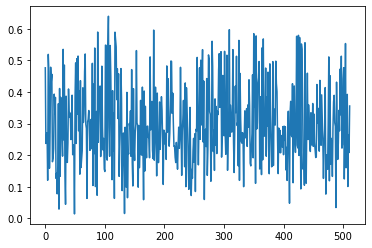

In [11]:
plt.plot(torch.stack(conf_list).std(0))

In [12]:
from sklearn.manifold import TSNE

In [14]:
fitter = TSNE()
conf_tsne = fitter.fit_transform(torch.stack(conf_list))
conf_tsne.shape

(528, 2)

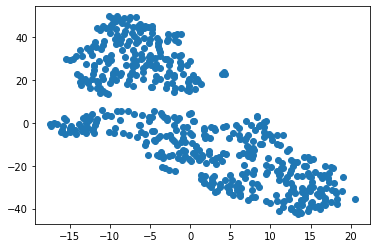

In [17]:
plt.scatter(*zip(*conf_tsne))

In [38]:
def l2_normalize(tensor):
    norm = tensor.norm(p=2, dim=1).unsqueeze(-1)
    return tensor.div(norm.expand_as(tensor))

In [39]:
fitter1 = TSNE()
conf_tsne = fitter1.fit_transform(l2_normalize(torch.stack(conf_list)))
conf_tsne.shape

(528, 2)

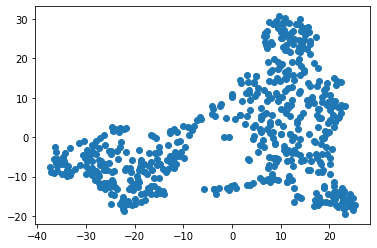

In [40]:
plt.scatter(*zip(*conf_tsne))

In [18]:
a = torch.randn(2,10).softmax(1)
a

tensor([[0.0883, 0.0798, 0.0336, 0.0260, 0.0770, 0.0444, 0.2652, 0.1677, 0.0709,
         0.1471],
        [0.0353, 0.0211, 0.0835, 0.0407, 0.0465, 0.0145, 0.0867, 0.1239, 0.5039,
         0.0440]])

In [19]:
sorted_a, indices = torch.sort(a,descending=True)
sorted_a, indices 

(tensor([[0.2652, 0.1677, 0.1471, 0.0883, 0.0798, 0.0770, 0.0709, 0.0444, 0.0336,
          0.0260],
         [0.5039, 0.1239, 0.0867, 0.0835, 0.0465, 0.0440, 0.0407, 0.0353, 0.0211,
          0.0145]]), tensor([[6, 7, 9, 0, 1, 4, 8, 5, 2, 3],
         [8, 7, 6, 2, 4, 9, 3, 0, 1, 5]]))

In [21]:
sorted_a_sum = torch.cumsum(sorted_a, dim=1)
sorted_a_sum

tensor([[0.2652, 0.4329, 0.5800, 0.6684, 0.7481, 0.8251, 0.8960, 0.9404, 0.9740,
         1.0000],
        [0.5039, 0.6278, 0.7144, 0.7979, 0.8444, 0.8883, 0.9290, 0.9644, 0.9855,
         1.0000]])

In [27]:
mask = sorted_a_sum>=0.65
mask

tensor([[False, False, False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True]])

In [28]:
sorted_a[mask] = -1000
sorted_a

tensor([[ 2.6520e-01,  1.6771e-01,  1.4711e-01, -1.0000e+03, -1.0000e+03,
         -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03],
        [ 5.0390e-01,  1.2385e-01, -1.0000e+03, -1.0000e+03, -1.0000e+03,
         -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03]])

In [47]:
chunk_sorted_a = sorted_a.softmax(dim=1)
chunk_sorted_a, chunk_sorted_a.shape

(tensor([[0.3577, 0.3245, 0.3178, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.5939, 0.4061, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000]]), torch.Size([2, 10]))

In [37]:
indices

tensor([[6, 7, 9, 0, 1, 4, 8, 5, 2, 3],
        [8, 7, 6, 2, 4, 9, 3, 0, 1, 5]])

In [34]:
confounded = torch.arange(10*512).view(10, 512)
confounded

tensor([[   0,    1,    2,  ...,  509,  510,  511],
        [ 512,  513,  514,  ..., 1021, 1022, 1023],
        [1024, 1025, 1026,  ..., 1533, 1534, 1535],
        ...,
        [3584, 3585, 3586,  ..., 4093, 4094, 4095],
        [4096, 4097, 4098,  ..., 4605, 4606, 4607],
        [4608, 4609, 4610,  ..., 5117, 5118, 5119]])

In [35]:
reorder_confounded = confounded[indices]

In [39]:
reorder_confounded.shape, chunk_sorted_a.shape

(torch.Size([2, 10, 512]), torch.Size([2, 10]))

In [41]:
z = (reorder_confounded * chunk_sorted_a.unsqueeze(-1)).sum(dim=1)
z.shape

torch.Size([2, 512])

In [46]:
torch.bmm(chunk_sorted_a.unsqueeze(1), reorder_confounded.float())

tensor([[[3726.3394, 3727.3396, 3728.3396,  ..., 4235.3394, 4236.3394,
          4237.3394]],

        [[3888.0693, 3889.0693, 3890.0691,  ..., 4397.0693, 4398.0693,
          4399.0693]]])

In [ ]:
torch.einsum('bmc,bm->bc', ).contiguous()